# 02 - How Jax works - The basics

- https://youtu.be/z-WSrQDXkuM?t=1211
- https://youtu.be/BzuEGdGHKjc?t=1908 

## What does this function do ?

In [1]:
def f(x):
    return x + 2

### But, what is `x` and has it overloaded the `+`. 

Jax takes advantage of that behaviour in Python(dyn. langs.) and passes a tracer value `ShapedArray[float32, (2, 2)]` representing a set of possible inputs.
Using that it builds up an expression (lambda) that represents the operations in the function as the fn is evaluated.

- What would the function do to a set of possible inputs ? (I don't care about what it can do to the rest of different types of inputs)

Eventually an expression (free of side effects) representing the operations in the function is extracted out as the JAX intermediate representation.

This Jax IR now be passed further down the XLA etc.

In [16]:
from jax import lax
# lax being an anagram for xla
# lax operations are the primitive operations
# that jax knows how to transform directly via xla

def log2(x):
    ln_x = lax.log(x)
    ln_2 = lax.log(2.0)
    return ln_x / ln_2

is transformed the following JAX IR as the tracer value passes through the function.

In [3]:
from jax import make_jaxpr

make_jaxpr(log2)(3.0)

{ lambda  ; a.
  let b = log a
      c = log 2.0
      d = div b c
  in (d,) }

Note that the function does not contain side effects (print etc.). Even if they're included, they'll not be included in Jax IR.

### Jax only works on pure functions. side effects are discarded as they won't be captured in the JAX IR

This is because the tracer cannot capture the side effects.

In [17]:
import jax
import jax.numpy as jnp

global_list = []

def log2(x):
    print(x)              # will not be captured by jaxpr
    global_list.append(x) # will not be captured by jaxpr
    print(global_list)    # will not be captured by jaxpr
    ln_x = jnp.log(x)
    ln_2 = jnp.log(2.0)
    return ln_x / ln_2

In [5]:
log2(1.0)

1.0
[1.0]


DeviceArray(0., dtype=float32)

In [6]:
jax.make_jaxpr(log2)(1.0)

Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
[1.0, Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>]


{ lambda  ; a.
  let b = log a
      c = log 2.0
      d = div b c
  in (d,) }

Using side effectful functions are a bad idea when jitting an expression, and can be a source of confusion.

In [7]:
from jax import jit

jog2 = jit(log2)

the first time a jitted function runs all side effects are run as usual, but then the jitted jaxpr is held on to afterafterwards

In [8]:
jog2(1.0)

Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
[1.0, Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>]


DeviceArray(0., dtype=float32)

In [9]:
global_list

[1.0,
 Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>,
 Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>]

In [10]:
jog2(5.0)

DeviceArray(2.321928, dtype=float32)

In [11]:
global_list

[1.0,
 Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>,
 Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>]

### Tracing functions with control flow

let's look into a function with control flow. 
The JAX IR can specialise based on control flow if it switches on a value derived from input, given that the tracer can reach it.

In [12]:
def log2_if_rank_2(x):
  if x.ndim == 2:
    ln_x = jnp.log(x)
    ln_2 = jnp.log(2.0)
    return ln_x / ln_2
  else:
    return x

In [13]:
jax.make_jaxpr(log2_if_rank_2)(jax.numpy.array([1, 2, 3]))

{ lambda  ; a.
  let 
  in (a,) }

In [15]:
jax.make_jaxpr(log2_if_rank_2)(jax.numpy.array([[1, 2], [3, 4]]))

{ lambda  ; a.
  let b = convert_element_type[ new_dtype=float32
                                weak_type=False ] a
      c = log b
      d = log 2.0
      e = convert_element_type[ new_dtype=float32
                                weak_type=False ] d
      f = div c e
  in (f,) }

Let's try jitting this. This can be problematic as the jitted jaxpr is going to different based on what value it got jitted on.

In [18]:
jax.make_jaxpr(jit(log2_if_rank_2))(jax.numpy.array([1, 2, 3]))

{ lambda  ; a.
  let b = xla_call[ backend=None
                    call_jaxpr={ lambda  ; a.
                                 let 
                                 in (a,) }
                    device=None
                    donated_invars=(False,)
                    inline=False
                    name=log2_if_rank_2 ] a
  in (b,) }

In [19]:
jax.make_jaxpr(jit(log2_if_rank_2))(jax.numpy.array([[1, 2], [3, 4]]))

{ lambda  ; a.
  let b = xla_call[ backend=None
                    call_jaxpr={ lambda  ; a.
                                 let b = convert_element_type[ new_dtype=float32
                                                               weak_type=False ] a
                                     c = log b
                                     d = log 2.0
                                     e = convert_element_type[ new_dtype=float32
                                                               weak_type=False ] d
                                     f = div c e
                                 in (f,) }
                    device=None
                    donated_invars=(False,)
                    inline=False
                    name=log2_if_rank_2 ] a
  in (b,) }

### Different levels of what functions are allowed on what types in jax. More in the presentation.

In [21]:
def f(x):
  if x > 0:
    return x
  else:
    return 2 * x

f_jit = jax.jit(f)
f_jit(10)  # Should raise an error. 

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
The problem arose with the `bool` function. 
While tracing the function f at /tmp/ipykernel_962/3725910964.py:1 for jit, this concrete value was not available in Python because it depends on the value of the argument 'x'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

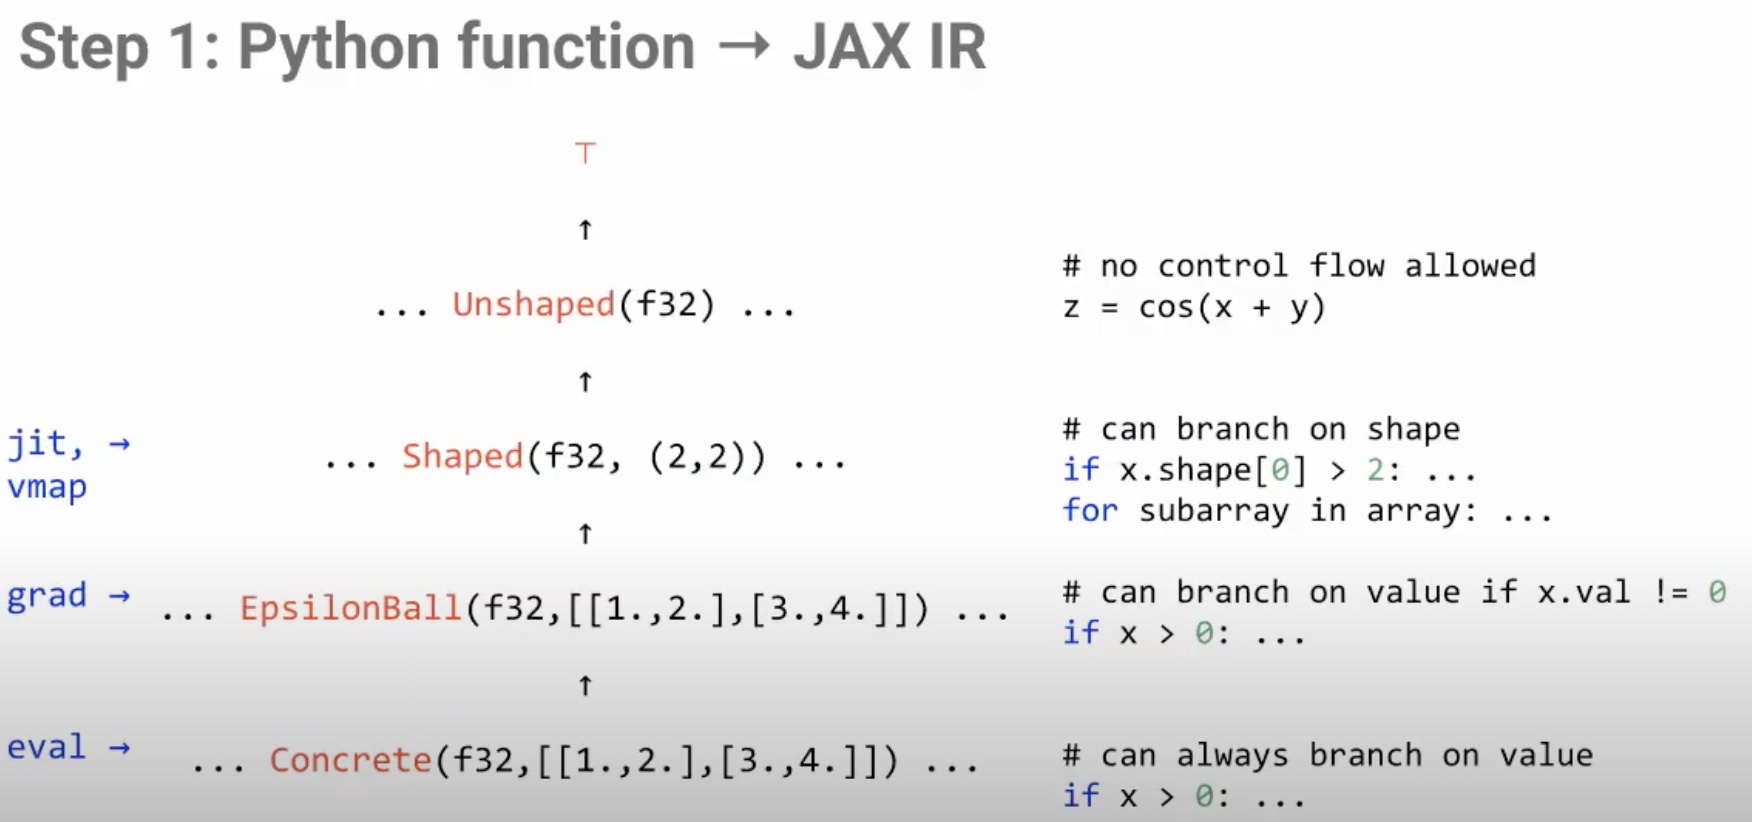

In [20]:
from IPython import display
from base64 import b64decode
base64_data = "/9j/4AAQSkZJRgABAQAASABIAAD/4QBkRXhpZgAATU0AKgAAAAgABAEGAAMAAAABAAIAAAESAAMAAAABAAEAAAEoAAMAAAABAAIAAIdpAAQAAAABAAAAPgAAAAAAAqACAAQAAAABAAAG2KADAAQAAAABAAADNgAAAAD/4QkhaHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wLwA8P3hwYWNrZXQgYmVnaW49Iu+7vyIgaWQ9Ilc1TTBNcENlaGlIenJlU3pOVGN6a2M5ZCI/PiA8eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJYTVAgQ29yZSA2LjAuMCI+IDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyI+IDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiLz4gPC9yZGY6UkRGPiA8L3g6eG1wbWV0YT4gICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICA8P3hwYWNrZXQgZW5kPSJ3Ij8+AP/tADhQaG90b3Nob3AgMy4wADhCSU0EBAAAAAAAADhCSU0EJQAAAAAAENQdjNmPALIE6YAJmOz4Qn7/4hAISUNDX1BST0ZJTEUAAQEAAA/4YXBwbAIQAABtbnRyUkdCIFhZWiAH5QALAB4ACwAqACphY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABJkZXNjAAABXAAAAGJkc2NtAAABwAAABJxjcHJ0AAAGXAAAACN3dHB0AAAGgAAAABRyWFlaAAAGlAAAABRnWFlaAAAGqAAAABRiWFlaAAAGvAAAABRyVFJDAAAG0AAACAxhYXJnAAAO3AAAACB2Y2d0AAAO/AAAADBuZGluAAAPLAAAAD5jaGFkAAAPbAAAACxtbW9kAAAPmAAAACh2Y2dwAAAPwAAAADhiVFJDAAAG0AAACAxnVFJDAAAG0AAACAxhYWJnAAAO3AAAACBhYWdnAAAO3AAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAAUAAAB2GtvS1IAAAAMAAAB7G5iTk8AAAASAAAB+GlkAAAAAAASAAACCmh1SFUAAAAUAAACHGNzQ1oAAAAWAAACMGRhREsAAAAcAAACRm5sTkwAAAAWAAACYmZpRkkAAAAQAAACeGl0SVQAAAAYAAACiGVzRVMAAAAWAAACoHJvUk8AAAASAAACtmZyQ0EAAAAWAAACyGFyAAAAAAAUAAAC3nVrVUEAAAAcAAAC8mhlSUwAAAAWAAADDnpoVFcAAAAKAAADJHZpVk4AAAAOAAADLnNrU0sAAAAWAAADPHpoQ04AAAAKAAADJHJ1UlUAAAAkAAADUmVuR0IAAAAUAAADdmZyRlIAAAAWAAADim1zAAAAAAASAAADoGhpSU4AAAASAAADsnRoVEgAAAAMAAADxGNhRVMAAAAYAAAD0GVuQVUAAAAUAAADdmVzWEwAAAASAAACtmRlREUAAAAQAAAD6GVuVVMAAAASAAAD+HB0QlIAAAAYAAAECnBsUEwAAAASAAAEImVsR1IAAAAiAAAENHN2U0UAAAAQAAAEVnRyVFIAAAAUAAAEZnB0UFQAAAAWAAAEemphSlAAAAAMAAAEkABMAEMARAAgAHUAIABiAG8AagBpzuy37AAgAEwAQwBEAEYAYQByAGcAZQAtAEwAQwBEAEwAQwBEACAAVwBhAHIAbgBhAFMAegDtAG4AZQBzACAATABDAEQAQgBhAHIAZQB2AG4A/QAgAEwAQwBEAEwAQwBEAC0AZgBhAHIAdgBlAHMAawDmAHIAbQBLAGwAZQB1AHIAZQBuAC0ATABDAEQAVgDkAHIAaQAtAEwAQwBEAEwAQwBEACAAYQAgAGMAbwBsAG8AcgBpAEwAQwBEACAAYQAgAGMAbwBsAG8AcgBMAEMARAAgAGMAbwBsAG8AcgBBAEMATAAgAGMAbwB1AGwAZQB1AHIgDwBMAEMARAAgBkUGRAZIBkYGKQQaBD4EOwRMBD4EQAQ+BDIEOAQ5ACAATABDAEQgDwBMAEMARAAgBeYF0QXiBdUF4AXZX2mCcgBMAEMARABMAEMARAAgAE0A4AB1AEYAYQByAGUAYgBuAP0AIABMAEMARAQmBDIENQRCBD0EPgQ5ACAEFgQaAC0ENAQ4BEEEPwQ7BDUEOQBDAG8AbABvAHUAcgAgAEwAQwBEAEwAQwBEACAAYwBvAHUAbABlAHUAcgBXAGEAcgBuAGEAIABMAEMARAkwCQIJFwlACSgAIABMAEMARABMAEMARAAgDioONQBMAEMARAAgAGUAbgAgAGMAbwBsAG8AcgBGAGEAcgBiAC0ATABDAEQAQwBvAGwAbwByACAATABDAEQATABDAEQAIABDAG8AbABvAHIAaQBkAG8ASwBvAGwAbwByACAATABDAEQDiAOzA8cDwQPJA7wDtwAgA78DuAPMA70DtwAgAEwAQwBEAEYA5AByAGcALQBMAEMARABSAGUAbgBrAGwAaQAgAEwAQwBEAEwAQwBEACAAYQAgAEMAbwByAGUAczCrMOkw/ABMAEMARHRleHQAAAAAQ29weXJpZ2h0IEFwcGxlIEluYy4sIDIwMjEAAFhZWiAAAAAAAADzFgABAAAAARbKWFlaIAAAAAAAAHHAAAA5igAAAWdYWVogAAAAAAAAYSMAALnmAAAT9lhZWiAAAAAAAAAj8gAADJAAAL3QY3VydgAAAAAAAAQAAAAABQAKAA8AFAAZAB4AIwAoAC0AMgA2ADsAQABFAEoATwBUAFkAXgBjAGgAbQByAHcAfACBAIYAiwCQAJUAmgCfAKMAqACtALIAtwC8AMEAxgDLANAA1QDbAOAA5QDrAPAA9gD7AQEBBwENARMBGQEfASUBKwEyATgBPgFFAUwBUgFZAWABZwFuAXUBfAGDAYsBkgGaAaEBqQGxAbkBwQHJAdEB2QHhAekB8gH6AgMCDAIUAh0CJgIvAjgCQQJLAlQCXQJnAnECegKEAo4CmAKiAqwCtgLBAssC1QLgAusC9QMAAwsDFgMhAy0DOANDA08DWgNmA3IDfgOKA5YDogOuA7oDxwPTA+AD7AP5BAYEEwQgBC0EOwRIBFUEYwRxBH4EjASaBKgEtgTEBNME4QTwBP4FDQUcBSsFOgVJBVgFZwV3BYYFlgWmBbUFxQXVBeUF9gYGBhYGJwY3BkgGWQZqBnsGjAadBq8GwAbRBuMG9QcHBxkHKwc9B08HYQd0B4YHmQesB78H0gflB/gICwgfCDIIRghaCG4IggiWCKoIvgjSCOcI+wkQCSUJOglPCWQJeQmPCaQJugnPCeUJ+woRCicKPQpUCmoKgQqYCq4KxQrcCvMLCwsiCzkLUQtpC4ALmAuwC8gL4Qv5DBIMKgxDDFwMdQyODKcMwAzZDPMNDQ0mDUANWg10DY4NqQ3DDd4N+A4TDi4OSQ5kDn8Omw62DtIO7g8JDyUPQQ9eD3oPlg+zD88P7BAJECYQQxBhEH4QmxC5ENcQ9RETETERTxFtEYwRqhHJEegSBxImEkUSZBKEEqMSwxLjEwMTIxNDE2MTgxOkE8UT5RQGFCcUSRRqFIsUrRTOFPAVEhU0FVYVeBWbFb0V4BYDFiYWSRZsFo8WshbWFvoXHRdBF2UXiReuF9IX9xgbGEAYZRiKGK8Y1Rj6GSAZRRlrGZEZtxndGgQaKhpRGncanhrFGuwbFBs7G2MbihuyG9ocAhwqHFIcexyjHMwc9R0eHUcdcB2ZHcMd7B4WHkAeah6UHr4e6R8THz4faR+UH78f6iAVIEEgbCCYIMQg8CEcIUghdSGhIc4h+yInIlUigiKvIt0jCiM4I2YjlCPCI/AkHyRNJHwkqyTaJQklOCVoJZclxyX3JicmVyaHJrcm6CcYJ0kneierJ9woDSg/KHEooijUKQYpOClrKZ0p0CoCKjUqaCqbKs8rAis2K2krnSvRLAUsOSxuLKIs1y0MLUEtdi2rLeEuFi5MLoIuty7uLyQvWi+RL8cv/jA1MGwwpDDbMRIxSjGCMbox8jIqMmMymzLUMw0zRjN/M7gz8TQrNGU0njTYNRM1TTWHNcI1/TY3NnI2rjbpNyQ3YDecN9c4FDhQOIw4yDkFOUI5fzm8Ofk6Njp0OrI67zstO2s7qjvoPCc8ZTykPOM9Ij1hPaE94D4gPmA+oD7gPyE/YT+iP+JAI0BkQKZA50EpQWpBrEHuQjBCckK1QvdDOkN9Q8BEA0RHRIpEzkUSRVVFmkXeRiJGZ0arRvBHNUd7R8BIBUhLSJFI10kdSWNJqUnwSjdKfUrESwxLU0uaS+JMKkxyTLpNAk1KTZNN3E4lTm5Ot08AT0lPk0/dUCdQcVC7UQZRUFGbUeZSMVJ8UsdTE1NfU6pT9lRCVI9U21UoVXVVwlYPVlxWqVb3V0RXklfgWC9YfVjLWRpZaVm4WgdaVlqmWvVbRVuVW+VcNVyGXNZdJ114XcleGl5sXr1fD19hX7NgBWBXYKpg/GFPYaJh9WJJYpxi8GNDY5dj62RAZJRk6WU9ZZJl52Y9ZpJm6Gc9Z5Nn6Wg/aJZo7GlDaZpp8WpIap9q92tPa6dr/2xXbK9tCG1gbbluEm5rbsRvHm94b9FwK3CGcOBxOnGVcfByS3KmcwFzXXO4dBR0cHTMdSh1hXXhdj52m3b4d1Z3s3gReG54zHkqeYl553pGeqV7BHtje8J8IXyBfOF9QX2hfgF+Yn7CfyN/hH/lgEeAqIEKgWuBzYIwgpKC9INXg7qEHYSAhOOFR4Wrhg6GcobXhzuHn4gEiGmIzokziZmJ/opkisqLMIuWi/yMY4zKjTGNmI3/jmaOzo82j56QBpBukNaRP5GokhGSepLjk02TtpQglIqU9JVflcmWNJaflwqXdZfgmEyYuJkkmZCZ/JpomtWbQpuvnByciZz3nWSd0p5Anq6fHZ+Ln/qgaaDYoUehtqImopajBqN2o+akVqTHpTilqaYapoum/adup+CoUqjEqTepqaocqo+rAqt1q+msXKzQrUStuK4trqGvFq+LsACwdbDqsWCx1rJLssKzOLOutCW0nLUTtYq2AbZ5tvC3aLfguFm40blKucK6O7q1uy67p7whvJu9Fb2Pvgq+hL7/v3q/9cBwwOzBZ8Hjwl/C28NYw9TEUcTOxUvFyMZGxsPHQce/yD3IvMk6ybnKOMq3yzbLtsw1zLXNNc21zjbOts83z7jQOdC60TzRvtI/0sHTRNPG1EnUy9VO1dHWVdbY11zX4Nhk2OjZbNnx2nba+9uA3AXcit0Q3ZbeHN6i3ynfr+A24L3hROHM4lPi2+Nj4+vkc+T85YTmDeaW5x/nqegy6LzpRunQ6lvq5etw6/vshu0R7ZzuKO6070DvzPBY8OXxcvH/8ozzGfOn9DT0wvVQ9d72bfb794r4Gfio+Tj5x/pX+uf7d/wH/Jj9Kf26/kv+3P9t//9wYXJhAAAAAAADAAAAAmZmAADypwAADVkAABPQAAAKW3ZjZ3QAAAAAAAAAAQABAAAAAAAAAAEAAAABAAAAAAAAAAEAAAABAAAAAAAAAAEAAG5kaW4AAAAAAAAANgAAp0AAAFWAAABMwAAAnsAAACWAAAAMwAAAUAAAAFRAAAIzMwACMzMAAjMzAAAAAAAAAABzZjMyAAAAAAABDHIAAAX4///zHQAAB7oAAP1y///7nf///aQAAAPZAADAcW1tb2QAAAAAAAAGEAAAoCkAAAAAzswJIAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/AABEIAzYG2AMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAEBAQEBAQIBAQIDAgICAwQDAwMDBAYEBAQEBAYHBgYGBgYGBwcHBwcHBwcICAgICAgJCQkJCQsLCwsLCwsLCwv/2wBDAQICAgMDAwUDAwULCAYICwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwv/3QAEAG7/2gAMAwEAAhEDEQA/AP76KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopCcDJoAWik3Akr3FLQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFIzBRuboKTcucdzQA6ilxikoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP//Q/voooooAK5fxZ438H+B9PfU/FmpW+nxIu7M8ipke2SM153+0N8X9N+Bfwi1z4m6lyuk2r3CrjO5l6ADua/io+P37U/xp/ah8bXmp+NtRllt7ibMFmhIhjB4ARMnH4dzQB/Wtr3/BSf8AY78NXr6fq3iyJZYyVISKRxke6qRXofwz/bZ/Zk+LVylj4O8VW0k7/dSXMWc+7gCv5Xfh9/wSu/bC+IuiweL9C0KA2s8e5Eu7hLaTaw4JWTBH0rwL40/sx/HT9lPUre3+IumS6bKSGiuIH82Ev/syKNuRxwDxQB/eNHJFMglgcOjDIZTkEH3FPr+cT/gk3+3t4u1XxZH+z/8AGHUJdQW7H/EuuZ2LOjDgIWOcg5AHTGK/cT9qHxdrngH9nrxj4z8My+Tf6Zpk89vJ12ugyDQB7sSu0knFNVixPGMHFfxuaF/wVI/bAv8AxXa6Zda5E0LXSRkGNuVLAf36/sX0id7vSba7lxvkiRmx3JAoAv0UUUAFFFFABRQDnmgnHNABRRRQAUUUUAFFFfnN+2x/wUI8K/shXS+H7vS5NS1O5gEsSLIEVd2cEkqc9OlAH6LMwU5chQOpNeW+J/jd8LPCWpWOi6trVqt3qE4t4YVlVpDIxwBtBJHPrX8lfxy/4K0/tRfFmN9J0rUE0LTz8yCxQxTjPYyBufyr5j/Zq8YeJvGf7Vvg7W/E99Pf3T6xa5lnYu5y3qaAP7w0dZEEi9GGR+NOqlpv/IOt/wDrmn8quk45oAKKKKACkJwMkcetLSOcRmgD5c8Vftn/ALN3gvX7nwv4l8SwW19ZtsliZWJVsZxwPQ1z/wDw3v8Aso/9Dbb/APfLf4V/Il+3dLI37W3jUA4/00dP+ua1N8Jv2Hv2jfjT4VXxn8PtJW+sGfYH80JzjPfNAH9fGl/tyfst6xeLY2fi218xzgbsqMn3NfSHh3xd4X8XQfbPC+o29/DjJaCRX2/UAmv4lvGv/BPb9q/wHocniTXPDErQW4LMbd/Pce+1ATXm3wE/as+N/wCzf4xiu/BeqXNoEl23FnKW8pwp+ZWTI68jmgD+9XjtRXzj+yp+0N4a/ab+D2m/Ejw82x3TyrqI9Unj+VuOMAsDj2r6OoAKKKKAClAycUlflT/wVP8A2h/if+z18N9K174Y3i2lxcT7HLKWBGQOxFAH6rTbUwqnJqnfXH2ewmu8Z8qNnx67Rmv5t/8AgnZ+3f8AtFfG/wDaXsfAXj7VEutNeB5JI1QhiwZQP4j2J7V/R/rnGh3p/wCneT/0E0AfhBq3/BdDwRoviC40jUfA9/L9nkaItHPEM7T15r9nvgf8U7H42fCbQPixpdrJZ2+v2cd5HBKwZ41lGQpI4JHtX8Fvj0f8V7qwI/5eZf5mv7Yv+CfmR+xl8Os/9AS1P/jgoA+xqKKKACignFFABRRRQAUUZ70UAFFFFABRRRQAUcDljgCivP8A4s+JZvBHw41nxXCAXs7V5Fz0yPWgD8/v2uv+Co/wa/Zm1N/CGmRP4h1tTtkitmCrAevzkjB+gPevgLw3/wAFxtb8QeKrXR7jwuVtbmZIgVZQ43EDrn+lfgb4svtT8ffEa7ub6cyXmp3zB5pDuJZ2wMnv2Ff0ufs3/wDBGb4JweDtE8YfEq9vLvV3jjuXFrMYkRxg4/iB5oA/avwVrjeJ/C1j4iZfL+2wrMF/uhhnFdTWRoGg2HhjRbXw/pe77PaRrFHvO5tqjAya16ACiiigAooooAKKKKACiiigAooooAKQkLyaWvnH9r3x34h+GP7Mnjb4geE5BFqWk6VPc2zsMhZEHBI70AfRnmw/3s04YJ61/Gj4f/4Kl/te32v2VnPrNuUmuI0b9yejMAf46/se0yeSXS7e6YbmaNGI9SQM0AfI/wC1N+3D8GP2TXtbH4gTtLf3i7o7WL75X16HA+tav7L37ZXwg/ax0e81H4bzsJ9P/wBfbyAh0znHUDPQ9K/MP/gqX/wT6+Lv7QfxPs/jF8KlTUpJLVLOW0eURmIRbiGBY9y2MAdq9F/4JV/sOfF39mWTV/GfxYaGzn1NViitoXEmNu4ZYqTyc+lAH7UI29A47jNOpFBAAPJFLQAUUUY70AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFYa+JdCPiH/hF2uY1vvLMggZwHZfULnJAzzjpW5g0AFFFFABRRRQAVjazrem+H7CXVtWkEMESksx6ACtmvHf2iI42+CfiNmUErYSEex4oA8ut/wBuX9lu6vl02LxZbeczbApDD5vTpX1JpepWes6bDq2nOJLe4UOjDuDX+e+jf8VmpHB+3D/0ZX96vwDUj4LeG9xJIsYuTyTxQB61Xl/xO+M3w2+D1jFqPxB1SLT4pmCoZOMn2r1Cv5TP+C0XxztvH3xqsPhbotyJLbw5ATNt+60kwU4PYlSCPagD+inwT+1f8A/iFr8Xhnwn4itrq9m+5GDgn6Zr6M2HbvHI9RX+f18DfiTe/CD4saH8Q9OBaXS7lJgvUPtPQjuPav74Ph74n0/xn4K03xLpbK8F5bxyKynIOQM4x75oA35po7eF55ThUBYn2FfLOsftr/sz6Bqr6Nq3ieCCeIlZFZWBUjsRjrX1PJElxG0En3XBU/Q1/Kx/wVy/Y7X4S+OF+Nfg+Jv7H1yUrcDG7ZP1ZmI6BtwAz1oA/pZ+GPxp+GPxlsJtT+G2rRapDbttkaPI2n8fpXqORX8dv/BLb9qW5+AXxztfCOqv/wASPxJIlrKpbCpM52o3PAALEk1/XZ4l8U6H4P8ADV34x1+5SHT7KA3Es2QV8sDOQfpQB538Tf2h/hB8H7+DTfiFrMOnzXCl0RzkkA46Cud8DftX/Aj4k+I4PCngrXYr++uThI4w2eAT6cdK/jX/AGyf2ivEP7Sv7QGs+MbmZ109JWisVySscSYXH/AiM/jX7q/8Edf2Sj4U8KyftD+LYnF5qsYjsY5lIKxAg7wD0JII+lAH7wHHQUAZOKTvmkPQ0AeZfE34x/Dj4PWcWofEXVI9MhnO1Gk7muJ8B/tUfAb4meIYvC3gnxDBfX0vKxpnP8q/IP8A4Lr3EieE/CVuD8jtKSPUhlr81/8Agkv8/wC1/oqcgEHI9fmWgD+wfxR4q0DwZ4cuvFviW5W10+yXfNK/RV6ZP418wn9vT9k8HB8X23/fLf4VU/b8kMX7H/j04Df8S08NyP8AWJX8QNrYG/v47C3QGWeRY0HqznAH5mgD+4xf28f2UX6eL7X8m/wr0Dwf+1D8APHeV8OeKbGQjIw8qxkn/gRFfyJp/wAEyP2vbnTINRg8Oxus/K5nVeOxxXz58Wv2afj5+z3f28/jzR59NBGUnTLw7jjA3gbQfbNAH98Fle2t9bLd2siSROMqyMGDD2IzVlWzxX8on/BNT/gob8RvBPj7SvhF8VdRbUtC1OYW0bzEs9vIxwp3EnCDnI4HTmv6srOeO6hS5hIZJFDKR0IPSgC3RRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9H++iigc80UAfnj/wAFRdA1jWv2O/FE+j5zZwNNL6eWoOf51/Ht8KPEeleEvijo/irxHAt1YW11HJcRZ4KD0+h5xX9/Pibw9pvi3QbvwzrUazWd7E0UqOAwYHsQeDX8tP7af/BIz4pfD3VLvxr8BIJdf0qV2lNnGuZ4QeSqqAcjvkmgD+kn4GfHX4S/G3wpD4i+GOrQ3sDRgeUrASR4HRkBO0+1eX/tjfsr6R+1v8G3+Guo3Z025WaOeC6CB2jMbBiACR94DB5r+KbQvFXxU+CviNrbTNQvtDvoJCZIUlePEgHIZAQD+NfqF+zz/wAFj/jd8M7iLRPibBH4k03EcfmSHy5Ylzh2G0fMcep7UAfd3wX/AOCMd/8ACX4raD8TbTxvLM2lXcN00P2YKHWJgxXO84DfSvl3/gpn+3r+0N4S+Mni39mjQ720Xwrc2sVvJG1shnKzxguBJ94cnr2r9/P2aP2rvhL+1L4PPij4Y3vntbFUurZsCaBj03KCcA4OOea8f/bm+DXwv1b9nTx74zvtEtJdWTSLhxdtGplDKvBDYzkdqAP4mLfUGsb2LUUYpMsgdCBk7lORx+Ff0Bf8E8P+Ckf7T/x4/aD0P4Z/Ee/tJtFuEaNo4rJIpCERiPmHI6DmvwZ8N20Nz43060P+rF9GjKRncpbpX94vw/8AgR8JPA0dhrnhjQrO0vookZZo4lVgWXnkDPegC78avjT4D/Z28BXXxD+IF0Le2hViiFsvI+OFUE8846V/M38dP+Cz3x+8Xard2XwwittA0p5AYt6LNKQDwSxAIz6VP/wWl+PGs+MfjPB8IbG5ZdK0CJZGjVsf6S5ZXz6gBRjNH/BJv9jL4a/HK8vfiV8ZVF9YacwWztySqPIM53EEfdIHrmgDxLwr/wAFdP2xPCurJfXOsWd1Dn545bdG3L3Az0+tfv5+wl/wUb8JftdWDeGdXhTSvE9uoLwbspIvHzKcDPUcAV57+2x+wB+zV43+CeueIvC2lxaXr2lWUk9rJa9GMS8IVyAd2BzjNfzEfs6/EzWvgR8bdC8d6FMR/ZF6BIoONwViCG9RntQB/YD/AMFBvj549/Zt/Z9uPiJ8O5Ik1JJAqNNGJFA6/dPBr8MPgz/wWd/aHh8cx3fxkurW58PRiZ5YbaySORsoRGgZRkfPjJ9K/Ur/AIK2351H9i2LUGPNx5ch/wCBKDX8wX7NPw10j4xfHDw/8NtbkaOy1C4CylOpVecduuMUAfbPxN/4K9ftR+NfEMl34cuotG08Sfu7ZYQxC56GTAJ474r379nD/gsr8V9F8V2uj/FyCDUtEmdUd0AWaIE4LZCkt64yK/b/AE//AIJ0/sm2fhEeDj4WheBYjEZGdjIcjGd2c5/Gv5Of28P2df8Ahln9onUPh1oILabtjubNx8yrHL82zceSVBAOaAP7cfAvjLQ/iF4Ss/GPhqZbixvoxJE6nPB7H3HQ11Vfjh/wRb+J3iLxp+zxqXhbXcmPQLtYrZyc70m3O35Hiv2PoAVevNfl7+2l/wAE7rb9sD4o2HinX9WOm6dYQKm2JN7yMM5HUEDkV+oNB5oA/Br9pn/gmt+zn+z7+y3rPiTwnZyy6nBGGa4uZWclwCRt3E7RnsK/n+/ZIOf2nfBx/wCoza/+hV/X9/wUd/5NK8S/7g/ka/j/AP2Rv+Tm/Bv/AGGbX/0KgD+9vTf+Qdb/APXNP5CuA+M3jjUPhr8Kte8daXbi6n0y1aZIicbjwB69M5rv9N/5B1v/ANc0/kKTVNL0/W9Nn0nVYxNb3CNHJG3RlbgigD+M+0/4KfftXy/EseLLjW1keWZc2ypiEJu5AT7uSMjpX9eHwX8Z3PxF+E3h3x3eIY5dWsIbplIwQZFBxivgPTv+CRv7KmmfEI+P7WymGJRLHal2MSlTkdW559RX6e6bp9ppNhDpthGsUEChERBtVVHQADoKALtNk/1Zp1En+r/A0Afwk/t3f8nbeNP+v0f+i1r+ln/gj2N37JcJPP8Apbf+gLX80v7d/H7WvjU/9Po/9FrX3t+xT/wU88KfsxfB2H4b6rp888q3Bldo0yNpUDg5HcUAf1amyiulMN0A0bAhlIyGB6gj0Nfxq/8ABV/4beFPht+2Lqun+EbZLO3urS2vHiQAL5s25mIA4xmv0u8Qf8F0/BUGkSP4X8OzSXwRggmyqFiOCTk4weelfgX8ZPi941/aK+JF78QvFjm41LUZcKi87VJOxB04GcDigD95v+CHWt+L9Q+FnxD8O6NJ5RjngNrNINyRyskhHB45PbvXx58R/wDgrR+3J8P/AB5qvhXVNR04HT7uSA/6BGPkViAencYr9j/+CS37NniD4Dfs9y3vjS2NrqfiaVbqSM54iG7yyc9yrA1+K3/BX/4HRfDD9pdvFNpGI7HxPD9qiROQDEFjOfckE0Af0ofsafG+8/aF/Z90D4jas6vql1Bm9VFCqsuTwAPbFfLH/BUT9sjxj+yZ8P8AQ5/hpdww63q91JFiWFZ9saLuB2t2PIzXyB/wQ1+LM174c8UfCq6ZpBZsL6FNxZlQ7I8Y9M5r4P8A+Cw3xhuviF+1HP4SibFr4biFn5Z/56qWy31wRQB7H+zD/wAFJ/23Pjr8SJfCD6vZGG30+7vZWXToxtFvE0gye2dtfBf7UP7aX7Qv7R6y+E/inf213Y6dcOLdLe2SE8N1LLz2r9af+CJP7OtnJ4V8QfGzXVE8WpFtNhDD7vlblkH0YPirP/BZn4O/DT4dfB3SNT8E6VBp9zcXYEksMaqzAsOuAKAPwS+CXx2+IH7OXjmH4pfDOaO31OCNoR50QmGGIJ+VvcDFf1V/8Ezv2rPjB+1h8FvGfij4wXFtcXOl3Rtbc20CwgRtAHOQvU5Jr8If+CV3g7wp8Qv2rbbwz4zsYr6zjty5jlAZWOU6g/Wv669D+Hngf4beF9W0/wAEabDp0V2kksqQIEBYJtBIA9BQB/BL4/dV+IOq7wSPtUnT696/Wa5/4KyeLfhj8AfBvwg+BVpFDfaTpNvb3d5MocCVVw6rGQQQMcNnv7V+S3xDOPHurHOP9Lf/ANCr+p/9gb9gX9nm4/Z/0D4peItMXU9U8QWcd3JJMOFEgB2hckevOKAPxV8Lf8FXf2vfD/iRdW1HVoLyIDLwmJdp9PXH5V/R3+wd+2ton7W/gKS41CNbHxDYELdWytkEHOHXgdQMkY4zivxj/wCCv37Jnwv+CdxoPj74a2S6cmqmWO4hQnbmPbggZ9zXmX/BFnxlfaV+1gfD8kjfZb7Srsso7yKYwp/ImgD+q/4geOvDfw18JX3jTxVdJa2enxGV3c4GB9cV/Nt+0L/wWx+J2oeIbrQfgtZW9jpkbMi3MyiR5lHHQj5DnnqeBXvH/Bbv9oDUfDWl6B8EtIkZF1JWvZyvG4RkptPqDnpX5i/8E2P2TdH/AGrfjPcWfidD/Yuixrd3S9BL8wXbkcjkg8UAM07/AIKqfth6ReR6nHrsMvltnY8CuD+Br9Z/2NP+Cw1h8TPFNn8O/j7Zw6Vd3e1INQjYeVNK3GCuFCc47nrX398Rf+CfX7LfjLwFc+EY/DFvbnyWSCWMlXR8fKdwIJwfWv42vj/8Ndc+Bnxk1L4aSsVOg3h8qccFgjcEHt92gD+/7z7Wa3W7gkDROu8OOhB5z9K/kb+Jf/BXL9tzw58Q9f8AD+i6rpotdP1G6t4FNjGx8uKVlXJxzwBzX72/8E//AI9SfHz9lHSPEN2S93ZRPYSdzi2/dqT9Quc1/HL8Xcj4seJyOMave/8Ao56AP2v+Ln/Ban4g/wDCG6ZoHwvt4RrJth9vv5olK+aeyxEYx05Br4m0n/gqz+2Joet/21d69BKGIPlvbKVJzyApyOlfsv8A8E6f2BfgMP2e9C+K/izS11bWdft2meSckqgDsu0Lkj+HOcV8Nf8ABYr9k/4Q/BnT/Dnj/wABWH9nyarctayxRklGdUZ93Xj04FAH64f8E/v27tH/AGwvBc9rq5itPE2mkfaoVwAynowHHUg8Yr9Ha/j8/wCCNer3Oj/tgWuiJny9RtZxtB4PlRu3Prjtmv7A6ACv5gv+Ckv/AAUB/aS8G/HTxx+znoGpWsXhlI4oRGbRDKscsSO37373U9e1f0+18Y/tcfBP4Va18H/GPjjVNEtZtWFi7/amjUyblAAOSM8CgD+Hi1vLiy1WLWIGUzRSCUFum4HI/Wv2e/Ze/wCCpn7X3in4s+G/hfq2o6fJpU8kcLxpYxq5jPHDDnNfj7p1rDceNLezlUGN75EI7YMgGK/uh+F37PXwY0bw/oOr6V4dsoLxIUYSrCm/IGc5xmgD83v+CoH7cH7Qv7LfjXR9F+El3aQ2t9BulW4t0lJJHJBYZFXv+CX/AO258e/2p/FmtaP8XLq1uLbTokMP2e3WEgkE8leucV8jf8FxYlHxK0Bh/wA8D/IVL/wQ0GPHPiof9M4//QWoA/oo+I2s3vh3wRqWt2DrHJbQNJubnGB71/KZe/8ABYX9sqy8Rz6XDqGnCL7W0CZso2IQPj09O9f1JfHT/kkHiH/ryk/lX8D+rf8AI5zf9f7f+jKAP7srf4h+I5f2ax8R1lT+1G0xrrzCo2mRVJzt6Yz2r+Y7Qv8Ags1+17/btiuu6rp4sWuIhc7NPj3eSWG/Hvtziv6M7Lj9iqAD/oAyH/xxq/h38OaMut+IrDQwdv265it93p5rBc/hmgD9vv2lv+C1HxM8QXcfhv8AZ/hg06yhQCW8uUDSTP6hWHyjPoe9fLfg3/grN+2J4W1mLUJ9Ytbu3DfvoZoFYOp6gMc7fY9q/oD/AGdP+Cav7Mfg34a6Wmr6Mmq6jNbxSz3E5OWYqDwMkAZ9K/DD/grR+zd8O/2c/jbpzfDK1Flp+u2rzNa5LKkkewEgkk8licdqAP6Tv2Of2p/C/wC1j8LIvGWh4jvbYrHfQA58qXHT8Rz0Fen/ABw+N3gb4A+Arv4geO7hYba2QlVz88jDoqjufavwP/4IU+Jru31zxR4aXJSZRcHnAyoVelcT/wAFrfjRr2sfEjR/hNbyGPT7CA3Eiqx+aUll5/A0AeZ/HX/gsz+0J431mX/hWawaBo4OI1aISysPUsQCK8c8Ef8ABWL9rfw9qy3r6xFdKjZaOaBWDL6c5r6E/wCCS37F3gn9oO81T4nfFSD7bpOlsIra2yQGmB+YtjHABBr9Wf2vP+CanwU+Ivwm1S48AaSNM1qxt3ntJLRcu7RqW8vbkA78bfxoA0v2Df8AgpD4a/aujPhLxVHHpfieEFvIBBWZF6svT24A4zX5Zf8ABSj9vD9onSfil40/Zttb60XwxdWy2skRtEMhhmQFgJOoOTwa+Qf2bP2Zv2tfhj8fPC/jPTvCOrW0djqEBnmERCiPeNwY+nHNf0c/t5/Cj4eX/wCyh4/+JGoaLaya8NEeY3RjXzFkWMcg46igD+MK0uZ9OvYr23IEkLrIp6jcpyK/o8/4J0f8FCP2lv2gvjrafDn4kajYXGlCHASC2SJyFU4yV57V/Oj4Wxd+IrBbgAh7qIMOxBcV/e38Ofgf8J/BJtfEPhPQ7Syu3tkYyxRKrZK+oAoA/Jj/AIKX/t9/H39mH4r2Hgz4T3Fna209nHcSGe2Sdiz7s8sOOld9/wAEtv20fjl+1lqfiew+LNza3MekC3aIwQLBgy78/d6/dFfnH/wW6Yj9ofSsf9AuD+b17R/wQb51rx8f9my/9qUAf0B/FT4p+Dvg14Jv/H3ju6W1sLBC7EkbnOCQqgkZY44HU1/NN+0h/wAFlPjF4o1q50z4LRRaNpiOVSSSMSyOo78gFfzr0z/gtx8atcHjTRfg1ply8VrFF9ovIx0Z22mMn6AmvmP/AIJX/sb+G/2nfHWoeLPiVam68OaMuxowzKXuTgqpxjjbnv8AhQB5hoX/AAVL/bO0K7TU31yCaNCDiWBSD+dftF+xR/wVq8KfGrUrb4b/ABngXStfuCEgnj/1Eze/ChCew55r6e+Mv/BOT9mf4i/DqXw1DoaWM1tA32WaAlWVwCQTgjd6c5r+ObxzofiD4HfFi78PPIYtR0G8wWU4xJEcjBoA/v38WalcaT4W1TVbJgJrO0mmXdyAyIWGR9RX8nXjH/gsJ+2ZovirVdM0/VNOWOC5ngiBsI2ARGIHP0HWv6BP2bPixefGj9iZPHOpnfeS6HNHcSHq0iQHcfzNfxUePFRvGusKxIJvZ8D/AIGaAP3E/aF/4LSfEa70u28M/BK3gtmNnAbvU50DM8xjXzNsRGFAfOCDXx34U/4Kv/tceFb+DVIdYhvmHE0c8IK9c8ZzX7u/sc/8E7f2b9A+COk654k0pdX1LVraO4nuJ85+dcgBckAAHHA7V+UP/BXb9lj4YfAbxV4f8UfC+1Gm22rKUuIV+YGTLYYA9OFxxigD90f2Dv2ytN/bD+Gj+IpoEs9X09vKvYFOQHAHzDgfKc46V90jnmv5bP8AghjqM+lfG/xVpsM7mG706MtGfu7vM6gevFf1Ho2R09qAJKKK4n4k6rqmh+ANY1nRCRd21rJJFgbjuUccGgDuRG3pS+W1fycap/wUg/4KJ2uq3VrYNIsMU8iIGsoydqsQP4PSqP8Aw8o/4KO/89G/8Aov/iKAP61vKb/I/wDr0eU3+R/9ev5Kf+HlH/BR3/no3/gFF/8AEUf8PKP+Cjv/AD0b/wAAov8A4igD6m/4K6fFzx58D/2jfBPj34e3r2d9aQSNwxCOB5Z2sOhBx0PWv1I/Yl/bY8D/ALW3gCO9tZktfENmqpe2TYDbgMF06EqevTjOK/kw/aj/AGgv2hPjrrFnq3xw3NcwriLdCsXAx02gegrg/wBn34u/E34NfEvT/Fvwrkk/teOVTHAp+WU/3SvIOfcUAf33DnkduKK8v+DPijxN4z+GekeJvGlidK1W7t1e5s26xufrzyOfxr1CgAooooAK8e/aIYL8EvEm7/nwk/pXsQ6ivFv2lP8Akifib/rxkoA/g1T/AJHNP+v4f+jK/vg+AgB+C/hzP/PjF/Kv4HUOPGKH/p+X/wBGV/fB8AST8F/Dmf8Anxi/lQBq/FbxtZ/Dn4ea142vZlt00uzluQ74ILRoWC4PUkjGK/g08e+I9V+N3xd1LWYS1xda/qEjRKeGJnkJVR6deBX9Mv8AwWp+O0fgf4IWHws06cxX3iC4GSrYIjiKkg+zAkV+Kv8AwTA+CL/F79pzSZby3Mtnosn26R1GUDQMCFPufSgDyH9rr9nB/wBln4hab4ZjZ5be/sbe6hkkJLbnjRpBzn7rsRX9F/8AwRt/aBufid+zy3w71d91/wCFpPsyF2yzxN+83Hv1fFeNf8FuPgWPFXwr0L4u6LbZudCmFmwUYIhkyxJx6bRX5f8A/BJ79oIfCL9p608NXjOLDxOPsMjDojff3Ef8BxmgD+yTa/8AF1rxv49/Bzw98dvhbqvw58RwpJHewsIi4B2ygZQ89PmxXs0EyXEKzxnKuMip1xnmgD/Pp+Lvw58VfAr4v6j4K1nzLe+0m5dFY5UlUYhXX64yCK/Tb44/8FKb74lfsaaP8EreaSHX5k8jUphkL9miyiqD/EXTBPuK+mf+C6Hww+Humf2B8ULSWG1167Z4JIRgPcIm0ZA77M8/Wv5zGZpeWoA+4P2L/wBmy9/an+N1h4FgRk0uFll1CReNsIxnp3JIr+27wn4f0nwp4etPDWhRCC0s41jijAwFVRjp+tflB/wR2+D/AIA8Ifs5J420CaO81rWJPM1CQfMYmXKhAeoBUA49a/YDAHIoAWkPSlpD0oA/n5/4Ls/8iz4Q+s3/AKElfm9/wSV/5PB0T6H/ANCWv0f/AOC7H/Is+Ef96b/0JK/OD/gkr/yeDon0P/oS0Af0uf8ABQIH/hj7x7/2DT/6MWv4o/BTRjx3opcjA1G1zn/rqtf2w/8ABQL/AJM78e/9gw/+jFr+IPR79dJ1201Zl3/ZbiObb6+WwbH6UAf6FPhsw3Hhuwmiw6NAhBHIxivkT/goB4S8H+Kf2WPFK+KYUdbS0luIGYDIljVioB7EmvyH8P8A/BcjVPD2hW2jW/g63kFvGEBaZxnH4V8g/tff8FSfij+0/wCE18AWWnQ6DpDndcpBIXaZh93JIBAHPAPOeaAPzF8NNdWPiC1ubTfFL5oKlSQw59etf6CHw1keT4e6K0n3jY25Oev+rWv5BP8AgnZ+xn48/aG+L2keNdQ08/8ACKaVOJru7kyIpChH7tTjBYjPHtX9kGm2aadZxWEChYoEWNAP7qjAoA0KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9L++cdBS0UUAeC/HL9pH4Wfs7WFtq3xRvhYWt0dqOemef8ACvIPg/8At9/sz/G7xdF4G8Ha3FdahdZEcX94+nT0ryn/AIKnfs463+0L+zZdWnhbJ1LRZBfRogy0ojVhsH13V/JZ8Hvih4t/Z0+LWl+ONFiNtf6HdbzHKCpDAFWBHB5BNAH9wHxU/Ze+BXxpsXsvHfhy0ut4ILhNjZPfKla/nH/4KHf8EyNH/Zu8Kz/GL4bXTy6IswSe2frEZWCpt46ZPOT0r9GPBP8AwWk/Z+1nw/Dc+KdPvdNvSoEqEqVLDqVxnA+tfnh/wUR/4Ke+Gv2kfhnc/Bb4cadNb2E80c09zMQd/kMHULtPHI5yKAPkD/gm78Z/F/wm/ac8OWGizslrr17FYXUKH5ZBM4UEg9wCa/rS/bSz/wAMn/EDP/QFuf8A0Gv5JP8AgnH8GPEnxj/ah8Ktp9u5tdIuotQnlAIUC3ZW2k9Bmv67/wBrTSLvV/2ZvG2i6dEZZp9IuI0QDJYlcAUAfws+EP8AkoFj/wBf8f8A6EK/0G9M/wCQVaf9cI//AEEV/nrWlxc+HPF39oXseySzu97p6bG6V/X7+zZ/wUz+DHx313w78NtGjnh1rU0EPlPghXjQk5wMdF9aAP5xv+CmFpOv7aXjKGSQc3kknOcBWY4H6VzXwK/Zh/aj+MfhaTxD8FbK9lsEbyybWYoN46kjcOtfpl/wWj/Za1aw8b2f7Q/h+0aeyvIxbXqxLkxyR5O9sf3iw/Kvin/gn/8A8FAdd/ZD8QXWna/aNqXhvUMeZbxnEiPzhkyQO+WzQBfm/YA/4KDXMRgutJ1eRGGGVrhiCPQ/PXMaP/wTD/bOsNRjuD4TuiokDMDt9c+tfu1rf/BaD9lux8NvqmnLcXN5sDC1UYcNjlckbc546183/st/8Fd9Z+LX7Sz+CvGFiYdA1qQRWCxKWkt24GXxkEcHOPWgD6F/4KvDUbL9iCysdRiEdxH5Ucif3SqAH9a/nn/YF/5O28I/9fH/ALKa/pA/4LJFZ/2UZJIzwZgR+Ir+VT4HfEy6+DnxU0j4lWkfntpkyyGPuV7ge+KAP9B+v5If+C1rEftSRzW8qkmxgDoeowg/nX6i2H/Baz9m+XwaNbvLW6h1Hyg32JiN5fHIyOP1r+az9p/49a7+0z8btR+J+q+YTesYoIm5ZIVJEa8f3VwKAP3O/wCCE0GoN4e8c3OWNr9stgB2BMRr+g6vyj/4JFfAjWvhB+ztLr3iCNre78RzrctE4wQse5VP4qQa/VygAooooA+F/wDgo7/yaV4l/wBwf1r+P/8AZG/5Ob8G/wDYZtf/AEKv7Af+CjgJ/ZK8S/7g/ka/j9/ZGYf8NNeDTnj+2bb/ANCoA/vc03/kHW//AFzT+Qq7VLTf+Qdb/wDXNP5Cuf8AHfjHTvAHg/UPGOrD/R9PhaV/w6frQB1tFfzMSf8ABcb4jn4hpYHw3ap4fN0EZjn7SIiQM537f0r+jnwD4x0z4heCtL8c6MCLTVraO6iDddkgyM0AddRJ/q/wNFEn+r/A0Afwk/t34/4a18a5/wCf0f8Aota+wf2Rv+CV+o/tU/CuP4m6d4hXT4nlMXluOcgA/wBw+tfH37dylv2tPGpH/P6P/QFr+lL/AII+R/8AGJVr6/aT/wCgrQB8V6Z/wQVm84HWfGJ8rjPkKN2O/wB6PFff/wCzT/wSr/Z8/Z81GLxBMs/iTUrdt8VxqCrmNvYJtB/EGv1EhyIwDUgAHSgCjDElvD5EKhABgADAAHpX5E/8FjfghH8R/wBnCT4iaba77/ww32l5V5ItgG3D6biK/YBwK89+JngjSviL4E1TwJrqeZaarA9vKP8AZYfjQB/F1+wF+0Fa/s7/AB9svEOtStbaXeRyQXbA4G0IzL/4+FFfP/xQ8Xal8cvjRqPi+RSLnxFqG4K3OGlYKK5n4y+CNQ+GvxO1rwHqgKz6ZdSRMDwcdR+hFfWn/BNv4EL8b/2mtC06/iNzpunP9qul7JsBZCfbcBigD+tT9kD4V2nwd/Zx8MeDVhjhuY7OJ7ny8gGdlG8nPckV+Y3/AAXH/wCSJaJ/1+L/AOhCv3N+RI1giG1EGAPQV+I3/BbnR9VvPgZpOpWsPmW0F4iStjO0uwwf0oA/Kn/gkOFi/bNtSnPmWTn8mSv6+dc/5Al5/wBcJP8A0E1/EZ+w9+0B4c/Zm+Pth8TfE9rJe2kaGGUREBlVipzz9K/rF+AH7Xvwy/ar8Ka1qXw681UsI3SZZOqsUzjp6GgD+JX4lyFfHuqj/p7k/wDQq/t3/YIbP7Gvw+/7A9t/6AK/iM+JKZ8far6/a5P51/bt+wXGy/sb/D1TxnR7Y/8AjgoA/Mr/AILpf8k58I/9d7j/ANkr81f+CPULv+2bYeVjK6dctz7NHX6V/wDBdJT/AMK58I+09x/7JX5p/wDBH9W/4bN0/H/QOuf/AEKOgD3D/guPaNF8ffDlwX3rJp0pX2w4BH517j/wQmFldXHi+AlTMiKSp+8Vyn6Zr6O/4LN/s2az8UvhlZ/FzwvaG71Dw0jRyKgy4tmyzEfjj3r8HP2I/wBrPWP2QPi2PF8UElxp94otr+3JALIDu4yRyCB1oA/uORAw2PyO4r+KP/gpvc6ZP+2D4lgsTvEZCMfcM+Qfev288ff8Fqv2fdO8ETah4Ms7m91aeIiGAEDZIRgEkgDAPJ57V/Mn488T+Nvj98VpvEcqPeaz4gvssIwWJeZ+gx7n8KAP6WP+CLSXUH7MGqBUZIvtUzB+zAM+QK/me+Lpz8V/E5HfVr3/ANHPX9q37FXwGtv2ef2XdI8AKCbl4WurjcPmE1wN7L0/hJIr+Kn4wDZ8WPFGR01e9/8ARz0Af2qf8E/VB/Yy8Bf9eDf+jXr86P8Agu06r8DvBg2gn+2Zee/+pNfo5/wT6GP2M/AY/wCnBv8A0a9fnD/wXeB/4Uj4N/7DMv8A6JNAH5ff8Egjn9tnw8f+ne9/9EtX9jdfxwf8Ef3DftteHl/6dr7/ANEtX9j9ABXgX7Ug/wCMdvGP/YOk/pXvteD/ALUS5/Z48X576dJ/SgD+EfRufH1p/wBhCP8A9GCv7/fAP/Io6J/17r/Kv4A9H48f2o/6iCf+jBX9/ngH/kUdEPb7Ov8AKgD+dP8A4Li7/wDhYWjOo4S3H6iof+CFjFvGvikt/wA84/8A0Fq9E/4Ll+B9RL+GvH1ssj2oMkNyU4VcBQm4n1Jr81/+Cdn7XujfsofFCfWvFEMk2i6hGY7jySAyt0Vuewyc8UAf18/GuITfCfxBGehspP5V/Alqxz45mX0v3/8ARhr+ln9pv/gsl8Epfhtf+E/hTaXGqapqdu0UcjYEURYfx5wTj2r+ZPTb06t4hS+k/wBZNciRh7s+T/OgD+4yy5/Ynib00F//AEE1/EZ4FmNt450S4UZMeoWzAH2kU1/bpYg/8MSqp/6AL/8AoLV/ED4NkB8baRF3F9b/APoxaAP9Ab4XXT3fw70O+ICtLYwMQO2UFfzk/wDBdxA3xT8HSH/nxuf/AEKOv6MvhIpX4WeHwf8Anwt//QBX86P/AAXgO34keDjnk2Vzj/vqOgCH/ghuVj+JPiAHkG0P80r5V/4K5w6hB+15qbXjBo5IwYgM8Lx6+/pX1V/wQ4VX+Jmvxscf6Gc/mld1/wAFsP2etY1HUtI+O3h+Fp4I4ja3OxSSOWbcf0FAH0F/wQzmgP7POtWQYbxqkrY9iqV+3AeNYyJMbcc56Yr+OP8A4Juft4Q/smeJr7QfGUMtzoGpjJVSMQyDksPdsAd6/SL9qf8A4LJfDO6+GN94Z+CcMsur6nAYRO3CQI4wxI4O7BOMd6AP3h87RzmO2NuCxHQr2r5Y/wCCgKgfsWfEdgAM6JcdP92v5Zv2QPiJ+0v8YfjzoHhjSNc1O6txcpLdGNht8hWG/JIwBiv6rP2xvDOp+IP2N/G/hXTIzJdy6DLEinks+welAH8Mfg8Y8Sab/wBfcX/oYr/Qv0D/AJAtl/16R/yr/PNsZW8P+IIpLsfNZXCs6/8AXNgSP0r+yD9l7/gpH8GP2iNb0X4d+HYZrfV7m3CtE+MIyKSQcD0HY0Afjv8A8Fu/+Th9K/7BcH83r2n/AIINf8hnx7/u2X/tSvFP+C37GP8AaG0liDj+y4B+r17R/wAEF5FfW/Hq9CVs/wD2pQB8rf8ABZaz1CP9se9vLzPkS2VqIz24iTNfod/wQrutOPwv8YwLFicalFhgeAvlDj6k89KyP+C137Mmu+LbTSvjp4Rt/NFjGbe/VB83ONjfRVU5r8rP+CfP7aj/ALHvxFuJ/EUEt3oeoLtureMgEPkfPz3AGKAP7SridYYWlb7qgk5r+FH9v28g1X9snx/eWYHlzavMVx0wcV+/fxX/AOC0HwQtfBF5b+ArSe+1S5jZYVyAIyw6tnHT2Nfze6Po3jD9oj4xi2Cy3+ra3cqzOBks0jYLNj0FAH9Rf/BMm01Gy/4Jy3sWpZLMuqFM/wBwxcD6V/Jv46/5HzVP+v2f/wBDNf3IfDL4RL8Dv2Tz8OYkUPZ6HMk+3vMISGP4kV/Df4+zF491YPwVvZ8/99mgD+839nD/AJIL4X/7B9v/AOgCvxH/AOC6/wDyC/Bv/XU/+1K/bf8AZwOfgJ4WPrp1t/6AK/EX/gu6wj0nwaSR/rCR7/6ygD5z/wCCJ0u39oHXNvfT4/8A0M1/VihBXIr+UD/giTL5v7Qmtr/1D4//AEM1/V/GCF5oAfQYo5kaKVQysMEHkEUU9OtAHPnwZ4QYlm0u1JPfyl/wpP8AhCvB/wD0CrT/AL9L/hXTUUAcz/whXg//AKBVp/36X/Cj/hCvB/8A0CrT/v0v+FdNRQB/Lr/wWw8ERXfxs8H6D4Psc3moQSKkFsgBZh5YGAPrX1//AME1f+CZ9j8KrW3+MnxntRLr0wD2tpIMrbg8gkf3uh7jmv1L8U/s7/D/AMY/GHTfjR4ms0u9R0aIxWm8ZCb9uSPfKjFe7Rt1KDaD2oAe8UKnEagY9OKQDHFFFACjrXg3jX9qL9nv4d66/hnxv4rsdLv4xloJ2YMAenQV7yCQciv5Uv8AgtX8ENc8N/HK1+Mtu0jaZrFtHCQudqSxABiT/tFqAP6Yvht8ZPhb8YLW6vvhhrltrcVi6pO1sSRGzglQcgdQDXH/ALUV79k+BniW6kKpEtjIZGfsPav5U/8AgnH+3vZfsdazqujeKLJ77Q9ckjln8o/vFkiBVSCTjGCc19uftr/8FcPh78VvhBq3wr+FmnT7tctzbTXEhGIkbk46c59qAPwTjYN4ujZeQb1SP+/gr+9/4COkXwT8PSyEBVsYySeg4r+IL9mD4J+J/j58bdC+H/h+F2N3co002CUjVPnJb0zjH41/ZF+0d8SdF/ZZ/Za1fXS2yLS7L7LD2O6X92u0exYGgD+XP/gqX8erv4zftUavZ2Uu2w0DGnRoOV82AsruM/3uK4X9jP8Abh8WfsZzareeGNAsNcuNUKZlvWdGjCAghfLIHOec+lfJH/FT/FX4gxo4efUdauwm9iMySzMAP1Nf06/D3/giv8Abrwppd74xv9TW9ms4ZLhEeMbZmQFx9w8BsgUAfm/8cf8Agr/8SPjx8LdY+FXinwVo0VprFu0DSxyzl4iwxuXLYyO2a/Jnw5rd74V8Q2HiLSJWgnsrhZlZeowen5V/Vb/w5H/ZhklkLarqwQkeWFePIHfP7v1r8Gv29f2V4P2UPjA/gzSDNLpN3F59lLPgyNGDtOSAB97PagD+wb9mX4uad8bfgb4d+JFo6udQtEaUR8hH7g+9eteK/EekeEfDt54m1yQQ2thE88jE4+WMFj1+lfg//wAEQPjtFfeDNa+CGozBpbFhewbjzh9qbB9ME1s/8Fj/ANrqy8K+EV/Z78I3I/tLUgkt/sbmOLIKjj1IIIoA/Er9un9p7V/2qvjlqfiSUuNNtZfs1hGOUEKkgOBzy4AJrz/xX+yj8UvAnwQ0X476tpc0Wi6tLJDkjmJgxVd3++AWHtXQ/sb/ALP3iD9ov446R4K0O3Z4I5457tx0SBGBfk8Z25xX9j/xr/Z08PfFb9nS8+BUcKJbtY/ZrZyP9VKibVk/3h1oA/m2/wCCUv7WbfAv4qr8OfFN2IdA8ROEdpWOIZuMMfQYHb1r+tS1uYb2FLyzdZIJFDI47g1/n4fErwj4k+FHxAvfC+qLJbX2kXLRjI2t8p4P4jBr+un/AIJk/tcw/tI/BODRPEUhHiPQkEV2rn5pFGMSD25A/CgD9L6Q9KWkPSgD+ff/AILsf8iz4R/3pv8A0JK/OD/gkr/yeDon0P8A6EtfpD/wXZUr4Z8I59Zv/Qkr82/+CTDiP9r/AERj6H/0JaAP6Y/+CgRH/DHfj3/sGH/0YtfxG+G9ITxB4msNCkk8pby5jgL+gkYLn9a/tx/b/Bf9jjx+QP8AmGn/ANGJX8S/gnefHeigA/8AIRtf/Rq0Af0Qw/8ABC7wRf8AhZdW0/xjqH2uSAyRxukW0vtyo4TOM9a/n2+KXw71z4UfEDVfh74hXF1pdzJAxwQG2MVyM9jiv78/Dj58O6aw6i3T+Vfztf8ABaD9mQ2eq2f7RXhq2xHMFttRKjgEYEZ49ec0Afpv/wAE0fjz4f8AjP8As92A021gtLvSVjs7m3gAUqYwVVmA7sF3Z96/RdgMbhX8aX/BMf8Aaqm/Z7/aBtNF1CQjR/ETLb3iscIpJAWQ/wC6M/nX9k8FzDe2sd3btujlVXUjuGGRQA+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/0/76KKKKADK8q67gRgg9xX5nftRf8Eu/2f8A9om6m8SWNouha7KSxurcBUd/70igZY/j0r9MaKAP5dvE3/BDL4yQam0eg+LLO6tv4WMLLn8C9d38L/8AghZ4g/tJLz4meKbcWytlobeFldgeo3bmH6V/SdRQB85/s+fswfCf9mnw42hfDHTVtZJQvn3DYMspTplgB6nFfQ0yRzRGK4QSK4wynoamoIzQB+An7Tf/AARV0/4geLrvxj8HdZi0pL+VpZLOeMuFZuSVIKgDPapf2MP+CTfxS/Z++OWifFnxT4js5YdIkdjBHA25wyMoGd5A5PpX77UUAc34s8IeHfH3hq78K+LrVLqxu0ZJYnGVbcMdDX4Q/H7/AIIdeGfFGoHXPgd4gGiDc8jWt2hmUk8hV2lAo7Yr+gL2ooA/lu0H/ghh8ZZbuK21fxRYwW5JLsYGcjP0ev15/ZG/4Jq/A/8AZZu18UW8I1nxAcE3k4DeUw7xZGV/Ov0YpynBzQB+UX/BY8A/sqTj/pv/AEr+Yj9kbwL4f+Jv7QOgeBfFMXnWOoSvFIvoCp55zyK/p4/4LElZP2Url2O3E2frxX83H7AUkcn7V/hMoeRcnr/umgD9Yvid/wAEKdbu/F02o/DjxNbxaYzfu4riItKqE8qW3AHj2r2v9l//AIIteEvh94mh8ZfGvUl1t7Kbfb2kS7Y8KcjfncG6D0r94VcN+HFOPQ0AZVpY2unWcdjZr5cUKrHGg6KijAAHsBU1Sv0qKgAooooA8H/aU+D9z8efg9qvwutLxLCTUk2CeRC6r16gEZ6+tfir8G/+CH3jP4ZfFHRPiHe+P7G4j0i9juvIispELBGyRkyEZNf0RUUAV7SA2trFbE7vLRVz0zgYrC8ZeFNK8ceFb/wlrS77a/haJx7NXS0UAfzkP/wQv1JPikmoReK4W8MrOJjC0LGcpnPl792OPXbiv6DPAvg/S/h/4N0zwRogxaaVbR20IP8AcjGBXV0UAFNZcinUUAfz8/Hb/gjB47+Mfxd134k2/jqwsodWn85IJLOR3QbQMFhIAenpX6jfsS/sz61+yt8H4vhjr2qQatLDKZBPBEYlIIAxtZmPb1r7AooAsiQAYGKXzPpVWigC2JOaZI0O9Qw5zxUKDLAV/Pv/AMFL/wBvv9o/9nz4vJ8PPhtd2lrZSQF2823Dyduj5HrQB+bf/BXHSPBVj+13rFz4S2CefD3+3n/SMAc/8BxX6g/8ERfgRa+H/h3qvxm1KHZeaw/2eIkfegjwyn8STX4A/D7wL8Vv2ovjLFbp9q1fVNXug11O6s+AerMxzgADGT9K/uE/Z++Eml/A74PaD8NdO2MdLtUheRV272A5YjmgD1uvLfjP8IPCHx0+HV/8NvG8Qmsb9cH+8rYIDKecEZ4NepUUAfzJeOv+CG/xKTxHOfBPii1k01mYwiSFt6LngMd4z+Qr9O/+CfP7Dvi/9kvwpr+leL9at9Rm1wlwIYigiJQJzljnpniv0yooA/m68U/8EJ/Huva5fa3F8RLFTd3DzhTZSEru7Z8yv3x/Z7+Gd58G/gh4V+E2o3i38/h/ToLF7hFKLIYlxuAJJGfrXqlWovvLQB+fn/BQD9ifVf2zPCOk+G9E12LQpdNleQySxNKGDFeAFK46V8p/sWf8EpPF37KXxytfi5qnjG21qGG2ltzbR2zxsfMKnOWcjjb6V+2UvWoqAKuoafaaxby6bqKLNazqVkjcZDA9jX4nftRf8EY/hp8TdSufEfwWvR4bvbhjLJFKvmQFj2VF27R361+3dFAH8tWm/wDBC/40vepFfeKrCOAHG4QMSB/38r9Yf2Pf+CY3wc/Zhu4vFWo51zxAo/4+JeYo2PUxoRlSe/PpX6aUUAPb65r+dDx7/wAEOPGfi/xdqniq28fWMJ1O/uLto3spGKrNIzhc+YOQDjNf0WUUAeMfs5fCy/8Agh8F9A+FF/eJfyaNbmFriNCiuS7NkAkkda+av+ChH7FOsftr+A9C8HaLr0OgtpF8928k0LTCQNGU2gKy45Oc19/p1qWgD8Qv2LP+CTPjD9lX4/aV8Z9S8Y2eq29hBcRvaR2ro7NPGU4YuRxnPSv21qc9DUFABXAfFbwRL8SvhtrPgSGf7M2qWzQCQ8hd3fFd/R7UAfzdaf8A8ELvHFl4nh1xvHtgyRXKzlPsUmSFbdjPmV/RRoWmHQtHtNFVvMW1iWMP0zj2rZ8v/P8Ak0pTPegDyH44/BXwD+0D8PLv4cfESzW7sbpTjONyP/CwJB6HB6dq/nu+IX/BDHx/Brry/D3xPbSaezfu45IiHjQdAWLjJx3Ar+mthg4pKAPwf/Z2/wCCK3hXwfqEOvfG3VodcMWWWziiKRZ7CQEsHHrjFeLw/wDBBnxXaaydVtPiBp8am4aXy1sZAApcsqj95xgYFf0kUUAeL2fwuvbf4Dj4Pz3YknXT2sftIGEJII3bc5xz0zX4N+Hv+CEPjjSdXsdcvPiBYSy2lwkxUWUgBCMGx/rDzx1r+k8JkZoKYGaAOe8E6LP4a8I6d4cuJRM9lbxwFgMBigAyBX5r/wDBQj/gnTr37avifQvEWjeJbbQho0E0JW4t2nMhkKkEbWXGNtfqZF/Wp36UAflB+wT/AME6Nf8A2MvFuqeJNY8TQa6NStzDtigaLYcrz8zH0r9K/Fvg7w7488O3XhHxZax3un3yGKaKVdylT7fWuuIBGDSBADmgD8BPjj/wRB8Pa9qt1qvwW19dJimfetvdoZgvPIXbsAGOgr5/0L/ghb8Tr/WY/wDhJPFNpDZq6lwkLFmXPIyH64r+n2igD48/Za/Yu+EH7Juhf2d8P7Pfe3AH2m8lw0sh7jOBxzwK+vLm2ttQtZdPvEBglUqynkEHtUxAPNLQB/P1+0V/wRT0/wAW+L9Q8XfCLVo7KO/ZpDazoWVHY5OMFRj29a7D9iX/AIJZfEz9m343WHxR8Ta/ZXVvY7j5McLBn3KV4O8gdfSv3VooA/Ij9vT/AIJr+Lv2xvibbeN9J8T2mjW1raxwLFNbvKxK7snIcetdp/wT3/4J869+xXqniDU9Y8R2+tHWVhVVggaIJ5e7k7mbP3vav1DooAw/EvhnQPGeiT+HvFNrHe2V0pjmhkXcjqeCCDX4c/tDf8ETPBfi/VJ/EHwS1w6FJOxdredTJHz2ULtwK/eLpRQB/Lpo3/BCn4uT6jFFrHiyxit85d/s7H9A9fsB+yH/AME7PhD+ynGut2aLq3iBhhr6Ufc9dgIyO/ev0LooAzvEtg2t+Hr7RkYKbuCSEN6F1K5/DNfzp+LP+CFfjTxN4i1LXx4/sIjfTzTKrWUhK+YxYAnzOcZxX9HtFAHC/DXwjP4C+HmkeCriZLiTTbWK3aSNdiuY1C5AOcZxXw5+3/8AsDXv7a9hodvpWuwaE+jsWzNC0wbO7srLj71fo7T0JzigD8hv2GP+CZPiL9jj4k3vjrU/E1rrkd9brb+XDbtCyFSW3ZZmz6V+uaO7r8/UcU5ydtNTpQA+iiigAooooAKKKKAFySu2koooAKKKKACvI/jN8D/hx8e/Bdx4D+JenJqFhcA5DAbkbsykg4ZeoOODXrlIehoA/nG+LH/BCwy3zX3wk8TJb2ysxW1uo2kYgnI+YFRwOOlefeD/APghd8SLzVkk8ZeKbSC0RgSqQsWI9iHP8q/pzooA+TP2Vv2N/hF+yj4eFl4Gs1fU7hQt3fSgNNIBzgNgHGQDiuP/AG+f2TPGf7YPw8sPAXhTxHb+H4oJ2luTcQNN5ykDaBtZcYIz3r7kBwc0/wAz/P8AkUAfgX+z1/wRd134V/FXRvHXjzxjZa3YaTKtwtrFaPE3mxkMp3M7DqB2r9+MBQEXoBgUinIzS0AIBivzb/4KDfsBt+2jp2j3Oh61Domq6SSnnTxNMjwHcSmFKnO45zn8K/SWigD8LP2Xf+CT3xd/Zp+KVp8SdH8eafcNbq4eI2cg8zcjAZ/edic/hXnnxa/4I0fGX41/ErVviZ4y+ImnNd6rO05X7DKRHuOdq/vDhR2Ff0LUUAfnJ+wH+wHYfsXadq1zq2qw69rGqOubmKIxKka7sKAxJHB55r9HIztznvzSUUAfj3+3J/wSvg/aw+KNt8SPCevweHpjCUvfNgaZp3yNrAqVxhQBzmuW/Y9/4JgfGX9lL4sWHj20+IFpf6euY76zW1kQzxYJADGTAw2DyD0r9raKAJ5dpAK9qgqU/cqKgD88f28/2ILv9s6y0awTXRo0WleZuyjMzlyCMEEY6c18w/sp/wDBKHUf2ZfjDZfFG28UpqaWwKtA8TBuSDkMTgdK/ayigDxv9oL4UN8bPg1rnwnS6+wrrdr9nafBbZ8wOcDB7V+I2k/8ENrvRdbs9b07xyPNtLmKcB4XIIjcMR97uBiv6HaKAMXT7Eadp8NkDkQoE9uK84+Nnwt0L42fC3Vvhl4ijV7fUoHjUsMhJCCFf/gJOa9Xf7tQ0AfzYr/wQd8ex3Ul5bfEaxRg58gNYysUUngZ8zqOK/oA+B3g7xv8P/hppPg7x/q0et6jp8Ahku40aMSbT8pwxYjC4HXtXp46irSdaAJaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9T++iiiigAooooAKKKKACiiigAooooAKKKKACjOKKKAOE+IXw08F/FTSk0Tx1Ypf2iNuEUgyufcdDXlnhr9kr9n7wfrcHiLw74btLW8tjujlSNQVPTsK+jqKAJYl2AVZJGDVEcc0/e1ADn6VFRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAH0r5Y+Nf7GP7Pv7QetxeIvijo7X13CMLIsrxnHvtIzX1PRQB4p8L/ANnf4PfBy2Nv8PtEt7EkBTIEBlwO28jd+te1EZ60tFAFeirFFAFeirFFAFerUX3hTaBxzQBLL1qKg880UAFFFFABRRRQAUUUUAPTrUtV6KAJz0NQUUUAFFFFABRRRQBE/WmVYooAr0VYooAan3aH+7TqKAGxf1qd+lRUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU5PvU2igBr/AHaROlPooAKKKKACiiigAooooAKKKKACiiigAp6rnNMooAd5f0ppT2oooACntTdi06igBAAOlLRRQAUUUUAFFFFABRRRQAU5ACeabRQBPgYxSbFqGigCR1AHFR0UUAFFFFAFVvu1FhqvEZGKZ5f+f8mgCqAcirKdacEwc0+gAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//V/voooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/W/voooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/X/voooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiqWs6xYaHp0us6i4it7aNpJXPRVUZJP0FJtLVlqN3yrcu0V8xt+2P+zeeI/Fdif8AgTf4UyL9sv8AZvk+ZPFdiQOOGJ6fQVgsVS5uTmVzt/srF8vP7KVvRn0/RXnHw/8Ai78OvilHNL4E1SLURBw5jzgfmBXoo3Z56V0+aOKdNwdpLUdRRRSICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9D++iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAPpVO8sbbULWSwvFEkUyskit0ZWGCD9RVs5xx1po3d6iYKTUjwu8/Z7+EMEZkh0GyBPAAQnr+NfH37D3wX+HGs/C7UZ9T0m2uJE1nUY97Lk7UuZQByew4FfpTeDKn0r4s/YEIPwj1NgM51zVP/SqWvOlTgsVBcq1T/Q+nwmIrQyzENTekode/MfWnhTwD4U8Ibl8MWcVmD1EYxmuvZSrcnNORtmfemF9zV6p83OpKbvJhRRRSICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiii4BRRRRdAFFFFF0AUUUUXQBRRRRdAFFFFF0AUUUUXQBRRRRdAFFFFF0AUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9H++iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAIZYfNGOueteO/Av4QW/wU8Jz+F7aczie9ubwsfW4laQjv03V7RRUezjzKfVG6xFRU5Uk/ddrr02FJzzTQoBzS0VZgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/0v76KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/0/76KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/1P76KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopcE9KAEpCcDJr5d/bI/a/8Agt+wx8A9X/aI+PepLpmg6Vtj3nG6S4kB8uJQSMs5GAM8mvyb/wCCU3/BwD+zn/wU18Ua18LLSFfDXiq0umXT7KZ+b62yQsibjnPKggDgnFAH9A9FMUyfxrt9qfQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9X++iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKcpwwptFAHwD+3F+xh8Ev2k9IXxp8VrCTVZfDdpPc2kEjsbUToA0bvGGCsyFflyDX88v/BvJ+xb8FfjL8J/EXxK8ZaZDJrngnx/fzabdw5hljSO6uf3ZMZXKnjg5HFf1pfGASN8KvEQhUu39n3GFAySdh6Cv5/f+DaXwt4p8Ifs7fE6y8Vadc6dNN401CZFuYmiLI9xcMGAYAkEEc0Af0jRoYolhOPlAHHI4+tOoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9b++iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACjbGoxGoX6cUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUHjrQXEalyM49K8I+JX7SvwZ+FHxJ8NfC7xrqgtde8WFk0y16mYhlU8Z4wWHPbNAHvBUr1pK8N/4aP+Fdx8an/Z+t9WjPiuOxN+1iF3MIAyqWyD6sO3evaoHDKF549aALFFFB4GT0FABRSZHIHUDJpRllLDtQAUUrDYu9uPrTdwxmgBaKAQRkUUAFFFNZggy3GelADqKUKxXfjimFgOnNADqKbvUdTT2G3Ge9ACUVCZ4wcMQPxpzSKMbSMkZH0oAkorwD4tftQ/BP4GeI9C8J/EnWYrDUfEc32fT4GI3Sy4JwBnJ4Havf1+cZXtQAUU0tingEqWHQUAJRQRjrUYlG4L60ASUU1W3KG9a/H/8Abc/4KgeM/wBjj4rX/gmx+EfiPxho+nabHqc+rafBNJbKrKzOm5IXXKBefm4oA/YEkDrS18B/8E6P28/Af/BRz9nS0/aO+Hum3GkWl1eXdm1rc53o9pK0TA5VTnKnPFffaggYNAC0UUUAFFfHP7bX7cXwR/YQ+EjfFT413bxW80i29na26mS5u7hyFSOJFBZiWZR8oOM1+Y/wm/4LTfFf4r+PfDvhe3/Z58YaRpOv6haWceq3NrcGJIrpwqyuptxtRQcsxIAHU0Afv+QR1pK/M/8Ab2/b4+If7H2u+HNG8FfCzXPiHHrVtPNPJpEUki25hZVCu0cUgBbcSM46Vw//AASt/wCCrHhL/gp54e8aap4f8L3nhW58E6qNJu7a9JMnm+WJDkFEIxux0oA/WiinMmxN7cCmAhm2g5PXFAC0VGZFB5p4OU3+v9KAFopEO/IFOwaAEoopGZVG5jgUALSgE1CsqOflOauDA+T170AQUhIU4Nfkn+2p/wAFOPGv7Hvjz/hErH4R+IfGdmts1zLqOmwTPBGFOMFkhcZ79a9u/wCCdn7d3hf/AIKJfAx/jt4I0+TSrMXRtjbTHc6soBIJwvTPpQB+gABPSkz2r5c/a+/aQ1n9lb4H6t8YNH8Jaj41uNMMIXStKjeW6m81wh2LGjsducnCngV+U/7HH/Bd/wAO/tRfti6d+xn4w+FuvfD/AMSapYXGoxJrKSQyeVbruzskhjOG7HvQB+/dFP8AvthTkfTFIUI60ANop7IynpTAQd2D93rQAUU3cuN3akMgyAOc8igB9FMEiFtqnJHpT8igAopQhk+Ufzr8uP2iP+CmngL9nL9sPwT+yBqmjXGoaj40BMVyHISIgMTn5T/d9RQB+o5BHNJU0j5GBUNABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//1/76KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAwvE9/rel+HL/AFHw3aLfahBBI9tbs2wSyqCVUsAcZPGcGv4PP20P2x/+CifxQ/4LDfCC+1H4F2K+Jvh1Y6pNYaJFq8rxX9u1xbt50kn2YGNl2pgbG++eeOf7pfidrnirwz8Pda8Q+BtO/tfWbKynnsbEEj7RcIhKR5HPzNgcetfxAeGP2n/2/PF3/Bc26+Kr/AprnxR4e8H3Fhc6C00uIlu/ssiyk4yDiMEeuaAOS+An7ev/AAUV8b/8FnPHnjbw7+z5Y3njDQ9Ij0nUtEGsy+XZwzm3m3rL9ly5xtO0ovXrxX943hPUNW1bw3Zapr9n/Z99PCrz22d3lORyuSBnH0r+Hf8A4Jf/ALQf7d+sf8FJ/jl8btH+DovbnWfENpp+u+XJIw01ltIQI923JyiK3OOtf3QWc11cWkU97H5UropdP7pI5H4UAWa+df2tvjfqH7OP7N3jH42aXYrqU3hvS7rUFt3bYr/Z4mkwTg4zt9DX0VXwJ/wVHbH7AHxWX18Oaj/6TyUAfhZ8Av8AguL+3v8A8FAPBWn6p+wn8FLfUXht/M1jUdXvJLOzjcAHy4pPs8okY/MOgxiv0r/4JP8A/BTfxP8At2ReMvht8c/DB8EfEHwLdm01HTFkMiNjkSIxSMspGCDt71yX/Bun4d0DTv8Aglx8P5tKs4rY3C3TSmNQpdlkwCSBk9T1r89v+Ca+nS2//Bej9peOzdlSS3tiIwcIG+zQc46UAfc37Zv/AAVw+J+iftQN+xD/AME+fB0HxK+ImnIH1sXFwYLTTImGQ8kqxzdSyDBUfer5n8Nf8Ftv2vf2Vv2g/DfwU/4Kl/Cm38FaP4tu00/TNf0m5a8tGuZM4RmMEKg9O/evFP8Ag3maxuv29P2qn8bSx/8ACZp4iJYyfNcGz8q2Cj5uducfjX0v/wAHPsngdf2PvCtvqbQnxBeeJrGPRzJjf9o86L7nGc4zQB/S1BPa3UK3Nk6yROAyMpypB9Klrwj9l+w8QaV+zx4N07xWzPqUGlWyXJf7xkCjdn3zXu9AAc7SR2Ga/nU/ab/4LQfFrxN+0hefsa/8E2PAKfEvxlo5/wCJxe3krWun2A46zLHOrfeXPAwTX9A/jSHVJ/CGopoTMt4bd/K2jJ3Y4xX8oH/BrZcfDm90n49T3TCTxrD44vY9Qa4ObllycDJyQmNvA4oA/VH9iT9pz/gqF47+N138Ov2zvhVpHhfRfswmt9S0nUXvI9+cFDm2hGeM4zXK/wDBS3/grPq37LPxR8Pfsofsv+GT8Qfi94kHmx6QhKx21uc4lldUkKj5WzlO1ftvawJ5jyxqAueM1/IX+zBcaXqf/BzT8Yl+JcqrqMWlwr4fSbBYwCS53bM+2elAHrnxR/4K/f8ABSj9g7xJ4b8Yf8FC/hBpWmfD3XZoLW61nRr5rtbB52VEMv8Ao0QXJfnLdq/Vr/goZ/wUPg/ZO/YDu/23fhpaReIbVbOG8soHbYkqzxmRMthsAjHODXi//BwTefDGb/gl38RbX4kPH9mWKIQq4BzcknygM99+OlflL+2/pPiGz/4Ni7ODxeGW4bRdPMayHJ8s2x2dfbFAHtumf8Fi/wDgoh+1b8J0+Ov7BnwOg1bwhZWUU11e63cyWTXFwUDSC3U20vmKr7lyCM4r78/4J3/8FRtT/wCCjv7GXiX4wfCrwyLXx/4Pnk0nUtGncpHFqcYDmMPsyV2sDnYOvSvqf/gm74X0bQ/2Cvh7pWmW8VvZtoMBaGONVVmeMEk4Hevwp/4NhrO3sPFf7TdrZjy4h8QZwEXhebaA9OlAH5Af8FZfj5/wVF8a/tUfAbVvjX8L9J0TXtM1ppdBt7fUWdLuby5Btlb7OmwFCezc1/T1+y1+0j/wWM8Z/GHTtI+P3wd0Dw/4SuA5urq21d554mxwAhtI88/7Qr8+/wDg4Bv7DSP25v2UtTl+Ur4pZS2fW3lHTp3r+tC2nZolulZXjcZBHegD8dP+Cuf/AAVHtv8AgmFoXgLx3r+lx32jeIdWhstUdpNr21s8iLJIowdxVWJxx061+dXxR/4LC/8ABTfxB8J9Z/as/Zz+Bdrc/CbRledLvU72S11G8t0DEyJbG1f5SFyp8zkEetS/8HMuh6P4k0/4F6brdslxb3HjLT45I5BuV0e5hBBB4IIr+i/Q/hV4E8TfAKw+F2q6dEdBv9It7aW0jHloYmiUEYXGOPSgD5c/Zi/4KH/CP47fsL2f7cmtzjSfDg0+S8vjMdpt/JYpIGzjGHUgZxX5G+EP+Csf/BTL9raHW/i7+w58FbDU/hvppZrC/wBavXsp9QVcDdCn2aXcDnjDdq7n/gtH+zd4C/ZL/wCCMXxC+Gn7NumyaL4eS1llureKR3CwuxaQksSQCzV+k3/BINvBM/8AwTi+E7fD/wCznTX0GI5gwUJ3Pk57n60AfOX/AASu/wCCu9p+3N4h8Sfs+fGvwzN4C+L3gqUpquhSZeNYjwjrIyoWJKtldnAHvX6eftSDb+zT8Qc/9C5qn/pNJX8xvhuytJP+DpjVb34ROh0u08Iwt4kEAA/0x3vAA4AwSDjk81/Tl+1M6yfs0/EJl/6FzVP/AEmkoA/C/wD4NcJF/wCHbDf9jZ4i/wDThPX9IwYN0r+bP/g1v/5Rrt/2NniL/wBOE9f0kx96AJK81+L/AMXfA3wJ+HWp/FX4k3BtNF0iPzbmVRuKqSB0yO59a9KrK1jSdJ12xk0rXLWG9tZRh4bhFkjcehVgQfxoA/gU/wCC7f8AwVd/Y1/av+NP7NDfC3WrnUtL8HeMl1fWYpItifZVa3YErvIcjYflNf0+fs/f8FtP+CfXx++IWlfBv4Va3ePquoFYba3e0Eca9FxkPwBkdq/En/g4h+F/w38Pftafsk2/hvw7penR3njlYrhLazhiWWMNb/K4VQGHsa/ru0T4MfBnw/Pb6xovhLRbO9jQbJ4LCCORc46MqAigD0WcAwNtOQR1Ffyff8GzpJ+Iv7U3v8Qpf/REdf1hygeSQOmK/k7/AODZwY+If7Un/ZQZf/RCUAf0fftaftPfDb9j34B698fvirciDSdCg8116vIxIUKi5G4kkcV/PXZf8FS/+CzXxq8GP+0T+zZ8AdJu/h7KDd6f9u1CSHUbyyADBxCbRyNw6Yc12P8AwdIXfii1/ZA+H50qZ4tIPjOxGs4GUNkWXdvz/DnFf0K/BF/h3B8I9Ft/hmYRoAtI/sXlgeX9nxxjHGMUAfkx+yZ/wWE0X9q/9jz4k/G3QPDsmlePvhjp17Prnhq5JD21zaxOxTJG7BaNgDsGcV9I/wDBNb9vNf2zf2HdD/a2+IdtbeHY9Rmuopo1mDxQ/Z5Ch3MQoBGPm44r+fb/AIJ6eE7X4hf8FUP20dI8BbR4bvba50/UViOImupBeIcAcZBNfnR8J/jX4w8U/wDBNB/+CUvwXvJLPxfrnxQ1vSIJoHMcsdlNqlykr5XkBQy/SgD+wH/gq7/wUH1H/gn5+yYv7RHgTTYfEM9zfwWcFuZNqyeerMu1grddvHFfoz8PdevvFHgTR/Euop5U+oWkNw6D+EyoGx+Ga/gH1f8AaO8ZftN/sk/AX9gP4oX0d7438PfEuHR9aBkLzMlrJdrGzqRzmNVIz2Nf6BXhOxGl+GdN0wDAt7WGPH+4gFAHR1zfivWbvQvD1/qdjbtdTwQO8MKruMjqCQv4nFdIPevGP2jfjXoH7OvwQ8T/ABo12EzweH9PnvPKHWVoUZlUfUjFAH4S6x+2T/wXX1q+1fWPh/8AAXw9BpNjdXC2q32rPDcXFvEx2Ns+xNgsoBwCevWvqr/glB/wVpt/+Cgs/ij4Y/Ejw4/gr4i+CblrTVdIZjIhKEgvG7KhZeByFHWvzn/Zo/aa/wCC33/BSvwGv7S3wObwt8NfA2o3Mq6da3MrTXMsETY3OJLZgpIxwGPWvnX/AIIG6F8TvDf/AAVH+Pmn/Ga9ttS8SqVN7c2gAhdigPyYVfx+Uc0Af1t/tBxhvgx4ox306f8A9Br8CP8Ag1xO3/gn1rB/6mK6/pX79/Htg3wZ8TH/AKh83/oNfgH/AMGuv/KPvWP+xiu/6UAf0jSkOQO5xX8mXxfbP/B194KHp8PLj/0S1f1kD/WoK/kz+Lv/ACtf+C/+yeT/APohqAP6zfEOu6V4a0abX9bmW3tbWMyyyMcBVUZJzX80UH/BZD9s79sj4h+JvD3/AATN+FNt4j8OeD7uWzutc1y6exhuLmE7WjjHkTKwyDyD2r9i/wDgp1qnifQ/+CeXxk1rwVHJLqtr4S1KS1WMfOZFgYqF981+bX/BtBL4P1H/AIJT+D9Q8LSRpq9zc3r6wQo877UbmYnzB/e+vagA/YU/4LL/ABD+Kf7Ump/sMftreBz8PfiZHAZNPhikaa3vsAZ8t2ji9T0U9K+l/wBhT/go3r37UH7W/wAbv2XvFOjQ6Q/wnvfswmWXe0qHZhnyowfm9TX5Qf8ABV6HRrj/AIL3fsgQfD0ofFhNy10bYAOLXZdgmYDr820fNntXlfxU+NWlfsFf8FTP2r/FeoXkNmfG3g+yvLOIECSW+url4F2jjJJCjrQB/Vz4/wDjJ4a8N/B3xf8AE/wzd2+qL4Y0vUL2RYpAy+bZQvKYyRnB+XBr82v2Lv8AgqTpfxk/4JsXf/BQf9oCwi8N2VpJqLG2ik35gs2bytp2pl3Ufdx145r+Uf8AZF/ad/ab/Y6+C3xq/ZY/auuJhrPj3wPH4p0n7TIzSeZq8dz58fzdCqxjKjIGa+ov+CkHw38W/A3/AINcfBvhfw4ZoJLyfw/qU7plCI7orI4bb/CQTu9R1oA/SDw5/wAFNv8AgsB8evC95+0N+zd8CNNufAKF5LGHUr97XUryBCdrJB9kcneBkfP3Ffqr/wAEyf8AgpZ4B/4KIfCfUPEMFjJoHjDwtcNYeJNEmB3WV2vO1ScF12lTu2jrX45fsp/C/wD4L96l+zl4LuPhj4z8Dw6BJotmbNQ3IheFCoP+i/eAxnk819Cf8Er/APgmV+1r+xR8S/i98dP2ltZ0m8vfiBFLO6aPIxjEwiRd23y4wD+77CgDrv2jf+Cvvxy8VftLa5+yb/wTj+HQ+IniTws/k63f3czW2n2cmAcNMsUw6Few61+E3xV+KX7c3xF/4LR/BRf22vAmmeDdTt5Jfsx0u9a8hmXY/wDEYYffsa/Q7/g1avbW5+GfxovPFEpn8V3Pjq9GoyS4NwT5cW3LH5tuAuOcVzX/AAU78b+DtV/4LrfATwVo+pQ3Op6ZGzXVsjZki3JIMsO3PFAH9gB6mkpT1NJQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/0P76KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACig8DIpqknqKGrDsOoqMyqG2c5+lOLgHBpXJuh1FFFNajCimlgDilyO9JtII66IWihfm/PFMR1cbl6UcyHysfRSEgdaXrzTsDQUUUmRQ9BC0Um4dKWldFqDCijige9FxcrCilPAzmot+cEUcyJejsSUVE8yI/lnrjOKejB1DDvQncrlY6iiUrDt3nG8hR9TQSP6UyQopk0qQR+ZJnGewzVgIPlPUMM0ARUUuPemFwDg0AOoopVGTigBKKRmCttNKpUhmJACjOTxQAUUp2+WJFIYH05pKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHxglxX5rfCz9gvXvA//BQb4h/tsarri3C+MbG0sba0UfPbrbwrGT90feK56mv0lJYfdq4kgK80AfmN/wAE5P2CvEn7FWr/ABX1vxVrcWt3HxH8SjXg6DmILCsIU5VecKK/TWYc5p3mnpiopGJODQBHXzv+1d8Fpv2i/wBnnxd8ErW7Wxl8SaXdaelw3SNriJow3Q9N2elfRFMdd1AHwd/wTV/ZD1L9hf8AZV8M/s06rqya1NoKTBrtBgP5jBu6r0+lfOv7NP8AwTW1z4B/8FBviZ+2ffa7b3Vp49gjSOwUNvjMSRpknaB/B696/XiJf9I8wntilkIY4oA/np/a3/4IqfE/W/2nr/8AbZ/4J+fE2X4XfELWyo1jdGjWl6FAA3qYZTkBVHGOlYHwy/4Iw/tDfF79ojQfj5/wUt+KjfE9fC0wn0nRoURNPhkUHaxAhicsCc5LGv6MwcZx3puOMelAFgQx24EMKhVXgAdAKWkMgJyaTetAEU0KupHciv5tP2jf+CGvxY0H9qPVP2u/+CcXxRuPhJ4h8RsH1WxRI3sblgFBJV4ZjztBJ4Nf0o5DcU0RqOlAH4//ALDX7J//AAUr+FHxTvfGX7Zfxsb4g6RPEEstKghijgtJQeZARbxOSRlcFiPavLv+CkP/AARyh/a3+Neh/tbfs5+L5vh18WfDS+TFrFoFxPF82IpgySAoCzHhc5PWv3VycYpOnSgD+Xu8/wCCMn7cn7WXizRNO/4KU/HM+OfBmgXMd7HoOmRJFBdTQMrjzibeNiCVHRx3r9Yf2/P2C9I/a8/YY1H9jTwlexeHrCe2htbWQA/uI4YzGoHDfdBHY9K/SHkNuHpVd13DFAHiP7Nvweu/gn8BvDvwbvL4Xj6BYRWXnp0k2IBnkD+Qr4B/4Ja/8E1tf/4J8658UdS1vWYNYHxC8RSa7H5II8lXijj2NlV5+TPGetfrhEShyKmMkh4PNAH5Rf8ABVP/AIJgeE/+Cjvw00HTk1Z/DPi3whff2lomsQ48y3uQMA8qwwBn+E187/skfsX/APBXn4Y/ErRbj9oX9oC28W+E9J3Ce2ggRJroEYG7/RkAxjPBFfu+6l+1NMeOcUAflj/wVB/4Jya1+35F8PBomux6J/whGuW2sPvGTOtvLHJsHyt12Y7detfqB4e09tG8O6forHcbS2igJ9TGoX+la8c7A7T0qWQIfmWgDzL4vfCjwV8c/hnrPwi+Itimo6Jr1s9pd28gyrxv1Hb+dfzR/D7/AII0/wDBTP8AZMn1f4cfsRftFNoXw2uGf7FpWqQxvLZo55ERW2bkDgBmIx71/VICR0oBwu2gD8g/+CZP/BKXw5+wfc6/8VvHfiO78e/E3xo4m1vxFqITz5TnIjXy0jUIpJIG0Hk155+3F+xJ/wAFN/jz441tPgV8eY/CfgrWrQ2j6O0Eb4SUMsgybZzhlbB+av3DMme1RuQw5oA/ld/Yn/4I1/8ABTX9iSPTPBXwu/aDhtPBNvqMl/d6LBAhSZriUyznc9qXy7MScOOvFf1HaXHdWul21reOZp44kWWQ9XcDk8DuauBV3ZzTioP3aAJaay5GadRQB+Nn/BTD/gmLrH7ePxb+C3xK0bW4dGPwt8Rf21MkoJ+0rmIhBhW/55n061+xIVgACegA49qjJ+b8alU5GaAPyl/bu/Zq/wCCjPxq+IGm6z+yF8aI/hrotvbvHdWbQpL50p24bLW8pGMHoR1r8b/2Wv8Aghz/AMFQP2N9b1/Wfgx+0bb6d/wl2qf2rrWy3RjczkBWY7rU4yABxiv68FXoaRYwPzoA+M/j1+yL4a/a1/ZRvf2bf2ltms/2pZi3uLpBgmUYYSjgYOQD0r8HPBv/AASI/wCCwvwT8DP+z18Ff2nBb/D6C1Gn6et7Cj6ha2mNpRWFqVJ2cAtk+9f1Znk5NRuGYj2oA/OP/gnL/wAE3vhx/wAE+/gtL4G8Ozya94i1h2udd1u9wbm/uX5dmKhRjcWI+Uda/Nv9h7/ggZD+y3/wUU8S/tweKPE0OsafqVzqt3p2jgHZaS6nP57tgovzBuh3HvX9IUe5Mj1p4OF2jpQB/NVqX/BBLSj/AMFbrT/goj4b8SpYeGrTUrfVR4fjB2i7gjCGTlCMk7j97vX9J0fy4RTkDgU0xkA8daeqkGgCWvI/jz8HPD3x5+DniL4R+KTtsfEFjNZu/ePzUZN491zkZyK9cp247dnagD+Uj4Uf8Ecv+CoX7O3gGT9mf4P/ALRaaL8LjNP5Bt4UbUUt52+ZAXtWj3FeM+tfbX/BMb/gjdF/wT1/aP8AG3xq0TxQ2vWHi+3gDi5LNdG5WNVlkc7QuXcFuDjnp2r92iARg05TtGBQB+FX7cX7FH/BVL47fEzxBffs+/Ho+C/BurqI7bSFghk8uPYqsCXtpG+Zsn73evgP9iz/AIItf8FWP2LrCDwR8L/2iBpnhQ6gl7daZBBEyTZYGQbntWbLqCOGFf1oZooA+Ov20PhR+038WvhZ/wAI3+yn40HgTxH5isNRdFfCAgkYaOQcgEdO9fzg6r/wQg/4Ko+IP2rLb9tLUP2joG+IdnZHTYNVMCebFaMNpjCi02YIOMlSfev7A9ijkGnBivSgD4q/ZB+B/wC0b4D+Bl58OP2x/Gi/EnWLxpUlvWjRA8Dlv3ZVY4lwFIH3e1fiXD/wRD/bb/ZY+NHiHxd/wTW+OB8DeE/E91Jf3mh6jGkkC3MhyTGBbyFRktxu71/USWJOTTenSgD8SP2AP+CRWpfs8fHbVf2vv2q/Gs/xU+K2rR+X/at4qBLNePlt1SOIKOO69zXgX/BSf/ghbf8A7fX7fXg79rK38WDRNH0K0srbUtNTIa8FlcNcLu+RgQWI7jpX9GlJjByKAP5+v+Ctf/BEzQ/+Ch/iXwN41+HGuReFtS8LTCK7YBh9psMKqwcK3GNw7da/Tfxv+xh8Mvir+xxF+xn8UI1uNAGiQaTIwAJQQw+UHTP8SjkZr7L2nBA70xoy33hmgD+YX4Of8Enf+Crn7I1lJ8Mv2Vf2jof+EEhdzp2na3EHktYmJIVWjtSeAe7Gv2A/YI+BH7XHwX8B+I9G/bM+Jz/FDVtcvxPa3PlxxR2VsIwjQoEhhJUsC2WDHJ619/JGBzTJYVegD+aH4k/8ETP2pfhV+1T4q+PH/BO/4zH4cab47lNxrmlXESPF5jAL+6/0eQjAVTknOfasv4af8G+OreBf2kvh/wDtYeKfH03iXxt4fuprvxBq1/gzapJMm3ACRqiqGywAVOtf03iAdKl8vKbTQBKR0b+9zxSUdgPSigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9H++iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKQkDmgBaKKKACiiigAooo96ACiiigDzn4u+OU+Gfw11jx9JCbgaVbPcGJTtLhATgHtmvN/2YPj5b/tG/Cyw+JVtYvpy3hkHkyOHI8tynUAdcUfteAf8M1+MD/1DLg/kpr5n/4Jc/8AJrGhgdA0/wD6NevPdaq8f7G/ucl/nc+pp5fReRfXWv3ntXG/lyJ/meuftQftaw/s2a/4c0efSJdU/wCEhuhaq0cqx+UWBOTkHPSvrazne7WOaQ4Z1DE9AK/HH/gqc5Txr8OmYc/2vFj/AL5eu4/4KM/Hj4k/A6w8BzfDqRhLqOoC3khXP77KfIpx23VwV8z+ruvOe0WtvNnq4bhaOOhgaNCSjOrGbbe3upv8kz9YUuN+Q4CkMQOeo9an3AnC81+NPir4Kfto+KfBtx8avEHjSXRtVht5LuPR7ZSLeJEUuqthwGY9Dla+uf2DP2g9a/aE+B8HiDxaoXVLSSWzutoxl4GKE498ZrqwmZKdVUpKzaujx8fwzKjhZYulWjOMZcsuV7P7tvM+3kVTJuc4A9RUEk8e4iMFyvp0z6Zr8U/iX8Vfjj+0T+1fqn7N/hrxb/wiGjadAJfMgX/SpWAX5VIZW53Gvr74Jfs0/Gr4R+JLfU9V+Id3rWlhttxa3qtIZFPOVdpDtOfalRzCOJcnTi7JtX9B4/hp4CnH6xWipyipKKu9JK61ta/kY/8AwUN+Mfjz4OfD3RNb8A3X2S4uNTihc4PKMRkcEda+4vB+p32seFtO1PUWTzriFZGAOPvDNfl7/wAFbJZLf4Q6K9qhlMeoRui92ZSMD8TxXn3h34Rfti/GD4Xf8LG17xZJ4WSK3Mun6XaqVdUiXcgdw6kk9CNtRTxa+s1aSV2rfkerHh9VcowmIdSMFLmV3u3zNH7V/KRk9qYZ4VbDttr89f8Agnj+0D42+M3gLU/DfxKIk13w3cG2uZAMbgCVGR6/Lye9aPxr+An7RXxY+JN3J4Y8av4c0AxxiKKBcyb1UBuQ6kZPtWzx6lRhWpRbUjyK+QyoYytgsZVjB0929nttb1PvUzxu37pice1TLkuAxwK/C34nan+0n+wj4w8N6pq3i+XxT4a1C9SK8W6BaU7s/KuWYjpX3R+3X8V/EPw7/ZuvPHnhOY29x5CTJIGxtJK1msxXJOc4tcu6ZU+GZuvh6NGcZKt8L6ej89D7nnYL9098VKkTIcyHjGc1+Jnw58Gftk/td+ALP4j6l4sk8J6XJao1itpkSTY53MQy8NnFer/sMftEfEqT4peI/wBmf44Xv2/VdHObK6xzLEpYZY5PIC85JrOnmsJShFxa5tr7HTjOFKtGjWqwrQm6NuZRd2ru3bp17H6sjduLLyPfikJdjzx+tflF+0H8bPjF8Vf2grf9lf4G366WTC1xqN+Fy0ca7fuHIweT3ryX4yeGv2rv2KdCtPivpHjebxVo9nMralbXylm8s5LFCztjGPSplnNOKlLkk4p2btoVT4VrylSpTqwjUqR5oxbd7NadNG+h+3rMF+9VaRnEZkgK8dMmvlvxd+0r4e0b9nb/AIX/AANvtDYfalU/eLDgjH1r4L+Fngz9rv8Aa08JxfGTX/GT+GdM1D99p9pYREHyT93eVdcnr2rqnjqfP7OCbla+nY5sFw3OtRni8RVjTpwly+9u5dklq7dT0/4YftEfEvxL/wAFAvEXwfvr1X0ewtFZYShwDmTkHOO3pX6k6hcQadbNd3LrFFHyzOQqqO5JPAA9a/Af9jTwx4m8I/8ABRTxHofjDUTq2ow2gEl23ytIP3oHyZOPzr6b/wCC437Td9+yb/wTd+InxR01vKuLi0/smKXftaOS/VokZf8AaBIIxzWmW1XVoKo+t/zJ4pwlPC5hKjSacbRs1s/dR+bekftoftV/8FOv+Cntv8J/2RtXk8NfBT4TakP+Eq1WEsH1O9tnANsjAqNvEoJwwOBiv6gY4lto47TzHlEa43ucsfqe9fjH/wAEKP2VNJ/Zm/4J/wDhNJ7Ux6x4rT+3NSuycyXUt4TMrO3UnEh6k195ftkfHT4kfs5/BO/+Jnwt8GXXjrVbX/V6VaFhK/BPG1HPbHSu8+ZZ+bf/AAWy/wCCn/xC/YU8H+EfhL+z3p6al8SviRqC6bpImXdDbh1c+dIMrlRsIwGBzXy58Kf2H/8Agv8AWvjHQ/iV48/aK0c2bXVtNqGhjTZjGLYODLErfbcZKZAOCM847V/Oz/wVD/4KJftVftI/tp/Av4hfEr4B6x4G1Tw1qO/TdLuZZGm1IBZuFBhQj7xPAP3a/qM+BX/BWz9vL4sfFLQ/AXjL9lrW/Dem310sU+pTTSmOJO7EG3UcfUUCP0C/4KKfte/Gn9lHwTot38CPhhqHxL1jX5ngSGzlEKWwTblpCyMOQ3HTpX4ia1/wcC/tMfsoTxav+3X+z9rfhrwrNcxQNrNtcLLDarMerhImLY9Bg8V/Uj8XPix4L+CHw/1L4mfEK4+yaPpcbS3EoH3VAyT2r+PT/grV/wAFi/2Pv+Cj3wZT/gn5+yVdR+JvGPjO/ghjk1JPJsrVVYq7tK4ZQy7sgcE4oA/sJ+GXxI8LfFn4e6T8S/BlwLrS9YtIry3kXnKSqGA+ozz71/O38S/+C8Hxe8c+KfEPw/8A2OvgD4o8Yx+Hbl7O41l91nE0sfXYk0IY/gTmv2z/AGHvgdP+zl+yt4M+D15c/bJtI06FJZOoLsoZgOTlQSQD0xXv/hzwF4K8Bm5m8NWMGlRzSG4nFugiV3A5ZtoGeOtAH4nf8Euf+C0nhn9uT4m6/wDs4/FPwrf/AA9+InhvHn6VqjZllBwMqdie/HJ4r9bP2nfAfj34lfA3xF4K+FusSaDr95aSx2l7CSrRyFTtPBB6+9fyXeFP+EY/a1/4ObW+Jn7OTKNG+GmnPH4lu7T5Iru4lEyAsy8SEF15Oa/tAiLIFLZ5HX1oA/nP/wCCOX/BRP4pXfxN8Sf8E2/24JHh+KvgbLWV/cnaNYsMsFlTcSchUBPzHJav6ODjPFfx9/8ABxJ8Pr39nj9sf9nn/goX8KWOnatY+ILXSNduIRjzbCaeBCj4xkbd3Wv63fBHiCLxh4K0nxfbnMep2cFypHHEqBun40AdNRRRQAUUUoBNACUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFGTRz2GTX8+Pxr/4K6/tvfDL4laz4N8I/sra94l0zTJ5YYdSguZVSdUYgOALZhjAz1PWgD+g6iv5n/wBhr/gvl8VP2u/23f8AhjDxL8Dr/wAJ6hZsp1K6kummFnGwU7pF8lcfeHUjrX9Mkq4agCOjIorA17xBoXhjT5NX8R30OnWsY+aadgiL9SeKAN/HcVXNeIn9qf8AZuiXY3jnQyRwf9Oh6/8AfVbfhP47fBz4ga4fD/gbxJpmq3SoXMdrdRyuQMc7VJPegD1Oig0UAFFec/GX4t/D74B/DXVfiz8Tr5dO0TRbaS5uZm7KilsAcZY4wB3Nfzc2P/BwZ8fvjVfXHiP9jr9mnxJ488FWznGtymayWdATzGjW77uB2agD+o5W21KDkZr5A/Y3/afv/wBpr9naw+O/jrwxe+BJ55LiO50zU1aOe3NvIyEsHVDtO3IOBkc1+OHxJ/4L86/43+MPiH4T/sFfCHWPizH4UmaHUdVhEkFkJUA3RpKIpEZuex7UAf0n0V+IP/BPD/gtX8OP21vH2o/AH4n+FNQ+F3xP02ISP4d1ZXWSUZx+6eRI956nCqeBmvoH/gor/wAFPfhh/wAE+NH0LS9U0e98WeL/ABXObTR9C06NpJ55gM87FYquO5XHFAH6e1GUYthec1/Of8K/+CuH/BQrXviLoXh74kfss6zpOja9qVrZG+SeSQ2kVxIqNLKn2YYVA245PQGv6MsFlKt3H0xQB8Yftt/txfBz9g74OXvxi+LsxeKA+Vb2MDZubqZgSscaAMxJweimvcPgD8WT8dPg9oPxb/sqfRF122FytlcnM0KkkAPwuCQM9B1r+XzwjqFx/wAFd/8Agtdq0viW2F98J/2dnWOG3dN9rdasVjfEyn5XK5kADA1/WTHbDStDC6TarEY4iIrdRsXKj5V6cDAx0oA26a/3a/Hb9kP/AIK4eHfj9+174z/Yo+L3hdvh9428MNi1tbi585dQTP34GKR7hgH7uelP+Ov/AAVYt/Bv7d+h/sBfAfwnJ498W3UaXWtSRzGC30m1YtlpZAjrvwj/ACEqcigD9gKXLVJGN0SlgNxGWAOQD3GfamsuOlADKXLUDjkivyg/4KX/APBSW+/YJ8WfCbwtY+GRrR+JPiMaG0rXHkiBTDJLvwUbPKYxkdaAP1fy1GSetHVFfoWUHA5Az70lABTlbbTa/Jz/AIKJ/wDBT2L/AIJ6/E34baH428Iyah4P8c3y6fe+IFn8tNNndiEDR7CG3AE/eWgD9ahyM01txBArltX8XadYeCZ/G3mIltBZfbd0jBV2bN4yT0zX5u/8E2P+CjF1/wAFE/Dnifxpo/hSTQ9G0HUpdOhuzOZkumi2ksh2KMfN2JoA1Nb/AOCnHwg8Eft0j9hv4o6ddeG9QvbKK50rWbw7bG/mcuGgjYoFDrsHG853DAr9NnQRgLX4df8ABc79iBv2qP2Sb74keAUSz8ffDkpr+j6iqjzozYMs7gEYY7li24z3r23/AII1ftn3H7cP7BnhD4w620x1iCJ9N1ETqVkNzY4ilJB55cGgD9Wx0paRXDqGAxnmloAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//0v76KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr4H/ag/4KVfsafsd/EfQvhR+0D4xs9D1zxKFazt5pURirMUBIZgcFhjPrX3xX8+n/AAUw/wCDf74I/wDBR39pPwt+0f4k8Vap4ev9CMf2iC0CSR3Aik80Z8wNt5wMLigD9/tPv7LUbKK/sJFlhmG5HU5DA85FZvinxLongvw7e+L/ABLcpZ6dpkElzczSEBY4olLsxJ7AAmjwp4etfCvhqy8N2jExWUSxKeuQoxk1znxa+GmgfGT4X+IPhT4nLpYeIdPuNPmePh0S5jaMsPcBs0AfMv7LH/BRP9jn9tTWdT0P9nLxrYeIrzSJClxDbzI7jbnJwrNxxX247KhO44FfhR/wSc/4IS/Az/glT498TfELwH4jv/EV9rzMkX2oKFt4Tu+UbQMnBHJyeOtfuyFSQnzBmgD4u/a0/wCCg37Jv7Dx0eP9pHxdZ+HrjXX22UE0iLJIORvCsy/KCCMjvX098P8Ax74R+KHg7T/iB4DvY9R0jVYhcWtzCweOWNujKRwRX4tf8Fdv+CG/wk/4KyeIPCXinxt4l1Hwxe+FVMKvYBHE0JdnKsJAQMk9hnjrX64fs9fBHwz+zj8GPD3wS8HzSz6b4ctEs7d5sbyieuPrQB7NRRRQB89/tYWd1qP7Ofi6xsozLLJplwqovJJKngV8c/8ABLDxRZy/s52vh15F+0aZLMsyfxITIxww7da/TjU9MstXtmsL5fMikUqyHoQa/MXxd/wTWsoPGl741+D/AIx1Twy+ouWntINnkc9SMgnJNebWjUhifrEFf3bW+dz6/LcdhKmWyyzE1OT3+dStdbWs/lqeMf8ABR+/j8YfHv4X+BdJP2m8k1RX8iPlyqJIScVof8FRLfyvEPwlLk4/4SCAc9iMV9TfAz9gzwb8KvGI+JXinVbzxPryPvjub5gxi4xhAMAD8O9enftF/sseG/2jdW8Majr99cWR8M6gt/GIAp8xlx8rbgeOO3NeTWwVatTqOUbOTi7ejTPeocQYHC4vDU6M+alSpzjzWtdzjJbdrtWPafixLGvwy14qwGdOmA+vltX5x/8ABIyHHwY1hXGCNWvD7nMr1+nvjDw9b+KPD9/4ckJjjvoHt2ZeoDqVyPzrwP8AZl/Zn0H9mTwXP4M8N6hcXsd1cy3DPOFBBkYsQMdua9KWFbxca0VsrHy2HzGlTymthG7SnKL+SPIf2if2F/Afxo8Uf8Jzp2qT+GNfTGy+snKSkL2OGXjpXyN4W+Jn7Qn7J/7QHh34B/EHW08VaD4lkxbzzH/SIlGeScE9um6vf/iH+wH4w8UeLrvxR4c+Jeuact3IZDbKYzFHnnC7lJxXS/A39gDw78NfiBa/FDx14gvvFus2XNtJfkEQH1QLgevUd64pYWcK6qUqfLJvV30+4+loZxhvqE8Pj8QqseRqMHHVSto+bey9Wecf8FVo3ufhn4bWDL7tUgIx6blr9A9AhDfC22iUZIsD/wCgGvP/ANpn9m3Q/wBpHw5pvhzVtRuNLTT7pbnfbqpZ9nIU7geM+le5aXoK6Z4VtvDkkhcxW4gL9yCMGuyngprF1a1t7fkfOYvNqDy3B4eL96m5X+cm1+B+Tf8AwTGZoviH8WJGYARam2VzycSSfyrgNU8R/GD9tH9pbXvhdoHiqfwn4b8PMU3WQ/0iWRODyCp25z3r9Gf2b/2VfDv7O2teJ9Y0rUrnUT4nu3u5UnVAIizM21SoBI+bHNfPfxn/AOCeGmeOPiTJ8Vfh34kv/Ceq3AKzmxK7XBx1DA88V5tfBVVgqVPlvbdXsfUU8+wGIzTG4upPllNL2cnFNJ2V7p+R+bv7cPwEsvghb+F7fVvHN9r91NqETC2vpWY7RuBYKzt0P86/SD/gpBbif9jW6jjG4fY4uAOOq1x9x/wSx8E694ftovGPiXVNT1a3uluv7QnYPIduf3e0/KEOcnAByK9B/wCCldktv+ytqFirEJbwIg9wCo5rkjhZUcLXqOFrpaXv+Z6P9sUMbmOWUYVfaOm7SlyqP3JdPPc9z/Y1mttM/ZF8Dwagwi8vR4N27jHy1+e37ONhJ4+/4KO+LfHHhtd+l6TaPZzzIMx+aTKOT65NS/s8/sM+LfHfwa8P6xP8R9btdN1Oyikezi8vYisM7VJXIA+tfp58Cv2e/AP7P/hj/hH/AAVG7vId09xLzLMx6s55yTXpUaFXEKi3G0Yrr3t0PFzHE4LAPH0qNZzqVW1orJLmu736n4w6n8JpvGH/AAUE8QeDNa8SXnhee7tPOtrm24Z1A+6DuXrkcV9e61/wTgn8T2h0vXPidrV9ayjDQTrvRgfUNIRX0N+0v+xV4E/aFkt9X+2XOiavbnKX1mwWbHHGT24rwSL/AIJ9/Eq+sI9G1v4o60baFlK+X5YZlXoCdufyrjo8PUlzxq03K7bvd218rnt4rjWrXo0auFxipShCMXFwi9Yq11Llb1/AzP2v/gtffCv9hpvh54cefU7fQrcq8xTDMhcsSwBPHzV9Sfso+N/D0H7MnhjUZJ4oILfTk80DAVMAnnHAr3m48BWF/wCBP+EC1hjeW7W32WQy8+YPU+9fmVo3/BLMaLr8tlZ+PNYi8MTTec2mKy7Tz9zOMheOxrqq4evh63tKFO6at6W2PncNj8ux+Xyw+Y13CcZuSaV+ZPftrfY8U/ZZ8Z+HPHv/AAUz8V+I/C1xHd2c1qNksTblYDzeh9K81/4Or/Ces+M/+CPfi/StBgkuJ4dY0i7ZYxkiKCfe7fQAZNfq58J/2K/AHwf+MjfF/wAJyvC4skskssARIqb/AJgfvEkPg5J6V67+058EPDX7TPwE8T/BHxjAktp4hsJrMluQjTIyBx7rnNerllKdPDxhPfX8zweJcbhsVj5VcHf2dklffRJa+Z4v/wAE1fiTo/xU/YU+GPijw+0clunh7TrQmM5XfbW8cbfiGBz719vkZGDX8lP/AAQm/aI8WfsSfGHxh/wSJ/am36ZrWiahPeeEZbk4F3pksjMu0nqSJI8ACv62Mq6l1Nd58+fyB/8ABeGMj/gqh+ylKBhVv2z7fJdV/X1bvuihbt/9avy1/ba/4JafDb9tf9oP4bftD+LfEF/peo/Da48+0trZUMM5xIMSFvmH+sPT0FfqauyMCNRwvAoAxPE/hzw54u0ubw54otIdQs5x+8t541lRx7q2Qfxr8I/+Cx37FX7Euj/sLePvHuqeFtO8Ialomj3lzpWq6Tbx6bPHfpGzQhZIBGxJYDAz2r6k/wCCif8AwT8+K37Y+oaLr3wn+LOtfDW+0nd82lrEyyhgBhhKjg9PSvz30X/g3kPxA1/Ttb/bA+OXi34nWGnuGOh3xhgsJTkHL/Z1iZunQ8c0AfQ//BvH8Wvi/wDFr/gld4G8ZfGa8nvtQQXUcV1dsWlkhgnkRCzNkn5VHUmvl7/gpR/wUr+Ln7R3xZP/AATm/wCCY0kev+LNQ/0fxHrlu26DRIG+8zuofB5UDOOWr+hHwr8IfDHgr4UD4S+CraPSdNgtfslvHbLsWJAMDA9ffvX8sul/8GkXww8PePdZ+JHgv9oLx34f1PXp5pruSxW2Vn81y+3eV3EAnAye1AH7c/8ABMj/AIJqfCX/AIJ2/CBPCHhXfqniLUz9q1nWrrL3V3cuBuLOxZscDC5wOwr9PHBCgA9Biv5efh3/AMG00/w/8eaP43/4ag+JOpDSLuG7+y3MsPlTeUwbY4A+62MGv6d9c1bR/DGhT69rs4gtLSNpZpXICqiDLE+wANAH8t3/AAdGalaar8Bfhf8AB+CZV1LxV4x0uG2jU4mbbdQhtg68bucV/Sv8D9Gm8NfBHwh4bnDCSx0awgbd1zHCgOffiv5PfC+keIf+C1n/AAVvsvjLHHLN8EvgLeSJp1y4AivNYikA3R4yGVHhGcnv0r+xCCGG3gEUQ+VcAD2oAWiiigBrbdpLcADNfn9rH/BUT9iPw3+0nD+ydq/jrT7fxvcMkYtJJkB81jtWPG7O8t8oGOtfoKu3o4yDX84/jr/g3N/Z2+IX/BRuL9vvX/EmpmeHUItXGmLtERvYZfORs/ewHxxnGO1AH9GauGyfc1438fP2gfhH+zH8LNU+M3xv1mDQfDukRNLc3Vw4VVVQTgbiATgdMivZ1CDGBge1fE3/AAUH/Yh8Bf8ABQL9mTXv2bfHd7Pp1prMDxpd2+PMhkIKhwD8pxk9QRQB1v7JX7Z37OH7a/gGT4j/ALNviODxDpcEnkzPC6u0UnXa+1mwSMHGehr6sr8nv+CSX/BJ74V/8Em/glqfwl+HOtXviCbW777feXl9tVzJtCABUwuNqjsK/WGgD88vjn/wVF/Yb/Zx+Oml/s3/ABc8dWWmeLtYlgSCyklQOHun8uJWBcEb3G1eOTxX6D2s8d3EJoWDKehHQiv5zf24/wDg3c+Bf7ZH7cWg/traj4o1PSdS028s7y6s4QjRTNZTeegywJALcHBGB0r+iPw9p8Oi6VFplvny4VCKCckBeBQBq0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAMeXyQZf7ozX41f8FgP+CkV3+xd8G7X4e/B62/tz4wePJRY+GdGi+aV3lyvnbBklUYrn5SPm5r9mQcHNfyE+OP+CRH/AAV4vv8Ago5rP7eWm+MvBXiGYfaLXQrTWJrkCwtXdSm1UgKBwsa54696AP1e/wCCPf8AwTjk/Y5+EF78UfjDM2r/ABT8f3H9ra/fzMZJI5JRxCjsdwRVCjaMAEdK/ZlscY6V+L/wD8E/8Fq9J+LGi3vx51rwJc+EoZh/aEWnXFy1w0WD9xWt1XPTqRX7OqMKAevegBa+OP29rf4D3P7L3iOL9pSLUZPCBjH206U7x3SrzyrRvGw/BhX2PVS907TdWt207V4I7q3lGGimQOjfUMCDQB/BbF4a/wCDaFfvTfEfP+1quo5/9Lq/W7/gj5pP/BILTP2gr9v2GU8Uf8JVNpsplfXb26uIfIDoDsWe4mUNnb0APXmv6Hn+BnwULlm8IaOST/z5Q/8AxFb2kfDv4f8AhS5F14V0Sw06QggvbW0cTY9NyqDQB1dFLjjNJQB/MV/wdMeLPEmn/sX+DPBtrcz2mheIfF2nWmsywsUP2b7VbfKSCOGyR156V+8P7H/gnwR4A/Zi8E6F8OrKK00hNFshCsSCPcvlKNzBeCW6knOa479vD9i74W/t9fs461+zt8U1MdrqKLJbXKfft7mIh45F9MOqn8K/Cf4Mfspf8F9/2OvDK/s+/CXxj4U8Z+GLFPK0nUtZmmjnghThFcRW5BIXHr0oA/aj/gpvrXiDwf8A8E7/AIw+I/A4Npqdh4X1G4s3iG1hMkZIIA6nNfnr/wAG1vg7wVp3/BKvwP440uG3Gu64Ly51iWLG97k3Uwy5xktjHWv1F/Z2+Enx1vf2VB8L/wBszULHxH4r1WK6i1WazybV47hmKouUQ4VSF5UdK/AL4Tf8EzP+Cq3/AATn+IninQP2FPGGh678MtfupLyDRddkkjktZpTuJQxQthQS2BuxzQB5H/wU+sPCfhT/AIOI/wBlTUfAuLXXtSt7kXkNqNkkq+Xd/NIFxvxgfez0r9OP+Cw3/BM740ftY+J/Bf7Rf7KOvQaL8TPh9cG7sEvlDWlyCNpR9wcLxnkITmuY/YP/AOCTPxt0T9rfUP8AgoL+3z4ltfFnxIlXyNKtLQbrHSocc+QzJG+45YHcDwa+vP2/fD3/AAVEHizTPFf7C+peHX0iOAJf6brckkbGQZO6NooXJzkA5I6UAfk98Nv+C2H7av7I3xM8P/Bj/grF8K/+Eestcvk0y38W6WzzWU1zK6xxghooUVS7DJ5wDmv6kItbXV/C8fiPw7i5W5t1nt9vzB1ddy49cg1/Lv8AE3/gm9/wVR/4KSa54N0f9u3WfDPhbwT4Z1a21iW10J5J7q6ktpUlVGM8C7VJQDKsDg1/UX4X0Ox8J+GbDwxpm77PptvFbRY5OyFQq9fYUAfymf8ABq3dW+o2P7VU99k6m/xRuzcl+WBBlCjJ5wBgV/WycTIR6V/Hv8MvEQ/4JD/8FuPEngfx7CdO+F/7QEiz6NPbj90urssasZy2AuT5h+Umv64Lq/kutJmvdCdJJZbcmAk/IWIypJHagD+RD/g53i+FfwPuPh9+0p8GtXOhfHyyv3i0SHTkVri/TY25ZlDKdgVnIOGywxX0Z/wba6N8Ifid8KfFv7UniTUZda+NvifVbj/hL5b5Ql1ZyqQfICbm2Ro7OFI2554r1n9mv/gkp8Xta/b58Tft3/t76xpnivUHkZPDOj2bvPZaZAcjgSomWIZsk561S8U/8Eo/j/8AAX/gpjF+3N+wZrWmaRoHig7PF/hvUZZYra5Llt08Kxo+JBvJAyoOBQB/R4qhBsUYFNZc9KrWfni3jN2cy7RuA6A45xVygD5I/bOt/wBsGf4K3cH7ET6Qnjokm2/tuTyrTp/E3lSkc/7Br+E3/gsnZ/8ABbq18bfAwftf3Hg2S/8A+EuVfDg0i581BqPkS480m1iwmzdzhue1f6NSD5wa/In/AIKVf8E3tZ/bw8V/DDX9P1lNJT4eeIhrpDDJmIieLZ90/wB/PagDxP8AYq0f/gvhb/H/AEqf9ue48Cn4dokwvE0O6828J2Hytq/ZIf48Z+ccV+6bBQx29KYpl2gSHOBj8qWgAr8lf+C2H7Iaftl/8E+fGvw8062Muv6dbtqejOMgrfQKwjwRyPvGv1rAJIwM5OKq3YtH0+cX6r5G1hIZMbAvcnNAH8Znjn/gqlD4t/4IH2OkHVZU+I2uOvgG4MTbpE1beX2K2dxIhTPQHFf0c/8ABLH9lu2/Y8/YZ8BfBO5jH9pWmnRNqEqrtM1yR8zvjHJGK/i//Yz/AGHbj9oj/gvf458G/Ci+GofBn4b+Kx4mmthlrF7t7RIW8vg5cNKc5wMV/oi21uIESCEYULjHpigDyn44LYQ/BTxk2oY8kaHqG/PTaIHzn8K/nS/4NdJHl/Zh8X3NmWOnSeMPEH2fJOzH2yT7o5GPpX2z/wAFzv23bb9k/wDYw1Xwr4TBvPHPxCK+HdD06LBmnk1Blt5Coz/Csu6vVf8AgjF+xWf2FP2CfBnwj1ZJF1i4hOq6h5/+sW6vwJZVbHcOSKAP1bxjiijOeaKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9P++iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBCAaCARilooSs79QavoIFGNppNijGM06iq5gtpy9BpUHmlKg80tFEUlqimubcOlNAxTqKzlJ3tYi2wYFIRnrS0Vd+6Bq+41V2806iilGK2HdpWQYrxH4+fAnw5+0H4Buvh74mup7O1uwA0lvtEgAIPG4EdvSvb+1BpVKMJxcJK6Z0YXE1KFRVaTtJbM4H4YfD/AE34W+AdK+H2jyyT2uk26W8ckuN7KgwCcADP0Fd7gDpS9qSiMVFcsdkTVqznNzm7t6sQrmlooqk7GFkN2LnNNaNS2+pKKfMS6cdraBSYFLRSbLPhz9of/gnx+zb+0n8YfBXx/wDHOjqni/wHfx3un6lB8s7KjBjC5zzG5Vdw68Cvty0hS2thCnbH5DpU9FIAooooAKKKKAEAA6UtFFABXl3xx+EXhb49/CrWPhH4yMi6brVu9vOYjtcK4IyD6jNeo0UAfNf7Kn7KXwe/Y4+Emn/Bf4J6amn6PYIAQB880uBulc93Y8ntk19KUUUAFFFFABRRRQAUUUUAFFFFACjGckUnGciiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAp0X+uX6Gm06M4lDH3oAiT+L/eNOIB60ijr9TTqAI3AC8VHUr9KioAUYDAkZxU0cq+YSR6YqClXqKANNZFNV544yckU0MV6U+Rs0AQjKfcNPEknrim0UAV5Y5pDl3LD04H8qkjVlHBxT8rS0AfBn/BQn9gf4R/8FBPgJf/AAj+KHmWt4o83S9Xt8C8065AIWWFiCAy5JGQR7V7j+zl8KNU+CXwN8NfCnWdbuvElzodmLV9SvSpuLjaxIZ9qqucEDhR0r6CppXNAGT5ftU0Q2HNXGQDrUQXBzQBcRhtyetTjkZqmM4GKsqRt5oAfSAAdKMrRlaAKknao6kk7VHQA9I4mOZK/JT/AIKHfsLftT/tjeJdIsvg58a9X+GnhVLaW21fT9NEWb4SMCDl4JcYAxwR1r9aOxHqKIwy4UEnFAHwZ/wT5/4J2/Bn/gnV8IP+FX/ChGubi8kNxqmqXOGvNQuW6yzMAAWwAOABgDivvsPsYUx3ct1psmdwoA/LnXP+CZPgf4hft/P+2p8XNXu/EkWmWUcOiaJdbWsrKfMm+VVCht2GXB3H7or9Q0i2fKBgfyp656CpaTvcAHHFFFFMAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9T++iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApcmkooC4UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRSYBRRRTQBjvRRRQAUUUUAFFFFAC5I6UlFFABSEZGKWigBuwcU6iigAooooAKTA60tFABRRRQAUUUUAFFFFABRRRQAUYB60UUAJhaWiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//1f76KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKMHBIqJJQ5xQBLRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9b++iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooqRUBGaAI6KKKACiiigAooooAKKKKACiiigAooooAKa7bFLYzgU6lBwc0AfJ/wC2P+2X8G/2IPglqXxs+Mt+tpZWcRMNuDma5mwdscajJLMRgcYzX5bf8Eqf+C9/7Nf/AAUp8Uaz4AsLW48I67bTsthaakVH2yJTjdEVyuckAgkHPavvD9vb9i34CftO+Gbf4g/GbS21i58F2t1PptvIwNuJWwwd0KncylBtORjmv51/+Ddv9hz9nD45fCrxD8WvGehIuv8Agnx9fT6Vd2+2OSLyrm5xHkqSYz3UYzgUAf2YYOAfWimRRpDGsUfCqAB9BT6ACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP//X/voooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKcGIGKbRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAeW/G23muvhJ4it7dS7vYThVUZJJU8AV+Av/BtH4H8YeBP2bfiRp3jLTLrS55vGepSpHdRNEzI9zcEMAwGQQQQa/pOe2juLdo5ACGBHIyPyrG0zRdH0PzI9Gs4bRZTucQRrGGb1IUDJoA16KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAdvGMYptFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/0P76KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAmSTapFQ0UUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUmVyBkZbpQAtFA56UUAFFFFABRRRQAUUUVTQBRRRUgFFFFABRRWPL4h0GHVl0CW+t1v5F3rbGVRMy+oTO4jjrigDYopM84paACiiigAooooAKKKKACiiigAoorHg8Q6Bc6m+i219byXkYy8CyqZVHqVByPyoA2KKKKACiiigAooooAKKKKACiiigAooooAKKKydQ1/QtJuYbLVb2C2muTiGOWRUaQ+ignJ6dqANailAyu4UlABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//9H++iiikZtoyBk+lNK4C0V+W2h/8FUvg9rP7bsv7EP9mXkWtxssYuyG8ku4UgfdwOG67sV+pR2g8HIrqxWCq4dpVo2bV/kJNPYSivy5/aY/4KsfAz9mL9p/w1+y94xsb6bVPEZQLcQxOYohISq5whBywx1461+oUMyXMYmiGEI6nvU4nCVqChOrC0ZK680CknsSUV5V8VvjD4B+Cfh2Txj8StQi0vTIgd1xM4RA3Zckjk9h3r0PRtWsdf0e013THEltewpPE46NHIoZT+IIrF0qiiqko2i9n0ZUrXsmaVFFFQIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigdmFFFFArBRRRQAUUUUAFFFFABRRRQFgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDL1vWLHw9pFzrupyCG2s42mlc8BUQZJP0FfzJ/tj/APBXv4daR/wU0+Avwj+E/wARLW18E3MWoTeKTFOBF50U9uI45PXKtJ+Vf0teNLnwjZ+ENTu/Hxt10SO1la+N2VEAtwp8zzC3y7Nuc54xX8LnxD8O/wDBIbxj/wAF7NEsoLDwHbfDjTPBuo6jeun2MaZc6jvtGj3YPltLhpcc7uWx3oA/W3wJ/wAFbvhz4s/4K7ax8M5filbJ8MtK8MSSpbfaVW2bUGmhCnB6nazdK/pSsdRstXs4tU06QSwTqHjdTkMp6EV/Cl/wT3+CH/BLjx3/AMFcPjnqfivRfAd54Wiv7O08P2c/2MWil7W3kLW0LEg/PuyU/iz3r+6jStP0rStNg03Qo44rOFFWFIsBFQDgLjjFAF+mk806vnn9q74qav8ABH9m3x18V9FRZLrw/oWoX8CtzmW3geRePqooA8w/aI/4KIfsdfsrXyaX8bfG9jpV25AFuhM8wz6pEGYfiK7j9nL9sj9nH9rLS7rV/gH4mt9fhsXWOfygVZGYZAKsAentX80//BAP9gT4J/tn/Be7/wCClv7W+lW/j3xj4+1TVNserxi6htYEuJFWONJAdoVcAYPav6XPg3+yF+y/+zLrWqa98DPBmm+F5tYdZLxdNt0gR2UBQdqgc4FAHN/tH/t4/spfsmJD/wAL68X2mhyXAzHC2ZJm69I0Bbt6Vg/s6/8ABRf9jf8Aar1b+wPgh43stVv9u4Wz5gmYeyShWP4Cvz8/4KJ/GD/gjt8E/jdaeIv2w/D+n+MfHc8Hl21jHp39tXkQJzxDEkkkZ4647+9fzK/8FBP2kf2Irn9sP9n/AOMn/BPzwRq3w58TR+KorDVLqXQ7nQ457OVSpQCaGLzGJfnBPHarewH97Hxs/aP+DP7O0OkXHxh1uHRU128SwsmlziWeRlVVyM4yWAyeOa+Tfif/AMFcf+CfPwe+J6/B/wAf/EWxtNddtnlKHljDZxgyICgIPXLcV+NH/B1No03iT9mv4V6La3L2N1qHjCztIbqLKPC01xbIHXuCpORz1FfSnjb/AII6fsKeF/8Agmf4j0fXPBllrfiX/hFbrU5/EN9Ek2pPfy2xkeYTsu8Zf5sZ49agD+gfwx4n8P8AjTw/aeKvC13FfaffRrLBPCwdHRhkEEVvV/Pr/wAGz3ifxHr3/BL/AEDS/EGoXOo/2Pqmq2MEl1IZZBFBdzRqNx7AKAB2Ff0FUAOT71fyV/tMeLtK8H/8HSXw71zxNqMen6ZafDsyTSTyiOJQFveTuIFf1qJ96v4hf+CpP7I2i/tsf8HKfwz+BvinVrrStIu/BFvcXptHMbzxW7XchiJH8LhdreoNAH9Lfgv/AIKx/sBfEP4qL8HvCfxFsLnXpZTDHD8yo8gONqyMAjEngYPNfcvxC+JHgv4V+Cb74i+Pb+PTtG02Fri4upPuJEoyWJHYCv5c/wDgu5/wTL/Y9+Bf/BNXUfib+zb4K0vwZ4s+H11YX2lanp0Edtch7aVXy8iqCzHYOc819Y/tbfEq++LX/Bvdq3j/AMQStdXd98OUN08mSZJTYDeWz1y2c+tAH6VfE/8A4KU/sUfB7wBp/wATfHnjywtdJ1VPMtnjJmkdRxny0DPj3217l+z9+0x8Dv2o/B6ePPgT4htfEOlv/wAtbdslT6Mv3lPsQDX82v8AwQH/AOCS/wCzvr37Gnhv9or9o20h+JPiDxFautr/AG3ELqCwtwxXyoUk3bR8oPBHSvtn/glP/wAE1fiN/wAE9/2rvjfdaUlnYfCvxferqWiafbhUNvP5cCNwG+7hGIO0daAPvX9oL/gpr+xL+y94pk8E/GjxzaaVqsTbHtVV55Vb0ZYwxB+tekfs6fttfsw/tXpN/wAKH8WWeuSwDc8Cny5lHvG+H7elfjv+2F8e/wDgiD8CP2j9dvPjT4QsPHPxO1Oc3OoQ6fob65eoW+X5xbxSuh46MM1+J3wd+OH7K2sf8F8Phz4+/YX8P6z4D07xBpF5aazpt5o9zocE5jicq4gnii3NlzlgDQB/bf8AE/8AaU+CnwX8VaF4K+J+v22kal4lMg06Gdsed5W3dg9BjcM5x1r5Om/4K7f8E9Lb4pp8Grj4kaemvPN9nEbbhF5gOMedjyxz/tV+BP8AwcofCeX43ftu/si/Cqy1SfRT4j1a9sJru3YrKkU72qvtIwQSD1r6o/4K1/8ABJf9hb4L/wDBIn4mX3g3wDpUGv8Ag3w7darba19mj+3veW8TMZHm27iXcljznPegD+mmwv7PVLaO80+RZYZVDo6nKsrDIIPQ5FfHP7QH/BQv9j39l/WE8PfGnxtY6VfyNtFuCZpQcZ5SMMw/EV8SfsaftYeLrL/giZoP7VWunz9V0zwrJdHPIJt3aJf0Ar8vP+CB/wCwV8Ef2tfhPrv7f37YOj2/xC8beO9RlmhfWkW7jsrXjakayBtrAqckEcHpQB/Sl+zf+2P+zl+1tYXepfAHxLBr8dgcXAiDI8Z7blYBhz7V/NN+z98VfBfwp/4OEvjV4u+JWswaPpFr4ctGea7mEcYP+l9NxAyfQcmv6Xfgz+xz+zT+zZ4m1nxr8BvCOn+Fb3Xoo4b3+zYEgjlETFlJVAOcnrX8dafsOfDT9uT/AIOIviN4J+PLy6h4b0fS7PUJdOQ7YruSJ7h4hKDkOqsnII5BNAH9XXwO/wCCmn7En7R3jl/hr8IvHVlqetoXUWpDRM5Q4O3zAu7nptzntX3krBulfxvf8FnP2PfgH+yT+1X+zH8Zf2avDtl4K1OPxNaWM50mFbUTxNNEu2TYBuGB0Nf2CeHJZ7vSra/uCWae3gck+pQE0Ab1MkcRruPH1p9fM/7ZHxO1X4N/sw+NviToaB7zStKuJYQ3QPsIB/A80AeY/tDf8FJP2LP2Wdb/AOEb+NPjqx02/Ay1vHm5lX/eWIMV/EV6l+z1+17+zt+1ToJ8R/AfxPaa/bj7whbEi/7yNhh+Ir+b/wD4IH/sO/s7ftP/ALKTft0/tP8Ahqx8e/EP4kX051C91eFblIoQFdUhWQMUx5jA4PIryr4xfBHwx/wS5/4LqfCu/wD2bFPh7wX8XbeTTtQ0Oy/d2ouEMKiUxrhePNbHFAH9VHi79qX4C+AviJ/wqrxn4ltNM137HJqH2e4cR4todu9yzYUAb1796+Y/AX/BWr/gn98TPiYvwh8HfESxudekn+zJAQ8avJ6K7AI31BxX84X/AAVB/Zs0L9rn/gv98Nfgr4z1K8svD194fuf7Ths5TE13Z7rRZIGI/hk3DOQRxXov/Bw9+wH+yh+zB+xB4a+Kn7PPg3TvB3ibwjrVp9g1TS4EtrrhWyJJEUMwOckZ5NAH9iuQeQQQeQR0Iorwb9l3XdS8Tfs8+D9e1eVprq50yB5HY5LNjqTXvNADSwXrXyB+0T+3t+yf+yncx2Hx08X2mi3Uo3LbnMs5H/XNAW5zxxX2GuOpxxzyM9K/h3/bVs9K/Y1/4LFa3+1F+3N8LL/4mfDbWdNij0/Uk0+TVbfTiqruLxpFLsI/hJI6GgD+qL9nH/gpB+x1+1f42f4efAnxfFrWsRQNdNbCGWJxEpALfvFXuR+dfiR/wXX1SPRv+Ch37Il5d3H2e3TxFI0jM21Qot7zknOMV+i3/BOn4wf8Eov2kdXufi3+w1pXhjT9b8owTNBZxWGphDjehiIWXYGAz8uMgV+RX/Byd8I5vjv+1t+y38H4tTm0c67rrW7XluSskaeVdM20ggjKgr+NAH7yS/8ABWX/AIJ+6T48T4S3vxH05dbEq23lgsYjKcfKJQPLP/fVfoDHrmkzaYNZguEktGiM4mVg0ZjAzuDDjGK/mU/4Ki/8Ek/2GfgR/wAEoPGWk/D3wLptlq3hbT7eex1tYIxqSzxyxnzDcBQxY+vWv0O/4JF/ERviZ/wSh+F/iH4oXg+yy+F7a3u7q4lAJiECh3kdu+CSWNAHpfir/grr/wAE+/BniC58Ma/8QbWO8tJHimVIpJAjocMCyqQMH3r7O+DXx0+Ev7QPhZfGnwf12113Tm/5a20gfB9CAcg/Wv5rfH37Y3/BAf4aa7rnwv8AC/wy/wCE41ATSx6ld6J4TuNWSSUsQ5Nxb28iOScknPNfKX/BtZ8UPBcv7aXxz+HHwLt9Q0rwK98t3aaZfwSWhtzKpbaLeRUaPBJ4Kj8qAP6tNV/bT/Zh0Hxp4k+Huu+MLCx1fwlCJ9Vt7iURG3QhSCS2AeHU4GeteV/Bv/gp5+w38ffiNJ8J/hb4+sNQ15OlqS0Rf/cLgBv+A5r+TfQv2FPBP7eP/ByZ8ffBvxUvpv8AhGtBt7K/u9MQkQ34Fvar5cq9GT5s4IIyK+iv+Dh/9hj9nD9kLwD8IP2p/wBlrw1Y+AfFPhrxRZ2oudFhS0aa2JwUYxgE53nPtQB/ZLq+saR4f0qfW9duorO0tlLyTTOERVHUlmIA/OvzvuP+Ct//AAT5tfGj+A5viNYC/jm+zscN5HmZ2487Hl9e+6vxQ/4OMf25Nd8DfsQ/CTwf9qvNM034uazbWetz6eHM6WkbRSzKiplm3puXaASc4r5z8SfHj/ggsf2Prj9nbTPhLrbvFpD2tteDwRfm6a5ERVJjJ9kzu3Ybd685oA/tH0TXNH8SaTb67oF1FeWd0iyRTQuHR1YZBBBIORWrX83P/Bsr8UPir4u/Ye1XwL8R01ZrfwrrV7baRJq9tNb3L6e08vkDbMA2FiVABjgcV/SKuSoJ4+tAC0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//S/voPSvyC+PH/AAUF/ap+FnxC1Hwr4J+BOreJbCxb93fQNKElA/u4hYfrX6+1HIqAEkcmvQy7E0aMuatSVRdm2vyBps/nb/Zq/bM8IfFb9vWHwZ4++Ccfgrx5qFr573l0oacICgz80Ktnkd6/cn46+O/Enwo+EGseO/BOiTeJtU0yDzLfTISfNuWyBtXAY5wc8A9K/AvWpd3/AAXptj1xo+B+cNf0mNtTcznjOefpX0/FlOhSr4OrTh7sqcZOLbffS71scNCo5Oeux/LJ45/4KNQ6l+0n4KX9o/8AZxOj61qeoR2dlqWqMdyEnqPMgGcZJHNf1G6lqLWejXF5p0RnkijZ4406MQMgDHr64r+aj/gtZbyD9qH4GXGOmuxP9Rg1/S1Z3cMllDPN+73IAR0AFLidYeVDBV6FPlUoaq7a0fS/9I5cvqzc6kZPqfx6f8Fmf2zv2h/jR+z9q/wf+Ifwk1LwfoUOswrHrU7yeVN5Mjbcbo1H7zHHNfbvwu/4Kl/tneGPhh4d0HS/2aNevbXT9Ks4Ip1abEyRQqquP3B4YDI+tej/APBxbaz/APDvqe8tEMixa3pxZx0GZCa/Y74Gkn4GeCpnX5ToOmZ9820dfVZrm2XLhTLk8FG7qVlfmf8Ac19ddtjz8NGsswxFpu1o9PU77wDr+qeK/BWm+JdbsX0y7vIFkmtJAd0TMMlTnB4+ldbUcZyBjuKjnvLW2mjt5pAry8KCeTX5Dbmk7I+ljNNJssUUpBBwaSpLCig18q/td3n7RenfCS8uP2YYILjxOzARJcn92Rg8n5XxzjtXThMM69aNJSSv1bsvmyKlaNNXZ9VjkgE4rybUvjr8KdK+IUHwj1PWbWDxJdxmSGweRRNIgzyqk5I4PQdq/Bc+N/8AgvYgLyaJ4fVR3Mjf/I1fk/8A8FC/Ev8AwUw1D4geBpvi3p+j2vjaK9U6O+jTOL1j6OFhjJQjPBJHXiv0fJfDl4ys6dXGUkuWT0qRbvFX27HmV85jD4acn8mf3NJKrIvzbyByRxzUmc/MK+f/ANl6X4oXXwE8KXXxqiWDxTJp0Dami9BclBv7DHzZ4xX0AAB+NfmuIpezqSp3vZtXR306jmlIdRRRWJuFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAIFbNDHbwa8V+O/wAdfCHwA8B3XjrxfMAEwsMP8UjnoqjqSTXwA37bH7Y3iOFNX8BfB6a90yQbkmkkkRmVuVOAh6j3rgxOZ0KM+STvLsk399j3sr4Zx2Oo+3pWjBu15yjG78uZq5+tCsGBI7daAc9K8L+CHxJ8f/ELwIde+IPhm48K6gMq9pcgg5/vKTyRXyF+yl8cfiZ40/at+JXw18WXxudF0PZJaR+Wo8svtGNwGT+JrWWJinBfzGEMorcleTafs97O/wBzWh+mCvk4HrVldpHSqcPMfmDkGrCOo4rpT01PNa1bJcLTHUdRSNIQcY96U72XOOKXOhEdFNZgFLenFOHLFB1HUU/axI5GFFSBPl3N61A0kavsLDNNyVrgoMfRTQ6t905pBInmCMkbj0FS2PlfYUvt4NKh39K+Nf24vjB4m+EH7PHiPxr4GuRbarp8KPBKEEm0l1U5VuOhNei/sk+Odf8AiR+zl4S8b+J5vtWo6pp0NxPKFChndQScDgZ9K5lUftPZ9UrnqVMtqxwSxj+Fy5fO9rn0JvGcU7Hf0r8zv+CpP/BQDwn/AME+/wBnO7+I91ENQ8SamwsNC02M5nub+4+SEKncCRl3dcA1w3/BIP4V/tf+GP2fb/4rftl+I31bxZ4+uRq0emkYh0u3kLtFChwpPyOu7IHIrpTueTqfrVRUU00dlC011wsalm+ijJr+QPwf+2f/AMFUP+Cvnxz+IEX7BPiLTfh78LfAOpvo6arcRJNLfXcYRmXEkThcB+zdqoD+wE8c0meM1+aX/BPz4W/t2/BfwfrVh+2z4zs/G91uZ7Ga0iSJtgxhSqIg7V+b/wAdv+CnX/BYrQfiXr/hr4IfsiXWu+GtIu5orXU7i5nha9iiJ2SIqxMMOB60Af0mg5GaUfMcCvwj/wCCXn/BafRP24fidqv7MPxt8H3Pwz+L2ipLNdeHbrJPlQkhnRnIZgOOdvevuX/goT+3j4T/AOCf/wAGD8TNc0a/8Q6lezLZ6bp1hF5slxcyBiiY3A87T0oA+96Ugg4NfyU+Jf8AgvN/wUx+Alpa/Fj9q79k298FfC44a71hZ5pri2hY/LK8ToqjjBI3kDNf0x/sz/tF/DT9rL4L6J8dPhJfJqGh67brPbzRkFWDehBNAHuVFKeDikoAKKKKACiivOfix8VfBXwV+HmrfE/4g3sdhpGjW0l1cTSttULGpOMnucYHvQB6NTgpJxX823/BLr41ftT/APBR39rzWv29v7Tm0X4GaYt3pXhvSccakxDoZ5MjgoCjLhjX7rftIftA+Cv2XPg9rXxs8fieTTdFt3mkjtkDyNtUtgAkZPHrQB7kwK9aaxwM1/Jz4z/4Lqf8FQL+xl+Mnwj/AGQ9S1X4V24ab+27qaaGd7dTzIIlRlxj/ar9sv8Agm//AMFJfgX/AMFMPgkPi18GJXS4sZfsuq2EoCy2VyBlo3XJIOCDz2IoA/RWikHSnDOeKAEphbBwe9ed/Gb4paH8Evhfr3xW8Vq7ab4e0+41G58pdz+VbIZG2jjJwOBmv5h/Fv8AwXS/4KReNbG4+Lf7JP7J+o+M/htChlh1m8lmtpJVXqQiI64991AH9XwOVDetLX5Zf8EvP+CqfwT/AOCmXwv1DxF4Fjl0nxF4dnNprWkXI2yW1wPvBeSSqngk45ruf+Cm/wALP2ifir+zBqlt+yz4kl8OeK9K/wCJhbhVBW8MWD5LMQSqkAnKjPGKAP0TBySB2pcGvxo/4I2/8FL5P2+fg7feGviusWk/FXwTJ9g8SaQSFlikQKPM2cfKzEgHA6V+zhQkZBxgdPXNAEVIDkZr+XD9tr9qP9qH/glF/wAFCdK+O3xN1e58R/AD4jzWum6g8yBV0e6YrGj8DCr8zfxDdjJr+m7wp4n0Pxj4dsPFHh6dbiz1O3jurdwfvxSqGU/kRQB0VFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAYPinwtoHjjw1f+D/ABVape6ZqdvJbXVvIoZJYZVKurA8EEEgiv5OPgp/wSo/Zy1X/gsx8Tl1r4VWY+Hej6Daw6fHLp0YtDPPBG7lAU2FgwPPWv65lO05qnHp9hFdSXsUEazS43yBQGbHTJ6nFAH8pf8AwRt/4JsfAqX4y/HL4k/EX4cQWUlv4yi/sJ7yzVRHbR2yL+53J8q7gT8vGTX9XqLFGoihAVVAACjAAHoKqWWm6dpocafbxwCU7n8tAu4+pwBk1cAA6UDsLXk/x4+Gtt8ZPgt4q+E90QieJdJvNLMhGfLF3E0W72xuzXrFHbHY1XKxH8SX/BPD9rH9pj/ghlJqv7AH7TXwq8S+IvAekane3WgeItDsZr4SQXs7ygNsTkgMufmOK/pB/YO/4KB3f7cOoeIbuL4fa74P0jRZ0igvNatZbU3Qdd2VWRRjHTqa/RTU/D2ga2ytrNjb3ZXoZolkx9NwNT2WkaVpkH2bTLaK2jJyUiQIp/AAVIH8Tvjy08Q/sAf8F0/ip+0/+1j8MdW8feBvG2nxLoGrWOmvqiWZTyQfk2MIySjcAjrmvAf+CmHxG/aj/b++LnwT8e/Df4Hal4U+Hvh7xpbT2l9cWb215dMCAzvAYlKxBGyGLEZGMV/e3q2gaDryhNcsbe8UcATxrIAP+BA0PoGhSW0NnJZQNDbnMSGNSsZ/2RjA/CtAP5sP+Dkn4V/E/wCKXwe+Ddn4D0m51S4s/HOnXF1HaRmYpGl1asznA4UAEk+gr9r/AIxaBqV1+xB4i0G0gaW8m8HTxBFBLlzakBQvc54r6ov9L0zVUWPU7aK5CNuUSoHwfUZBxVtoomgNq6qYyu0oR8u3pjHTFTID8Cf+DcD4feOfhl/wTyh8K/EHSp9I1CPX9ZkMFwpV9kl7OytggEZUgj61+/NUbDTNN0qH7NpdvFbR5ztiQIuT7AAVeqQHKpY8HH61/H//AMFPNY+Mv7KH/Bdv4d/t32Pw81/xR4H03wquk3l9pFlLd+XK/wBoUptRT/z0HOe9f2Aq5XpWfqGm6bq0X2fVbeO5jznbKgdc/Qg0AfyBf8FE/wBpz4+f8Flvh7pv7Df7J3ww8S+HtC8TalZya94i16yn05LW0t5UeVVEiYZim4D5hur9aP2/P2eNY+HH/BHXxX+zn8N9Ll1q40jwW+kxW8WfMuJoLTygRgMcuRnv1r9j9P0TRtJ50uzgts/88o1T+QFXJ7aC7ie3u0WWOThkcblI9weDQB+XH/BFnw7r/gv/AIJr/Dbw14n06fS9QtbORZradCrxt5rcHIBr9NPEUd3faLeWdmdss1tJGjejsCAa0LWztLC3WzsIkgiTokahVGfQDirLrkDFAH8MX7IXxLj/AOCYv7dHxyvP21fgz4i8Xav4l1B7nRvEem6JJqrXUR27QHEbFRkEZDGtvRfFH7Vv7VH/AAWO+Df7TniD4RXHgX4d/Zby30+OWFkvP9Scy3CGNGjDhl2gk8g81/bTqHhvw7qs4utUsLa5lUYDyxK7AfUgmpjoeiGWK4NnB5kA2xN5a5QeinHH4UAfzQf8FqPgx8WfH3/BSX9jzxn4L0a5v9F8P+ILiXUbmCNpEt1Mtrt8wgYXO04ye1fpv/wWZ8O+KviF/wAEt/jl4H8FWEuo6xqPhTUre1tYFLySyPEwVVUclieAK/TC80/T7945r23jleI7kZ0DFSO4JHH4Uk1hbXUTQXcaSxyfeVwGBHuD1oA/E7/gmZ8AtZ8Zf8EW/Bv7OHxL0+XSbrVfDtxY3dtLlZYmeZ+qnB9PSvx4/YF/al/am/4IoWeu/sZ/tS/C7XPEfhaDVJbjRNf0Ozlu0+zOAFjKxpgkYJ+9X9nNvp9nZwrb2MSQxoMKsahVA9gMYqtqXhzQ9bC/21ZW95t5HnxLJj/voGgD86P2F/8AgoLqX7cfijxLBpHw91/wn4c0e3ha11HW7OWzN3M7kOiJIo+6uDwT1r8qf2Qvhl4x0z/gvr8XPiZqWlXVrpFxoUEEdxPG0aSOn2nhSeD94V/Trp+l6dpFv9k0q3jtYs52RIEXP0AAqFNB0ZNQfVo7OBbqQYeYRqJGHoWxk/nQB/N//wAHAHw/8d+OfG37PN/4J0q51H7F4xsJLg20Zl8iLz0JdgB90DqT0r+jbwr8vhbTUbO4WsAORjkIBV7UND0jVPLfUrSG4aE5jMsauVPtkHH4VcjjEcYRRgDgUAPrxX9ov4SWnx2+CHib4SXkhiXXbCa1Dg42s6kKfzxXtVIwyMUAfxg/sD/tjfGz/giz4Zv/ANgf9rv4Z+I9W0DwrdzzaH4h0DTZr6O+hfCoCI0wCBGMncetew/s1eGf2iP+Ctf/AAU/0b9ub4v+Dr3wJ8JPhxbSR+HLHVInt726uztxOyuqMFJiU7eRzX9YOq+GPDWvMsmu6fbXrIMAzxLIR9NwNXrPS9M063Fpp9vFBEvRI0CKPwAAoA/mD/aH+EPxP1H/AIOGPhr8U9H0e7l8O22gXUFzfrCxt0Z5LQhd2MAkKfyr3b/g5a+HHjz4o/8ABO+70D4daRdazqS6pbyJDaRtK4AUjdtUcgV/QG+kaXJci+e3iM6jCyFAXA9jjNSX2m2GqRG31OCO4iP8Eqh1/I5FAHgf7JGlapov7NHgrTdaR47qLS4VkR12MrAdCO1fRVIiRxRrDEoRUGAAMAUtAEE7EKVHcV+Dvx1/4LD/AAk+G/j/AF74LftB/B/xfqGm2cjxrcw+HptSsrpEJGc7NhGPrwa/eV03GsS/8K+GNWOdV021uSeplhR8/mDQB/GX+wr8HvE37Vf/AAV4039sH9mX4R6l8HvhdoELJfz3dq+lJrDM0ZwLby0UDg55OTzX6A/8FkPhP4/8ff8ABQr9k7xD4Q0y51Gz0nxC8l5cQxlo4F+z3YzIQMKMkDnua/pF0/TdN0m2FnpVvHbQr0jiQIo/AACoZtH0q6mjuby2imlhOY3dAzIfYkcfhQB+cH/BYXwj4k8df8E5PiZ4R8JWUl7qV1pqLFFGCzOwdOAAOa+BP2PPgB8adR/4IB6Z8FtEsLix8ZSeCzAtnPuhff8AZQu0cZyTkDA5r+ie8trbULd7S/iSaKT7ySKGU/UHiorOxtdPhW1so1hiVdqoihVAHYAcAUAfw/8A/BL79ubwV+wZ+yBY/s2+Kv2fPEl/8W9Lupo5Yk0OWRL2ZmwC135ZO1m7kHg19O/8EP8A4Z/tMaT/AMFGfjL8VP2ivBX/AAht14lNveQ20SkQrDNEGjQNsQFlUhW46iv6yT4M8Hm+/tM6TZ/ac583yE359d2M/rWj/Z2mW15/aMVvGk7kBpVRd7AdicZoA/hL0b9ubS/2Hv8Ag5G/aL8T+IPCuteJbDVdPtLec6LZyXstsvkWh8xo4wSRxjnHWvrT9qv4i/tEf8F2/iz4N/Z5+F/w+1bwr8J/Deqw6vrGu6/ayafNP5WcRxJInXO3OH6V9m/sjfsY/G3w5/wXW/aI/ac+Jvgx08BeKtLtrfSdTuod0Nw6RWoIj3Ag4KN+Rr+h/TPDGl6PAYNJtobaNzysSBM/goFAH4If8F0v+Cd3jD9oj9kjwTqX7PGjRav4p+EOqQavo+nzyExziFo/MRjtbcTGhABU8mvnf4Mf8Fovgr4Z+HtjpP7T37PHifQfGFrbJBcW1p4XkuYnnC4bEgiUYJ6cV/UktsNvkyAFa5u+8DeDr6f7Re6TZTvnO6SBHbP1IzQB8z/sMfG3wt+0f8B7T4y+EfB994GttUubmEabqFk2n3Ki2kaMO0TKrAOBuU45BzX2TWbZWVrp8ItrKNIY16KihVH4DiryA55oAkooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//0/76PaoF/foS3yKCcFvany+aEJhGW7V+HvxH+IH/AAWR8GePte0b4b+FNA8RaBPcSmznud4kjjdiU/5bL0BGePpXsZRlM8c5RhUhFq3xyUfuuY1sTGmkmm/RXPmkzW2p/wDBfOSwtGDyWWkqJAOSN3ktn6Yr9yf2q/iN8Y/hf8JtR8T/AAK8Lf8ACX67BGGj08NtMhyBwdy8/jX5u/8ABOv/AIJ6/F/4U/HLxP8AtpftT6xDqXj3xZH5CwWykLbQDYNh3ZyRsGMHpX7Yw2zrGVk+UE5wK9viPH4f69QjBqpGjCMH2k43vby8zlwVCXJNy0cm2fxy/te6p/wVW/av+Ivgnx7qv7PF7pzeDr1bxIY5Y2WQr0GTNnFfvR+wx+0h+2h8bPEWsaP+078J5Ph5Y2cELWU0jhxcSNu8wDEj42gL6da/TAxAHI5/ChIkX+EUZxxbRx+EhhFg4Q5Phcb3XffuTQyr2U3U53qfAX/BSr9kq5/bM/ZM174NaTdJbXrsl3al87TPb5KA4BON3XFfkR8Hf22v+Cunwg8Cad8JdR/Z+fX5tBjFhHfrNhJo7f5EbHmqcFQMcZxX9PLpGY9iqF69O2aRILWPBWNcjvisMBxN7HL/AOzsVQjVgpOUb6OLe9mu9lf0Kr4Hmn7SE3F9bdTj/AOsa/r3gvTda8WWX2HU7mBWuLYc+VIRkp36V/MT/wAF9vHH7Qfwj+N/wl+J/wANvEsul6ZJew6f9gjbDNdZdi5AByCny8mv6ndXe7m06e302RYblkYRSOCVRiODx6V+MWk/8EnfF/xW+Mum/Gf9tP4gT+O30G8a50vTgoW0iXB2hlKBiVJJB3V0cG5rhMvx9THYu3LyyShy81+ZNWXa3cnMcJOtRVOErO61Wmx+rHwV1vxD4k+FHh/XvFalNSu7KKS5B4xIw5r1Cq1nbQ2drHa2/wByMYH0FWa+PrSUqkpJWTbO+MbRSCiiiswjG24x4klGxxkV4prP7PHwm8Q/Fe1+MGt6PDc63YReTBcSZYooz0BO3+I84r26itqdaVO7g7X0KcU9xW2nhRgUmB2oorELIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRTSAKKazKqlnYKB1J4Ar8/P2dv+CoX7Ff7U3xf1v4D/AAW8Z2useKPD8jR3lnGHVlKEK2CyqDgnHBNDQ2j9BaKK+Qf2v/26P2Z/2FvBNv4+/aX8T23hrTryZYLd5wzGWQkAhQgY8BgTxSEfX1Fea/CL4vfD/wCOfw50r4q/DHUotU0PWIVuLW4izh0cBh1wRwRwRXozbmBI6DnNAElFfnX8OP8Agql+w/8AFv8AaJvv2XPAXjmyvfGVg5iewUSby6kAqCVC5BOOtfomM+oI9qAFooooA/LP/gp78DviZ8UvhrY678PFF3NotylybM5/fKpBPT0xV/8AZ2/4KGfA/W9A07wb4xnTwzq1tHHaNBdfuwZIgEbHXuK/SG/1XTrSf7DqMkaNN9xXP3vXAr4+/aH/AGUP2dfi14fvNR8X6fYxXKxttvI9qyxH+8rZwCPpXzVehUoYieLo21teL62216H3+V5xgMXhKOU5vTlyxb5Jw3XM9bx+0fX8si3unf2hDIssUseUZTkFSO1fzz+CdS+N9/8Aty/En4e/BIJa3WtSpFPqD9LWNQpLdCOcEDIPNfRP/BK/4g+O7+z8XfDDWb6fUtE8P3UkNhNM24ogxhQR16k1s/sYwh/27vi3Jjr5PP4rXPXqwxM8M3eN29u/qetlWFq5Ks0opKfJFfErqzaabT/I85+K91+0v+w7478K+Ita8WT+JNC1u/S0uYJwm75yoLfKijjdxzX7J+M08V+L/hzPJ8OL9dM1K+tS1rcOAfLaRflJ4YcHHY1+Y3/BW+FJ/C/gmIjJXW4Qo9MvHXs/7V3x08Y/s5fsgWfizwUiPqky2lnGZOiecQm7qPu5zXTDFRw6xLqtuMWurb2RwYvDVcz/ALKlh6cFWqcydklFtTaV1tstTx7Vv2Tf2obrTm1PxD8W7sakqnaE8lY9/c48sHGfauw/4J/ftHfETx5e6/8AB34sXkmp6t4bldFvMKBLGpxztC88jHHSvP8Awr+x34h8e/DSy+Jnxo+Kmsfar2JLsm1miSGMSDftGYycDOOvavIf+CYWjWfh/wCP3jjR7HUG1SG33ol05y0gyvJIA/lWUFWhioSjpB+e/wAj1MZTw+JyrFym1OdJqzjTUEnezXMt0dL4z+Pf7Rmp/tl+Kfg38MZjcpdQolqJeIbJvlJc4GeRn15NYfx9+H37YH7J/hiw+Olt4+utbuLWSJ9aikWPy2jZgCqARjC5PfnFejfCmaCz/wCCoHjb96safZI1OeMn5DxmvoX/AIKO/ELQPD37Oet6bvFxd6gqQ20Ckb5GZ1GAK4vZTlQr1qlV8yk7W2WuhrLMILGYPBUcND2bhHn9xNu61d+llr66nsl7+0vpGh/szxfH7UkDJd2C3McKngyumQoyfUgV8F/DH4dftSftVeD3+K3i3xxd+F47+VpdOsIfKAijBJTeWQk8YxyayPjT8OvGS/8ABLPR/D+n20kWoR29ldPF0ZEUozqR6hQQayv2Wv2afEnxV+D2j65o3xT1i0jMaq1pFLEBGQACmDHn5eg5reVXE1sSqcr8sYJ72u3e/wCXyJwtHL8Dl08ZSqRU5VZRTcFUtGFmt9r3+dj3D9kX9oL4o6D8dtW/Zb+Nl1HqV1Zwm4s9SJw0yrtwuAAM/N6dq3v2ov2jfifqfxl0f9mr9nuYW+t6jlrq/IBjtI+eW4Ptjg9a0vhZ+wLo/gL412vxo1XxTqOtalYxsoS5dCGzj+6g9K8N0LUbLwR/wUw1J/EatbxapaqsDSEASEbP5YreDxdOhCniJWvK2j1tfTUUP7MxOZYjG4WCnyUuZR5fddRJXfLrpe7tseS/tr/s0/tEeCf2eNe8XeL/AIj3esQpEj3tnKkQicF1GFKxBuvvX6hfsIRE/sg+AFQ4P9j2uMf7gr5u/wCCn3xQ8Dab+zJrHhLU75TqGsosUEEZy7YdW9Dxwa+n/wBhVo4v2SfAYbjbo1sT/wB+xTyynCGMqcs29Orv1PJzrF4rEcP0K+Kp8rdR2tFRureW+tz+a39qtz/wUD/4OIvAf7K/iqJ5fCXwj0hvEflOf3LagAjruA64aLjNf2DWtvFa26WsKLHHEoVVXoABgAV/H78ANas/hp/wc+eOPDXibNvP4r8Li8tHmIG9Qshwh6fxjI6+lf2EK24ZwR9a+jgfnkpX2PwF/b+/4KV/tv8AwD+IOu/Df4Qfs76v478PwwmMazZNGB88YJYB506Ent2r+Xr/AIIEft+/tr/s0/A34i+H/wBn74Dav8R7HWPF91qF5dWJixa3MkaBoH8yeM7lAB4BHPWv9ET4i2Npc+CtXE8Sv/okv3h/smv5UP8Ag0dsraT9lj4zSyRgkfEa/XJHbyouK0IP3e/YG/aQ/aF/ad+E134//aH+HV38M9UhvpLaLSr4qZ3jQKRL8kki7WyQPmzxXLftgf8ABUv9j/8AYf8AEi+Evj74li0vU2tluo7UKxeRGBIxhSOcetfo95FsjxoMJuJ4A9BXh3xF/Zv/AGefi1qsmvfEvw1p2uXRi8h5bpQx8sAjb1HGCaAP5WP+CV1to/8AwUb/AOCx/jP/AIKtfCvyNE8G6bo0vhiCzlOy5vH+4ZwoyNuYskkg81/X9qvh7w14gi+y+IrOHUEVgyieNZAjLwCNwODX8Tvx1+Gvhb9hn/gvX8IvCf8AwTctI7O38ZsyeLdF06QGzhtneDzJSgPD4diSSRntX9a/7Yv7YXwR/Ye+Cer/ABz+PWqRafYadbmURk4lndQTsQDOScHHFAHxD/wXJ+Nvwc+Cf/BNH4jWnxVlgmfWdLey0ywlwZLu5Zl2xxD+9gHHTpXGf8G83wr8efCX/gmL4B0j4g2s2nXV1ZpcR2s4w0SMOFxz0xX5O/st/Av4jf8ABbn9oG2/bm/bfvV0z4P6Heeb4L8HzyIouUXpcTKS3G4vgEqc4Nf15eDZ/DT6UNJ8JtGbawYRhYmUqoAwAMUAdcG3UtfMP7XP7XXwN/Yh+ENz8cv2hdYTRfD1pLFDJO4ZgHlcIowqsfvMO1dP+zl+0t8Gf2sfhXp/xk+BGsw67oGoqTFcw5xkYyMMAcjPpQB7vRQOeaKAEIyMV/L5/wAHPPxz8R+Ff2fPh1+zD4eeSKL4xeK7Lw/eyxHDxwmWJzj/AHuQfY1/UJX8hf8AwdKJdeHfEv7MfxBuYGk07TfiFZvPJ/BGN0YJb8+PegD+nP8AZU/Z68Kfsw/s8+Efgb4QtktLTwzp0FkBGMB2jQIWPqTjk17rqeiaTrljLpuuW0V3bzKVeKVQ6EH1ByKpeFvFOn+MPDtr4l0lt9reRrLGw6MrDIINYPxN+Jfgr4R+Cr/4gfELUIdL0nTYmnuLmdtqIiAk/XgdBzQByPxp8ffCb4BfBbX/AB78QTbaf4X0Ozea8DBUhjhRefl6dK/l0/4NVfg74o0Pw38avjoLaXTvDHjLxXc3WjQyDas1uwTEqj0JUivHPil8W/jR/wAHCv7Qsvwe+Ht43hT9mPwreGPWb9pkjbW5YztKJlicEbwCVA4wa/rt+BPw3+FPwV+HOk/CT4SxWtppGi26W9tBA6nCqOThT3JJoA9morifiP8AEHwl8KvBGpfETx3ex6fpGkwme6nkzhEX6ZP6V8z/ALG/7fP7MP7efhfUPGH7NXiW31+00uZobgRbgyY4BIYKcE9DigD7E1LTNN1uxm0nU4lnguEaN45AGVlYYIIPBH1rhPEOseAvhF4Gu9T1YWulaHpUDS3HyLHAkSD5sjAHTrxW/wCKPFvh/wAEaJc+JvFN0llY2cbTTTSHCoijJJ9gK/j2/aV/a0+NP/BdH9oG/wD2Hf2Tr2Tw98EtFuWg8V+J/MSP7YyHa1vCWOSrAyAnZ260AdB/wbmeG774r/tlftH/ALX/AIJtG03wJrmuSabZWzpsWVkWMGWMLlSpMbc5r+wCe1g+aJDlXGCD6Gvmb9lX4H/Av9kr4Q6H+z38H2tLaw0qBY44oGUs79WY46ksSfxr6iaFwxI7UAfxxfFPw7qP/BPP/g448M/EDwnMsHgj4y2DDV7K3G12vSs7IxBAXAO3oe1f2WA8H0PSv5E/+Crs9j8WP+C0v7Pnwa8JA3WsaYp1S7WP70cISX72fdTX9ce5ht/u7QPbNAH51/8ABVr9mTSP2uf2FPiD8Ib22SS9l0m5n055BkJdxxt5TZ5IwxzxXwL/AMG337Rfij4z/sJL8PvHUjz638PdQn0O8lkO5maGWRV/Dagx7V+zX7SPinSvBHwJ8X+LtefyLHTdJu555f7qIhJ/QV/On/waw+HbzT/2b/it8RGDyWHi7xrd3tlOxyJYhLOuV9hQB/VBRSKcjNLQAUU5VLHAr48/bH/bv/Zi/YM8GWvj39p3xLB4b0y8mEMMkyu29yQMAIrHqR2oA+waK8y+D3xl+G37QHw7034t/CPVYtZ8P6xEJbW7hzscd+oByOh4r0t3WNS7nAAyT7UAOor88/Cf/BUj9ifx1+1Be/sh+F/G9neeObJvLfTkEgcSgbiuSu0nbzwTX6GswdiV6UAJRXz1+0r+1R8Cf2Qfhpd/F/8AaI1+Hw34ds2RHu59xUvIdqqAoZskkDp3pP2ZP2pvgj+2F8MIPjD+z7rUWu+H7h2RLuLOwshIZcMAQQQRyKAPoaiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqle6hZ6dGJr2RYkzgs5CgfUmrhDHha/Kr/gpUfCf7QHwJ1b9n3wZ8TNP8FeJJZo5ftEsv3VjDAxuF5w24ZxzxXq5PlzxmJjRd1FvVpN2XeyM6lXkXMfqpFNaXEAnt5FkVuQynIP40qkH2r5R/Yo8C6z8NP2ZPCvgjX/EyeL7rT7YxvqkZJSb52OVJAOBnHPpX0f4s1aTQPC+o65CMvZ20syg9zGpYfyrmrYdRxEqFN3s7J7X1tsEKvNHme25o3mp6fYypHdXEUQfoXdVz+ZqzBc2t2N9lIsqf30YMCfwzX8vv7GfwM8X/APBWjWPGP7Sn7Q3jHVdP0SHV5tP0rSdNlWNIfI2sc7lbK4cY5zX75/stfs0eFP2VPAsvw88KavqWsWslzLciXU5FkkXzTnYCqr8q9uM17ef5LhsrqPDSruVeOko8rST6q99behnQxMa0FUgvdeqPpbBBxQRt60sk8Q6VSu7+CG3eSXOFGc18y3c6C3jNFeVeEfjr8JfG/iO68GeFtbtbnVrLiezEg86Pp1TOe47Va8c/F34cfCqK3k+Jms2ujrdyeXA1zIIxIx6Kuep9hVgel0VUsNQstVsotS02QSwTqHjYd1PQ1bqJSQBRRXz/APEr9qP4BfCDUzo/xK8VadpF0v8AywuJgkhHrg0gPoHaxGRVBtU0lb1NNN1ELmVdyRbgHZRzkDrXlfwp+Pnwp+M7yTfC7xFYazDEN0i20gdx78dBX873x1+JnjDT/wDg5r+HPg27157Lw0ngJ7qe0eQJA0gS8+Yg9xtHftQB/UKwAAI7gGm18+eD/wBqX9nDxf4kl8HeGfGWmXmqq777ZLlC4YdQOcH2AJr3DU9Y03RtKl1vVZ47e0gjMss0jBURAMliTwAB3oA0gQelLXyPL+3F+ylYa8dB1D4gaJFMeim5UnP1BxX05pXijw7r+jx+IdBu4rywnG6K4hdZI3HqGUkYoA3KK8ZuP2ivgbY2t3eah4o0+GLTZWhunedVWORQCVbJ4PI4NM+Gn7SXwD+MuoyaV8LfFena7coMtHaTB2GOvGc/pQB7TRWB4r8R6P4S0t9W128h0+2jGXnuG2xJ/vEkYrwbwf8AtgfsyeOvEY8GeGPHui6hqpYr5MNyucjggZPPPoaAPpkNt5rkta+I/gTw3ctZeINVtbSZBuZJZlVgPoTXVy7fJ3rhgRkEdDmv43tU/Yw+C37eH/BdL4w/CT9oK2udV0Tw94Xtr2xtUlZUjuJLoIWxnGdvFAH9iWk65o/iPTotW0O4jureZcq8TB1OfcZrWZ0RMtXzb+y1+yt8J/2O/hRD8H/g3bSW2jxTNOscr7yHcAHk9sKK+avil+0j8WvG/wAaG+An7PUUImsw76hqEwJSAjsMEHIIPY1HOr2Ma1dU90/kfpPFLHKfkOcVQ1e8g0vTnvrlxHHHyzMcAD6mvysT4yftHfs2fEzS9K+Nl5a61oGtSiI3sYKmORyAM5I4GT2r9FPiF4K8OfG34Z6h4G1/dJpmu2phlMZwTHIOxpxkpOyFRxEaidiWx+Knw7uisS63ZGV22rH56FifpmvQUbeoYd6/hr/4LJf8E0/2bP2EPG/wG+In7Ptpc6ZqWv8AjuC0vXEz4liaCdyCM/3lFf3C6P8A8gm1/wCuKf8AoIq2rG9zRoooGO/FIAor5d+PX7XvwR/Zl8Q+H9A+M2sxaS/iS4FtaPIrBGdjgZfBVfxIr6J0DWtM8RaXFrWjTLcWlyu+GVDuVlPcEUAbNFBGOKKACmlhjINK2cEKMk9K/PvxsP20viZ4q1Xw14V+xeFtIsW2w3Uqs8k2c4PyMf5UpvlVzGrWVO10/kj9BOe4pa/OD4BftCfFTQ/jZN+zX8bjBdXkFv5ltqEIYGYnb97JPTdjoK/RqeeKCBp5SFVRliemBRTkpq6HRqxqK8SWivI/C3x7+DXjrxJfeEPBXiKy1TUtM4u4LeUO8RJx8wHvXrakMMimai0hAPWlooAQgEYowKWigBhQHmjy1/z/APrp9FADPLX/AD/+un0UUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/1P75zgDmjzOc1Fc3Fva273N06xxRgs7scKoHUknoBXLeGvG3g3xks7+EdVtNTW2bZKbWZZQjeh2k4PFaxpycXJLRGU6ji7I6pRkqw/hq35nrXJ+IfEnh/wALWB1bxJfQafbKdpluJFiQH6sQKzrr4g+BdOs7C/vNYs1g1RtlpJ5ybZzgnCHOG4B6Z6VfsZy+GLd/IFX7o7g+tJXmtj8X/hNq3iK68I6P4k0y81WwUtdWdvdxyTwAdfMRWLLjHcCrXhT4q/DLxzcz2fgnX9P1ea0bbcR2dzHO8RJx84RiV59ah4WtH3pQaXzNfaX0uj0CjNef+Lfir8OPAKmTxxrljo6DJLXtwkAwP98iuc8E/tBfA34nXraf8OPFuka7cKCfLsb2Kd+OD8qMT1rR4XEOHPGm+XvZ2+8zdWCduZXPYGYKQe4pNqMWYLhm6msrV/EOheHNJm1zxFeQ2NpbrulmncRxoPVmYgD8a4bXPjX8H/C2h2/ifxN4o0rT9NukDwXU93EkMgPHyuzBT+BrKlQr1WvZwb6aK5blFbs9QVAowKcuGXcPpXG+DPiB4L+IVgNV8DaraazaE4E9jMtxFn03ISP1ruSg6d6dSm4ScZKzBNNJogooPHFFZDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiimmBR1PT7fVdPm027GY50KMPY1/P9+wL/wb7fBH9hH9rzxF+1p4Y1661K71ieWe2tJWyIDM4kbJI5O7OMY4OK/oPoPIxQ2NsK/H7/grt/wSH+GH/BV74b+HvCXjXVZdGv8Aw1ePd2dzHkj94FVwQBnlVwOe9fsDTtx27RSEfJX7Fv7JPg/9jL9nzw/8AvBcslxZaJbovnSNlpJCoDMeB1IyK+rXWEIYZslXGzj3qxuOMe2KbQB/OZ+zL/wbu/s5fs4/t9Xn7beja1dXE73k1/baeSdqXMz72ZjjBGS3Ax1r+jQhRwgwBTAgByKdQAUUUUAfKn7SP7NmqfHKOxvdB8SXvh6/sN/kzWkhTO7GQwA5HFfHkn/BN74oa0h03xl8UtWvtLuPlurYSMPNjPVckkc/Q1+t3fNO3mvJqZVRqScpX182fQYPiXG4aiqFJxSXXljdekrX/E8F+Cf7Ofww+AHhJ/C3w909bSOQbpZjgyyvjGXIAyffFcZ8I/2ZtE+Evxc8UfFy2uGnuvEYBkU9FxjgflX1QUzk+tS5wMetd1PBUY8to/DscMc1xXLVjzt+0+K+tz5P/ai/Zt0r9pLQtJstTuXtv7MuorxGTg5jZWx+O2uw+LHwC8D/ABl+FMfwy8YRG5sDCic/eDIBhhkHkHmvfydwwabjgD0onl9CfNzxvzb+ZUM2xVN0XCbTp35bdLu/5n5Y+H/+CdHiyyjbwt4h+IOqXfhTBRNLWVlTy+gU5yOBweK9z/Z0/Yt8Gfs3eMNb8QeEZGWHVAojiPIQAKD+ZGTX22w3MHPUUpAcFW71isuoxeiO+vxVmNalOhOp7kt0kknre+i38z+enxV8IfEHxn/4KLeMPDnhfxFd+G7y3to5Eu7Rir7vkGDjtivvLwR/wT1sT4ls/FPx08TX/jSfTJhLaLdSFo1ZehIYHJ9xX0T4d/Zd8I+Ffj1qXx6065kfUdUQJMjfdwMdOfavply78GssNldGm5Nq922duZ8XYiqoUsO+WKgov3VfRW331MfWfD+ieKNEm8Oavbq9rNG0RjYZUqwxj8q/MzVP+CcereEtauL74HeNL/wvaXTtJJbRO3l5Y5+ULjGMnHWv1RjTaKSVQw5rqrYOjVs5rX7jxstzvF4Bv2ElZ9GlJfc76nxh+z5+zZ4/+E+tS67408aal4md4mjEd3KWjXcQdwU9xjjmsz9p79jXw5+0Pqdl4rtr6XRvEGmoUtb6A7Xjyc9hn9a+3xxxTSgJ3GongaUocltPUunn+Lp4n63TaU9tErW7W2sfl9b/APBNvw9qvhi+T4ra/deJ9fuYVgt9RvCZDboG3YjBGVzznnvX3d8Hvh5bfCb4baP8OoJN8Om2yW0bYz8sYAFerhiBto3ncTSw+CoUf4cbPqTmGf47G0/ZYipeN7pdF6Lofyr/APBf39kj4ifD74nfD/8A4Kqfs42ctz4l+GtzCuuW0ClpLvTg8ecBcH5ERievWv6A/wBi79rP4b/tlfs++H/jb8OL6K8i1G2T7VGjDfBcqAJUdeqkOGHI7V9Ia/oOi+LNFuvDfiK2ju7G+iaGeGVQyOjjBBBGCCK+PP2Qv2C/gV+w3Y+JtI+A8FxZWfirUW1K5t3kLRRzSM7Hyk6IMueBXXa2x4fMfaGs6ems6Tc6TKcLcRNGT/vDFfmt/wAEy/8AgnH4K/4JrfDzxZ8NPBOoPqMPinXpteld8/JJMqqVGe3y1+mmWXAqjPnz934U0VcpeIdHuNb0W606xuGtpbiGSMSocFS6kAj3BORX84ni/wD4Iv8A7eHiP4j3ut2X7WXiyy0S7naUWEc8mI42OfLB9McV/SiCcUUyj8n/ANh7/gkJ+zJ+xX47uvjfpjXvir4jajG0dx4i1mQXN2Ff/WLHIVVlRj1XPYVyX/BWr/gkZ4W/4KteGdB8J+OPEFzotpobmZVgYhXkySCQAc4ya/Y2igD+WLw5/wAG5/xX8N6RbaJo37Q/iu0tLWMRRQxXbhEQdABjpX7Df8E9P2GPFP7EPhzVvD3ij4gat46k1KXesmqStKY/u/dJAx0/Wv0ZDEDFMaNZhtdiOQcg4PFAH8+P/BxN8Xv2P739hfxP8Dfjhfx3+t6p5a6ZplkftF99sV1MX7mMPIPnC8laj/4Nl/2Zvil+zL/wTK8P+GPi1Yvp2p6neXmopbyKVdLe7fzI9wPIO08g4INfqZ40/YH/AGUvHHxof9oHxX4O07VPFbbMXd5bpMQUJII3KSCCSQc19g2sUVrax2tsixRxKEVUGAAvAAHpQK5OVK8GkoooGKOTivy3/wCCwv7Blt+37+xV4g+E1hJ9n1+wX+0tIusZeG6tysg2Hsx2ACv1HprkhCR6UAfgF/wQS/b7k+O37P8AH+yX8bBNpXxY+FcaaPqthfZWeeO2HlrcLuA3+ZsZiRmv0S/4KQfsT6X/AMFAP2YdT/Zx1nV5dGtNTnhlkngJDFY92VyOzZ5q5p//AAT/AP2d9H/bFt/25fDumvp/jdrCWwupLd/LguElVlJkjAAdhuJBPQmvuE80AfyU/D//AINjPGHwm8Ix+APhh8e/E2haHHu2WVrdOkS7yWbAx3JJr9L/ANgX/glT8UP2NfijL8QPFXxe13xxbSW/k/Y9SnaVNwYHIBHXAxX7T05W2nIHNAHwB/wUU+Nf7LPw3/Zm8TaH+09rNlY6VrOnXEK2s8imWZthKhI+WY7gMYBr+Zj/AINGP2UfGPw3tvi/8eYrS/sPBvix7W08P/bkaGWSG0lkfeFcK211kGDtANf1WfHn9hb9mD9p/wAQaZ4k+O/hSz8TXOjENZ/bo0mSMjPIV1I7mvpDwn4P8NeBPD1r4V8H6dBpWn2UYihtrZAkaIvQAKAAB6UE3Pnf9sn9nRv2tf2ftd+CLanNosetwNZy3UDFZPKlUo4yOxB5r+dz4U/8Gxms/A7w8fCnwh+O/ifw9ppcyfZrK5eOPeSSTjHUkmv6zEfcdoGKnHAxQUmfhT+xX/wSE+JX7Knxxtfi54m+M3iLxnBboVOn6lcNLCxyDuwQOeMV+vHxv+N3gf8AZ7+Fet/F74l6hDZ6VpNu80jyOI8lRwq5PJJwMDJr1tlJPFfKf7X37GPwi/bY+GkHwr+Mi3EmkQ3KXbQ28hjErp2cjqvHQ0CbP55v+CNPww+I/wC3x+3H49/4K/8Axj02bStHv/8AiWeCbO5jMc8VopYl23ckOspwQqjiv6z5UwgRfWuH+H/gTwp8LPCVj4G8D2cenaXpsKwwW0ShURF4AAGBXTzSuH8wE/hxQK5/Nv8A8F9f2xfGd54O0/8A4Js/srTi++KXxWZbCSGIGUWunT4jmeYKRsBWQEMxA+tfrf8A8E+P2QfD37FH7J/hL9nzwxbx2w0i0SS6WPG03Uv7yU8ccyMxqt4B/wCCfH7PHgL9rLxF+2ZbWEt7418Q20Vq93eSee0Eca42xlhlVPoD2Ffc0ZC8etA7kiAhcGnUUUDHK5T5gM+1fkJ/wV+/4JMfDf8A4KtfCXR/A3jO/m0rUNDnM9ncxt8qBipkBABJyFA4Ir9eCM8GlI3Yz2oEz4//AGEf2PvAn7Cf7MXhz9mv4dSTS6boUbYknbc7SSne5zgcFicDsK+ubmNJ7d4JfuyKVOPQ1PRQM/nd+C3/AAb4fAj4O/8ABSWT9v8A0zV7i5mtr2TUbGxdj+7uJYjExY4wV2seBjmv6IFXYu0U6igD84f+Cm//AATk8Bf8FNf2cLv9n/4iXsmnQvNHcW9zCcNHJEwcZ4OQSoyKn/4Jj/8ABO74e/8ABND9maz/AGcfh7fy6lFBPLczXMmd0kkzl269sscegr9F6UHFADQMDFLRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA5GCsGbivwC/4Kyf8ABPj9lhf2Wvib+0MnhOwbxcmnXV0upGFfOV1RirBsZDDsc1+/J+YcYr+e/wD4Kjf8FFv2cvEn7NvxJ/Zw0eXVZ/E11YXdjFCNPmMbTbWTHmY243d6+x4HoY6pm1BYJSfvR5rfy31v5WODMqlOFCUqjsj7j/4JBNczf8E8vhvLcnObGTb9BM4rz/8AbY/Zg/bX8e6nrXjb4TfF4eGPD0VnO7aWIJH3IEOV3LIo5+lfOP8AwSO/b3/Z+sv2cfhn+y/eS6lH4tEL2jQNYSiJZWkdgDJjaBg9a/cX4nxGT4c6/DjJOn3Ix/2zau3EVcdkfEE5ukoyc3ZTgpJxctHaSa17mEcPSxWDScna3R2/FH8gf/BHr9mr9tb4u/sx6t4m+B3xhi8G6bbeIL20ksDaTSF7pFj3yFllQc5HbtX9Q/7Jvwt+PPwn+GCeFf2hfGCeNtdFxLIdQSJ4gY3I2ph2c/L9a/Lr/g3q8O6zoH7GviCHWbd7Uz+LtRmjWQFWKMkODg/Sv3sRSAK6vFHPK2YZ7jaFRR5I1ZWtGMW0npdpXfzFkeDVLCU0r7dW2MERpjWfnfIeQauU5Tg7s4xX5vZLRHrn8mX/AAV8/ZY8U/sB/tE6J/wWU/ZWi+zw6K+PiBp1vhDfafhh5jdN21vL4wTxXi37Nsd9/wAHEX7YVj+0t423f8M//Ci9VtK0q5G7+0NUjHLlD9wqJFOWTnGK9p/4KR/GL4z/APBUD9siw/4JT/AFbvTPAdnJ5njrXUjdIpbbBJt43G1XyWQnDHGDXgXgjwZ48/4N3v25rP4eeGbXUdT/AGbfilepDbeQkl3LpV8/XeF3HYdqZc7QM81ctgP7PrazstLto9P06FYIIVCJGgwqgdgB2q5Gu/kVk6Xqum+IdLg1rRphc2t0gkilTkOrdCK/mE+Bn/BcX9o74tf8FeNW/YNvfhzdWfhjSp761+1PA8cjC0k2CYMY+UcfMDnGO9ZSA/qF1B5IrZlhyJCPlbHANfwLeBtT/ZD/AOHj3xRtv+C4Phu91PXZtV8rwvqGs2Ul1ohsSkZVUYxPGrZHJMg6Gv757q6ELc7jxkggnHt71/O18dv+CrX/AARX/aIvNQ+Hf7Qdhd6nPpcs1pLDq3h6UFJImKMVMqc8g7SOo5FUgP0Q/YH+AX/BPT4atf8Ajr9hfT9AtINWgVJxoZhCKgIIysf3TkDrX80X/BVT4AeLP2nv+Djn4a/Bfwn4in8Lyav4IhFxe2xKyG2RrppogR/z0j3IfY16h/wQ5+H2n23/AAUd+KPxO/Yy0XXdA+AVxaotuuqW89pbT3G9MtBHKqKBjH3Qele5fHvQNdu/+Dpb4U+J4LSV9Pg8DNHJcBD5anbedW6DrQB8mf8ABcD/AIJm/sy/8E2f2VvDn7Wn7I2mjwz4o8GeI9GE9xahYpLwTXUSP5pVRuLDOfrX9V0GneBv2i/2F7DTfjbdLaaB418H2q6vPJKsIWG+tEMpLt8q8MeTX4yf8HTHh3XvEf8AwS416LQbSW8kfxDojKkKl2KpeRljgA8Ac1d/4KweDfj34u/4II6R4e/Z9+1HXYfDHh6a5ittyySWKWQNxHtXkkrxjvQB8dfFz9mP/g2b8M+ANT+F95pulG+gjaAatYWgubpJAMAieKJhu9663/g1S+LnjD4ifsi/Fv4davrc2s+HPAXiS50nw8s24eTp4gSVFw3u5PQda8X/AGYP25v+CPnwm/ZN0bwT4B+EsnjLx4llHa3OiL4faa9lv2T5y7+SzBd+fmK4GRXrP/Bqr4c8UaJ8E/2i7nxV4el8Lve+NLieOwmQoYo5LOEqoyF4A46CgD4D/wCCdH/BPuH/AIKJ/wDBQj9oTSf2gNevJ/hl4c8RvPceHonxBf3GI+ZlIYMPu8Edq95/bm/Zd+Ev/BFT/goh8Bf2l/2NrP8A4RnSfiZr8XhfU9IsisNqVuGjjBMahRx55+lcD/wSw/4KWfss/sLftw/tQeHf2g77UbKfVfEbtbG0sZbpCMRDBaMEKeD1r6J+Lmp+IP8Aguj/AMFBvhbbfDvw7qdp8GvhFqJ19ta1C3lsGuNQiw0axrIqmRd0SZIJGDQB6L/wccftVOvx8+DX7EniDxRc+EfAvjGeW48W3FvIR9osImhLQ4Xn5kdx0NfBH7dngD/ggRov7IOt6h+xm9r4Q+KXhjTmuPD+s6TZNb3smoQIfLMkixBm3NyeRmv0K/4OA/2QvGkPx6+Dv/BQTQPB5+IXh7wDd+T4k0TyPtLGzdoRvWPa+7CoxPy16B4W/wCClH/BAbW/C8Ws6p8MbCwvvLBn0+Twpm5ifHzL5ZiDnB6HHNAH6Rf8ET/2lPiR+1b/AME7vAnxa+LV+LrXJrMwXBKlWYwu8altxJJKqDXwj+xnk/8ABxH+0GD0Hg6zH/k4tfuP+zLqnwQ8R/CfTta/Z/0BfDvhi6i86zto7H7AgUk/8ssLtJOT0r8Of2Mx/wAdEf7QXv4Nsz/5OLQS9z+lnUmMNrI6HkKTx61+FvwK/aF8I/BP4ifFbXfEQe81i71iSG0t4VLzTESuAuACe47d6/dlo1k3K/TFfiDqnhDQP2Wf2wL7x58RdBN54e12aW7S+SH7Q0MzksOgO3kjvXK92ebmLqRqQqJ2jqm+1zzn9qLwJ8evGvwib47fF6+Ok2pvIv7P0dMjZHISQz8kbsAdh3r9v/hNNK3wv0F2Tbmxh/H5BzX5k/HL4sWf7Z+vaJ8HfhHbXV1owvI7jUrqWF4o0WJhwHIwTgnjPav1d0TS4dD0Oy0G1YmKzhSFc+iAD+lOho2RgKcIym4O8XbXv3P5jP8Ag5bZmh/ZtbufiJb/APpLc1/UDo//ACCbX/rin/oIr+X7/g5ZGIf2bR/1US3/APSa5r+oHR/+QTa/9cU/9BFdcj1krGjRgH73SiipGfLf7Xv7HHwB/bV+D+o/B/49aQmo6bexMI5QAJ7d8ECSFiDskXPytg4NfzaeDf2qf2lP+CGHx60L9mf9sDxAfHXwd8V3P2fw3qMcnm6pYAn5EeINJLIgAYHbGvOK/bv/AIKU/wDBQGT9iX4ToPBvhPVfGPjnXmNpoWnWNrJLE91JkJ5kiI6oM4+8K+C/2MP+CUXi34w/E62/bp/4KYXw8XfEO6UXGlaKTu07Q4mwVjjiYuhbjLMApyTxQB/Ql4c8Rad4v8PWnijSN/2a+iWWLzUMb7W6ZVgCPxFa1OWOOGFYYwFVQAAOgA4FNoAehwc5xXN6/wCItN8NabPreq3CW1vApZ5HYKoA9zW3MjOmAa/Br9pz9qfT/iX8XW+GviY6hp3hLR7h47xLe3kdrl42wRlccHB9azm5PRaHm5ljPYxjbd7H0v8AAyw1H49ftX6v8f7G2eHw/pyC1tmYEGR1CgsrdCMqelfqDqmnw6xpNxpMxKpdRPESOoDDB/nXwT8Hf22P2abLStJ+HPhC01GxD4hhiGnyKmfUtgDnqTX3nqGqRabos+tiNpUggaby1HzNtXOB7mlQ9xWOrCUuSKbep+Ef/BPf/gihov7Cf7ZXxP8A2n9G8Xz6xp3jqONbWwdWEkGyQv8AvHPD9ewFfvXACqhC+4jg4GOa/An/AIJpf8FlfiJ+3d+2V8TP2cte+G194U0/wXGj209zuV33SFSHVo1KkAZ5NfvpE6uxkQ5Dc1qdBZooooAUKx5Apdhzt718Cf8ABTD9q/x9+xj+yD4q+PXw30OTXtU0O1aeK2jQuSV9gDn6V8qf8ETv+CjHxe/4KVfs2ah8W/jF4Wm8LarpmpNaxB4jFHcxhFPmKCqgjLEcZ5FAH7Squ44FNYhACx4PT3pLh5La3klVclVJxjNfzD/AP/gtV+0b8U/+Ctmu/sO+JfAE1n4T02a7tYLvyGyPspZVlL7OFk6j6daAP6ecjvSbhz7DJpVTB2vzg/SvwD/4Lp/8FSfjz/wTY8GeHbr4C+DJ/Et7rkn7648lpYIkBI2MQrAMeCOaAP3+PGPcZpK+cf2R/i94o+PH7OfhL4veNNLfRdT1ywS4ns5VKPC5JGCCAR0z0719HUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//1f72tT02DWNPm0u6G6K4Ro3B7qwwa/mR/Yg8Ua9+xR/wVL8b/sk+N7iRdI8eNNrGnNNIzosm4GOKPd0yJug9K/p6cMUIQ4OOK/nW/wCC4/wzv/hbqPw//b38JQn+0PAOr2yXDRD5njlYMS3qAI+9fdcFJYuvVyadv9ojyxb6TTvH79V80eXmzlTpKtH7L19CP/gtD4+8YfFvxx8Nf2HvhvdSW+reMtRS6leBipSKIshVivIB3A1wP/BZzSvFvwo8F/AvwP8ACq5mtby21mGyWRCcJvglV225wcZJ+vNR/wDBMmTxB+3f+3L4z/bx1lPtHh/RIbTTtJim/wCWM7QRM7R9erK2fc17l/wWvjji8Y/A9FAH/FWID/34nNfeZfOjluc4HKoRTlQp1HU2f71wm3620XyOCtGrKg6nSTVvS6PzS/as/Yr1r9nH9rT4W/Dz9nPxHqMHiDx7bx2uu6lNPI814hDtNI25yQxTOOePWvp39l34ReG/2K/+C1UH7M/wmuL1tA1vwiL6/W6nkmMt1Ek7GQl2Ykkgd+K90/bcAk/4Kbfs+q392T/0RLXM+I7toP8Ag450GBY/MMngebAHXIinrPEZnXxuD9jipKSeFnN6JXmno3otuhhWoujWcqa+2l8j7e/bY/YZ/ZF+NXxIg+Nf7VfiO7tNOSOK2WwbUZrGzBTgMdkiqScc5HNfz+f8FH/hp+wx+yJ8P9P+N3/BPTx7FpPjHTdQiX7Dp2qvc+ch3FmZPM5AIGRjBzzXvHxz1HwV8cv+Cuuq/C39tnWrjTvBWn6X5llpslw9vaSOgG1iyMp3Gvmv/gsK3/BOjwX8FU+H37M9vbX3idp43F3YytOkEKggrIWY4LZBHBPFe5wplCw2KwmDxlatPmpqXLCMXS5ZRulJt62W7tfsceNxPO5zowSs3vve/wDVj9//APgoP4u1rxL/AMEgPGfjSdyuozeEluHljO0+Z8nzDGK/Nf8A4Jt/8EutK/bJ/Zb8G/Gf9tHW9Q16yl01U0bSLW9mt7aK2ySHcRuod8kj5lP1r7//AG547iT/AIIq+LfIJyfBi8Dv9ysv/glp+13+zJ8MP+Cdvww8LeK/G+k2N/o+hx291bzz7ZI5ELEqw9ea+SoYrHYTh7Ef2ZF3eKkrxjeSXL0dm0ejyKpjF7TZRR8WfsZaN4g/4J/f8FdL79iLwlqMz+BPGemvq2nWl1cPMbdFEzBV3lj/AMsxznmv6m5PlJNfy+fsv6jP+3H/AMFnb79rjwJamTwl8PdHOiwagMmC73eem+Jucj5we1f1By96+V47jL67R9qrVvZw9p/itre3Xa562Xfwmul3Yrnnml+Wkor4g7xeKSiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiiiwBS0lFNMAooop8wXCiiipYCqdtJRRQA8Oe9DNkYplFA7hRRRQIKTH60tFABTg2Bim0UBZD2YHGKhdAzbqfRQFgooooAKKKKACiiigAwKKKKACiiigAoPPFFFACAYGKWiigApQcHNJRQA/cM5xSEgnOKbRQA0KoOadRRQA4EDqKkL4HXNQ0UANZdxzTfLB6/5/WpKKAI/L/z/k0oTBzT6KACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHqrAhlNeb3/we+FOqPJfX/hnSZrmVizyy2MMjMWOSSWXJr0pSNtDSBa1p1qlN3pyafkOUItWkjzPRfhB8LPD98uqaL4b0q0uY+Ulgs4YnVvVWVQQfpXoLRJPE0Nyu9HBDBuQQexpzXVux271z9akyKKlWpOSnUk2/MlxVrR2Od0Dwr4b8LWr6f4bsINPt2cyGO2iWJNx6naoAya6QISOKbinoQDzWcpycuaTu2VBWVuwyiiiqvoJnH6V8PPAHh7VLjXvDuiWVhf3XMtxbwJHK5/2mUAn8TWh4l8DeCPGljFYeMdIs9WhhO6NLyBJwreo3g4PvXQVKnSktUBS0zT9P0ezi0zTYVgt7dQkcaAKqqOgAHAFcnD8MvhvZ+Mf+E+stA06DWmRkbUI7WJbpg3UGYKH5+tdqeppKTQCkkn6+vPSvELr9mn9ne+v5NR1DwJ4euZpWLu82mW0jsx6ks0ZJJ969uopAYXh/wr4X8I2R0rwlp1rplm2D5FpCkMQI9EQAfpVG48B+B7vxTF42udIs31iFPLS9MKG4WPn5RJjcF5PGcc11dMMkanaSM+meaAOZ8V+DfC/jjTv7C8W6da6npzHL2t1Ck0THsdrgjI6jitKTQNDfRk8PC0h+wxxrCkBQGIRoNoTbjBUDjGMYrWByM0tAHjuj/s+/A3w5rI8SeHfBmg2GohtzXNtplvFM3/A1jDfrXRjwd4U8LaNqsPhPS7XTZNQikaQWsKQ+bKVI3PsA3NjAycnFd/T97YxQB/Kr/wAEZf2Mb7Qv2vv2kvEv7Qfw5SSy1bX3uNNvNZsEmhukIiG6FpVYEcHp6V/UBongrwj4RtVsPCWlWel2yfditIEhUfggArWhsbO2jMFvEsa9PlGM4PetISbgRQBlX9haalp8mn30STwyDDRyKHRgexU5BHsa8kX9nH9np7ldSl8BeHGusktMdKtt5z6ny817fRQBl6fpGmaLp6aXo1ulrAnCxxDYij0CjgD6AV/JZ4j+K/xf/Ye/4LT/ABd/aP1L4UeLvFfhjxP4ct9NsrrRdNkukaaO5EhyVI4x3r+uf3rPl0nTJ7lrye3jeRxgllB4/GgD5/8A2U/j/qP7SfwktfilqnhjU/CMl05Uafq8DW1yoAB3FG5AOf0r3XX9E0TxFALTWbSG5QEHbLGsgyPqDWikMUAKQoEX0UYFIfviocEKSUlZmNo/hfw14ehMeg6dbWQYkt5ESx5P0UCsP4j+LZvh94A1fxzFYXOqvpds862dmhlnmK/wog5JNd2fuCmn5ozE3Kt1HrTUEhKEVayP4o/+Cn37Snxy/wCCjvjv4KeCfht8EPHOlxeFfGsWo3d3f6TLDCIUhmjLbjkYy45r+1TS0ePTLaOQYZYkBB7EAVUj0bSYZRPFbRKw6EIOK2qooKBTXdIxuchR78U4HPIoAyb7QNB1m8gvdasre6ltXEkLyxK7RuvRlJBII7EVtMsa/wCrAA9hUdGe1ABRRRQA5SOhri5vhz4AnuJLmfRbF5JWLMzW6MxJ5JJI712VFJq4mk90cnbeBPA9nOtxZ6NYxyRnKstvGCp9iFrqioI24GOmCOKdRRYZyOjfD/wF4c1i78SeGtF0/TtS1A/6XdW1rHFNOP8AppIqhm59Sa6tE2DHHHTAxxT6KYBRRRQBla3oOh+JdOk0jxDZw31pMu2SC4QSxOP9pGBU/iKo+EvB/hXwLpyaJ4O0200qxj+7b2cCQRj/AICgA/SujooAZdEyR7RnqDXE2/wx+HVh4pk8cafoOnQ61KCrX8drEtwynsZAu4/ia7migBBkDrz6muV8U+BPBnji0Nl430qz1mFSGSO9t0nVSO4DqwzXV0UAVLXTrXT4I7SxjWGCNQqxoMKMeg7fSrdKWJ60lABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/W/vorzr4ofC34ffGTwfd+APibpcOs6PfDE1rPko/BHOCD39a9FpMA8milVq06ilB2t1NFZqzPEfgf8APg1+zn4aufB3wT8PW/h3TJnEj29tu2M+MZ+ZmPf1pPit+z38Hfjhe6Vf8AxV0G01qTRLkXVk1wX3QTAEB02kc4JHOete1smeneo/KbdmuyOJqqo6ym+bvfX7zGcE9LaHifi/8AZz+B/jv4jaX8UPF/hy11HxBoHOn30pfzICQVO3DAdCRyKgl/Zj+BVx8dV/aRuPD9u3jeK2FnHq2W85bc7gYxzjBDEHjvXuwj5yadsx0p/W6yWlR7W3e3b08hOEex8iftCfsMfswftTpDqXxj8LW1/eW7ny7l9yzBVP3cqw4IArh9B/4Jv/sSeGPhzd/DGz+H2nPol7Mk09sQ7NJIgIDbmfdkZPfHNfeZTI29hUDwqBjFdH9r41UVS9vLlWyu7L0Mnh6bd+VH5e/8FVdJ0vwt/wAEy/ijofh62SDTtP8ADkkcFuM7VRWQAdc/rXx5/wAE4P8Agmt+xX8Yv2H/AIT/ABL8e+BLK81S80OGe4mZpQZZC7ZZgJAM/hX7o/ED4a+Cfit4L1H4d/ELTYNX0XVoTBeWdyu6KaMkEqw7jirPw8+HXgv4UeCtO+HXw806HSNE0iEW9nZ267YoYwSQqjsMmvXw/FGJoZO8toTcW6nO2na/u8tnrr3E8PFz57dLFf4cfCz4efCXQLfwr8MNIttG023URpDAuAFXoM8k/ia9FckrzVcZHQ1Iz5GBXy05ym+abu+5tCNthlFFFQWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRTQDcZOQa/LT/AIK3/tVePv2U/wBlmfxN8JXC+KdYvYNMsWyN0TXAceaM8fIQOufoa/SjxlH4hk8KajH4ReOPVGt5BaNKCUE207CwBBIzjODX8gH/AAV28Cf8FDpPhnocvxy1vw7e6auvW32SO0tpo3ExL+WWLysCB3AHNfdeH2TYbG5vRWJnFRTu4u/vWTdtjxc5qTp4Wc4Xv5ep+mPwf/4JtftUax4T0Xx/47/aG1+XXL1Y7+WC3W3Fo3mfNsO6334wccGv3ZhubfS9Nj/tCUKtuiq8jkAcADJPvX40/A7wP/wVISLw1D4l8S+G5NBghtmeGK0nEjw7AQAxlIB/CvCP+Cl3xj+Ofxo/ar+H3/BPP4S6tN4a/wCErgN7reoWhwVgXzA0ZPPXYMe5rXEYavnGZexq4iLhFNuSVlGKvfSyd/1a1NniqOGw7aptvSy6tn78ad4/8EateNp+m6vZzzJwUSdC35ZrqpJoo0aVmARV3FicAD61/M1+0x/wRS+HHwS+El38Yf2X/Ems6L408LQG/ju5pxIJzAN7iQKgLZUH05r7W/Yd/a51b9sT/glrffGPWGZdYh0jVNPvJSfmee0gKu/r8x5rhxXDeGlh6WKwGI56cpqDvFqUW+ttrPpqTQzRtzhVhZpX8n5H64XHjDwraWP9p3Oo2yW/I80yrsyvX5s44qxofiTQvElp9u0O8hu4s43QyLIM/wDASa/kY/4Ji/se/Ev9vL4KPp/xn8V3kHwx0TWNSW10y3kKy3kz3DmTzWIYFFYEKMA4PWvvj9hb9j345/sTft5+Jfhv4D+3TfBvULIXFubqUSKt1iPoBgjGXA4rbPOFsvwNSvQWNU6tO+lmk9bWv/MjbDYypVjGfJZM/oLqWP0qAetTp0r4eB37jJdseWcgADcSTgAV5rdfGL4UWN6dOu/EmmxzhtpQ3MeQfTrX5mf8Fzvij+0D8Gf+CcnjPxr+zMLp/FEU1nGXs0Z547KeZUuigXnKwlz36V+GH/BP/wD4J0/8EZ/21/gdpXiuD4i3+q+OLuBZdXkvr9Le+j1CUAzxgTRocrJkYwaqQz+0CO+spbYXsMqPCy7hIpBUg98jis3SfEmha/C9zoN3FexxkqzQuHAYdjjODXz1c/DrSfgj+y9L8OvBV3cS2Wi6U0VvNM4eVlVRtJYAAnHcV+KH/Bsfrut+Jv2VvHt5rl3LdSp4wvl3yNuJAll45qQP6OoNf0GbUxohvIPthXd9nLjzCvrtznFfzu/Gv9pj4zaB/wAHEHw6/Zt0/XZYfBeoeCjfzablRF5+26y+cZ6IvU9q808W+JJv+Ijzw1oTyzbF8KMFQN+7A86XqvrXwN/wVl+E/wAevjr/AMHDvw2+Ff7PfiNvCmr6t4Igin1NP9ZFabrrzwmD9549yg84JoA/tEt/iJ8PZdTXQbfXbGe84UQpOjPn6Amu0lmigiaadgiIMlmOAAO5NfxVf8FPf+CQ+i/8E3/2bT+3P+yb401+D4g+C7y2nuru+uRKl/mRfMWQKinawB7jGa/p0+D/AIli/bJ/YD0rVfEmqzaNJ4y8JW6X+o28gilt57m2XzZEdshSrMSCc4oA+o5/i18LracWs/iLTkkbICm5jzx7ZrurS7tb+2S8spFlikGVdDlSPYiv5Dfi/wD8Eiv+CNXhjRL/AEXxb8VbyPxcsMm3VJtWhluUlbnduRPXnGK+g/8Ag2D/AGu/iz+0f+zR4+8A/FXW28SJ8PPFEuiaTqTtueaxjiR0Lnu2X6gAY7UAf0uLrmhyz3NvHe27SWn+vUSrui/3xn5fxrJ0Dx34K8TXs9h4d1azvp7ZikscEyOysOuQCTX8QHg74XftY/ta/wDBdL9pv9m/4P8Aiybwj4IbUw3ii8tWK3RtWCbEiOSF3OAD8p4NfU/xu/4JJ/GD/gm1+1N8Ivjx/wAE4W1vWYNU1aDTfF9nd3SyRNYl0V5yMJ8+13Oc9ulAH9ed3relabMlvqdzFbvKdsYlcIXPoMnk/Sud1H4mfDzR7+PStW1uytbqU7VilnRHJ9MEg1/MT/wc0+LPir4S8OfBfV/g3dtY+Iz4otGsTuwouDPDsVsEZGeDyK5b4i/8G+2rfHH9mTVfj18efiRr3ir453unNqllqMVwEgtZ2QvDDEhTIEYIX7xztoA/rOFxG6GWNlKAbtwIIx656VwmrfFz4XaDqCaVrXiHTra5c4ET3KBs/TNfm1/wSg8PftTT/sEaJ8Of2vJLiPxhYRT2M13MwM00aySBHyCRnZtr8rfit/wR0/4JE6Hd3GufHn4pXF74tvmklmvLvWLeSaKVieVCrlMdMHnFAH9Vdpqul6nam7025iuIv78Th1/MZFZlj4g0LVbiS30q9gupIOJFikVyh9GAJx+NfyTf8G9Xxq8Q6Z+1n+0J+wDZeNLjx18OfhxJBN4d1CWXzXaC6kaMpuwAUCxjbxnmj9nHxH4p/wCCd3/Bf3xp+zr41u5oPA3xttDrWnz3DZiS7jMsiwxnoCTIoxQB/XFqet6Totmb7WrmKzgU4MkzhFBPuSBVi2vbW8iW4s5FljYZDIdwIPoRX8w3/Bej4m+LPjd+0F8Ef+Cavw6aeX/hPdZjv9dFrIFMNhaSxB2fngFZuK/pJ+G3gvS/h74H0rwZpEQih0y0htQB38pAufxxQB3VTsdqlj0FQUl5bx3dpJaTZ2yqUOOuGGKAPxW/4LOfDf8Aa0+PvwU0Xwt+wx8TLDwb4h03U0l1EG4iEksJePbwwbHlkMx6cetfqZ+ztonjvw58CvCOh/E7U01rxBa6TaR6hfRnK3FwsSiRwQAPmYE8DvX8i3/Bwp/wS6/Zt/Z1/ZN8Z/tqeDL/AF5fFk2rWTY+1L5Kte3KRvhQgOMMcc1/Uz+wS5b9ib4TSyFmaTwnpDFm5Yk2sfJPqaAPpx/EWhQ3o0y5vIY7kgsImkUPtHU7c5xWDY/Ez4d6pq7aBpuuWNxeodrQRzo0gPpgEmv47v8AgrpoX7Snxa/4Ld/Dr4A/s0+LJPA974k8P3Nlf6nGx3wWs7Wu+SJQf9YuRgkED0ryb/gqx/wS18Jf8Ejfgn4Z/bl/ZY8aa/B8QdE1q3OpXl3ciRdQ8wMZTIAiksT0ORgUAf3OCUmpq8l+BXi+b4hfCDw545ugwl1WwhnkD8ncy8161QA9FDNg8Vx+vePvA3hfcPEesWViUOCJ50jIz7Eg12CvsVm9AT+Vfzyft4f8E0P+Ccvxc+POofG/9s/4hzQT6nHBHFo8+oRRW8IRcBkhZdwLcEnmgD9/dE8TeHPEkYl8P39vfIw3ZglWQY/4CTVjUtb0bRjCNXu4bU3DbIhK4Te3oMkZNfw6fs/+Mfh3+wD/AMFkvhF+zn+wz8RbjxZ8M/iv5kV/pk90txFZyxuiADaFwSAxHUYr7F/4OpvFvxQ8GeCvghqPwfvjY69P43hgtmJOze9tOAWAIyB169qAP6rdX8e+B9A1CLStb1iytLqZtqRSzojk9ehOa3ZNSsUtRe+ankkFt+flwOSc9MY71/Kl41/4N9b/AOOPwL1H45/tGfELW9f+ONzYG/t9Shn2QQXEa71jhQqWVCRgAsevWvv7/gnzd/tNr/wSF1fSf2u0uLfxloeg6xZym5YPKY7ezIjclc9Tk0AfsrdeOPBtlo48QXeq2kdid2LhplEZ29fmzjjvU+heLvC/ii0GoeGtQt7+A/8ALS3kWRfzXNfwsf8ABGz9hf4+/wDBTD9my80v9pPxteWvwa0TW9SSw0rTpTHLeyvMwk85m3gqGXgADg1+nn/BOr9g79pD/gm3/wAFPtX+Cvwal1jUP2bda0SW5iS+uEljt9TJhIA4U4y8uBigD+mzXPF3hXwxF5/iPUrWwXGc3Eqx8f8AAiKZoHjLwf4pCN4d1W0vhINw8iZJCR9FJNfjd/wUb/4J1fsf/tSfEGy+J37YXxCv9C0rT7dooNL/ALShtbaXLZyYnUs3ccGv5qf2h7T4Ef8ABLn9sH4KfET/AIJv/FK6v9D8TeIk0XXPD5vFuYTDJHIQ21FXChtuOetAH9+Oq+JPD2h3dvYazfQWs90dsMcsiqzn0UE81tN+7cLLwCCfyr+Yr/g5S+CfjzS/g54K/ba+FM95Fqnwl1+y1G7t7MnN1ZtNEkisB1AQsTX6bePP2/PBFn/wS/uP23LS6jihvPCr30BiYbkvJ7YtHGDyA28gH3oA/SnRdf0HxEJjod7Bd+QxSTyZFcowOCGweDkd6TXfEOgeGLSO+8Q3sNlFIwRXncIpY9Bkkc8V+Bv/AAbk/BDxp4I/Yr1T4/fE1538TfFbWrzXrr7USXWKaeWSEfTZKMduK9m/4LM/8E0fjN/wUu+Duh/Df4QfEMeArnTL2O5llkSSSKQJu52xkHdzwc0Afs5DdW9zEs9u4kRxlWU5BHsanrwD9mD4VeJvgX8AvC3wi8W61L4j1LQbFbW41KY5e4dSTuOQD3x9BXv9ABRRRQAUUUUAFFFFABRRmigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//X/voooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiikJxQAtHUZr5S/bJ/a++EH7FHwW1H4yfGDUI7S1tUIt4Cw825mIOyONc5ZmIwAMnNflR/wSY/4L6/s+/8FK/EOs/DbWLdPBfi61vHjsdPu5xuvYEYqroGCHONuVAOCcGgD+gSijay8NRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRTW4BRRRQwCiiikAUUUUAFFFFABRRRVdACiiipAKKKKaAinBMLAcZB6V+An/BfmLyvgR4Mbc3/ACMen8Z46vX7/sMgj1rj/GXw88B/EWzi0/x9o1lrUEDrJHHewJOquvRgHBAI7Gvf4bzmOV5hSxso8yhfTa900cWYYV4nDyop2v8A5mR8OGuB8PNCIP8AzD7X/wBFrX87n/BSTVvFX7IX/BR34Y/trvp1zf8Ag9bZtN1p7ZGcxM5lIZgobAGV5IxX9L8FnDbQpa2yKkcYCoqjACjgADsAK5/xV4C8GeONLfQ/GmlWmq2cv34LqJZY2+qsCDWuRZ5TwGLlWq0+enNSjKKdm1Lz7rcyxWAlVppQdmtmfjX+2T/wVX/ZYtv2ctR034d67/wkOveKLSSw06x08GWZ5LldnITcVxuycgVD/wAE8P2Xdd/ZT/4JPal4F8Vx+Xq2o6PqurXCMpV4/tluXCNnnK9COor9GfDX7Ev7JvhDxD/wkmgeANDtruNw8Lx2MKmNh3UhBg/SvqCewsL+wl0q8gSW1mQxvE6goyMMFSDwQR1Fd9biDAUqFLDYClOMVNTk5STbtay0SWhjDLqznOdeSbcbKx+Gf/Bv0CP2I52HB/4SLWOn/X3LX7qKzhs5rlvBvgDwP8O9K/sLwDpFnotlvaT7PYwJBHvc5ZtqADJJJJ7mutwK8DOMwjjcdXxcY2VSUpW7Xd7Ho4al7KjCm3eyS+4WpU+7UVSIMrivMW5ufMX7VP7SfwP/AGZ/h6vif9oO/jsPD2pSmzkklTdGTLhNr9gp3AHPGDX8j/8AwU3+Fv8AwQd1/wCCviT4w/s/63Z+E/iTHFNe6RP4QkSO5m1MgvGPLt1LuXkxn9a/s9+JPwn+GPxg8Nv4R+K+gaf4j0uTlrXUbeO5iz67ZAwz718peD/+CaH7BHgrXR4i0X4T+GY7qNt8TnTLcmM9QV/d8Ee1EgPjj/gkPrH7T/xn/wCCV/hhf2onuY/Ft/ZXMDT38bpMbdXKwF0kO7JiCnnrX5A/8ENv26/2c/2HfA3xe/Zq/aM1tfCvizQvFV5cvbXoMZuYpWaRXj3Y6hxgDJr+yuG2srSxTT7SBIoIkCJGqgIqqMAADgADpXyj48/Yf/Y++I/jX/hYPjr4beHdV1h5lllu7nTbeSWRlXA3MyEtx6mpA/k7/ZV/atb9r3/g4M0r4v2Ph++0TQp/Dx/siW8idHvLTzZR5wRlUgFwQM+le1ft5/F7wJ+zt/wch/C/4y/Fq/8A7E8Pw+CBA1/MhEKyMLsBS5wuSWHfvX9XWl/Bn4L6Hrdn4m8P+E9Js9S063Fpa3cVlEk8EAJby0cLuVMknaCBk1hfE79mf9n744zrefGDwXoviaeNBGkmpWUN06qM4AMiMQBmgD+a/wD4LV/8FF/gz+1Z+ywn7FP7IN+/jjx58R9QtLWCPSYHvILeISp5sk0kIdY1VWySzKBivbv+Conhn47/ALHX/BCK38DfBGW6XxBpWk6XYak1mrSSiM2+2727ORgg4PIFftr8Lf2Lv2ZPglrY8RfCzwNoegXoBAn0+wht5Bu6/NGgPNfQuteFvD/inR5/Dviayh1CwuVKTW9wgkjkU9QysCCD70AfxT/AW/8A+CCPgX9jDSfit408P6Z478V3dkrz2dzaLqGr3F8FO9NgjaXdvBA+U16v/wAGiQsJvhT8c5tI0dtAtZPHEjw6c6GN7eJraAojIQpU7SOCBX9JXhb/AIJ1fsSeCfFB8YaB8NfD1tqCymaOWPTbdDG55ypCcH3FfR/gj4W/C/4YPfSfDXw3pugNqcwuLw6fax2xuJQoXfJ5aje20AZOTgCgD+ZT/glUWP8AwX6/beKcHzLRcjrgSJxX9VKAoRuYn61wWgfC34Y+FvF+qfEDwt4c03Tdd1sg6jqNtaxxXV3jkedKqh5MH+8TXfEMeaAP5Yv+DlaLavwFZe/jjTT9P9Khr+mn4cxxRfDzQ5ZPu/YLbjHH+rWqnjn4T/DL4nfY/wDhY3h7Tte/s+VZ7X+0LWO48mRSCHTzFO1gQCCOa7lLaKG1Szt0EccahVVRgADgADsBQB8I/wDBTbxp8Y/BX7B/xQ8W/s5iT/hNdO0OebR/JUs/2kEAYCkEnBPSv5Gf+CbVx/wRDf8AYoj+L/7ctnpni34r3DPL4ntdbt0u9RGpZ5jihdDKwxtxtBr+8yTTLa9ia0vYllikBDKwyCPQjvXxrdf8E5f2HrrxofiPcfCzwwdWeXzDONLttxcc7s+Xnd79aAP5R/8Ag2+8R/C7xh/wVe/al8S/BTwhJ4G8KXun6ZLpmjy2zWbwW7XM+3MLJGyfQqK/ST/g5O/Zt8Uaj8LPAH7dnwthll8SfBjxFYapstzgyWn2iJpvMx95FjjOR6V/QLp3wc+DPww1bXPiv4I8MadpWs3lp/p93ZWkcdxcxQbnCuyKGc5JwCepr+Yb/go5/wAFVPiJ+2X4M1P9hX9gz4eeJ9Q8ReJrv+w9Z1PU9FnjsLK3lYRTPvdShG1mIfIxjNAHN/8ABEnxJrH/AAVA/b68Zf8ABU7xxpzwWOi6XbeH9IWQfut5j2zugIx/rIR06V/XzJIpkZk6GvgH/gmn+wp4R/4J8/sh+Ff2d/DAXz7GAz38inO+7n/eS5PfDlsGvvjGOKAJ1ORmm395a6fZy396wSKBGkdj0CqMk/lSp92pLi2t7yB7W7RZIpFKsjDKsDwQQexoA/kK/wCDk3/goR+yJ8Wv+Cbniv4O+AfFtlqviIavpqtYQzL5oNvdxM+RkkYAJ6dq/Xj/AIJgf8FA/wBk74y/s9fCr4J/DfxZZ3/iaz8K6dFNp6SqZUa2to1kBGc8H2r7V1P9hH9ifWb2bUtX+Efg+6uLlzJLLLoto7u56liY8kn1NdR8P/2R/wBlj4UeIk8XfDD4ceGvDuqxqUW803S7a1nCt1AeNFYA/WgD+cH9qtEb/g5a+D8xHzHw5dDPsJLKveP+DqP/AJRpzf8AYYtv5NX9A+pfCP4Wat45tvidqnhzTLjxHZqY4NUktY2vIkOCVWYrvUHA4B7CrfxG+Gnw7+K+j/8ACM/E7QrDxDp24P8AZdRt0uYdw6HZIrDP4UAeVfsg/wDJsXgf/sEwfyr6PrO0nTNO0bT4tK0iCO1toFCRRRKERFHQKBwBWjQBBdyXUVpLJZKGmCN5ascAtjgfnX8CP7G837GPxm/be/aE1v8A4LVhL3xloXieeLwvb+J9q2cejpLME8pbgbSuxY9pU8iv79eO9fKXxj/Yh/ZS+PWtDxN8Vfh74f13UhgNc32nQTyOo7MzoSR9TQB/EXFf/sNeLP8Agut+y/e/sF+Ak8K+FrO+ntru9gsDYQX85lyssRMaCRUAZdylhz15r9Uf+DpQvFpf7PD+nxGtAP8AwGnr+mTRv2bf2fPD91o2oaJ4I0O0uPDy7dMlisIEez7/ALlgmY+eflxXUeP/AIRfCv4qrZp8TfDemeIV06YXFqNRtY7kQTAEB08xW2sASMjBoA6jRlaPTLIp2toxn8BXj37UUEafszfEFY0C7vDuqM2OMn7NJ1r3tURFCIAAowAOwFVdR0+y1ewm0rU4kuLa4RopYpFDI6OMMrA8EEHBB60Afze/8Gtltj/gmIkijcJPFniE/Nz/AMvj8V/STFcRpD5cy4UdlHH6Vx/gD4bfD34U6D/wi3wy0Ow8P6YJHm+yadbx20PmSHLNsjCrljyTjJNdrQB/DN8WfHH7Ovxr/wCC5HxH+H//AAVfaZfBPh2yjPgq21NSmmOxWAuQZFMbDc0mQD1r4x/4KWeLP+Ca/in9pX4LeDP+Cffw/tNKHh3xnbpquvabpZtrW5Oxv3IuVjEcjDcr8OenTiv74fi/+yj+zR8d3S6+MXgbRPEFwnCXF9Yw3Eyj0DuhYCk8Ofsifss+FNCtfDnhv4e+HoLOzuBdQQ/2dBsjuAMeYo2YD443DnFAHS/HL4X6L8Z/gl4g+FXieMXMGvafc2m2Tkb5Y2VTz6MQRX+cToPjb4+64mlf8EBLWC8mfSPH5bUnk3RiTQra8jORu+8oiVuhINf3I/t7/wDBT74X/sT6xbeCtb8NeI/FHiK5tmuLO10TTJryN5GB2KZIgdpyOcjivyu/4I5/sSfGT4qftceNP+Cr/wC134f/AOEe1/xd5sGgaPcRbbiysmLkeZuCsHZXGSV6igD+l/4X/DrRfhb8NdC+GmgKI7LRNPt7CIINo2wRrGD9SFr8yP8Agq3/AMFXPh5/wSm+FOj/ABH8f+Hb7xJJrF2trDaWzeUBu3fM0rIyA/L904Jr9eFjWNBtGK8p+LHwS+D/AMc9FXw18ZPDOmeJrGNg6Q6nax3SI46MokVgCMnkc0AYP7Ovxk0b9on4J+G/jj4Zikt9P8S2i3cMUykSIrEjDAgHII9BXtlZeh+HdA8JaLbeHPC9pDYWFogjhtrdBHGijsqqAB+FalABUiKDnNR0oZh0oA/nP/aZ/wCC+Xhn9nj/AIKkeHf+Cd974KvruPVZbWCbVVb5Fe7VWUquwlgATnB61/RRZXMV9axXkJwkyK65GDhhmvDfE37MXwA8a/EO0+LHirwbo994lsSDDqc1nE90pXGCJCpfjAxzxXvCqqKEQBVUAADsBQB+Wf8AwVr/AOClFh/wTD/Z1X42X/h648SSXd19nghgbYFIG4l2KsAMA8nHNetf8E3P23dJ/wCCgX7KXh39o/TdHn0NtYiV3tZzuKkqrcMAoI+bsK+uPiJ8Kfhl8YfDx8JfFbQbDxDppO77NqNulzFn12yBhn8Ku+CPh94F+GPh2Dwf8ONIs9E0q1G2G0sYUt4UA4wqIAo/AUAW/FWs/wDCOeH77xDICyWVvJOUVSzMI1LcAck8dK/nn/4Jl/8ABfXQP+Cgn7anjT9kH/hDL7Qrrw3LfLDeSfPG6WEpiYvhBsLnBVWIOM9cGv6NZ7aK7jNvOAUYEMCMgg+teG+A/wBmb9n34P8Ai3UPHvw08GaRous6y5a7vLKziinlZiSSzooY7icnJoA94ooGcc0UAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/Q/vooqrvWjetAFqiqu9aN60AWqKq71o3rQBaoqrvWjetAFqiqu9aN60AWqKq71o3rQBaoqrvWjetAFqiqu9aN60AWqKq71o3rQBaoqrvWjetAFqiqu9aN60AWqKq71o3rQBaoqrvWjetAFqiqu9aN60AWqKq71o3rQBaoqrvWjetAFqiqu9aN60AWqKq71o3rQBaoqrvWjetAFqiqu9aN60AWqKq71o3rQBaoqrvWjetAFqiqu9aN60AWqKq71o3rQBaoqrvWjetAFqiqu9aN60AWqKq71o3rQBaoqrvWjetAFqiqu9aN60AWqKq71o3rQBaoqrvWjetAFqiqu9aN60AWqKq71o3rQBaoqrvWjetAFqiqu9aN60AWqQjII9arb1o3rQB+f/7eP7GXwa/aP8NwfEP4q2kmqXPg+yu5rKB5HFuJGAYO0QOxmUoNpYEjtX89/wDwbx/sX/s5fHf4U+JPiZ4w0Vf7f8GePrufT723YwSx+TcXGELxlSyHjKk44HFf1b/HcSy/BzxJHbqXY6fPwBz9w1/P9/wbMeGNd8J/s4/Eyz8R2U9hcy+M9Ql8udNpKPcXBUj2KkH8aAP6YY1VI1ReigAZ54HFPqrvWjetAFqiqu9aN60AWqKq71o3rQBaoqrvWjetAFqiqu9aN60AWqKq71o3rQBaoqrvWjetAFqiqu9aN60AWqKq71o3rQBaoqrvWjetAFqiqu9aN60AWqKq71o3rQBaoqrvWjetAFqiqu9aN60AWqKq71o3rQBaoqrvWjetAFqiqu9aN60AWqKq71o3rQBaoqrvWjetAFqiqu9aN60AWqKq71o3rQBaoqrvWjetAFqiqu9aN60AWqKq71o3rQBaoqrvWjetAFqiqu9aN60AWqKq71o3rRcC1RVXetG9aALVFVd60b1oAtUVV3rRvWgC1UnBXnrVHetG9aBp2LRAzzT1IXGKpb1o3rQDZbPWkqrvWjetAi1T1YAYNUt60b1ppgXiykYpny1U3rRvWhu4F7euMVDKokOar71o3rSAljQAZqyrBRxVHetG9aALrPuOT2p3mCqG9aN60AXmZWGKZ8tVN60b1oAt/LUnmL/n/wDVVDetG9aAL/mL/n/9VHmL/n/9VUN60b1oA0VkGarEHZsHTOar71o3rQBMYkkjeGcbkkUqw9QeDXNaL4F8EeF5XuvDuk2tlO/3pIYUV29ywGSfqa3960b1oAm2kjimeSKZvWjetAEojI6VLVXetG9aALVFVd60b1oAskZxSSAu2RVfetG9aALCggYNOqrvWjetAFqlzxiqm9aN60AWRnJpaq71o3rQBaoqrvWjetAFqiqu9aN60ATsm45qRMLVTetG9aAOc1vwR4T1u/GrappdreXS4CTTRKzpj0JBP610lrbwwRrHEoVVGAAMAYpN60b1oA0PN4waiJyc1U3rRvWgC1nNFVd60b1oAtUVV3rRvWgC1RVXetG9aALVFVd60b1oAtUue1VN60b1oAtUVV3rRvWgC1RVXetG9aALVFVd60b1oAtUVV3rRvWgC1RVXetG9aALVFVd60b1oAtUVV3rRvWgC1RVXetG9aALVFVd60b1oAtUVV3rRvWgC1RVXetG9aALVFVd60b1oAtUVV3rRvWgD//R/vQ8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBacpIjRSYZWGCCOCKo6dp2maRCbfS4I7dCSxWNQoJPfgVJ5n+f8ijzP8/5FAFzzPejzPeqfmf5/yKPM/wA/5FAFzzPejzPeqfmf5/yKPM/z/kUAXPM96PM96p+Z/n/Io8z/AD/kUAXPM96PM96p+Z/n/Io8z/P+RQBc8z3o8z3qn5n+f8ijzP8AP+RQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/yKPM/wA/5FAFzzPejzPeqfmf5/yKPM/z/kUAXPM96PM96p+Z/n/Io8z/AD/kUAXPM96PM96p+Z/n/Io8z/P+RQBc8z3o8z3qn5n+f8ijzP8AP+RQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/yKPM/wA/5FAFzzPejzPeqfmf5/yKPM/z/kUAXPM96PM96p+Z/n/Io8z/AD/kUAXPM96PM96p+Z/n/Io8z/P+RQBc8z3o8z3qn5n+f8ijzP8AP+RQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/yKPM/wA/5FAFzzPejzPeqfmf5/yKPM/z/kUAXPM96PM96p+Z/n/Io8z/AD/kUAXPM96PM96p+Z/n/Io8z/P+RQBc8z3o8z3qn5n+f8ijzP8AP+RQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/yKPM/wA/5FAFzzPejzPeqfmf5/yKPM/z/kUAXPM96PM96p+Z/n/Io8z/AD/kUAXPM96PM96p+Z/n/Io8z/P+RQBc8z3o8z3qn5n+f8ijzP8AP+RQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/yKPM/wA/5FAFzzPejzPeqfmf5/yKPM/z/kUAXPM96PM96p+Z/n/Io8z/AD/kUAXPM96PM96p+Z/n/Io8z/P+RQBc8z3o8z3qn5n+f8ijzP8AP+RQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/yKPM/wA/5FAFzzPejzPeqfmf5/yKPM/z/kUAXPM96PM96p+Z/n/Io8z/AD/kUAXPM96PM96p+Z/n/Io8z/P+RQBc8z3o8z3qn5n+f8ijzP8AP+RQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/yKPM/wA/5FAFzzPejzPeqfmf5/yKPM/z/kUAXPM96PM96p+Z/n/Io8z/AD/kUAXPM96PM96p+Z/n/Io8z/P+RQBc8z3o8z3qn5n+f8ijzP8AP+RQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/yKPM/wA/5FAFzzPejzPeqfmf5/yKPM/z/kUAXPM96PM96p+Z/n/Io8z/AD/kUAXPM96PM96p+Z/n/Io8z/P+RQBc8z3o8z3qn5n+f8ijzP8AP+RQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/yKPM/wA/5FAFzzPejzPeqfmf5/yKPM/z/kUAXPM96PM96p+Z/n/Io8z/AD/kUAXPM96PM96p+Z/n/Io8z/P+RQBc8z3o8z3qn5n+f8ijzP8AP+RQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/yKPM/wA/5FAFzzPejzPeqfmf5/yKPM/z/kUAXPM96PM96p+Z/n/Io8z/AD/kUAXPM96PM96p+Z/n/Io8z/P+RQBc8z3o8z3qn5n+f8ijzP8AP+RQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/yKPM/wA/5FAFzzPejzPeqfmf5/yKPM/z/kUAXPM96PM96p+Z/n/Io8z/AD/kUAXPM96PM96p+Z/n/Io8z/P+RQBc8z3o8z3qn5n+f8ijzP8AP+RQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/yKPM/wA/5FAH/9L+7TzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqJnCjLGnebnvQrNXAueZ/n/Io8z/P+RVPzPejzPegC55n+f8ijzP8AP+RVPzPejzPegC55n+f8ijzP8/5FU/M96PM96ALnmf5/yKPM/wA/5FU/M96PM96ALnmf5/yKPM/z/kVT8z3o8z3oAueZ/n/Io8z/AD/kVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8ijzP8AP+RVPzPejzPegC55n+f8ijzP8/5FU/M96PM96ALnmf5/yKPM/wA/5FU/M96PM96ALnmf5/yKPM/z/kVT8z3o8z3oAueZ/n/Io8z/AD/kVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8ijzP8AP+RVPzPejzPegC55n+f8ijzP8/5FU/M96PM96ALnmf5/yKPM/wA/5FU/M96PM96ALnmf5/yKPM/z/kVT8z3o8z3oAueZ/n/Io8z/AD/kVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8ijzP8AP+RVPzPejzPegC55n+f8ijzP8/5FU/M96PM96ALnmf5/yKPM/wA/5FU/M96PM96ALnmf5/yKPM/z/kVT8z3o8z3oAueZ/n/Io8z/AD/kVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8ijzP8AP+RVPzPejzPegC55n+f8ijzP8/5FU/M96PM96ALnmf5/yKPM/wA/5FU/M96PM96ALnmf5/yKPM/z/kVT8z3o8z3oAueZ/n/Io8z/AD/kVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8ijzP8AP+RVPzPejzPegC55n+f8ijzP8/5FU/M96PM96ALnmf5/yKPM/wA/5FU/M96PM96ALnmf5/yKPM/z/kVT8z3o8z3oAueZ/n/Io8z/AD/kVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8ijzP8AP+RVPzPejzPegC55n+f8ijzP8/5FU/M96PM96ALnmf5/yKPM/wA/5FU/M96PM96ALnmf5/yKPM/z/kVT8z3o8z3oAueZ/n/Io8z/AD/kVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8ijzP8AP+RVPzPejzPegC55n+f8ijzP8/5FU/M96PM96ALnmf5/yKPM/wA/5FU/M96PM96ALnmf5/yKPM/z/kVT8z3o8z3oAueZ/n/Io8z/AD/kVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8ijzP8AP+RVPzPejzPegC55n+f8ijzP8/5FU/M96PM96ALnmf5/yKPM/wA/5FU/M96PM96ALnmf5/yKPM/z/kVT8z3o8z3oAueZ/n/Io8z/AD/kVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8ijzP8AP+RVPzPejzPegC55n+f8ijzP8/5FU/M96PM96ALnmf5/yKPM/wA/5FU/M96PM96ALnmf5/yKPM/z/kVT8z3o8z3oAueZ/n/Io8z/AD/kVT8z3o8z3oAueZ/n/Io8z/P+RVPzPenKxY4BoAteZ/n/ACKPM/z/AJFU2l29TR5nvQBc8z/P+RR5n+f8iqfme9Hme9AFzzP8/wCRR5n+f8iqfme9Hme9AFzzP8/5FHmf5/yKp+Z70eZ70AXPM/z/AJFHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/Iqn5nvR5nvQBc8z/P8AkUeZ/n/IqoJPek83HegC55n+f8ijzP8AP+RVPzPejzPegC55n+f8ijzP8/5FU/M96PM96ALnmf5/yKPM/wA/5FU/M96PM96ALnmf5/yKPM/z/kVT8z3o8z3oAueZ/n/Io8z/AD/kVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8ijzP8AP+RVPzPejzPegC55n+f8ijzP8/5FU/M96PM96ALnmf5/yKPM/wA/5FU/M96PM96ALnmf5/yKPM/z/kVT8z3o8z3oAueZ/n/Io8z/AD/kVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8ijzP8AP+RVPzPejzPegC55n+f8ijzP8/5FU/M96Uye9AFvzP8AP+RR5n+f8iqfme9KJCehoAt+Z/n/ACKPM/z/AJFU/M96PM96ALnmf5/yKPM/z/kVT8z3o8z3oAueZ/n/ACKPM/z/AJFU/M96PM96ALnmf5/yKPM/z/kVT8z3o83HegC55n+f8ijzP8/5FUzLgZzR5nvQBc8z/P8AkUeZ/n/Iqn5nvSGYLyTQBd8z/P8AkUeZ/n/Iqn5nvR5nvQBc8z/P+RR5n+f8iqfme9Hme9AFzzP8/wCRR5n+f8iqfme9Hme9AFzzP8/5FHmf5/yKp+Z70eZ70AXPM/z/AJFHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/Iqn5nvR5nvQBc8z/P8AkUeZ/n/Iqn5nvR5nvQBc8z/P+RR5n+f8iqfme9Hme9AFzzP8/wCRR5n+f8iqfme9Hme9AFzzP8/5FHmf5/yKpCYEkA9KXzPegC55n+f8ijzP8/5FU/M96PM96ALnmf5/yKPM/wA/5FU/M96PN96ALnmf5/yKPM/z/kVn+e3rTxLkZJoJU03ZF3zP8/5FHmf5/wAiqfme9Hme9BRc8z/P+RR5n+f8iqfme9Hme9AH/9P+5re1IZCO9Z0s21STX5NftUf8FLpPhv8AFWL9nP8AZ78K3Pjvx6+yVrWAr5EUPG4uS6EEbh3r0suyjFY+Tp4SHM0rvsl3b6GFeuqSTfXQ/XcMx6UFmGcnp1r+aTxv/wAFof2pvhZ8T9F+C3xO+DNzpniTV5NlpBvUrcA/3T5xGR05Ir9c/Hn7WWp/DL9jG+/an8b+GZ9MvtO0z7fdaS5UzRt5gTZwxXOCD97vXp47hPMsLKhGrT1rW5LNPmu7K1u5jSx9GfNJPSO/kfdBcgZJpBISNwPFfglb/wDBZr/haXgLQ1/Zg8Daj458XXthHfXdrbeWILMsTujnLSIQ64/hJHSvpX9gT/gpEn7X/i/xB8KPHfhq48IeMvDYH2uxuCvzZLD5NrvkDae9PG8IZrhKNSvXouMYfFe11rZO172bLp4/D1GowldvY/VV7hUGXYCiGdbgEwsGC9a/Lb9sT9u74g/s9eOo/h58LvhjrPjbWZYlkEloIxbgMAcEvKhyM18caV/wWR+KPw3+JeieE/2vfhfqHgPSdcnSKHUWKNBEG6tIVlcgDvgZqMLwpmOIpKtShdNc26va172FVxlOlNRn1P6E/MOcZpWfam8nivNdb+IXhfw94Jn+IGsXSQaXbQi4edj8ojKhgc/Q1+I+uf8ABYn4pfFPX5dN/Y++EuseMNGtHMc+qnykt2I6mMmVCR07Vjl3D2Nx3M8NDSLs29En2uwrYqNL430P0a+HX7dvw6+Jn7VHif8AZQ0a0ni1nwwAbiWRQEblh8vJyPkPavucMQMV/J5/wS78f/ED4q/8FXPil4u8caK+h3lxaRtJZzY8yFi8xKnDMOPqa/q18w+ld3GOSwyjMPqMekYt6p6uKb1XS7djPLcW8TQVVre/5l/e1G9qo+Z7Ui3Cg4PFfKHoJF/e1G9vWs0zOz/KuQa8wuvjd8LrDx/b/Cu/1m2h8Q3Mfmx2LsVkZDn5hkY7HvWlGlUqNqEW7K+gNxW7PYd7Ub2qmzBeB+VN8z/P+RWV1fQRe3tRvaqPmf5/yKPM/wA/5FMC9vaje1UfM/z/AJFHmf5/yKAL29qN7VR8z/P+RR5n+f8AIoAvb2o3tVHzP8/5FHmf5/yKAL29qN7VR8z/AD/kUeZ/n/IoAvb2o3tVHzP8/wCRR5n+f8igC9vaje1UfM/z/kUeZ/n/ACKAL29qN7VR357UeZ/n/IoAvb2o3tVHzP8AP+RR5n+f8igDQBZuhpcP6/5/Ks8vSeZQXY0cP6/5/KjD+v8An8qzRJmQJ605nCcNQOxoYf1/z+VGH9f8/lWbFMkrMqclOtSO+1vmGKAsXCzA4zSb2qgtwFPSnm5XHSgVkXN7Ub2rO88elHnr6UEGjvaje1Z3nr6UeevpU3A0d7Ub2rO89fSjz19KaYGjvaje1Z3nr6UeePSmBo72o3tWX9o+bGPwqQTpu2mo5hw940N7UF2FU3BXDAVE8oEZJ9KpSBJvQ0d5o3nPWsuG7t5SOQvYZ71aIjb5hzTugcXbzLW9qN7VXAXqen1qBJQ0jrINnzELnv8ASgRf3tRvaqJk6cdutNaUAYxyaANDe1G9qy1kON2OAfWlW5Du67SoU4BPegDT3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8AP+RQOzL29qN7VR8z/P8AkUeZ/n/IoCzL29qN7VR8z/P+RVRtQhE/2eLDt3AIGB680CNne1G9qx5rpln2IuRjqDkc0SXiQp5sowoHJoA2N7Ub2rH/ALSsycLIpHrmrCzK3K80AaG9qN7VR8z/AD/kUeYOn+f5UBYvb2o3tVHzP8/5FHmf5/yKAL29qN7VR8z/AD/kUeZ/n/IoAvb2o3tVHzP8/wCRR5n+f8igC9vaje1UfM/z/kUeZ/n/ACKAL29qN7VR8z/P+RR5n+f8igC9vaje1UlbccVCt1Gd+8hSpPBI7UAae9qN7VnpKHiWReQe4NO8z/P+RQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2rOafYAWA6gdQOtItxHKWW3YOUIDYPTNAGlvaje1URJ7UeZ/n/ACKAL29qN7VR8z/P+RR5n+f8igC9vaje1UfM/wA/5FHmf5/yKAL29qN7VR8z/P8AkUeZ/n/IoAvb2o3tVHzP8/5FHmf5/wAigC9vaje1UfM/z/kUeZ/n/IoAvb2o3tVHeewqM3UCkxswEg/hJwaANLe1G9qxzcFyVQAkDPBBqVJR065oA097Ub2rLF9ZZ2mRR9WFQ296kpKqOB37UAbW9qN7VlveW8IBuJFTccKCepqQSnHzjB9M0m7CbsaG85xRvaqHmc0vmf5/yKENF7e1G9qo+Z/n/Io8z/P+RTAvb2o3tVHzP8/5FHmf5/yKAL29qN7VR8z/AD/kUeZ/n/IoAvb2o3tVHzP8/wCRR5n+f8igC9vaje1UfM/z/kUeZ/n/ACKAL29qN7VR8z/P+RR5n+f8igC9vaje1UfM/wA/5FHmf5/yKANBJGDA18QfH39uHwn8Bf2oPhr+zFq1q9xq/wASRcPaFQNqR28kcbsTnPBkXt3r6v8AFtlrereFtR0zwzd/YNRnt5I7a5PPlSspCv0P3Tg9DX8Sf7R/7Of/AAUQ+If/AAWi+Gvwh1b4xRah4t8PaBqeq6TqRiULZWxmtWZMCAAkl0PKn7tAH9XOmfts+FtY/bfu/wBiq1sJW1az0V9Ze5A/diNJI02k565cdq+4m3IxG7Ir+Gn9lH4Gf8FE/iV/wVe+LWlp8Zki8U+FbSHT5tUliQx3Eci28xjXbAcdR1A6V/bV4ag1jTtBs7DxDc/bL6KJVnmHAdwOT0HX6UAdXvamtMFIBPJ6VT8z/P8AkVyvj3xfongDwHrPj7xEN1lollPfzgHny7ZGkbHuQvFAHZtcxou53AAIHPqalhfz18yJgy9Miv5A/hF8Yf8AgqL/AMFpfEviD4q/AP4hv8Gvg3pt9cafY/ZIo5Lq/e2kaItmWKdQMoc4x1r9rf8Agn1+zf8Atn/s1tq+lftOfFyX4oWFzIrWElxHGk8CBcFW8uCFSM+xNAH6lm5jEjxbxlPve1OWYN91ga/Fv9uP9ln/AIKEftEfE6OT4IfG6T4W+Cwv72Czjia6mf6z28q7cehzmvx3+Ifxy/4KB/8ABIT9rH4ZeGvjN8YpPi38O/iFqMekeXfiEXVrcSBsEGCGFSD8o5zQB/ZTJceXgMcHGajS+gkXckgPJH4iv56f+Dgz9sD9o/8AY1+BfgPx7+zhq8+n6ne+IoLaW2hVG+2p5sI8lt6tgSbivBB56ivjHxz8C/8AgtR8T/2btS/ba1X41TeCL7TrNtds/CVnFC1qtrCpmMbtJbvIXZQF4kxmgD+vJgwAOcZpnzeuK/K3/gj7+2z4p/bz/Yf8O/HHx1bfZdbM11p98hxky2UzwFzjI+coW49a/Ufzx6UAaEWScmvxZ+I37ePxV8Mf8FmvB/7CNhBC/hfWfDX9ryvn955oFwcDjp+6Hev2Zjlzk4r+Jn/grF8Rvjv8Ov8Ag4Q+Gmpfs3aMmseLbzwYtnabyQtv9o+1IZjgjiMNuPXp0oA/tnW4JDuxGAzZ9sdfyqQSbo/NU5XGc/Wv40v2wtH/AOCt/wDwTP8Ahraft4ePvjnc/EGz0u8t/wDhIPC7QwpA8NzIqssRW3jYCMFvvPyO9ft9+1p+1/4pg/4JL+I/2t/hlJLo+sXHg7+2LOSPaXtriW185cbtw+UnvnpQB+uQEjDcOlK29cA1/Gp+yDqv/BXz/grF+zlovjax+I9z8KPC0EG0alFHG19q8vOWcNDLGqAgj5Qp4Ffd3/BGH9qD9sfUvid8T/2Qv2zNQufFGu/Dm9WG211ofLjurdo4mXGEQE5k5wvagD+jmOTzSwjOdpwfak3sQGU5Br8Hf2uP2Pf+Ckvxm+Kesal4Y/aJl+Hfgi7n3WGlaZHB56xHGPNae2k6H+61fHf7M37R37bP7D3/AAUe0D9hT9pX4gH4u+F/FWnyXFlq03lLd2zojsq4ijhQjgZypOKAP6rArsAVqDz18zytw3Ht3r+Zv/guh+3r+1x+yX+0b8AvAP7LF5cNP40uNRgudMjCGK+ljMAhWQsNwALkfKw618qfttfBj/gs5+zR8BNZ/wCCh3/C+2h1nw/aNrN/4YWGJrBLSNDI8C7rfzMqoCkmTr3oA/sSkdoxlz2zTh5jLuHSvh39l/8Aao0f4r/sVeGf2o/GhFrbXmj/AG28aQ8BkyHJxnqwr+er4N/F/wD4Kc/8FofG/iDx5+z94+u/gr8J9A1GWxspbZIZLvUtgH7w+bHOgX5uMYPy0Af15ySFMBj97p71+IfwM/b++M/xC/4Ky+Nf2MdVsoz4U8PaXHeJMv8ArN8nnbc8dMxjvXuX7Bn7L/7av7NV74h0r9p34wP8UtJu1T+yXuI0jurchssH8uCFCMYxgE5r+YvxJrn7XN7/AMF5Pih8N/2Qymma74k0mCOXVpwWWxihNxukxhsnDEqNpGRyKAP7vjKojMpYbV6mlEhIBB4Nfx5/EXxn/wAFKf8AglL+1X8J0+Mfxhvvi54G+I+pJp+pWV7FBH9nuJpEUupighPBZtoJIx1r+u7SdRGo6bb38a7VnjSQA9QHAP8AWgDf3tRvNUfM/wA/5FeefFj4h6R8K/hvrXxD1xxHa6PaS3Tknr5algPxIxQB6kSwXceBUYmB5DV/Ib8B9X/4KZf8FoLbWv2hvhf8Vb34Q/DoXktpo1lYRwtPMbc58yQywzDDBl4U9q9s/ZL/AGrP2yv2KP27bP8A4J6/t3+Lh8Q9N8QWgvNF8SyIscjOMFYCESJSRuUHCfjQB/UZiTn2qDzxuVScFuR9K/lJ/wCClX7eX7dnwa/4KseE/wBl/wDZb1CS6tfGGhTw2umzqhtIb2T7P5dxIQvmbU3NkAn73T08D/bPvP8Agq//AMErdB8O/treP/jjceOLC91aCDWvDN1DCtuUmDErGY7eNwFwAMv9aAP7NyWABz1pN7VwPw48ZJ8QPh7o3jSOLyxqdpFcbT2LjkV2BfHFAGgu5hnNIxdThq4vxlb6zqXhLVNM8O3baff3NpNHb3KgFoZWQhXAIIypwRkHpX8/3/BGT9uL9oXx/wDGL4s/siftma3c6r4z8IazcHSbi9WNJLrTPNlMbqsaqMBNnYUAf0aFyOtCs7DI6YzX84X/AAUi/bI/aN1n/gpN8Fv2D/2TPFNzoEmpu194suLNY5DbWiMoAcSI+NwdSMDpX6T/ALdvwc/bA+MPwq8P+AP2VfH1v4F1eK8Uazrcy7pBaiJgfKBjdN5fafmXbjNAH6Lo5f7pz9K53xgviP8A4RfUP+EOEZ1V7eRbUzEhBMVOwnAPAbGeK/kY/au+B/8AwVO/4Jy/CO+/ay8K/tQ3Xji28NPFcaxoN+lrtvLcuqlIvLtY2B5zyw6V/Sl+xD+0if2s/wBlbwR+0KbRrF/FOl2988DdUaZAxXgnpn1oA/ny/af/AG0v+CxX7E/xS8Ey/H9vC114X8VeIrXSUOnTu8ohuJljyQ1unzYYcZr+qHQtYutV8P2OrSEA3NtFK2PVlBP86/m2/wCDi1s6X8E/+x20v/0qir+h3wPK3/CB6Ko72Fv/AOi1oA9MlkaONjnlcA/jTmd1Hzda/nR/ZM/a/wD2jviJ/wAF0/j7+y54w8STah4B8LabaT6XpEqxiK2keG1LMjKgckl2+8xHNX/+C7X7XH7Q37K2lfAib4FeJJ/DreKvHsOk6m0CRsZ7RoHYxt5itgZAORg0Af0P7zjdmk3kOEyMsMgeor8mP+Ctv7f+o/sF/s9WGseBLSLVPGXjLUYtF0G2lbbG1xM6Iztypwivu49Ohr8x9a/ZC/4K+ab8IW/aLtP2lZLfxVbWb6vLoJW2NhsRPNNqP9GMvIBTO/8AGgD+qDcwo3tX5J/8Egv2/vEv7fP7Mg8a/ETTF0zxXoN9c6Tq8MTbo/OtJXh3jkn5/LLfjX6uiXIzigC/vauT8c6h4j0zwfq2peGoftF9a2VxNaxDlpJljYooHuwAre8z/P8AkV+b37ef7On7Y3xwjsNQ/Zg+M2ofCtNOjZ7lLGK3l+04B4bz7ebHbpjpQB4t/wAEkv2lf2/f2gNH8XJ+3J4BufBYsLw/2Y06hWkDMQUOAPugD35r9mGUF8OM9q/nT/4IZfHv9qn4meNPjD8L/wBpzx3deO7jwPrMmnW91cxQxZEcjLuxDFEOQO4r9Tv23P2ivjf8APA9trnwM+HWo/ETUpZVVrPT2iUqmRksZZIhjHoaAPzi/bx/4KXftF6B+1/pH/BPT9hnRdP1bx3qVhJfXt5fyskVlGDGFY7UkyMSgnK19R/sHaX/AMFRtN8dXkn7bl1oFzoTWTfZn0uVnm+17xgFWhjG3ZnnOc9q/kZ8DftnftkWP/BevxP+0NZfAHWdQ8aN4Qazk8ICS3+1Q2xFtm43faRHgbV6SE/N0r+vr9hD9r/9rD9pjXNQsf2gvg1qvwxtLWMyW81+8DLKRgbR5U8pzyeuOlAH6hjegwTk0u9qoeYMkD/P6Uvmf5/yKALvmHcFzyaVHMmfLOccflX4V/8ABZbUP29fgl4R0T9rD9kDxXff2Z4Ru4p9f8KwRwvHf2SspkILRlxhA5OJFr5Y/ag/4Lf6H8Tf2P8Awjof7F90158XvizjTNMt7XDS6bdriK4ldW4HkSsOuR7GgD+nwsw4Pak3tXxv+xZ8P/j18Lf2e9C8NftH+Mbrx14t8hZb/U7pI0YySfNsxFHGvyg7fu9q+t0lyvSgDR3tSK7HPPSs2ffLA8cbGNmUgMOqk9+nav5rv2Of2w/2o/hv/wAFnvij+wx+1L40ufEOieILQaz4Lhuo4o0t7RWndkUpGhY7UX72aAP6YmkYDNOiczA7Dkr1Ffz2/wDBcT9s/wCOPwgb4Z/sqfspeILnw78Q/ibrMEFvf2KRyT29vFLGJSVlR02lZBklSfSv1H+M/wAO/wBpnxX+ynbeAPg74rTQviHJp9vDJrNwoIFwItskrAIwyX54XHtQB9nbZcZqjffaZbB/sWGlKnZnpu7frX8qXxc/Ya/4Kv8AwB+F2qfHHSf2ttR1XXtAha+k068jsxZ3Gw8x4SzWTB+oNfrh/wAEiv24fEH7en7JWmfGHxhbLb6zA5s78Rn5DOg+Yr14PFAH5ef8FIf2pf8Ags7+xJ4a8U/tJTP4UuvhppN5BFFEJ3F8IrmZYo8r9n25ywz89f0IfssfEnXPi/8As3eBvin4kCpf+IdEstQuAn3RJcRK7Y6cZNfk9/wcgnzf+CTHxBjH/P3pB/K+hr9Ef2AJP+MIPhN/2Kul/wDohPagD7L3tRvaqPmf5/yKPM/z/kUAXt5r8FP2wv8Ago78ZPgd/wAFYvhX+xl4btYpPDXjTTmu7qZuHRlExwOD/wA8x3r93gxPAr+UP/go9oFxN/wcFfs46jGAyzaTPEEH3srFcsTQB/WODOy7wflbkfSnB27msvzzGixtn5VJ/IV+F3xK/wCC8/wV+GfxB1r4eaj8N/GF3Pol7PZST29tG0UjQOULId3KkjI9qAP3l3tRvavwy+C3/Bcv4OfG/wCK+gfCPRfh34t0678Q3kdlFc3lsiwRNIcBnIY4Ud6/bq3lMsQfGMjOKANFpWFUNQ1W30zTp9TunCRWyF3YnAAUZNIW3vtr5d/bL8V6h4J/Z713UdLYh5I1jP0kIU/oaznPlTsY1anLCUjzjVf22rrVdXlg+FHhi98R2VocXF1bpujXHUg55xivffgZ+0Z4O+OmmXDaEWt73T3MdzbSgB0cZ7ZPpXyV8KPin8Mv2cv2ZdEnuZYX1PULRLhLWD5ppnmUEgg+59RXgH7MXinxfY/td/2hrOlHRbbxVYzziyPGMFNrkZPJDZ696iFZyaVjzMPiH7WMVK91qftkXYdaN5rHjEsce2bBYZ6Va8z/AD/kVueune5e3tRvaqPmf5/yKPM/z/kUFH//1P7d5zujIDYJ6V/J/wDD/wCO3g79iL/gql4/1Hx7HJrek6lGJJdVsYJLj7I9wNwRtiuQByG47V/Vde3CxW7SO4UKCST0H1r+O74VD9q/SP2z/i7pv7FtvpPxA0y/v3m1KXVIfLihmy+6INI4B2klR644r9O8PsNSrYXM1Wty+zW75VrJa8z2aV7LrfyPEzSpOM6XL3/Q+qv2kPibqP8AwUl/bM+F+mfs16RfSaL4buhcalrktu9ssSAk4UyqhPXkAHpX6s/8FTo2sP8Agnb8TrduTFoiqT6lZIxX5eQ/t2/t0fsYi28X/tRfDGwtfCQnWGRtFZF8tmydzbd4AwDzX6lftcXd5+13/wAE8/E198HbX7dJ4v0QPYwucFiZF4OcdNprbMVWw+PyxuMY4enKKhJSUk7T5m2++uo6EnLD1Lt3d76eR4b/AMEU/hL4A8BfsQ+FPG/hrTYbfVPEtjHdahcBfnlkcDOTX1Z4S/YX+Evgz9qq8/a90K8v7fXr62Nvc26uotXT5/mK7d2fnPOa5j/gmd8OfGHwh/Yt8C/Djx/aGz1XTNPjgnjP8LqORX31IcwtEDw/yn/gXFfK57mld5ljHCo7VJNPXdXOzB0F7OF1sj8ov2sf+Cllr8NvjZD+zT8CfClx448c3tuJhFalFjiQgY8xpCoAOfXjFfjj/wAFcfjT+2T41/ZUurP42/DKHwzpiXcDC8V4naOQK2ACkjdee1fXfx7+CP7Vn7Kn/BQ2X9rX4H+FofGPh/VtNNncWyMsc6EgAkEk++PlrwX9uD4Yf8FSf29/g3fx65o1l4a8ORTK9voQIe5uCA2HaRXAGORgpnmv07IcPluCq4Svh40nS5Yt1JyfPztaxUU9GnotLHiYipiZ05KV+a70S0tfQ+zf+CknjfxR4U/4JU2kfh/cP7T0e3huGTO7YyjJB/Cv0L/4JweC/CXhH9ifwDZ6DZpAk+kxO64GWYk9a4n4y/sw6r+0L+wqv7P2qMNP1SfRo7WOXHMUyqOe3pX5OfA7xn/wVt+Efwsj/ZK8PeE7a5vNHjFhp+v3Eq+UkOcbnBYFmAJIIYdq+XjRp5plc8Nh60IThWlKV3a8XtLzsdUq86OI5pRbXLp69jtP2QLny/8Agtl8XrG2kVV8kFgpHJ3z5HsRX9JW8V/Np/wTX/Yh/aW/Z7/bw8XfEr44Tf22dXsIjd605ybi8zLvIBLEA5Hc/Wv6PRJ714fHtWi8zSoVFOKhBKS2dopfodmTRf1Vcys9dPmy9vA5r5e/awvf2h7X4YyXf7MVrb3fiNZlUR3P3NhBz/EnfHevpPzPenRzBCT6+1fI4St7KrGo4KSXR7Pyex6Uo8ytc/n2vfHv/Bd+OMtB4Y8PYHHAIP63Ffkr+3vrf/BSpPiF4J1L4p6Ro2nePBqCrpVzpSs183+y2JX+TG7OQB15r+3v7Up614Pq37PPwe134uxfG7XNFtbvxHawiG2vZIw0sKjP3WIyM7jX6JlHiDh8HVnUeW0UnFr3Yy6q3WT+Z5OKyqpVd41pL7v8i9+znd/Eu8+CPhm5+Mm0eKH0+E6jt6C42jf3PfPevbQwHU5/CqJkwQFOBS+Z71+b1pqdWU0rXd7dj06cXGKi3cvb1o3rVHzPejzPepNC9vWjetUfM96PM96AL29aN61R8z3o8z3oAvb1o3rVHzPejzPegC9vWjetUfM96PM96AL29aN61R8z3o8z3oA/PL9oH9tvxP8ACX4vWHwk8LeG5dbvdRUmBYmUFiO3zEVl6d+11+0zc3sUF18LL2ONmAZvNi4B7/fr5V/aX+Jfhz4Y/t8eDvEnid3S3g8xiyIXI4I6KCa+7tH/AOCgP7PWuanBo9lqk5nncRoptZeWPGPu4rwcPX56s1Kq9HsfpOZ5QsPhMLVw+EUoygpSlrv959m+HNYutV0O11HU7drSeaMM8THJQnqMjIrd8xSMg18h/tc+Otb8JfALWPFHhW6lsbqCNXjkjO1hyOnpmvz9+C4/a7/aw+HVl4ih8WXHhPS4Ygqzxh/tNxKo+YlgwO3I9Oc114nNY0qqoqLbtfQ8TAcMSxWDePqVo0qSlytyvva+yu2ft95gx83FRmdRX4//ALJ/xm+L3w9/aG1X9l34y6tPrs6QG8s764JJdeCFySeu4d+1ej/t0fHX4heFdc8M/C/wHejQ5fEc3kvqT/IsI553ZUA/jWEs4h7F1bNa2t1uRPhirHHrBRnGSaupq9nHuuv4H6eiQEU15EC9a/LjQ/2T/wBoS7ntdc074z6hMsbJI6b3kibBBIwHwQRxiv0cvbS9uNDlsIbnbPJCyLMo6MRgMP5104bFVJJ3g/wPMx+CoYeooU66murSat96PkL9tbxL+0zoXh3R/wDhnKATXEt4BdHvsyuB1Xg8g+1fYHgSbXZvBOlTeK0EepvaxG6UcgTFRvA6/wAWe9fiv+1R4R/ah/Z58Gt8RofibeahGLqKJbZd8eFkcL1Lnpn0r9hfhNql5q3ws8O6rqUhkurnT7eWZ2OWZ3jBJPuSc1yZdjJVcTVhNSTVtG1brtY9vPcshh8uwlalKE4Sc1zRUlJtW0lftfSx518e/BXx58Tw25+DPiS30F1YeaZUdsj/AICRXxx+yV8ZPjlq37VHi/4JfFPXU1qHw/Yq6yIpXLuYz0JPZq/UO8nP2dsnpzX43/suSeV/wU0+KyDodPh/LbBXRjKsoVqai9GzlyehSqYPFyqQTlGN0+qdz9n/ADFHOaTzI/WuN8b+LdP8FeEdQ8VamwWCxhaRucdPevyW+Htv+0/+2fLffEfQ/Fdz4N8LLM8FktrIRJLt6k7WHAyDnGDV47HTpShRpwcpS6K336nHlWSyxdCpi6tVU6UWk5Su7t7JW1vY/ZoSpxzmneYgHJr8YtA+KHx5/ZE+N2i/D34z6/L4o0HxHKtra3UxJdZHIVc7i3QsMmvRf+CgHxu+Ivwgm8Nar4Av50kmmObeFiFn5GFIHXNc0M3UaUqji7x0a6nqUuD8RUxlLCU6kXGqnKE/sySvd9901r1P1YEn5VnarqH2HTLi9j5aFGcD6DNfjH4g+Ef7dGufDmb40an4+m0fUo4ftUWkQFhDtxwrYfGSMEmvs79lf42638b/ANnQ+IvEkiPqtlFJa3zIu0GZATkDJ7YrXD5jKq5U5wcXa6vbUxzDh6OGp08RSxEasebllyp6PzukfOmh/t/fFjxf4s1Tw94I8EzaqmkSmKcxMgII7/Mwr1L4Uft+aZ4o+KMXwl+JuhXXhXULgEQyXeDHI4/hUqSM59+9fCf7IX7Rnwy+DPxQ+IDePLt7Uz3G9GSJnBUcn7oPNbl94z8E/t1ftOeG4/hu0cGn+G7lL6W4n/dyzFGDYVW2sfu88HrXzlDMa75Gql5NpW+Z99j8gwUamIp18F7OlCLaqRvvbTe6d3v23P3o3At+A5o3r615R8X/AA94u8Q+CrvR/BGqNpl9ImIrjnKcH0IP61+cHiL9lD9ruxtf+Ek0X4x3sk9uPMW1fzBFI/8Adb95jFfT1sbODfLRckuqa/U/NMrymhiYfvMVGDbtaSl+iZ+uLbW4Dck96+CP2mPCX7UsviO/8VfC7xtFpOj21sZRaNE5YMuSRuyBVH9gT9pXxR8e/Aesaf45X/iceGr9tPnmVSokZQDu5z6+tfW3xcw/w31ZJG3ZtZf/AEE0SqRxGGdSEraGuGw0sDmSw9eCdpJWaun5nyl/wTq+NvxC+NfwTn8WfEm8+23MN7LAsx6lV24H619pePrDxNr3hO80vwZeDT9RmjZYZyM7GI4P51+bP/BJb5/2Xpom5/4mlwR/45X6grMzLyf0p5dGo6EHPVkZ9yUc0rQpU0knouh+NXxB8f8A7VPwJ+MHgrwb4+8Vpq8Gv38aMkasg8tWCsDknOc1+2FhOstnFKw5ZAePpX41/t+vj9pH4S/9fw/9GJX7AaZMTYQLn/lmv8q5cFVqSxFeDd0paelkenxNGg8Hl9anTUZTptysrJvnkr/ckM8WeIdE8L+G77xH4hnS2sbGFp5pJDhVVBnkmv51P2R/2k/2sv8Agp5+23ffGjwHqs/hb4F/Dq5mtbGK3+Q61OVZGJJzkKHVs4AOOK77/g4x/af1/wCBH7Bdz4A0GVrW9+Jl5D4chmjBDwtKyuWDDocKRX6Ff8E0P2ctB/ZO/Yg+H/wb0DLvp+lwfaZiPnmn2gM7cdTgZr2j5C2h95wMCAjuxxxlutfz4/8ABXz/AIKOftFfBj49fD79h/8AYxjt/wDhPPiBMqTXt0pZLGBmjXzcKyngSZ4J6V+pP7YPx9+KXwA+H0Pij4VeB7nx5fzy+WbG0mW3kUEgbt7KwAGc9O1fxN/tD/ts/tNeLf8AgtN4N+NWv/BvUbXxFo2kGG38OteRmWZcRYkD7Np+6O3egLH9K37LH7In/BW/4f8Axq0Txx8dfjtp/iXw4JUl1TRktplZouNyoxYqD6ZyK+i/+ChX7aH7UP7OPiPRvAv7M3wqvPiDqOr2jXCzRSRJbwsHK7HMjpgnGeteMfsp/wDBRj9rH4yfGbTvAPxO+AWqeDdJvvkl1We8jkSHJAyVWMH9a/S79oj9pX4a/ss/Dyb4nfFW6lh0q3OJHggedlHX7iAsfyoA/AGz/wCC8v7Q37OPxP8ADvgT/gof8FtQ8DWPie+TT7XUrd4pbeOaT7u9o5JO9f0qXvjfQ7HwPdePQ5udPtbWS8LwjeXijUuSoGScgcY61/Gr/wAFRP8Agoh+zt/wV08U+B/2GP2UNXhl1OHXYb3UL/V1OlxwRx4Zlj+0iPe5C4+UnrX9g3wW8C2vw2+E2h/D9Jhcw6ZZRWu/qHCjH45oA/nu1/8A4Lb/ALYHxW1vVrn9kH9nfXdf8OaHdPFPqV+YrcTxxsQzRRyvFIeAf4a+4/8Agl1/wV1+HP8AwUOttc8IappFx4P8deHLt7W+0G+GJ12FgzjGQVGByCetfq3I3hTwPpMkwEGmWMPmTSMAI41HV2J4AHcmv5Fv+CWumaP8ev8Agt58Y/2uPhLbn/hCNKtZtCa6iUrDLegqshXgB8tE3zDIoA/saylGUrPFypGQaX7Qvr/n8qAL+Ur+Uf8A4LFfEf8Aatvf+Cg/wy/Zr/Z4+Jup+ArTxZA63Mlmw+9tHqjdznpX9VP2hfX/AD+Vfyp/8FIpN/8AwWu+BoU4Jhfn8FoA/Yb9gr9kT9pj9ma51aT49/GTVfidHerGIY9QIKwFAQcARp1zn8K+3vjdq95oXwk8Q6rpkhjngsZXRh2IFehQ+XBnB5bqfXFeQ/tCTBvgp4mGf+YfN/KgD+Q//gm58Df+Cln/AAUQ8H+IfjcP2lde8O2una7NbQ6apBQxROcKCIzxgY61/ZV4I07VPDPgqzsPEd095dWsAWaeU5Z2UcsT+tfz5f8ABtNOG/ZJ8VY7eJLsf+PtX9G94beS3eK5AdHUqykZBB60CufiH+3V/wAF4P2Uv2Qp9R8DeD1u/iD400yOR7rStHhdzbeWCcyOU2ADBz83avo7/gkz/wAFAj/wUp/ZQtP2mpNGbQftmo3tgLRyGI+yPs3ZBI5+tcB8dP2G/wBlz4J/AX40fGDwL4T0+28R+INF1i5uL8QKJjvtpDjdgHjJ/OvgX/g1IuR/w6k0Vc8jX9YJ/GegZ/TtlKjdlB4qp54Heo3mBOQaBPYub1o3rVHzPejzPeggvbxXgn7S/wC0D4W/Zg+DGufG3xpHNcafodu87w20TyyyFVLBVChjk464xXtvme9ZetaPpPiTS59F123ju7S5QxywyruR0bggg9QaAP5hvEX/AAXI/bv1Hwo3x4+Hn7MmvyfDuEPK89xJALx4UJ+dYvNEnIBI+TOO1ftB/wAE7v8AgoP8Iv8Agon8E1+LfwwZraa2f7PqOnzf6+0uB1jfoMgYPHrX0V8U/ih8Mfgf8MtV8ZfEG5h03w9otmz3DyYWOOCNfujPsPu1/M5/wbAfCbxdpOifGj48XFlNpXhvxd4ruZtHgYERzWzBcTLwAclSMigD+tTeKN61R80HoaPM96ALpcYOG2+/pX8rf/BTb9kD/goN8BPgV8VP2tPAv7SniG3g0Czv9attJjYeXHGgeVYgTF0Awo56V/UuZOOtfmL/AMFobhm/4Ja/HJc8HwjqXH/bBqALn/BGr4pfEH4zf8E2vhh8S/ilq02t63qtjLJc3lwcyyMJpBliAPSv083rX49f8EHnK/8ABJ74Pgn/AJhs/wD6USV+u/me9AF7etG9ao+Z70eZ70AfyYft7+J/2x/jz/wW1tP2LfgV8W9Y+HmiS+FV1ZlsWATzIo4icZRvvF8mv3Y/YN/Zt/aA/Zj8Oa3o/wAeviZqHxMuNRmSaG51AgyQqq4KDCIACeelfjf4mnI/4OfrFSf+ZCYj/v3b1/TqSgd2Xjd14oA+AP28v2wPjl+zLpej2/wO+G198QNT1i48lY7R40WIYY7n8xk4yMde9fkD4v8A+C6X7Yf7J+q2Oq/t2fAq+8NeGb+6jh/tGzkhkS3SRgu6UpLJgDOTxX9G3xZ+Lfg74G/DvVvi98QpXh0jQYDcXckcbSusYIHCqCx5PQCv5K/+Crn/AAVj/ZR/4KU/CRv2Bv2XtSa58S+NLiK1mu9XifTLezjWRXMm+5WNXOEI2q2TQB/X/wDDP4meDfjH8PtF+K3w8uxqGha/aR3tlcICBJDMMqwyAeR7V3gcV8j/ALDHwQk/Zn/Y5+HPwC/tKPVX8J6FZaYbyHHlzfZ0C7lwTwcepr6r8xvWgC7vWjetUvMb/P8A+qjzG/z/APqoAu71o3rVLzD61HLNsiLk4A747UAeUfHb44+BP2efhbrvxZ+IN0trpuiWr3DM52hiqkhAfViMD3r8Mf8Agmp/wXii/wCCgP7aF5+yzH4MuvD8aaZe6rb3FyArPb25Ty369JFcMvHSvDv+CgfjfxL/AMFWf229K/4Jp/BjUDD4E8H3Nvq3jfUYvnt7j7PIJFsyykKHJhZSCT97pXjH7LXgLwz8Kf8Ag5x1r4eeDLVbPS9H+GcVrBEi7QqQwQovA74FAH9h29aN61REuRnNHme9AF7ePWvzm/b2/ZS/aB/adsNJtfgn8VtR+Gz2DM00mnHDzggYDZRx19u9foX5nvUbyYUkGgD+Uf8A4JH/ABF/at8Kf8FJ/iV+yx8cvinqvj/T/DtpG8P29gdhIl9EXrtr+ryEqGzmv5Qf+Cf2xP8AgvF8cdmBmyhJx6nz6/qzWY+ZjPegD+QT/gqJ+yn/AMFGf2QP2dvG/wC1R4d/ab8QTwaVLPeRaYCNgiZy6xgmLgKpCjJ7V/Rt/wAE5/G3ir4j/sSfDjx544v5dS1bVNIjnubmY5eRyzAkn8K+I/8Agv8Asf8Ah1f8VNx4Onvj8hX1V/wSzkx/wT1+FPP/ADA4v/Q2oA83/wCCuPw2/av8a/s4W/jf9jnxPcaD4o8F3g1eW1hOE1G2hKtJBIO4KK2MEHJrf/4Jef8ABQbwv+358ALXxi4GneK9JAtdd0tgRLBcoMNwc7QWBwDk8V+jsqxTwvbzgOjgqwI4IYYIP1FfybfAGytf2AP+DiHxT8EtEaS08I/F/QjrsgRSLcXxE7hAoGM7mFAH9cayKadvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70Acx8R7DxVrPgDWdJ8C3qabrVzZzRWN1KCyQ3DKRG7AckK2Ccc1/Ft4C/Zk/4KM+N/+C0/im3sfi1oi+OvB/hqOF9Va1uGtha3scErIED79/yrznHFf24blk+RzkHg18heBP2Kfgt8Ov2l/En7VPhoXf8Awkniq3jtb9pZd0e2FAiCNdo2jaOeTQB/Lx/wSb/Ze/b18eftnfHL4u6D8U9LU6P4qttP115LacrfOLSJ8xc5UBdq855Ff2j2Kzw2cUV6QZlUByO7dzXx/wDso/sdfC/9kD/hLn+Gc19NJ401Q6vqL3s/nEz7dg2naMKFAGOa+unmYnqaANHetfL/AO2p4Y8Q+Of2SfiT4R8JnGo3/hvU4YBgks7W0gC4HqTivo5ZGzyaczhgVY5BBBHqDTswP5m/+Da79oT4bRf8E8x+z74w1Sw0bxn4I1nU7XUrGeQQOrNcybThyM5C5JFf0h6L4y8F67djT/DGpWmpyRJmUWtxHLsxj7wVjivyD/aM/wCCE/7Cn7Q3xVufjNJp2oeEddvAWnn8NXI04zyHktLsQlyTktk8kmvpr9in/gm5+z7+whpF/p3wUOo3E2qSebd3erXP2u4kbpzIVU49PakB+E3jP4x/Hf8A4KRf8Fdvid+xh4i+J978LPh18Jo4pY49NuEtLm/MqREgvKrqTmU9B0FfnR/wV5+A37N37Onx9/Z/8JfCv4l6z478RnxpaTX1vqd7FeCK3JADqYo0UNvGMZJx2r+n/wDan/4I0fse/tbfFiT42eK7TU9D8US4Nxf6FdiwlucALmZgjFyAAOT0ArgY/wDg38/4J7R6b4dhXSL/APtHw1q6azb6sbhTqE06BcCafy9zoCoO09+aAPlj/g5hlVvg38GZozkf8J3pxGf+vq1r9n/jhOlx+wJ4p+0gP/xRtxwR/wBOprI/bD/YV+C37dnh7Q/CPx0kv3g8LanBq1i1hN9nP2iF0kXedrbhujXIr37xH8LvD+v/AAlvvg/fNPLpeo2D6ZPiTEggdDGSrY4O08HFAH4qf8G0nlR/8E3LJUUL/wAT7Wc47/6dPX9B4ZScV8gfsX/sffCn9hv4Nx/BD4OG6/sWK6uLtftkvnS77mRpXy2Bn5nOOK+szKNwwaANaPYAea/la/aH1nQNE/4OcPhhqPiK6trS2XwMymS6kWJQWW7AwXIBOa/qXW4AB5r8q/25/wDgkr+yn+3540034jfGSxuLfxBpCJFbarpsgtr1I1JOwShWbbyePegD5N/4OE/j18NLL9gjUPg3pOpW+teJvGV9aafpmn2cqSzyvJKqfdUnj5xyam/ar8Bav8Nf+CA+v+DPEkbQXlp4DCyxSfeRlssMp+hGK91+Bf8AwRD/AGH/AIJfEqw+MUtnqfizXdLIaxn8R3Q1E25U5BjLICpGARj0Ffor8e/gh4I/aS+C/iL4D/EpZG0PxBZy2V0IG2SeROpUhWwcEA4BwaAPgn/gh8Tdf8E0vhzC7FUjtTgDoRvbg+1fqdNp2i6CL/xBZ2qC9MDySTBRvkKDjJ7ngV5J+zX+z/8AD39lf4OaT8Dvhas66HosZjtftL+ZKVJydzYGeT6V7m0iSIYnO5WBBB7g0Afx+fs8eI/ij/wVT/bA+J837R3xg1PwJ4O8HX8llpnh7SryOyk2KB8z+cr5PzdscCvmvT/hh+zp8G/+C53wv+Hvwc+I2seObqxtbxbj+0rhbsRHy2BUSRxqhxjsTX7wftDf8EFv2Gv2gvjJqHx3Vtc8LeINVdjfHQ777FFcMepZVjOcjjJJrs/hX/wRP/Ye+DXxC8E/FP4aaRd6Vr3gnzhDdRTqJLszoEdrkhAZWIGcnvzQB+df/BcaF3/4KXfsbyB2XGv3IwOhzLa9a/VL/gtgLWT/AIJYfHRZY1k2+Er8fN/1wavb/wBpb9gr4GftT/F34f8Axt+JovTrXw2umu9HME/lxiRmRm8xdp3Z8te4r2X9pD4B+Af2ovgX4k+APxPacaD4ssZdOv8A7K/lzGGZSp2vg7Tg9cGgD8bf2NfB2tfEr/g380XwR4fV5L7UvC1zDCsf3ifNc4H5V5L/AMG3/wC0V8FR+xTJ8Edc1S20nxR4R1Ka01GzvJFtpwygckSFc/er94P2bf2efh9+yl8E9F+BXw4Nz/wj2gQG2tEu5PPkCMxb5mwN3JPavzQ/aS/4IUfsI/tMfEmX4uajpV94V17UJC9zc+G7kac07Y+9KUQljjjk9hQB+wejeOPAfii5ksfCerWmo3FuMypbTpMyKehYITiv5jf2Pb5pv+DiL4t2rKuyHw9bMuB/Ewusn8cV+xX7D3/BND9nv9gC61e/+C0mqXV3raKl5dard/a5nVCSBuKKcAk4FdV8Nv8Agn58B/hh+134j/bT8Ptft4v8T2iWd35s+638tN+Ase0Yx5jc5oA/Ib/g4ImlHxS/Z62yHb/wl1ixXtkTJX9JHhCRW8J6Y3raQ/8AoAr5E/ao/Yq+BX7XOp+GNY+LkV9LL4R1GK/082s3kkTQsGG75WyuQOK+wdOtoNO0+DT7UsIoI1jQHk7VGBn8KANzetfI/wC3f4J1L4j/ALIvj3wfowdrm70mfyxH94lFLYH5V9VeZ701/LnjeCYB0kUqQRwQaAP51P8Ag3I/aC+Etj/wT10X4OeINZstL8UeGL+6ttR0+4kFvNE0axgllkIPJB/Kvmn9trxlov7X3/Bcz4L/AA2+DJTU5fh1bvqmq3dqRIixymFgpkX5c4RuM54r9Ifjx/wQe/Yb+OPxJvfjAllqXhPxBqbNJezeHroWH2mRskmTbGdxOe5r6w/Y3/4JvfsvfsN2Mtx8GNHKaveA/atUvGE99MWzw821SwGTgHpQB+On7ThT/iIp+FgU4P8Awj1xz3yHs69R/wCDnqJE/wCCbuWPzLq9vge+DzX6leM/2C/gb45/az0P9s3Vhf8A/CaeH7Z7SBxcYtTDIYyQYtvJ/drzmux/bI/Y6+C37c3wp/4Uz8dorubRRMtwEs5vIkMicDLbW456YoA9D/ZSlB/Zw8GGQ8nS4P5V76XXPWvPPh94S0z4ceCdM8BaG0jWekwLbwtK29yi9MnAyfwrtBLx1oAvCWNWBav5O/8AgqDLp3/BOv8A4K3/AAk/4KGaejR+GvGkL+G/FE3SK2WR4EifjHJCv61/VjJIex7V8e/ts/sO/s//APBQL4JyfAf9oq1ubjRnu4bxWs5fIuI5YCdpSTa2Op7UAfiZ/wAERfC1x+17+1d8X/8AgqL4ytI2bXdRbR9AnYElrC2xFvXPTLQiu8/4Li/ta/HrwV8ePhF+xN8HvE58BW3xXuSl/wCIwdpt4EEpKh/uqxMYxkHrX7X/ALJ/7K/wg/Yw+B2l/s/fBC1ltPD2j71gW4cSyt5jFyXfau4kse1eR/ty/wDBO39m3/goD4UsfC3x9sJJV01t9td2rCK7tzzzFJtYocnqB3oA/mw/4Kz/ALEP7NP7O37FfifxR4i+PfiXX9fvbREt7W51OCcXUoZSSUjiDbcfSv3f/wCCIl9BYf8ABK74QahfyBYIvDdmzyudqqFgQknOOK8N0v8A4N5v+CfE+j6jp3j6DW/F0moW62ou9ZvhdXMEatu/cyPHlD7jtX6ReAf2Rfg98Mv2YYP2UPBUuoweFbbTTpEG+4LXMdvs8v5ZNow23o2OtAH4Yf8ABw/4/wDBWuaB8E77w7rdhdhfGmlO6RTo5VPtMWSSGwPxr+i34X+LvCeu+CtIh0bVLS8kj0+3dlt5klZQI1zkKSRX4UeIf+DZX/gnp4sgih8Tav45v4bWQTRJNrzMEdTkEZi4I9a+8/2NP+CWn7PX7CPji58YfBfWPE1099aNbvDrOpG9iCnbyqlF2kYoA/Hb9k7xToPwp/4OS/2gW+JF7BpKeJdFtW06S6kESXAWO0U7CxGSCCPwrzD/AIOQf2nfhV4z+Jf7PfwG8H6lFquvaV4/tdTuPsrCSKOJo3iwzDK7ssDjOcV+4P7bv/BIL9jr9vfxtpPxN+Llhf6f4n0cbbfVtFuRY3W3nhpAjM1ea/8ADif9gd/CPh3wtf6RfT3Hh7U01ePUzcj7fPcxjAM03l5kGAODigD81f8Ag6f+E2u+Lfhh8EviLcXd5b+H/C/i5ZNUvbEgTWUE/lRmZSQwBXOQcHp0r6C+Hf8AwTB/Zo+M/wAM7Dxh4U/af8c3em6xYxtk63ZgskqfdYGAEcHkYFfvF8ZPg18Nvjz8P7v4Y/FTSbbWdFvgVmtrqMSRkfQjGR1HvX4sz/8ABud+xFaarcXXgfWvFnhzTrpt39n6ZqptrZWY87Y1jwo9B2oA+8/+Cb37AHwI/YC+HGs+DfgDr154isddvDeXN5fXEd07T7nLnfEqqfmc5r9GiQnBP5V82fsufs2eAP2Rfg9ZfBD4YyXcmkWEk0qPfTfaJ2edi7ln2rnJJPSvoTzPegC9vWuF8bfELwN4Zsp9L8R6vZWFxNbuUjubhImYFTyAxBxXWeZ71+W/7a3/AASR/Zk/b0+Jth8V/jTf+JrfUNPsV0+OPR9VNjAYlZmyyCNstljk56UAfm5/wRA8deB9G/aU/aXl1fXNPto5/F14E824jAkUStgqSwBB9s1/TDYz2V8qS2ZWaKTlJYzlSjdDnkEEdMV/PJ4X/wCDZn/gnj4Jvn1Lwxd+NrSSWUTS+Xr5AkdTnLDyueetfv38PvCek/DLwVpXgHRGkez0m1itYTK2+QxwqFXc2Bk4HJ70Afy3/BARW3/B1n4+s4h+5f4cOSvYnFnX9ZMM6L+7AAUdBXwL4Y/4J/8AwF8K/ty6p+39YJen4g61pJ0aVmnzaC0IjBAj28N+6XndX3YZVLErxQBeLqaTetUfM96PM96APgv/AIKP/ttfCX9ib9mrX/H3xOWO+ku7d7LTtNPzPeXNwpjSMJ1YFmUHHrX8Xv7JPwa+J3/BKX9pnwf/AMFGP2lPCVj/AMIL8U7q7muBHCxfw6upzJLE33mwCrEnCkjbX9mn7T3/AATW/Zw/a++Lnhn4x/HRtU1afwnNHcafpxusadHNGVYSeQUILEqCTntXvP7RH7Lvwd/ac+Cmp/s//FjTY73w7qVr9mEQA3QgKUR4yQdroD8rY4oA9p8E+PvCfxJ8KWHjPwfdJe6bqEKTW80R3IyOARyP5V8A/tuf8FVv2U/2BviH4U+F3x21Y2OreLwJLRArNiEuY952qeN42/jXvn7Jv7K3w0/Yw+FFp8EPhNe6td6LZZNuuq3Ru2jBJJCsVXAyelfK37dP/BIz9kv/AIKG/FPwj8Yf2grO+uNW8FxiKzNrceQrRCQy7HGxtw3nOM0AfqD4c8RaX4q0S18R6HKJbW8jEsTgcFW6Gv5mP+C+vw58VfBH4ofCT/go18LoVtb/AMG63a2Gu3qKfMbTLqWKF1JHO0Kznviv6XNB0nS/C+j23h/QoxBZ2caxQxrwFVeg6V5X+0R8Avhx+1P8JNV+CXxZtzd6FrMflXMakBtvqpIOGHY44NAH82X7CvjPTf8Agq1/wVq1n9seKE3Xgf4V6Vb6dpBcZie8ul/euuepDQr06V96f8F7P2yPjP8Ast/spW0fwA1E6Br3ibVLfTE1ntZLMHBcHoCCARnI4r7s/Yc/YD/Z5/4J4fDV/g/+zpaXNtoskzzk3svnzs7ksd0m1cjJOOK7n9qX9kr4KftkfCS/+Cnxy0xNT0a/JbYQN0cgBCuhIOGGTg44oA/nl+Pv7CvwW+HP7F+ofGH9oD9pXxTq+q3Gki6cjVbdopZZVDFUjWEuRk4xzX0D/wAGuv2S2/4J53EtvJm1Gry7ZH+8wCL8zHpkjrXtXw+/4N9/2CfCWsxXXiWLXPF1vYKUs7LX7/7faW4P9yN4wARk4x0zX6Efso/sM/Ab9jT4J3v7P/wIW/s/Dt5JJIyXM/myI0q7Tsbau3AxjigD81/+Djf4heB7v/glR8QbDS9asLi7+2aQnkJcRtIT9thz8obOR1Nfop/wT08aeDrv9j/4VeHrbWLKa+HhTTM28dwjyDbAuflBzx34r83fil/wbg/sHfGK6vL34haz40vP7RnNzcwnWm8lpTg52eVjORkV9B/sif8ABF39k/8AYs+J1h8WfhFqfiie+0y2ktIItT1U3Vv5ci7cGMxr0HTnigD9hi654NJvWs9Ziepp3me9AGgsgBr8O/2svhR8C9a/4KxfBn42eNPHthpPiXw9azw2WgS7vOuhLFMmdwG0Y3k8kdK/bFpSpyDX5sfHn/glt+zR+0b+114V/bN8c29y/i3whCIrTbLi2ZRv/wBZHtO4jeSDnigD9Lbu7kjE0MADy7WYenA4B/Gv56/iT8Qv+C8tr8Qtbh+HfgbwLPoK30406S4t3MzWu8+WXIuRliuM8Dmv6CtsaSvLHwW9KlSTHOeaAPwJ+C3xC/4Li3fxY0CD43eCfBNn4Se8jGqz2Vu63Edt/GYybhsMO3B+lf0CWzyG0RrgBXKgkCqck3mIUboRUj3JbvigC1uA+Yda+Xv2x/Cd/wCO/wBn7X9D0z/XJAZuPSP5v6V9KeZkVSvLaK8gktrgbo5VKMpHBB6g0TjdaGdanzUpQ7o/Jf8AYR+GHwf1b4fad8RvFWopquuwp5Wy6YL9lWMDgK2CMf0r0v4d6hpnxc/bQuvGfhgrPp3hm0NmZogQrO4XIyeuCh6V69qv7Evwd1TXZ9etUudMkuCfMSylEMbj0ICnNe+/DH4TeCfhHYNp3guzjs0flyigM5PdiAMn3rmpUXGTbPMweClTlBWsktfM9eUl+ZMA03etQG5B701nGOtdJ67iizvWjetUfM96PM96AP/V/tU1S0g1Swl025B8udGjbBwcMMGv5xvhx+xr/wAFE/2FPjH4x8R/swQ6N4n8KeLdUm1Ge31C5W3uA0ru4G4q5wgcj3r+jgye1V5EViSy5r28qz2tgIVIQhGcZ7xkrp227HDisP7Rp9j+f34v/AD/AIKdft2WUHw0+Nlvofg3wZ9pSS7WzuUvJ5VA5HCx8cniv3Q+D/w60b4Q/DPRfhnoK4tNGtlt4+McDJPH1Jrs4AsakKAKsb/alj8+r42jTo1IRhCOqjBWV3u+uvmdFKkorXcv7lznFLvyMVn+Z/n/ACKPM/z/AJFeNc2NAvnqKTcPSqHmf5/yKPM/z/kUXYGhv9qN4HOKz/M/z/kUeZ/n/IpXA0N+O1Hmf5/yKz/M/wA/5FHmf5/yKANDzP8AP+RR5hHT/P6Vn+Z/n/Io8z/P+RQBoeZ/n/Io8z/P+RWf5n+f8ijzP8/5FAGh5n+f8ijzP8/5FZ/mf5/yKPM/z/kUAaHmf5/yKPM/z/kVn+Z/n/Io30AeBftOftZfA79j/wCG8vxV+PesR6PpEbBA5ILuxx8qKSCx5zgdq6D9nz9or4UftQ/DGw+MHwa1OPU9C1IZhlBAYHAJVlydrAEZB5FfG3/BTr/gmx8Of+CnfwOtvgp8QdbvPDi2V19str6yQSvHJjacozKrArkc/WvTv2Af2JfAX/BPz9nDS/2cPh/fXGr2WnO0zXt0Nss0rqoZioLBc7RwDgUAfcjXChwp718FXn/BTf8AY4sP2p7f9ja68VRJ46ugPLtjjyizbQE8zON5LABevX0r7heNXkR8fdOa/BXXP+CAX7O2s/8ABQ+x/wCCgo8UarFqFheR6jHouwNb/aoyGD+cX34zn5cbeenFAH9AXmA8ivJPjj8dfhn+zn8NNT+Lnxc1FNL0PSIvOuJ3I4XIHAOMnnpXpEZEaKg/hAH5V8f/ALdP7HHgb9vD9nPXf2dPiBfXGmWWtReX9rteZIjkHcFyobp0JxQB2/7LH7YnwF/bM+Hq/FD4A6wNX0hpWh8zAVg6gEgrk4OCK+mxJkBsYz61+ZH/AATH/wCCavw1/wCCY3wNk+CXw91u88QxTXst9Je3qCKRpJVVSNqsygfL2r9KfNYgb+TQBf8AM/z/AJFHmf5/yKz/ADP8/wCRR5n+f8igD8Y/jnolprn/AAUZ8E6feW0N3azRyCZJsMO/Yg1+qH/Cp/hJaFbq00HTIpIyCHFvGCD6g7a+Qf2iP2C7T49/Ee2+JUPi6+8P3dpGUjFnGNwyc537gwrz7Tf+CcXimwvYbt/i14glELq+xuQ205wf3lfN06eKp1Z2pJpve6P0XG43AYvDYdPHODhBRceSb19Voe/ft4ypb/szeIIU6CKPgc8FhWr+w/NFF+zF4dSUgBbcdT/siue/bG06LQP2WNZs52N09tbJG0rnl8EDJFfFf7Mn7HHiH4lfBXSfFVl8QtY0iG9hANpBzGmAPuneMdapxrQxrlCHM+Xva2pGEhgquRuGIxHs7VLr3W76eWx09hfWvxM/4KTnV/DDiaHR9P2Tsh4VkCAjI78V+hX7Q37PPw//AGg/D8HhvxvG7SwnzYZY2MbKRkZ3Dnv0zWZ8Bv2afAv7P+ly2/hkvc31y2+5vbj55pm5zliSec9M1x37Qn7MerfG3WbHXNM8X6n4cks42iK2THbIGOeRuUcYopYGpDDSjUp80pO7V9Djq5rQq4+jKjiHSp048sZ2bendLXU+DviH8Nfj9+xFp3/Cf/D7xjNq+kWrAy2d+xlAjzjaoZm9R2r9c/hD4+l+Jfwx0Tx5PALd9UtUuDGvRS3bpXwFpn/BOW21DWoL74jeO9Z8RWMBDCynYpEWBzlsOc/Qiv0SbwzZ2/hF/CGjn7FD9na3jaIY8sMCAVA9OtbZVQxFKc3NOMeibuZ8T43A4qnQpUaqnUTfNUUHG66abtrufAf/AAVDmt0/Z5PI3C/tOM8/65O1fc3wZdW+FHhmJWXcdKtDjPP+qWvzo8Yf8Ey5fHmnppfir4kaxeW6kNskQMCVOQTlz0Ir2H4M/sWaz8IfF1j4kHj/AFXVLewj8tLOdcRFRgAffPQD0rnw1LFxxs60qNoySW60tf8AO56Oayyj+x8PgsPj+edOU3/Dkk+bltv6H3zcsDbMThcA/eOK/Hn9mQY/4Kc/FMHADafDg54PywdDX2r+0P8As1al8dp7CbT/ABdqPhv7GjqwsicSbyDlvmXpivjjTf8AglcdH8SXHi7S/iZrUGo3YxLcIgEjgY4Lb8noK0xv12deHs6F4xd91qZZCsohga8cVjuSdSNrezk7O/VrRn39+03pd94j+AvinStLh86VrRtoPQ4INfOP/BM/xVoN/wDsyWOi2syfadPmkimhDDeCAozjrj3r6Z+EPwkuPhl8Px4E1rWLnxCCCr3F3w7gjHPJ/nXyT4i/4J3aG3jO48XfDHxbqPhIXRZ5bazG+NmbqcFwB9AMVeJp4lVoV6dO7s01dddTmy3GYB5bWynEVuRc6nGfK2nZNWaWup4//wAFCLm18Y/Gz4a+DfDMkd5qdvqMUkkETB3SMyRncwGSAMHJNTf8FDYpbHxb8NLSUfMt7Grc9wVFfWPwO/Yz8C/CDxG/jvV7248SeIXBX+0LwneFPYLkgV0H7QX7L2kfH3XfD+uajqs2nNoE4nRY4w4kOQcHJGOlYxy6s6VWUl705J29Lf5HpQz7BUcThaVObdKjTlDms9XJyd0t0rysew/EY7vhLdL3+wL/AOgivz9/4Jov5n7PHi4YznVLkf8AkNa/SXxF4ch1zwvJ4XeQokkAhMgHOAMZxXhX7Ov7Nmlfs9eAtV8DabqkupR6pcyXLSyxiNkMihcAAnpiu2thaksTGpFaJNHz2EzOjDLamGlL35TjK1uiZ+e/7BfgPwh42+I3xAj8Waba3yW13iPz4VbHIyCWBrn/ANuLwh8Pfgz8XfAviH4K+VpOv3Wpok9vp7CMtGzoCpRMYBBIPFe1N/wTEhtfEmp+JPD/AMQ9Y0x9TmM0kdsvlqM84+Vxn8a9u+Ef7Bnww+GnjOL4h63d3fiTWYM+XcahI0m0nuFZmGa8CjluM0pexSSafNdd7vTc+6xfEOWrFVMwhjZVFKMl7LlklrFrVvSybv8AI539uX9o3x38HvhNo0PhGPZq+uNBBvbkRmTAOT6815fF+yT4pHgtfG3j74q6vAstut1Ji6khgj3ruI/1mMDNfcH7RX7P3hX9ojwM/gnxBI1oNwkiuIhl4nXoV6dD718leFf+Ccttp8Q0nx1481nxHpGzy/sM7NEhQ9iVfJFdOY4HHVMRO0Oam0re9ZJ9bo8nKc0yunl9FLEexrRk3L3HJzXSz2XazPJP+CSUdlY+G/HllYXb6jFFrbhbtyS03yKN3fr9a/U/4pTJL8O9VZSOLWbjPP3TXhH7M37Knhj9mDSdY0HwvfS3ltq119pxIoQxfKF2ggnPTqa8s+KP7DOr/Ejxtqfi2P4h6xpsGpnJsYcmGMYAwo3gfpXfh8PiKGDjTULySatdfmcWJxuXY/OZ4utiPZ07ppuLle1tLLU4L/gklPKv7NU0Mo2kancjB4PRO1fqczxwqHbjNflJ4K/4Jo3XgGOC18N/EnWLW2gmEwhiQIrEEHBCuM5xzmvuH4p/CPU/iV8Ml+H0Wv3Wlzqsa/b7cYm+TvgEde/Nb4SriqdC0qXvJaK61OTiGOV4nNfbYfFXpTesuSS5fk9X8j4B/b9ZZP2k/hIqsCTfjof+miV+ummzf6JEVGQI16fSvyD1n/gldP4int7zXvifrN3cWj74JpY1Z4yOflJckfhX1j+zr+y14h+AusXmpX3jnVPE0NzF5SQX33YunIO9j2/WuTAPFrEValWjZSd/iT6JHfxE8nq5fhaeFxvPUowcbezkua8nLRvRbn4df8HVegazrH7M/wALdd0+OV7bRfG1reXhQEhIQjKWbHQZI61/SH8APE+leK/gt4X1/RJPNtbzToZon7FGHFfPH7fv7LOjftm/soeNv2f9VXZLr2ntFazgZkilRlkUoeoJK4yPWvyY/wCCEH7X/iPRvBF3/wAE4P2l0bSPiX8KANPFtcuTJd2kYCoyF8M54YnjjHWveR8Duf0ml8L0r+S39qBv+OkX4en/AKl4/wArev6wfN3LuwRn14Nflz8Sf+CZnhD4j/8ABQHQv2/rvxTeWuqaDYfYE0hLdGt5FxGNxkLbgf3Y7d6sUj9SGf5SxXIrl/GnhPwl4301/D/jLTLTUrNjloruNZkP1VgRWuWBZS2cKc4Br8cv28f+CXfxX/bH+LWmfEzwP8cfEnw4hsLVreTTtKUPDMxbdvbdIvIHHSgk+KP+C/n7Hn7Gfw9/Yp1346+DNA0fwl8QNCaG48P32mRxWVybvzUXhYwrSkqSMZ/lX6wf8Eufif8AEPxV/wAE5Phh8Qvj25j1r/hHrWe/mmbaSViVmkcnuOSc9K/PP4Xf8G/Xw+/4T6x8b/tT/EzxP8Vhpkqz21lqk8kVojocg+UkxQ8+qmv21+LXwj0X4h/BnVfgno050Cy1TT5tPSayQA28cqFMoo2jgHpxQB/Nv+2X+3F8cv8Agpx8fLj9gP8A4J/XC23ha2cxeLvFfmYhhhJ2vHE44LMocABxur98/wBhz9jT4I/sJ/A/Tfgj8IYkSCH99dTyMGnubuUl5JHc5ZtzsxUEnAOBX87fgf8A4NS/CPw2tbiH4f8A7RvjfRHvJBLPJp8S2rSt6uY513de+a+rP2av+CCPir9nX47eG/jTeftL+PfFUPh2+hvTpOpOzW10Ijny5Mzt8p+hoA/pBu54rWJp5DhUUsx9h1r8+P2ZP+Cof7HX7Xvxa8U/BD4IeJDfeIvCL+XfW8yeSGIKg+USf3gy2Mr6H0NfUPxo+Nfwf+BPgibxl8a/EFn4c0bmFry+lEMJdgTt3HjJANfxUf8ABG39nfSPiX/wWT+KX7UP7MqTj4S6RfH+z9QTJt713RC8asCQ2GcvnJ6UAf3diYHg8Eds1/K5/wAFIJBF/wAFtvgWT/FA/wD6Ctf1GLMzvvcLz1weh96/ll/4KaieH/gtl8AZ4QCrQSA5OMYVKAP6tDJyf8/0rx/4+OD8G/EmR/y4S/yr0eO8WQh+DyQQD0Iryf4/ziP4LeJpME40+YjH0oA/C3/g2fmYfsg+Lye3im8H/jzV/SE8xYYbvX81P/BtLd26/sieMCWG3/hKrvODyOW7V/SAWjvbd4rdvvKVyPfvQB8w/tw39qP2RPiXEJUB/wCEd1RSCw6/ZpM1+JP/AAalMsX/AASq0oMykjX9XAGfWetX9pL/AIN6td/aO+K3ir4i6p+0r460ex8UXU9w2j2vNnBHPw0Sr54BTHHI5ryH4Kf8GwVp8AbjTh8OP2lfHOnadp12l2un2qC3tXYMGYNHHOF+fHzHFAH9WhkPpX5/6x/wU/8A2NfD37UVr+x5q3imOLx1dzLAlmQNnmuu4KX3cEg5xivtfw3pj+HfD9hoMs73bWNvFAZpPvymNQu5uvLYyea/Cfx5/wAEBv2f/Hf/AAURtP8AgoY/izVLTV7a8jvjpKxBrd5okCAmQvvHA7DFA1uf0CeYpyw5HY+tePfHL45/Dv8AZ0+Gep/F/wCK15/Z+g6PH5lzPjO1ScDA4yST0r06H91EIhyEAUfgMV+TH/BWj9pT9i3wX+yv42+D37UHirTdPn1XSpGttLkuFS8nlIPklIyVJHmAd+1A3sfa37Jv7ZHwE/bY+Ga/Fn9n3V/7V0hpDGS6+XKrL/eTJIr2rxz8Q/Cvw18MXvjXxveR6dpemxtPc3EzhESNASSSSB0FfzI/8GtH7OPxg+Cf7G1142+I1pNY2Xiu7kuNPt5wVf7Pnckm09FcMCMV+2H/AAUP/Yp03/goJ+zLqf7NWreKdQ8HW+qXEM76jpg3TgQ5ym0soZXzhgTgjtQSfz+/ETx/8W/+C93x8f4U+CZrjw3+zP4bvWi1a/QPBPrrxHa0aEbSYvvgsGYHAr+qH4L/AA1+H3wc+G2lfCz4WW0djo2iW6wQQRgKAq+w9Tk1/Lp4G/4NZoPhvoieHvA/7T3j3SLOMkrDYxrbRAk5zsjnC9TX6S/8E/v+CQniT9hf4s3fxP1L46+L/iNFdW32c6drjEwIdwbeP3r88Y6UAfsX488feFfhh4N1Dx743u47DStLhae4nkYKqIvucCvlz9kL/goL+y9+3Np2q6j+zrr39rDRXCXcbr5ciZOA23JO0kHB6HFeqftG/A3wx+0t8Gde+CXjKWWDTdftjbzPCSHUHBBGCOhAPXmvzh/4JTf8Eb/g/wD8EqV8U3XgHxNqHiq+8ViKO5uL6JYdsUDMyIqI7LwWPPBPegD9nBKCMryDX5if8Fnnz/wS4+N69M+E9S/9EvX6VNLHGpbGAK/L7/gtPcY/4JYfG1ohk/8ACK6gT64MLUAc9/wQjbb/AMEpPhCvpps3/pRJX6yavrFjoWl3Os6q4itrSJ5pXY4ARBk/oK/Iz/ghO8g/4JR/CEuME6bMf/I8lfa37Uf7Qn7O/wACPhnqFx+0L4q03wxp2qWs9ujX9wsXmsyNlU3YycZoA4T9kr/gpB+yV+27rmveHP2dvEi6zeeHJPLvY8BSvOMrycqT0PSvujzP8/5FfxE/8G2H7MWoaL+118Xf2jPhZa3dp8JbuUWfh+7mQqt8qMxODkggBwQcmv7ZRKGGRQB/MR4of/jp/sAe/wAP5D+UdtX9O0s4RWf0r+WrxzqgsP8Ag6B0hiuVbwBKrfjHbdPev6lITHKwlhBYf7XSgDO8R6DofibR7vw54nsItSsbpNktvOgkikU4OGUggj61+IH/AAVt/Yj/AOCf0P7Hfi/x7438N6N4NutHszc2OpWEMVncrcKRsKugRs5wODX1D/wUO/YD8a/tqy6JdeDvivr/AMMpdIQo50UbhcAlj84MiDv79K/OzwJ/wb3+E9T8V2+rftP/ABi8X/FTS7VkdNK1OeS3tGZDuG9I5ir89mUigD6y/wCDf74i/GD4jf8ABM3wFrHxolkub/ydlpcSuZJJrFY4/Jd2PJZsknOa+8P2t/26P2bf2HfBVv49/aO16PRLC8m8iDo0kjZAO1cgkDIyR0r37wF4K8J/DbwjYeCfA2nw6bpmnRLBb28ChEREGAAAB2r81P8Agqr/AMEpPhL/AMFUPh1ovgT4ka1eeHbjQZ2mtL6yQSunmFS42MyqdwUDJzjtQB+iPwb+Nnw4/aB+G+m/Fn4TalHq2haqhe3uYmBVscEcEjIPBHY16c1yEUsx4HJr5I/Y0/ZP+H/7Ev7O+gfs4fDF5ptI0CNlSSdiXkeQ7nY5LY3MScZwM17d8RviR4A+FXhW48Y/EnU4NH0m2Qma6uXEcaDvljwKAPkrwF/wVG/Yy+JX7T+rfseeF/FKP480eXyJbGVQgkk2h9sTFvnIU5wB0zXtn7WmofF20/Z78V/8KNhE/ih7GaKxVunmOpXPfpnIr+Mv9nj4GfDX9pn/AIOIIf2oP2JJzrngnwtfS3/iPVoH8y1M8lu0AETgsp++melf3UteyCUMg46H3oA/io/4J+Sf8Fav2CPAut6Tp/wBg8TeJPEuoXGp6nrj3RSa7muG3gsTbs2AxJHzHrXxH8Kv2qP+CgZ/4Lt678Yrb4YxN8RZPCX2S68PG7IVbXy4x5gk8rk8dNnfrX+iCk6OeMgegNfmb4S/4JpfDvwn/wAFItU/4KQW3iG8l13U9E/sVtJaBRbpHtVd4k3bi3y56UAfaXwH8a+PfFfwo0jxN8VdNGia3dRFrmxD7zG+eADhc8e1fNviD/gqF+xl4X/ajt/2O9b8VxQ+OblxEtqceUshXcFaTdgNt5wRmvuqVYJZQ8gyOvTpX4CeP/8Ag33/AGcviD/wUMT/AIKC6j4s1eLUftyahLoqxA28kyRiIHzfM3gbQOAMUAf0JCUMAy8g802ST5D/AJ/pWbCFigSGPkIoUE+1OEhWLbcodxz93nj3oA/lZ/YBfH/BeD44f9eMP/tev6r4pcS5xX8pP7BF1Yyf8F1fjY9k+/8A0KIH1B/f9a/qginCyfMKAPx8/wCDgaRf+HVvxOUd7B/5V9R/8EtHx/wT2+FQ/wCoHF/6G1fIn/BwPewSf8EuviXFAQ7CwfcFOccd6+rf+CW8gX/gn38KgRn/AIkcf/obUAfoN5n+f8iv5OP2jwnxt/4OVvAPw10GZ2/4RrwodTuWibMYKozbWI7/ACHIr+jT9qb9pv4Y/slfA7Xvjj8Ur2Oy07RrZpQJGC+ZL0jQZx95iB+Nfhz/AMEOvgb48+MHxO8f/wDBUn426X9h1f4k3Uh0C0lJMlppRZ2jwWAO10l4+lAH9MPmf5/yKPM/z/kVn+Z/n/Io8z/P+RQBoeZ/n/IrG8Q+ItK8LaFd+I9blENnYxPPNITwqIMk/kKs+Z/n/IrifiR4H0n4neA9W+H+ul1s9XtZLWVo2IYLIpUkEYPf1oA+Uv2V/wDgpf8Asf8A7ZvinVPBXwB8UR6tqmkH/SLdsI+Mn5lGSSpwcHpxX3pvG7Ffg1/wTG/4IS/Af/gmL8X/ABJ8YPh94p1LxHd67GsMEN7EsS2cSl/lUq7F+HIy3PFfumWXOQKAPkb9q/8Ab9/Zf/YqOlp+0F4gTSJNYJFrGAHdgpAZtuQdqkjJ6DNfTHgT4g+FfiX4W0/xv4Ju49Q0rVIBPbXETBkdD6EZHtX5A/8ABVr/AIIsfBf/AIKr33hzWviF4o1LwvqPhqOWG2uLCMTZinKs6lHdV5KDkgkY4r9Lv2avgX4b/Zj+Bnhz4D+EJ5brTfDVqLWCWb/WMMliWyT1JPegD3m8v7fT7SW+u2CRQo0jsTwFUZJ/AV8D/AX/AIKg/sY/tK/GvUv2fvhH4sh1HxNphZXt/lVZNmSfKbcd+ACTjtX3BrGn22t6Vc6ReAmK6hkhfB/hkUqf0NfhH+xR/wAEAf2a/wBiT9s7VP2x/BPiLU9TvLkznT9KuECQWIuFZWAkDlpOD/GKAP398z/P+RR5n+f8is/zP8/5FHmf5/yKANDzP8/5FHmf5/yKz/M/z/kUeZ/n/IoA0PM/z/kUeZ/n/IrP8z/P+RR5n+f8igDREmKQy4G41n+aB2r4r/b3/aT8dfss/s+X3xX+HPhtvFGp288cS2asygK4YmRiqk7VwM8d66sDg6mLrQw9G3NJ2V2kvm3ovmRWqKlBzlsj7k8yjzP8/wCRXzT+yr8ZvE/x4+BOgfE/xpo39garqcBkuLAkt5LBiAMkA8gA9O9e8319HYW0t7cHbHEpdiTwABk0qlCVOpKlL4k7aa6/qSql4Ka2OgU7u1MMi5IBBx71+F+of8FLP2j/AIz/ABq8S/C39jn4c2nijSPDMv2e61u7vJYI/OUnKoEikVu3OR1r9Nv2ZvHXx08c/DYax+0F4ctPDGvrdTQm0tJ2uEaJCAj7njjPzdelermOQ4vAwjPE8qvbTmi5K/dJ3XoyKGIjVV47H015hpfNPSs7zP8AP+RR5n+f8ivCZ0F4MoOQKk81qzfM/wA/5FHmf5/yKQGj5pzmkMme1Z/mf5/yKPM/z/kUAaAfAxijzP8AP+RWeZKbHIjSFWYcDJHfFAGn5h6U7eCuPz5rMMgH0oEgPSgpM0nk42jpTA4UkgdaoeZ/n/IrG17XLHQNMuNW1OQQW9tGZJJHOFRVGSSe1JuyuZ1KiinJ7HVCTFJ5n+f8ivz71L/goj8CLNZJ7NNQu7WByktzDAGhXbwTu39K+uPh58S/CPxR8NQeLPBd2l5aTLnKnJU+h64NR7VXsZ0a8KivFnpvmmkD47Vn7+M4o8z/AD/kVojYvl8jFLvrP8z/AD/kUeZ/n/IoA0TISMGm7gAABwKoeZ/n/Io8z/P+RQBo+aaDJnrWd5n+f8ijzP8AP+RQBf3j0pd/tWf5n+f8ijzP8/5FAGh5n+f8ijzP8/5FZ/mf5/yKPM/z/kUAaIlI6f5/SjzTjbWd5n+f8ijzP8/5FAF/fznFG4ZziqHmf5/yKPM/z/kUAaG+jzP8/wCRWf5n+f8AIo8z/P8AkUAaG/2pA4HQVQ8z/P8AkUeZ/n/IoA0PMo8wnr/n9Kz/ADP8/wCRR5n+f8igDSEpClexpu8bduOBWf5n+f8AIo8z/P8AkUAaPmnBXsaDJu61neZ/n/Io8z/P+RQBoiUigyk4z2rO8z/P+RR5n+f8igDQ3+1Hmf5/yKz/ADP8/wCRR5n+f8igDQ8z/P8AkUeZ/n/IrP8AM/z/AJFHmf5/yKANDzP8/wCRR5n+f8is/wAz/P8AkUeZ/n/IoA0N9G/tis/zP8/5FHmf5/yKANDzKA+O1Z/mf5/yKPM/z/kUAaHmf5/yKPM/z/kVn+Z/n/Io8z/P+RQBob89qN49Kz/M/wA/5FHmf5/yKANDzP8AP+RQXz2rP8z/AD/kUeZ/n/IoA0PM/wA/5FKJSOn+f0rO8z/P+RR5n+f8igDR80n/AD/9akD4OQOlZ/mf5/yKPM/z/kUAXw4B3Ac0vmVn+Z/n/Io8z/P+RQBpGZiNp6UzePSqHmf5/wAijzP8/wCRQBob6PM/z/kVn+Z/n/Io8z/P+RQBoF89qVZCv3eKzvM/z/kUeZ/n/IoA0PM/z/kUeZ/n/IrP8z/P+RR5n+f8igDQ8z/P+RR5n+f8is/zP8/5FHmf5/yKANDzP8/5FHmf5/yKz/M/z/kUeZ/n/Ip3A0PM/wA/5FHmf5/yKz/M/wA/5FHmf5/yKQGh5n+f8ijzP8/5FZ/mf5/yKPM/z/kUAaHmf5/yKPM/z/kVn+Z/n/Io8z/P+RQB/9b+0jzPejzPeqO9qN7UAXvM96PM96o72o3tQBe8z3o8z3qjvaje1AF7zPejzPeqO9qN7UAXvM96PM96o72o3tQBe8z3o8z3qjvaje1AF7zPejzPeqO9qN7UAXvM96PM96o72o3tQBe8z3o8z3qjvaje1AF7zPejzPeqO9qN7UAXvM96PM96o72o3tQBe8z3o8z3qjvaje1AF7zPejzPeqO9qN7UAXvM96PM96o72o3tQBe8z3o8z3qjvaje1AF7zPejzPeqO9qN7VDhcvmOF+K/w70j4t+BL7wJr7OtregK7IOcKQaX4T/D3RvhT4GsvAvh4n7JYrsTd14AH9K7oSMKTeaI00pc/Ut15+y9lfS9y95nvR5uO+ao72o3tWrZiXvNz3xR5nvVHe1G9qTAveZ70eZ71R3tRvakBe8z3o8z3qjvaje1AF7zPelEvI5qhvaje1A0aDS5brTfM96o72o3tTvpYbkXvM96PM96o72o3tSJL4k680eY3+f/ANVUN7UvmP61fMNMveY3rSeYe5ql5j+tJvb1ougbL3me9Hme9Ud7Ub2qZakpF7zPejzPeqO9qN7VPKMveZ70eZ71R3tRvajlQF7zP9qvjTxZ+wj+zl4v/aU0L9rK70UQeM9DEqm9gd0NykiMoWUKwDBSxYcZzX17vaje3rQkNM0hcCRA+cEjkGojJweapb2o3tTBsm8z3pUlw2S1Qb2o3tQI0JLs7AuaSN4QnzdaobjSAkUAXzL71C8nzdar72o3tQB418eP2evg3+0z4Qh8B/G7Ro9d0mCdbpLeVnVfNUEBvkIJ4J4PFdL8LPhP8NPgp4ah8H/C7R7XRdNgGEhtowo/E9SfcmvQN7Ub2oAtLLu6kY+lflR+3h/wSe+BP7eXxA0n4p/EbV9Q0rV9Cj8qyn05/LdAw2tyCCOPSv1N3tSFieDQB+d37Cf/AATu8I/sPXuvXPh7xRrPiP8AtcxFW1W4ebywgYHbuZsZzX314y8O2vjPwvfeF79ysF7E0UmOu1vStje1G9qAP51/Cv8AwbufAnwZrN5q/gfxv4l0aK8v2v3trS5aKIys24narAEGv6DPAGgDwf4btfDxkaQWsSxBmJJO3uSea3A7DoaN7UAbBuMkFT0pzXAIxmsXe1L5j4xmgC+8nzdaFlw3Ws/e1G9qBo1DMMH5q+UfiX+xZ+y/8YviRbfFr4m+ErTWtftEWOK5ud77VUkgbN2zgk9q+mt7Ub2oBsg0fSdK8P2EWk6JBHaWsChY4olCooHQADAArV8z3qjvaje1Ai95nvR5nvVHe1G9qAL3me9Hme9Ud7Ub2oAv+fGgLyngdeK/Bn43f8EGfhB8d9U8Sah4m+Inio2XiWa4uJbD7STb/wCkMzFNpbGwbsAY6V+6+80okcdDigD5/wD2TP2bfB/7IPwA8Pfs9+ALqa60jw7C0NvJOBvIZ2c5xx1Y1Z+Of7LfwE/aUXT4/jd4eg19NKl861WdnCo+CM4UgHgnrmvdt7Ub2oA5zwP4G8HfDXw9b+EfAmnQaXplogSK3t0CIoHsB+tdgZcDOapb2o3tQB+PX7ZX/BG34M/tmftJRftJ+Jdf1XRNd/s8WIm06TymjjjVVAVlIPzYGc19YfsJ/sT+HP2IvCms+FdD8R6t4jfWblLiSbVJjMU8tSoCFicDHX3r7WEjjoaBIwoA2HmBGCaqbsHIqjvb1o3tQBrpPtGM043B9axt7Ub2oA1TID1NeYfF34PfDb47+C7n4efFXTU1bR7wbZrZ2ZFYfVCD+td1vaje1AHlnwd/Z++DH7Pvh7/hF/g34ftNBsu6WyYLf7zHLH8Sa9gBAGKpb2o3tQBdDgd8Uvme9Ud7Ub2oAveZ70eZ71R3tRvagC8ZPlOD2r85P25v+CeXhL9t2LRm8SeJ9a8OSaUzsraVcvB5m8AENtYZHHev0NDt2NI5Z8bj0oA/J79hL/gkJ8Cv2FPiZqnxa8Ba5qmra3rEQjuZb9hIzgAjliST1PWv1jmYOfkPNMGQc5oBIbcDQB/Pf8Sf+DeD4B/FTWNU1bxn498VXsGq3Ul1NZzXTtbkyOW27C+NozgDHSv3F+Bfwi8O/AD4PaB8G/C0zS2Hh+2FrA8n3igJPOPrXp5lcjaTTd7UAfKv7Wn7Gnwg/bL0Xw94d+Mds17Y+H9QGoxQb2WOSRduA4UgMPlHByK+ptB8P6B4T0K18MeGraOysLONYoYYRtVEQYAAHYCpN7U4yMetAF0yc9aTzPeqO9qN7UAXvM96PM96o72o3tQBe8z3o8z3qjvaje1AF7zPejzPeqO9qN7UAXvM96PM96o72o3tQBe8z3o8z3qjvaje1AF7zPejzPeqO9qN7UAXvM96PM96o72o3tTQFxpBtJLfpX4lft33H7ffwZ8DeMPjbo/irR5vCOjW0t6LGVN8/lxKWIw0JU8Dua/ancTxmvze/wCCrurWEn7BPxO04XCGWTQr1FQMMljEwxivoeFq8o5lSpqEZRnJJpxvo3r6HFmVODw8m3Zo9n/YG+J+v/GL9lTwl8S/E0iPearbNJIUQJ0dgOFAA4HYV87ftkf8FFtH+A+s6l8Lp/BOvaxJJayobyxhR4F3KRkkyKcD6V13/BK/UbOL9hL4d2TSoJFsWUrkZz5j19ofEzTdNuvAmuS3FvFI/wBhuPmZAT9w9yK6KdTBYPOZRxVDnhztKKfL9rukzLllLBxjTlZ233P5ZP8AglL+394Z/Z8+C/iPw1c+A/EWt3V74ivLmS90+CKRCjrHhCzyKcrjPTvX9N37OHxys/2hPhhbfEaw0u/0VJJpIRa6iipOojxyQpYc59a/J/8A4II6dpt1+yZ4jlnt43P/AAluojLICfuReor9z0hhtV8u2RY19FAA/SvW8RMRl9TO8bDDYdxmqsry5rp69rK33hlcZfV6bk+iNHzc96a8vykbgM9z0qnvakLd2PSvz5s9I/nw+OH/AAUG/aa/YQ/4KD6N4F/aMZdW+D/j6T7LpuqbQqadMckCRgq8nYwH3hzW9+1v/wAFGPjj4/8A2xPB37FH7BbRajq8Ukd94q1Lh4bKybcNjHDfOdvAx361xX/Bwt8Zvhpcfs1w/sjaTo0Piv4mfECZbPQLGMbp7KQ5b7USCNqqEZeueelfHH/BBbV/Df7FXx18cfsb/tP2SWXxhv5xcxa3c5H9qWpC7Y4mYnhCrHnFMD+u7TI7m006G2vZzcTIgDyMACxHfjAq95nvVHzZG++NpHaje1AGjuDDbuwTX86X7W/xN/bn/wCCaH7S+t/tZQvefFD4NeIpUk1jTURRcaKiRqhliCqgKjZkhmPLdK/oeDOBvHQV+cn/AAUJ/wCChXwE/Yy+H0ml+PY18TeIdaUw6d4btQJbq8kYEBdnQZ/2iKAPqL9mf9qT4P8A7XHwp0/4sfBzVodQsb2MO6owMkLHqjjsRX0Gr4GCa/nG/wCCOv8AwT3+O3wX+IXij9r74tXDeDIfH0vn2vgjTT/odjE20gSB/M+YlSTsfGTX9Fu9qBl0y4718B/t/wDjnUdK+GEPgvSZniuNcuYoGZMbvLJIb88193l2xwa/Ob/got4W1+/+F9p4q8POWn0i5SXYo6DOS59lxUT1izzsyk1RbO48W+Ofgp+zz8KdL0rU7WC6n+yxsmnxRI800hXJ4I5yeuT3r59/4J3+M9S034i+Mvhpq9nLpjSt/aIsnH+pLbAPXHynOAcc16R+zJ8CvBWkaRa/GHx9q0fiTVZ4Q/2uRgYohgfKAQMbcAcjtWX+ypYDxh+1J8Qvivo8e7S5mW1inUYRiBGcDOCehrmhFX5jjw9Ko6kZaK3S3QT/AIKyfGj9rb4Lfsk6p4z/AGONHl1bxbFIixpAod0QsoLAN8p4J6ivTP8Agm58UP2iPix+yN4W8c/tT2J0zxleQKbuAjDfdUhmAAAYknIHFfTfxd+Knww+C/gi68e/FjV7bRtGs8edc3X3FyQOgBJ5I6A1c+GfxF8DfFbwZYePPhnqUGraLqMSy2tzbf6t0YZBHAI47EZrtjDS57h6WJc85o8z3qjvaje1IC95nvR5nvVHe3avkL4+/t8/sh/su+OdI+Gvx88dWHhrXNeKiwtLkSF5txKjGxGAyRjkigD7L8z3o8z3rFsNStdUs47+wkEsMoDI69CD3FcJ8V/i/wDDn4G+B7v4k/FnV4ND0OxG6e8uMiNB74BP6UAeq+Z70eZ7187fs8/tR/Ab9q7wT/wsb9nrxNa+KNF8xovtVqGC70JUjDqp4II6V7yZcAnPQZoA0PM96PM96+M9E/b6/ZD8R/HG6/Zs0Tx3p8/jmycJNpC+Z5ysQDjJTaTgg8NX18HJ5zQBe8z3o8z3qjvaje1AF7zPejzPeqO9qN7UAXvM96PM96o72o3tQBe8z3o8z3qjvaje1AF7zPejzPeqO9qN7UAXvM96PM96o72o3tQBe8z3o8z3qjvaje1AF7zPejzPeqO9qN7UAXvM96PM96o72o3tQBe8z3o8z3qjvaje1AF7zPejzPeqO9qN7UAXvM96PM96o72o3tQBe8z3o8z3qjvaje1AF7zPejzPeqO9qN7UAXvM96PM96o72o3tQBe8z3o8z3qjvaje1AF7zPejzPeqO9qN7UAXvM96PM96o72o3tQBe8z3o8z3qjvaje1AF7zPejzPeqO9qN7UAXvM96PM96o72o3tQBe8z3o8z3qjvaje1AF7zPejzPeqO9qN7UAXvM96PM96o72o3tQBe8z3o8z3qjvaje1AF7zPejzPeqO9qN7UAXvM96PM96o72o3tQBe8z3o8z3qjvaje1AH/1/7LPM/z/kUeZ/n/ACKo71o3rQBe8z/P+RR5n+f8iqO9aN60AXvM/wA/5FHmf5/yKo71o3rQBe8z/P8AkUeZ/n/IqjvWjetAF7zP8/5FHmf5/wAiqO9aN60AXvM/z/kUeZ/n/IqjvWjetAF7zP8AP+RR5n+f8iqO9aN60AXvM/z/AJFHmf5/yKo71o3rQBe8z/P+RR5n+f8AIqjvWjetAF7zP8/5FHmf5/yKo71o3rQBe8z/AD/kUeZ/n/IqjvWjetAF7zP8/wCRR5n+f8iqO9aN60AXvM/z/kUeZ/n/ACKo71o3rQBe8z/P+RR5n+f8iqO9aN60AXvM/wA/5FHmf5/yKo71o3rQBe8z/P8AkUeZ/n/IqjvWjetAF7zP8/5FHmf5/wAiqO9aN60AXvM/z/kUeZ/n/IqjvWjetAF7zP8AP+RR5n+f8iqO9aN60AXvM/z/AJFHmf5/yKo71o3rQBe8z/P+RR5n+f8AIqjvWjetAF7zP8/5FHmf5/yKo71o3rQBe8z/AD/kUeZ/n/IqjvWjetAF7zP8/wCRR5n+f8iqO9aN60AXvM/z/kUeZ/n/ACKo71o3rQBe8z/P+RR5n+f8iqO9aNwoAveZ/n/Io8z/AD/kVR3rRvWgC95n+f8AIo8z/P8AkVR3rRvWgC95n+f8ijzP8/5FUd60b1oAveZ/n/Io8z/P+RVHetG9aAL3mf5/yKPM/wA/5FUd60b1oAveZ/n/ACKPM/z/AJFUd60b1oAveZ/n/Io8z/P+RVHetG9aAL3mf5/yKPM/z/kVR3rRvWgC95n+f8ijzP8AP+RVHetG9aAL3mf5/wAijzP8/wCRVHetG9aAL3mf5/yKPM/z/kVR3rRvWgC95n+f8ijzP8/5FUd60b1oAveZ/n/Io8z/AD/kVR3rRvWgC95n+f8AIo8z/P8AkVR3rRvWgC95n+f8ijzP8/5FUd60b1oAveZ/n/Io8z/P+RVHetG9aAL3mf5/yKPM/wA/5FUd60b1oAveZ/n/ACKPM/z/AJFUd60b1oAveZ/n/Io8z/P+RVHetG9aAL3mf5/yKPM/z/kVR3rRvWgC95n+f8ijzP8AP+RVHetG9aAL3mf5/wAijzP8/wCRVHetG9aAL3mf5/yKPM/z/kVR3rRvWgC95n+f8ijzP8/5FUd60b1oAveZ/n/Io8z/AD/kVR3rRvWgC95n+f8AIo8z/P8AkVR3rRvWgC95n+f8ijzP8/5FUd60b1oAveZ/n/Io8z/P+RVHetG9aAL3mf5/yKPM/wA/5FUd60b1oAveZ/n/ACKPM/z/AJFUd60b1oAveZ/n/Io8z/P+RVHetG9aAL3mf5/yKPM/z/kVR3rRvWgC95n+f8ijzP8AP+RVHetG9aAL3mf5/wAijzP8/wCRVHetG9aAL3mf5/yKPM/z/kVR3rRvWgC95n+f8ijzP8/5FUd60b1oAveZ/n/Io8z/AD/kVR3rRvWgC95n+f8AIo8z/P8AkVR3rRvWgC95n+f8ijzP8/5FUd60b1oAveZ/n/IpRJVDetG9aaAumRuq1+OPxr/4JV6r8bdT1yTxN8TvEK6brksrS2KXWIRHKSSm3YeMHFfsDvWjetejlmb4nLqvt8I0pd7J/mjCvh4Vlyz2Pyi/Z3/4Jl6v+z54h8P3mh/EzxDPpOgTiVNOa6zA8fOUYbOhJzX6ra7psWtaLd6M/wAqXcLwkjqA6lc/rU+9aN60sxznFY6usTiGnPukl+Vh08PCEOSOx8lfsT/sl+HP2MfhtqHwy8LXkt9a32pz6kXlOWDzhQR0H92vsZ5R/k1QRl3U6R14rjxWLq4itOvWlecndvu3uXSgqcVCOyLXme1MlCyxtE+cMMcH/wCtVTetG9a5rts1sfmB8Kf+CX3w98Jfteat+2Z8StavfF3im8G2yF9J5kNkvGPKUr8pwCOvetn9uP8A4Jh/Bv8AbP8AiJ4Q+M99d3Xh3xj4NuBPZarp7iKYoM/u3O1iU+Y8ZHWv0m3rRvWncEtSh4XsNR0fw7ZaXrFyb26t4lSWdjzIwHLH61veYvp+v/1qob1o3rRdlGgZiRswNpHPrX5n+Ef+CXX7Omg/tfaz+2p4qhuPFHjHU3Q2surOJ0sAiquIBtBT7vqepr9IN60b1o5mBqs0afKowMdB0qEyDP8An/CqG8U5ZAOapO4WL6uCwGK57xT4Y0bxToNz4f1+EXFtdo0cinoVbgj8q1VkUyClunXYPrQ1dETSZ+fbfsOR2MraD4f8T6haeG55C0+niTghuoGFwOtfZnw78C+Hvhf4Uh8J+FYRDbwDr3Y+p6ZNdVvWgsp4NSopHPChGDvE+Jv+CgP7EHgv9vz4B3PwP8b39zYQzusizQvgqQQT2PUDFehfsXfsr+Cf2L/2fNF/Z+8DSSXFlpC8TSnLO5VQxJwP7or6X3rTkdd1b30NzU30eZ/n/IqjvWjetZgXt+eDkD2NfjB/wUE/4Iqfs6/8FB/jX4Y+O/xIvtQsdZ8OLHFi1lCRSxxyGUArsOTuPr0r9kd60b1oAoeF9DsvCegWnhvTRttrKNYoh6IvQdK+av25f2Q/h5+3V+zvqv7OvxNeaLS9UaKYvA211lgbfGc4PAYAnivqTetG8UAfAn/BOX/gnl8Kv+CcPwYk+EPwvuLi9S6na4ubi5fe7uzMw52jgbiBX6E5jK7COvGfaqO9aN60Afib4C/4If8AwD8Ef8FCbn9v2PUryfV3vPt8Nm0mYknMYiJI28jbnjPWv3A344A/z+VUd60b1oAveZ/n/Io8z/P+RVHetG9aAL3mf5/yKPM/z/kVR3rRvWgC95n+f8ijzP8AP+RVHetG9aAL3mf5/wAijzP8/wCRVHetG9aAL3mf5/yKPM/z/kVR3rRvWgC95n+f8ijzP8/5FUd60b1oAveZ/n/Io8z/AD/kVR3rRvWgC95n+f8AIo8z/P8AkVR3rRvWgC95n+f8ijzP8/5FUd60b1oAveZ/n/Io8z/P+RVHetG9aAL3mf5/yKPM/wA/5FUd60b1oAveZ/n/ACKPM/z/AJFUd60b1oAveZ/n/Io8z/P+RVHetG9aAL3mf5/yKPM/z/kVR3rRvWgC95n+f8ijzP8AP+RVHetG9aAL3mf5/wAijzP8/wCRVHetG9aAL3mf5/yKPM/z/kVR3rRvWgC95n+f8ijzP8/5FUd60b1oAveZ/n/Io8z/AD/kVR3rRvWgC95n+f8AIo8z/P8AkVR3rRvWgC95n+f8ijzP8/5FUd60b1oAveZ/n/Io8z/P+RVHetG9aAL3mf5/yKPM/wA/5FUd60b1oAveZ/n/ACKPM/z/AJFUd60b1oAveZ/n/Io8z/P+RVHetG9aAL3mf5/yKPM/z/kVR3rRvWgC95n+f8ijzP8AP+RVHetG9aAL3mf5/wAijzP8/wCRVHetG9aAP//Q/sQ8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPelMvvVLzP8/wCRSmTn/P8AhTW5S2Lfme9Hme9U/M/z/kUeZ/n/ACKRJc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/yKPM/wA/5FAFzzPejzPeqfmf5/yKPM/z/kUAXPM96PM96p+Z/n/Io8z/AD/kUAXPM96PM96p+Z/n/Io8z/P+RQBc8z3o8z3qn5n+f8ijzP8AP+RQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/yKPM/wA/5FAFzzPejzPeqfmf5/yKPM/z/kUAXPM96PM96p+Z/n/Io8z/AD/kUAXPM96PM96p+Z/n/Io8z/P+RQBc8z3o8z3qn5n+f8ijzP8AP+RQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/yKPM/wA/5FAFzzPejzPeqfmf5/yKPM/z/kUAXPM96PM96p+Z/n/Io8z/AD/kUAXPM96PM96p+Z/n/Io8z/P+RQBc8z3o8z3qn5n+f8ijzP8AP+RQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/yKPM/wA/5FAFzzPejzPeqfmf5/yKPM/z/kUAXPM96PM96p+Z/n/Io8z/AD/kUAXPM96PM96p+Z/n/Io8z/P+RQBc8z3o8z3qn5n+f8ijzP8AP+RQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/yKPM/wA/5FAFzzPejzPeqfmf5/yKPM/z/kUAXPM96PM96p+Z/n/Io8z/AD/kUAXPM96PM96p+Z/n/Io8z/P+RQBc8z3o8z3qn5n+f8ijzP8AP+RQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/yKPM/wA/5FAFzzPejzPeqfmf5/yKPM/z/kUAXPM96PM96p+Z/n/Io8z/AD/kUAXPM96PM96p+Z/n/Io8z/P+RQBc8z3o8z3qn5n+f8ijzP8AP+RQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/yKPM/wA/5FAFzzPejzPeqfmf5/yKPM/z/kUAXPM96PM96p+Z/n/Io8z/AD/kUAXPM96PM96p+Z/n/Io8z/P+RQBc83Hel80nqapeZ/n/ACKPM/z/AJFAFzzPejzPeqfmf5/yKPM/z/kUBcueZ70eZ71T8z/P+RR5n+f8igC55nvR5nvVPzP8/wCRR5n+f8igd2XPM96PM96p+Z/n/Io8z/P+RQF2XPM96PNz3qn5n+f8ijzP8/5FAXZc833pzzl+Cao+Z/n/ACKPM/z/AJFAXLfmL/n/APVR5g9aqeZ/n/Io8z/P+RQIt+Yv+f8A9VHmD1qp5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/wAijzP8/wCRQB//0f69PM/z/kUeZ/n/ACKp+Z70eZ70AXPM/wA/5FHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/ACKp+Z70eZ70AXPM/wA/5FHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/ACKp+Z70eZ70AXPM/wA/5FHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/ACKp+Z70eZ70AXPM/wA/5FHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/ACKp+Z70eZ70AXPM/wA/5FHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/ACKp+Z70eZ70AXPM/wA/5FHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/ACKp+Z70eZ70AXPM/wA/5FHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/ACKp+Z70eZ70AXPM/wA/5FHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/ACKp+Z70eZ70AXPM/wA/5FHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/ACKp+Z70eZ70AXPM/wA/5FHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/ACKp+Z70eZ70AXPM/wA/5FHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/ACKp+Z70eZ70AXPM/wA/5FHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/ACKp+Z70eZ70AXPM/wA/5FKZOf8AP+FUvM96cZPftTW5S2LXmf5/yKPM/wA/5FU/M96PM96GiS55n+f8ijzP8/5FU/M96PM96QFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FIXYqdg5xxnpVTzPenpKwPymgD5v/AGtP2tfhF+xp8GNU+Mnxgvlt7awhLRW6HM1zLglY41PVmIwO2a/Mn/gmD/wXG+C3/BQzXdU8E3tkPC2vWs7/AGS1nO37TADgFTub5sFQRkc5r7q/bJ/ZN+B37Qvh9vG3xa0aDVrvwzaTz2JuF3CKUAMHA/vAqMGvwX/4IRfshfAT4xfC7xD8RPFeiwy6r4V8bXk+n3YXEiCK4uAEz/dPce1AH9ZSTq4yvQ0/zP8AP+RWdAY4YVhh+VUAUD2FS+Z70AXPM/z/AJFHmf5/yKp+Z70eZ707DsXPM/z/AJFHmf5/yKp+Z70eZ70WCxc8z/P+RR5n+f8AIqn5nvR5nvSEXPM/z/kUeZ/n/Iqn5nvR5nvQBc8z/P8AkUeZ/n/Iqn5nvR5nvQBc8z/P+RR5n+f8iqfme9Hme9AFzzP8/wCRR5n+f8iqfme9Hme9AFzzP8/5FHmf5/yKp+Z70eZ70AXPM/z/AJFHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/Iqn5nvR5nvQBc8z/P8AkUeZ/n/Iqn5nvR5nvQBc8z/P+RR5n+f8iqfme9Hme9AFzzP8/wCRR5n+f8iqfme9Hme9AFzzP8/5FHmf5/yKp+Z70eZ70AXPM/z/AJFHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/Iqn5nvR5nvQBc8z/P8AkUeZ/n/Iqn5nvR5nvQBc8z/P+RR5n+f8iqfme9Hme9AFzzP8/wCRR5n+f8iqfme9Hme9AFzzP8/5FHmf5/yKp+Z70eZ70AXPM/z/AJFHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/Iqn5nvR5nvQBc8z/P8AkUeZ/n/Iqn5nvR5nvQBc8z/P+RR5n+f8iqfme9Hme9AFzzP8/wCRR5n+f8iqfme9Hme9AFzzP8/5FHmf5/yKp+Z70eZ70AXPM/z/AJFHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/Iqn5nvR5nvQBc8z/P8AkUeZ/n/Iqn5nvR5nvQBc8z/P+RR5n+f8iqfme9Hme9AFzzP8/wCRR5n+f8iqfme9Hme9AFzzP8/5FHmf5/yKp+Z70eZ70AXPM/z/AJFHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/Iqn5nvR5nvQBc8z/P8AkUeZ/n/Iqn5nvR5nvQBc8z/P+RR5n+f8iqfme9Hme9AFzzP8/wCRR5n+f8iqfme9Hme9AFzzP8/5FHmf5/yKp+Z70eZ70AXPM/z/AJFHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/Iqn5nvR5nvQBc8z/P8AkUeZ/n/Iqn5nvR5nvQBc8z/P+RR5n+f8iqfme9Hme9AFzzP8/wCRR5n+f8iqfme9Hme9AFzzP8/5FHmf5/yKp+Z70eZ70AXPM/z/AJFHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/Iqn5nvR5nvQBc8z/P8AkUeZ/n/Iqn5nvR5nvQBc8z/P+RR5n+f8iqfme9Hme9AFzzP8/wCRR5n+f8iqfme9Hme9AFzzP8/5FHmf5/yKp+Z70eZ70AXPM/z/AJFHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/Iqn5nvR5nvQBc8z/P8AkUeZ/n/Iqn5nvR5nvQBc8z/P+RR5n+f8iqfme9Hme9AFzzP8/wCRR5n+f8iqfme9Hme9AFzzP8/5FHmf5/yKp+Z70eZ70AXPM/z/AJFHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/Iqn5nvR5nvQBc8z/P8AkUeZ/n/Iqn5nvR5nvQBc8z/P+RR5n+f8iqfme9Hme9AFzzP8/wCRR5n+f8iqfme9Hme9AFzzP8/5FHmf5/yKp+Z70eZ70AXPM/z/AJFHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/Iqn5nvR5nvQBc8z/P8AkUeZ/n/Iqn5nvR5nvQBc8z/P+RR5n+f8iqfme9Hme9AFzzP8/wCRR5n+f8iqfme9Hme9AFzzP8/5FHmf5/yKp+Z70eZ70AXPM/z/AJFHmf5/yKp+Z70eZ70AXPM/z/kUeZ/n/Iqn5nvR5nvQBc8z/P8AkUeZ/n/Iqn5nvR5nvQBc8z/P+RR5n+f8iqfme9Hme9AH/9L+tre1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8AP+RQBe3tRvaqPmf5/wAijzP8/wCRQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/AD/kUAXt7Ub2qj5n+f8AIo8z/P8AkUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/wA/5FAF7e1G9qo+Z/n/ACKPM/z/AJFAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8AP+RQBe3tRvaqPmf5/wAijzP8/wCRQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/AD/kUAXt7Ub2qj5n+f8AIo8z/P8AkUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/wA/5FAF7e1G9qo+Z/n/ACKPM/z/AJFAF7e1G9qo+Z/n/Io8z/P+RQBe3tTt7c/Ss/zP8/5FO8zr9P8APamtylsXN7Ub2qj5n+f8ijzP8/5FU9iS9vaje1UfM/z/AJFHmf5/yKgC9vaje1UfM/z/AJFHmf5/yKAL29qN7VR8z/P+RR5n+f8AIoAvb2o3tVHzP8/5FHmf5/yKAL29qN7VR8z/AD/kUeZ/n/IoAvb2o3tVHzP8/wCRR5n+f8igC9vaje1UfM/z/kUeZ/n/ACKAL29qN7VR8z/P+RR5n+f8igC9vaje1UfM/wA/5FHmf5/yKAOK+LqTXHwt8QQQq0jvYzKqqMkkqewr8Rf+DffwZ4x8D/ALx/pni/TbrS5pfFl/KiXUTQsyPcTkMA4BIIIOa/fRVjmjKSLlWGCPUVStdN0rTEZdOgSEOcnYNoJ96ANUMwGM0u9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/wA/5FNMaZe3tRvaqPmf5/yKPM/z/kUNg2Xt7Ub2qj5n+f8AIo8z/P8AkUhF7e1G9qo+Z/n/ACKPM/z/AJFAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8AP+RQBe3tRvaqPmf5/wAijzP8/wCRQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/AD/kUAXt7Ub2qj5n+f8AIo8z/P8AkUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/wA/5FAF7e1G9qo+Z/n/ACKPM/z/AJFAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8AP+RQBe3tRvaqPmf5/wAijzP8/wCRQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/AD/kUAXt7Ub2qj5n+f8AIo8z/P8AkUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/wA/5FAF7e1G9qo+Z/n/ACKPM/z/AJFAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8AP+RQBe3tRvaqPmf5/wAijzP8/wCRQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/AD/kUAXt7Ub2qj5n+f8AIo8z/P8AkUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/wA/5FAF7e1G9qo+Z/n/ACKPM/z/AJFAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8AP+RQBe3tRvaqPmf5/wAijzP8/wCRQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/AD/kUAXt7Ub2qj5n+f8AIo8z/P8AkUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/wA/5FAF7e1G9qo+Z/n/ACKPM/z/AJFAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8AP+RQBe3tRvaqPmf5/wAijzP8/wCRQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/AD/kUAXt7Ub2qj5n+f8AIo8z/P8AkUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/wA/5FAF7e1G9qo+Z/n/ACKPM/z/AJFAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8AP+RQBe3tRvaqPmf5/wAijzP8/wCRQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/AD/kUAXt7Ub2qj5n+f8AIo8z/P8AkUAf/9P+r7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70r6ivqXt60bx61R8z3o8z3pjL29aN61R8z3o8z3ptgXt60b1qj5nvR5nvTiBe3rRvWqPme9Hme9UBe3rRvWqPme9Hme9ZgXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AaSyhe9NaQHvWf5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AF7etG9ao+Z70eZ70AXt60b1qj5nvR5nvQBe3rRvWqPme9Hme9AH/9T+qTzP8/5FHmf5/wAiqTHAzTPMpjasaHmf5/yKPM/z/kVn7+9CyqSRS9ReRoeZ/n/Io8z/AD/kVn+ZR5n+f8iqaVrhc0PM/wA/5FHmf5/yKz/M7U8ugHNKwLUu+Z/n/Io8z/P+RXE+M/E//CI+F73xKtrJefY4jJ5MXLvjsOOtfkR4n/4LHeFPBOuaXpfjL4da/pUWq3qWMU1yAiF3OB1X8a9TL8lxeOjKeFhzKO+q/V3MqteFP4mftb5n+f8AIo8z/P8AkVjWV/HfWsd5CCFkAYA+hqz5n+f8ivLaadmaKSaujQ8z/P8AkUeZ/n/IrP8AM/z/AJFHmf5/yKFqM0PM/wA/5FHmf5/yKoB89qTzOcU+UDQ8z/P+RR5n+f8AIrP8z/P+RR5n+f8AIqQNDzP8/wCRR5n+f8is/wAz/P8AkUeZ/n/IoA0PM/z/AJFHmf5/yKz/ADP8/wCRR5n+f8igDQ8z/P8AkUeZ/n/IrP8AM/z/AJFHmf5/yKANDzP8/wCRR5n+f8is/wAz/P8AkUeZ/n/IoA0PM/z/AJFHmf5/yKz/ADP8/wCRR5n+f8igDQ8z/P8AkUeZ/n/IrP8AM/z/AJFHmf5/yKANDzP8/wCRR5n+f8is/wAz/P8AkUeZ/n/IoA0PM/z/AJFHmf5/yKz/ADP8/wCRR5n+f8imlcDQ8z/P+RR5n+f8is/zP8/5FHmf5/yKfKwNDzP8/wCRR5n+f8is/wAz/P8AkUeZ/n/IpWA0PM/z/kUeZ/n/ACKz/M/z/kUeZ/n/ACKfKBoeZ/n/ACKPM/z/AJFZ/mf5/wAijzP8/wCRUgaHmf5/yKPM/wA/5FZ/mf5/yKPM/wA/5FAGh5n+f8ijzP8AP+RWf5n+f8ijzP8AP+RQBoeZ/n/Io8z/AD/kVn+Z/n/Io8z/AD/kUAaHmf5/yKPM/wA/5FZ/mf5/yKPM/wA/5FK2oramh5n+f8ijzP8AP+RWf5n+f8ilD5OKYy/5n+f8ijzP8/5FUicDNM8z/P8AkUDasaHmf5/yKPM/z/kVn+Z/n/Io8z/P+RQI0PM/z/kUeZ/n/IrP8z/P+RR5n+f8igDQ8z/P+RR5n+f8is/zP8/5FHmf5/yKANDzP8/5FHmf5/yKz/M/z/kUeZ/n/IoA0PM/z/kUeZ/n/IrP8z/P+RR5n+f8igDQ8z/P+RR5n+f8is/zP8/5FHmf5/yKANDzP8/5FHmf5/yKz/M/z/kUeZ/n/IoA0PM/z/kUeZ/n/IrP8z/P+RR5n+f8igDQ8z/P+RR5n+f8is/zP8/5FHmf5/yKANDzP8/5FHmf5/yKz/M/z/kUeZ/n/IoA0PM/z/kUeZ/n/IrP8z/P+RR5n+f8igDQ8z/P+RR5n+f8is/zP8/5FHmf5/yKANDzP8/5FHmf5/yKz/M/z/kUeZ/n/IoA0PM/z/kUeZ/n/IrP8z/P+RR5n+f8igDQ8z/P+RR5n+f8is/zP8/5FHmf5/yKANDzP8/5FHmf5/yKz/M/z/kUeZ/n/IoA0PM/z/kUeZ/n/IrP8z/P+RR5n+f8igDQ8z/P+RR5n+f8is/zP8/5FHmf5/yKANDzP8/5FHmf5/yKz/M/z/kUeZ/n/IoA0PM/z/kUeZ/n/IrP8z/P+RR5n+f8igDQ8z/P+RR5n+f8is/zP8/5FHmf5/yKANDzP8/5FHmf5/yKz/M/z/kUeZ/n/IoA0PM/z/kUeZ/n/IrP8z/P+RR5n+f8igDQ8z/P+RR5n+f8is/zP8/5FHmf5/yKANDzP8/5FHmf5/yKz/M/z/kUeZ/n/IoA0PM/z/kUeZ/n/IrP8z/P+RR5n+f8igDQ8z/P+RR5n+f8is/zP8/5FHmf5/yKANDzP8/5FHmf5/yKz/M/z/kUeZ/n/IoA0PM/z/kUeZ/n/IrP8z/P+RR5n+f8igDQ8z/P+RR5n+f8is/zP8/5FHmf5/yKANDzP8/5FHmf5/yKz/M/z/kUeZ/n/IoA0PM/z/kUeZ/n/IrP8z/P+RR5n+f8igDQ8z/P+RR5n+f8is/zP8/5FHmf5/yKANDzP8/5FHmf5/yKz/M/z/kUeZ/n/IoA0PM/z/kUeZ/n/IrP8z/P+RR5n+f8igDQ8z/P+RR5n+f8is/zP8/5FHmf5/yKANDzP8/5FHmf5/yKz/M/z/kUeZ/n/IoA0PM/z/kUeZ/n/IrP8z/P+RR5n+f8igDQ8z/P+RR5n+f8is/zP8/5FHmf5/yKANDzP8/5FHmf5/yKz/M/z/kUeZ/n/IoA0PM/z/kUeZ/n/IrP8z/P+RR5n+f8igDQ8z/P+RR5n+f8is/zP8/5FHmf5/yKANDzP8/5FHmf5/yKz/M/z/kUeZ/n/IoA0PM/z/kUeZ/n/IrP8z/P+RR5n+f8igDQ8z/P+RR5n+f8is/zP8/5FHmf5/yKANDzP8/5FHmf5/yKz/M/z/kUeZ/n/IoA0PM/z/kUeZ/n/IrP8z/P+RR5n+f8igDQ8z/P+RR5n+f8is/zP8/5FHmf5/yKANDzP8/5FHmf5/yKz/M/z/kUb6ANDzP8/wCRR5n+f8is/wAz/P8AkUeZ/n/IoA0PM/z/AJFHmf5/yKz/ADP8/wCRR5n+f8igDQ8z/P8AkUeZ/n/IrP8AM/z/AJFHmf5/yKANDzP8/wCRR5n+f8is/wAz/P8AkUeZ/n/IoA0PM/z/AJFHmf5/yKz/ADP8/wCRR5n+f8igDQ8z/P8AkUeZ/n/IrP8AM/z/AJFHmf5/yKANDzP8/wCRR5n+f8is/wAz/P8AkUeZ/n/IoA0PM/z/AJFHmf5/yKz/ADP8/wCRR5n+f8igDQ8z/P8AkUeZ/n/IrP8AM/z/AJFHmf5/yKANDzP8/wCRR5n+f8is/wAz/P8AkUeZ/n/IoA0PM/z/AJFHmf5/yKz/ADP8/wCRR5n+f8igDQ8z/P8AkUeZ/n/IrP8AM/z/AJFHmf5/yKANDzP8/wCRR5n+f8is/wAz/P8AkUeZ/n/IoA0PM/z/AJFHmf5/yKz/ADP8/wCRR5n+f8igDQ8z/P8AkUeZ/n/IrP8AM/z/AJFHmf5/yKANDzP8/wCRR5n+f8is/wAz/P8AkUeZ/n/IoA0PM/z/AJFHmf5/yKz/ADP8/wCRR5n+f8igDQ8z/P8AkUeZ/n/IrP8AM/z/AJFHmf5/yKANDzP8/wCRR5n+f8is/wAz/P8AkUeZ/n/IoA0PM/z/AJFHmf5/yKz/ADP8/wCRR5n+f8igDQ8z/P8AkUeZ/n/IqgXI6ikEgPT/AD+lAGh5n+f8ijzP8/5FZ/mf5/yKPM/z/kUAaHmf5/yKPM/z/kVn+Z/n/Io8z/P+RQBoeZ/n/Io8z/P+RWf5n+f8ijzP8/5FAGh5n+f8ijzP8/5FZ/mf5/yKPM/z/kUAaHmf5/yKPM/z/kVn+Z/n/Io8z/P+RQBoeZ/n/Io8z/P+RWf5n+f8ijzP8/5FAGh5n+f8ijzP8/5FZ/mf5/yKPM/z/kUAaHmf5/yKPM/z/kVn+Z/n/Io8z/P+RQBoeZ/n/Io8z/P+RWf5n+f8ijzP8/5FAGh5n+f8ijzP8/5FZ/mf5/yKPM/z/kUAaHmf5/yKPM/z/kVn+Z/n/Io8z/P+RQBoeZ/n/Io8z/P+RWf5n+f8ijzP8/5FAGh5n+f8ijzP8/5FZ/mf5/yKPM/z/kUAf//V/qKaQFiGPFfm1+0x/wAFB9K+Cfj23+Dnw40G68Z+LJ1MhsrPJ8qPj5nYK4AGRnOK/Q+8MjROiEgkYyOtfym/se/Fz9oLSf2nfi74y+G3g+DxtrFnrl3YmW7uTDLDAssihVPlyErhRnoOBX2vCWUYfFQxOKxCUlSimot8qk27avokcWMxLhOMF1P08+H3/BUzxDpHxV0z4Z/tMeB7zwYusyCKz1CTMluzt0VmEaqvfkntX1F+2r+2NqH7JfhDR/HVv4efXdO1K8jt5XimEfkxyDPmNlW4H4V+Tf7Y+jft0/tkeB9N8F6l8LLbQ57LUIruO7jvGlZQgYf88V459a/V343/AARuvjp+xtffDLxlCV1efSRHuxzHNHg5HTn5a7cfgcpjiMJWlCKjNuM4RlzKPRSve/W9vI5oVKslNJ7bOx9k+GfFel+MPDFn4n0O4WS1vYlnikHKlTzXxL8Nf24pviz+1zr/AOzV4U0Ez2XheFXv9WWddiSPvCrs255KetfAH7C37YUPg/8AYK8ReHviFcNBrnw5im05onP70IECRFs853NXtH/BHv4OavovwX1H4/8AjRP+Km+INy17cSE5LW7HfFn0+81efisgoYPD4ypiW24T5KfaTT1fyVn8whjJVJQjDqrs+hP2rf2yPiX8BPGEPgP4e/DvVfGM90gka6tFfyIt+DguI2UYz0z2r5TsP+Cs/i34eeI9P0j9pX4eaj4T0rUJBCuqybpIVZzwDiMc/j2r3z9or/goU/w0+MKfs7/BXwzJ428YvCJJrWFiiRIwGGZ1V8AZ544r8ov+Cp/xk/ao8Y/svzaP8Z/hvaaDprX8DLeJdm4eN9r4ABhTH517uR5PRxMaWExGEjFyjfmc2pO60kovfyS3OfGYv2dOVSEtv6sf1E6TqtrrGm2+r6bIJra5iWWNwchlcZBr8Of+C2cjL4b+GAU9fFUHH/ATX64fAJifgp4Xwcf8S6D/ANBFfkP/AMFsXY+Hfhhn/oaYP/QTXhcJ0lDO4U49HNf+SyR017yoXfWx+5HhmXPh+zOf+WS1u+Z71ynhh2/4R6z5/wCWS1vBmJxmvkq38SXqz0qcbRRd8z3p+4ldwOaoHeOc188ftP3H7REXwsuZP2ZGsh4lQ7ovt2BERg+obvjtWmFw/ta0aPOo3drydkvVlva59LrPs6jP4V5ndfFjwTb+PY/h/dalBFq0sQlS1Z1WR0OeVUnJ6HpX4x/25/wW/f8A1C+GN31jPP8A36r80P2wdW/4KPaZ8SvBl/8AFUaPF4yW7A05dDZWvOh/1gRFfyjznOR1r7/J/D/63VlTnj6PwyaUZ3eib2sjzMXmDoq6pyeqW3dn9iZlXOAwNHme9eI/AO9+JN98INAvfi9HFF4lls4m1BYcbBOVG/GAO+e1ewb2r87rU3CpKDd7M9JO6uXvM96PM96o72o3tWYy95nvR5nvVHe1G9qAL3me9Hme9Ud7Ub2oAveZ70eZ71R3tRvagC95nvR5nvVHe1G9qAL3me9Hme9Ud7Ub2oAveZ70eZ71R3tRvagC95nvR5nvVHe3rTXk8sF2PA9KTk1sNK7saIkydoPbNJ5nvXw98dP2xPD3wy13/hC/BGnzeIvEzqNlnbAsMHHUgNjt2rzPw7+15+0FPqcB8V/Da7tLKRwjSoWfYT6jyx/OuaePpxkoHtR4fxjpqrKKimrq7s2u9j9LfN96PN96y7Oa4uLWOeVdrSKGK+me1T7wOCefSux+R4vK7l3zPejzPeqTMw5UE/ShX3dD+dD2Ersu+Z70eZ71l/agZmhAJI9qm3v0GTUppjatuaIYkdaaZMHGaoySiEZkbA680glV18xW+WnYrl02L4k9DSeZ6mqIkJyoPPf1pPOXON4p2XQnldvMv+YPWjzfes2SWQ4MYP5UlxMbfZvPJ7VM7xVyIyu2kjT8z0NHme9UkcsgkQ9RXifx++L0XwU+G978QZIPtYstuIgcFi5wB0Pf2rKtUjTjztm+HoyrTVOK1Z70ZCOpp+/HJP6V5F8HviM3xR+H2m+OXi+ym/jEnlE5K5AOO3rXp/m7k3Kcgd+3FVCSlFSTFODpzcJ7ovNPkYqPzPeqZkw2zI/oKjWUsDhhVre1yJ3NAy45JxTTOoAJYAHGPx6VVLFF3ORgDJJ9BX883xs/aa+O37cP7dsX7H/7LWoPpXhDwNc21/4o1y3YgmaB9y2wZcbclHDDd8w4IpslH9ExfBxml3N/kVh6bBPZadb2lxIZXhiSNnPVigwT+Nflb/wVy/4KC+JP2EfgLZ6p8NbRb3xd4lvI9N0tZVykc0oYhyCCGAK8jFIZ+tu85xnmguR1Nfz6eAf2d/8AgsXrmmaN8TfFnxY0y21K6kiubnT7exjMIjfBKBtw/h77etfpR+15+0F8bP2c/g7aeJvhZ4GuviJ4huJRCbS0LLg8ZdtqPhefTAoA+4mlCjLNjvQsu4ZU5zX82PxH/wCCxP7b37OdtZ+OP2mP2fLjTPCE7KtzqFpdyTtbByAd6fZ06Z4+bmv3q+Bvxh8I/Hr4V6J8WfAE3m6VrVtFPE3dRIoO0+65wfegD2IzqCVLYIpRMD0avwZ+Pf8AwVq+Ndp8ZNX+Dn7I3we1Lx3caFJ5OoahdeZaWsMmOFLiKUc8kHuBXVfsTf8ABX1vjv8AGm5/Zf8A2kvBk3w1+ISHdbafcMzrcx4HKO6R5OT0A6DNAH7e+Z70eZ71R3MODRvagC95nvSGZVGWbAqlvavw5/4LgfFf4n/DP4OeGIvhhr1z4evNW1uzs2ubYndtlZgRgMv86AP3UEuRuByKXzD2Nfjx+xN+xL+0J8KPGVh8WPiN8XtW8U6fc2cci6bdI3lEyBW7ysOOnSv1yl3PhQxXryKANTzfelEhPQ5r+RTwF8Pv2r/25P8AgpH+0D8I/D3xo1jwTongHVQbKC1RplZJWC7ceagAFf00/s3fCfxj8DfhVZeAfGniafxfqFsTv1K5TZJIMDqNz+nrQB7/ACXCxDLtjtThISMg1+Z/7Z3/AAVD/Zl/Y1dPC/jC+bWvFd1tW00PTl+0XbyP9zMaksAxIwcV4D/wSt/4Ktax/wAFFtb8Z6be+Ev+EY/4Re8FsqPMZHdSCcspRdrDGCOcUAftd5nvR5nvVJpCTmk3tQBe8z3o8z3qjvaje1AF7zPekMwGMt14qlvasPxL4gs/C+g3XiLUUklgsozK6xLuchf7o7mgDqPtCg43ciniQsu4Hiv55te/4K4/tQ/EfVNU1P8AZM+B+o+J/DGlMwOp3ZktvPCHB2L5L5Oe2e1fYf8AwTx/4Kg+BP2321b4e6jpNx4V8feHQBqui3QIeBjx1YKScg/w9qAP1V8z3o8z3qkXOaTe1AF4Sehpd5zj+lUN7DkGvym/bK/YY+O3x18U3nxB+H3xm1jwPDDbOy2ljGzJlBuzxKnpjpQB+swmB6NS+Z71+A3/AAQW+M3xd+LfwW8af8Lc16fxFeaP4guLGO8uCdxSNI8DaWbHUnrX7172oAveZ70eZ71R3tRvagC6ZQOrdacHOcZ5r+dj/gtR8QPjhYfF34P/AAk+D3i268Jnxff/AGO4ubbdkA+Yc4DLz8vrX2/+xT+xx8df2efFt14x+JvxZ1Px1b3loka2d5GUSNshsgmV8+nSgD9R/M96GlCDLNge/vXzD+1F8bPG3wM+DerfEL4eeF7jxhrVn5S22k2oYyTtK4TjarHC53Hg8Cvxl8ef8FV/+ChXwV0I/EH41fs8S2nhyMLLcTWt3JPNbwDlnaL7Mv3VyTz2oA/o58z3pPM96+VP2Q/2r/hv+2X8DtK+OvwtkdtM1IMpEi7WSWM4dSO2GyPwr6d3n1oAveZ70eZ71R3tRvagC95nvR5nvVHe1G9qAL3m/wC1TgxKlgelc/qusWWi2E2p6vKsFpbxtJLK+FREXqSx6V/Or4G/4L/aV8TP+CgXh/8AY68B+CWuNA8Rav8A2bb+IJrgxl9isHZYdhDKHUrkP2oA/pI8z3o8z3qiHaje1AF7zPel8w+tUN7V8rftf/Af4jftF/B+b4Z/DXxvdeA7+S4iuBqtnH5kwEZJMeN6cNnBOeKAPrfzeSM9OtL5nAOetfyR+HfDH7V37G3/AAU9+Fv7PnjX4u6r4907xUHnuIbsNCm2J0XH+scHIb0r+tEsywovTAHHWgCz5wB27uTSrMH5Rs1+HX7bH7CX7SHizUPGfx38B/G7WPDdrHFPf2+lW8bGKIRJu2BhKvBx6DrUn/BAj41fFD49fsGRfEH4r6pNquqvrd9AZ53LsY4/L2jLEnjJoA/b9rhE++wH1pwlBGVOQa+Yv2svhh4/+MfwG17wJ8MdZl0HXLmBmtLuEkOJVU7VyCCATjJzX51/8Eqf26/FXxZXWP2Tf2kS1l8VfA0r29xHMvlm8tISVjmUHGQUCEkA5J5NAH7Y+Z70eZ71RLt3o3tQBe8z3o8z3qjvaje1AF7zPejzPeqO9qN7UAXvM96PM96o72o3tQBe8z3o8z3qjvaje1AF7zPejzPeqO9qN7UAXvM96PM96o72o3tQBe8z3o8z3qjvaje1AF7zPejzPeqO9qN7UAXvM96PM96o72o3tQBfEhPQ1h6p4r8N6JqFtpOsajbWt1enbbwyyqkkp9EUkFvwql4k11fDnh+91+WOSZbOF5jHEu+RggJwqjqT2Ffyd/tb/wDBR3wr8Qv+Cm/we1zSfDvi6303wZa332+xfTJllnczQFZI4f8AloqhWG4dNw9aAP6z18W+GX1s+Go9StW1FU8w2olQzBOOdmd2OeuK3fN96/kk+Hn/AAU++Feq/wDBUzxL8Sj4W8X3Frp2h/2f9ig0uZp4ZJXhcGWAHKccgkdDX9XGh63b+INHttbs45YorqMSKky7JFDdmU9D7UAdH5nvR5nvVHe1DyBIjKzYCgkk+goAveb70ebzjPWvxt+P/wDwWJ+EXw4+JF58Hvgv4f1f4jeJNMYLeQaPavcQwnuDJHuG4cgggYIr6f8A2O/20p/2qIb6PUvB+r+FL/TiPMt9Utnt8gjOVLgbvyoA+8xKD0NKJCehr8w/2v8A/gozH+zJ4nj+HfhXwB4h8Z67JGZTDpVlJPEqZxkyICAc9iK8L/Zp/wCCzHw9+Jvxk034BfG/wtrPw68T60CbC31e0eBJiAT9+QL/AHTjjrQB+2QbIJB6VH5wHevhf9tv9un4ffsO+FdC8W/EpW+y67qMVgrquViMjohdz2Vd+STxgV+eXxC/4Lo/DXR7641rwH4G8R+I/BemPKt94gtLCVrRDCfnKOoKsowcEHBFAH77eb70vmH1rwz9nr9oL4c/tO/CfSvjH8KbsXui6rGHifjII4ZSOcFTkEeor2ze1AE/mN/n/wDVTHuFj5kbbn1qPe1fB37Zv7b+mfso2+n6fa+FtY8WatqZIgttLs3uVGBn52QHbnp0oA+9xLuUMpyD3rz/AOKnxQ8MfB34eav8TvGhnGlaHbvd3RtoWnlEUYLMVjQFmIA6AZNfjR8O/wDgtn4WtvHmleBf2kvh/r3w4XXZ0tbG61K0kjgeWRgqgs6qACWH51+2FzbaX4u0BrSURXljqEGCHUPHJHIO4OQQQaAPy9+Fv/Bbb9hH4yfFXQvgn4N1bWofEXiWcW+nw32iXdqkjt/tSxqAPfNfrRG8mzDnO3+tfy6/8FI/B/hPwZ/wWI/ZItfCel2mlJMbsyraQJCsjLMgBYIBkgV/RJ8dfivF8EfhPrvxWvLdru30K2+1TQp95kXAO3AOTz0oA9oDk9DSeZ718ufsi/tO+Ff2ufgRovx48GRyW9hrUImSKVdrIT2Oeawv2z/2uvB37Gfwoh+KXjG3kvI7q/tNPhhiGS0l3MkI6DoC4NAH1/546ZqQsQm8mvh749/tmeF/gL8GtI+K2r6HqeqXGtRxNbWGmWz3UpeUAqCFGe45xX5sL/wXT0/wHqcV3+0R8LPFHgzw5PKsMep3GnTGPc3TduVQvfqaAP6BTLhPMzxSLMGG4Hg18d/tHftX+FfgJ+zPf/tOwW8ut+HdNslvpPsxJxAwB3HbnpnBFenfs6/HTwf+0l8GdB+NPgOVX03XrVbmFFYMyhiRhvQ8dKAPd1lDNsB5pxcjvX56eHf2/wDwF4u/bV1L9jfwhZS3+p6HaC41O7AIjtmJcbCcEZynqOtUP2w/+Cjvww/ZV8R2PwyisNQ8UeNdWheez0TS7Zrid41GdzBMsqkdDtoA/RnzDjOaTzPevx9/Ze/4Kc/Er46/FGH4cfED4NeKfBkd0v7q8vrGZYMjAwXZFAzniv1yWUsMigDQ8z3rO1fWrPQdJutc1BytvZxPPKQMkJGCzcDrwKfvauG+J7n/AIVp4i5/5hl3/wCimoA8/wD2af2q/g9+1z4IufiN8E7ye90u0vZrCV57d7dvPgxvAVwDgZHPevofzPev5E/+CYH/AAUO+HH7Kn7H2o+DotO1HxT4v1LxZrBtdF0e3a6uCqmNtzqmWRSOjEY4Nfs3+xN/wVN+Ev7Wvjm7+CmqaTqPg7x7p0Qnm0XVYGhlMXJ3pvwW4HOBxQB+qHnDn5ulKJM9DX52/tW/8FH/AIGfsf8Axn8H/B34uXBsX8XRzTJduMQQxQsiszscAY3jrXxB4n/4LvfDbwpr0GsXvgLxIvw+lnMP/CTtYSi2Kgld6nG0rkHndjFAH74+Z70eb714rqXxs8Gw/CH/AIXVYySaloclmLxGtF3ySoem1VPP4Gvxpv8A/gtrr9nqr6pZ/BTxfL4XhJd9UbT5xtgXln27D0HPWgD+gESE9DmkEw3bd1fL/wCy3+1h8Hv2xPhPbfGT4K6g95pVwzIVkXy5kkjxuVkySOeOa/M4f8F2P2b7jVPGPhPStOvrzxN4X1eXR4NItoDLdXk0EjxO0aD5mUMmCwBAyKAP3SeQINzNxQJCRkGvyD/ZE/4K2/DX9pX4tS/s++OfD+o+CfGrRGe20/VIHgE0eQBhnC5J3DgA1+iPxw+OXw2/Z3+Geo/Ff4s6nFpWjaZGZJZJGAJx2UEjJ9qAPavNA4JrjPiD8RPDfwr8G6r8QvF87W+m6Rbtc3TiNpCIowWJAHJOAelfhtD/AMFwIPEp/wCEj+GXwn8WeI/CpfC6pb6bMVZD/EoCkN+dfe37S3xET4sf8E9vFnxGt7O4sIdZ8M3N1Hb3SGOdEkgYgOh5VhnkHpQB9N/s6/tD/Cz9p74V2Xxm+EF5Ne6FqLusEs8TQsShwfkcAgZr3CWQA4zX8i//AATQ/wCCp3gb9n39iHwh8EPh14Z1bx94utDLNd2Wj2z3KWySEMpkeMNt4z1Hav3i/YW/4KB/DT9ujw1rN94Qgn0zVvDlyLPU9Pu0McsExz8uGwTjacnFAH6A+Z70eZ71R3tRvagC+JCehpzMy968C/aE/aH+GP7MXw3vvin8WNRTT9LsU3FmI3Ox4CqCRkkkcV+PD/8ABdOxRE8ayfCfxYfArbXOurp0zRiFukmNuNuOc56UAf0A+Z70iTK5ADden4V88/BT9pr4QftCfB6H46fCzUv7R8PzRs/mqBuBT76kAnDKQQRng1+V8n/Bdb9n3XNGvdL+E/h/V/E/jG3urm1i0SwtXmmJt5GjJbbkqCV6470AfuwZMHGelJ5nvX5Z/sNf8FPPhr+2L4q1f4V32lX/AIU8b6IgmvdI1OFoJUQkAYDgE8sO1fp+S4AJ780AXfM96UyEHBOKoeYw+bPTmvir9un9tvwx+wz8MrL4u+O7F7rRpb23sriSIEmI3LBVOAOlAH3J5nvQJPQ1xPgvxjpfj7wfpvjfQnD2eq2kV3CRz8kqhgPrg18Zfs7/ALe/gn9pL9orxv8AAfwJYzyR+CHEV1qDIViaUqjbAehID+vagD9AxIT0NBkI6mvyI/aJ/wCCp0Xwf+Lep/B34ffDbxP4z1HSW8u5k0+wleENjPyuisGHI5qf9jz/AIKxfC39pb4rN+zn4t0TVPBHj1YjPHpGrW7wu8KgnKmTBb7rdB2oA+yv2qP2yvg9+x/4UtvGfxlfUEsLiURK2n2M164YkDlYVZsZPpXi/wCyb/wVJ/ZL/bS8Zah4D+BGpajd6npihrmG902ezKA88+cq19x+IvB/hfxhZix8Waba6lEp3Kl1Csqhh7MCK/nQ/YC8N6ToP/BYD4y6boNtDY20NnbsIreNY0yYz0VQAKAP6WfNzzmgyYOCa8d+OHxa0n4GfCLxD8XvEEbTWXh6ykvZkQZYpH1wO9cF+yb+0loX7WPwM0T46+F4Ht7DXYmlhSQENtV2TkHpytAH08ZguNxxml8z3r4Y+D37bPgT4yftYePf2UNCtJk1b4fxRXF7NICEbzXKAKTwenauO/bK/wCCjfwj/ZI1O08BPbXfibxpqfzWeh6ZEbi5dR1ZlTLKMdDjnFAH6M+YcdaTzPevxk+A/wDwWI+Hvj34p6d8F/jZ4R1v4d6/rbbNOi1W0khSdsgYDSBeTkYHOc1+xvmbgGU8EAj8aAL3me9Hme9Ud7Ub2oAveZ70eZ71R3tRvagC95nvR5nvVHe1G9qAL3me9Hme9Ud7Ub2oAveZ70eZ71R3tRvagC95nvR5nvVHe1G9qAL3me9Hme9Ud7Ub2oAveZ70eZ71R3tRvagC95nvR5nvVHe1G9qAL3me9Hme9Ud7Ub2oA//W/pqkbepU9/Svwe+Jf7LX7Tf7KP7UuoftH/siabF4j0zxCHGo6PIzITLKQWcbUbOTuye2a/dXePWoljhQEL3JP4mvWyjO6uXymoxUoTVpRezW+trP8TnrYb2rUuqPyw0L9q3/AIKD61qljpLfBVLBJJALie4nlCIncj5Dmv1XhllvdMRNSjCySxjzEB4BI5HSo1ZR3oRlTgVnmGPpYmUZUKEaa/ut/q2XCm4q1z+br9p/9gX49xftOavZ/BWxmbwb46ube41pwuUVY5Q5UcHso9Otf0O+A/DOkeB/BWmeDtAURW2mW0duiqNu0RjGOPSus80dR3GKqGGILtTiu3NOIsTj6FGjVSUaa6dXorvzdiKOHjSbcep+Fnxi+Bn7UP7Ov7cF5+1P8CfDKeMdL1W0W3uLdmZZVZh8xBCtwOe9eKfte/DD/go5+3D8NruPxP4ah8MaNbXCNHosJaa4lcA4clkBA65we9f0fCONFwo+8MGnK5QHyzjOO1etT4zrwlTrexh7aEVFTd27JWWl7Xt1sY1Mro1IODdot3sfPiX3xK+Fn7N9qfCGh/2t4j0vTIxDp0jFPNmQAbCQCR+Ar8Mf2xH/AOCg/wC1zZ+HNM134Qpox8OakmpIYJ5ZfNZBgKdyDAPrzX9KrSvwd2T9KjODgkD8q5ck4khl1Z13hoTqNtqUnLS+9rNLvuip4Dmioqo0l00Pgr9kv45/tgfEHxI/hj46/DGHwhpVtCPKvI55JS7DPBDooHQd+9foUJcHOKydwXrxUyuu0V87jMXDEV5VKdNQT1sr2X33f4nXGPKrXNEzE8YpvmdsVR3rRvWuZ67lXZfSUJ91RmvJ9W+C3w21z4m2/wAXtW0yOfXbWEW8U7/NtjGcAKeAfmPOM16TvWjeta0q06bvTdtLfIlpPcuhgowowKXzP8/5FUd60b1rIZe8z/P+RR5n+f8AIqjvWjetAF7zP8/5FHmf5/yKo71o3rQBe8z/AD/kUeZ/n/IqjvWjetAF7zP8/wCRR5n+f8ivjz9pj9uL9m/9kV9Mh+O3iO10KTWG22yXDFWZQSC3APANfSnhTxd4b8c+HLLxd4SvI77TdQiE0E8fKup7igDr/M/z/kUpYjqKxbu+s9OtptRvpRHBbxtJIzdFVRkk/QV8i/Bn9vz9lT9oL4nan8HvhX4stdU17Ryyz28ZJb5M57dtpoA+0/M/z/kUeZ/n/IqjvHrXzN+05+178CP2RfCEXi/4463Bo9pcyCKIynBZmzjHHtQB9T+Z/n/Io8z/AD/kV518N/iT4I+LngjTviN8OtRi1XRdWiE1rdQHMciZIyCcdCCPwrt960AXvM/z/kVyHjvVm0PwfqmsRLmS3tpJVGepRScV0O9a5Lx1pcmv+FL7Rbb79zBJGP8AgQIqZ35XbsdGEUXWhzbXR+dX/BPjRdI8X3Pij4l65AJ9UuNQcLJIdxjQs/yqT0HA/Kv1GkjhKmNEAXIJBGQa/KD9gLxZpXgXXPFHwj8SSC31Rb+SSJJPl3xq75Iz2GRX6nf2rpY/5eYv++x/jXDlnK8NC+6PouLViP7Urc7ur6Ppa3Q+Yf2r/wBoO8+D/hSHSfDKLLrerSi3tUY9GbPzdD0we1fPMX7OP7S2seF5fG2o+OruLWyvnrbRxp5O7qF7fyri/wDgoPGdN8b+DfGN5GZLG1vUV2GcAnfzX6eWfirw/c+GYtcWdPspgEmdw+7j/CuJTdXEVPaP3Y7LY7/byy7BYWeDinKpdybV76/CfHH7HH7RPjT4hT6z8NPiaFHiDw4SkzrwG6jpgf3fSvm+5+Ln7QnjH47+IPhD8O5MQ3EiBrlufs0QJDEDBHIP6V1H7Jj23ij9qP4jeM/DxMmkO2xJEH7tmJkB5/Kn/s4rH/w1x4yZuvAB/wC+qwVepU5IX0bf3HqThhMPWxlaFJXUYNJ7Rk7/AJPocX8Qbn48/sf+NtA8V6r4im17RtQmEV0s4AKlj0HHTg85r9Ofil8XtO+F/wALrn4k6mCYra1FwwHJwQD/AFr4n/4KURo/wx0tiM4vogP/AB6vRf2xNFvNa/ZduDpgJe3soWdQM7lCrkUQnXoxxUaf2UmvuMJ0qGPlltbExV6kmp20ulJJemmh4D8K/D37S/7XOny/FDxNrkvhjRrwlrCCADcY+zdBkGvtz4FfDf4nfDO3u9K8b662u27nNs8gAdQOvQc8Vj/speLfCmufADQLfTLmD/RrZYZo1bBjkHJUg+mQa+j7S4tJrcpbSK6oOgOcV6WBw0I01VveTWrueDnOa4ic54TkSpRbSSilZLbU/Kr4/wDxt+MPg79q5PCvw+LXZu9OSKGzz8vmyggO2AeFOCeKZ8X/AId/tJ/DH4ft8Z7vxXLPq1qBc3FiqgQKigsQMDJP1FWPFzBv+CkGjRt90aRuwR3wa/Ua9trO/Vo7xBKrDBDDII9weK4MLhpVFWcpu93byPfx2awwMMJGjSjZ048+msvn0+R86aZ+0KLT9maP42+IYlR4rXzniViW3JkcDjrjNfLPgv4YftB/tGaHJ8WvGPi248PW9/8Av9Ns7MAlYugD5A56+teyft1eHb/UP2ctXttA3Qx2yGRkiUAFVByMY6V8zfAD9nKTx38ItF8S6R8StXsluIPntIWhxEMn5cMhPX3pV/bSruk1dKK62u77iwFKjRyz6/SmoVJVHHbmtGydrWdvU9s/Zq+MfxH0f4s6n+zp8WJTdS2yeZY3x+VpU56gADtXjv7avwG+IOieDvEXj668V3V1p8kqyJYuq+Uu9uBnrha+h/g/+xdovw9+Kdv8WrzxbqWu6jbI0YF2YiNpBGDsRfWum/btVW/Zz1wo5UjyzkDPAYZqK2AnPBSjiPiV+vTpsGDzenRzmlPL2rS5VL3evWya0Pkr4HfsufGbxD8LdJ1jTfHt5ZQXUCyJDGiFUDAHAPtX6Npqc3wX+ENxqfi+9e9/si3aSa4bG5goySR0rgf2Vde0nUPgP4eltZ1YLaxqeRnKqAak/avt7nVv2cvF1npSefNLp0yoq87iR04rqVKNDBOrDeMb/cjysViKmYZ1DDYp+46ijslo5W7I+Qfhtonx1/a3tb34i6x4qn8K6LJIw0yKzVWMkanG5iQOpB9a6L4L/Fz4pfBX9oaD9m74ramut22qw+dp924CygAn7wAGfunua8S/ZN/Z8h+IPwhspdO8f6rp89tujuLO2aERwPuJ2AMhboQep619ReGv2K/DukfEvTPiX4g8WalrOo6SMW/2nyuAQRj5UU9zXLgqeIqezr0o2btfXp1Pazatg6dTE4OtNOEbqEVG1mtney/Hc9Q/b++Ntz+z/wDsk+OPifZL+9stMmjhYHG2SdSinPsSCK+Cv+CDnwaPgb9iuy+KnitBc+KvHVzLquo3x5kmWdvMjBP+yHNer/8ABZDwxr/if/gnb4/0bw+huLhbWObC5zsjcMSfoAau/wDBG/xtpvjb/gnt8PdRsCMW+nxWrY/vwRorfka+kTezPzS2t7n3l8dPHPj74d/DHVfFnw18PSeJ9Ysrd5bbToyQ07qCQgxzkniv4y/+Cuf7W37YHxi1/wCF8Xxe+Ct14PbStdhmtoZ2dhdyAPhORxnJ59q/uDcqyn12kfnX82f/AAX8uEOsfB4MMv8A8JHb8gDPSSmB9LfCv9vz/gonreq6J4c8Qfszapp+mz+TFJfO0myKLaBvPHSv2o8R+MdE8F+E7jxb4rlFnZ2cDT3DPxsVRls/Sq/hrZL4V0+OQ5BtYf8A0AVb1OLSLqyew1ry3guFMbJLjawPUc0Afzcf8FEf+Ctf7J37SPwEvv2af2ebuLxh4k8WsunWq/KbVGkIQs0iliNm7P3e1fr5/wAE4/2cr39lb9jrwf8ABzV7039xZ2gnncMWCyXADuoJ5wpJC+3pXkP7ZP7JP7EGqfADxZqHjfw7pVg2n6VeXNrdRN5MsM6RMyMhRlO4MAR718uf8EAPiB8T/iL+xOLnx9qd3qVpZ6leWum3N0P3r20MzonOBn5QuDQB+5+leGvDekSXd3pmn21vNdkNO8caq0pAwCxA5OPWv5Yf2odW0D9qX/gvT8J9L+CSqzfDO1kPii7tgAVDliudv3j+8QfNivtf/goF/wAFI9eh8ap+xB+x+keq/EjxEPIkvQ6hNKjbAaVsn76llwMEdcivoj/gnv8AsG/C/wDY38LyatfatDq/jHW2+1azqM8itLLcv1+b0AwMYA4oA/WDAVQPQd6gZsHFU2uRtyT05z2r4kk/4KG/snwftEP+y9c+K7YeMFyDaEkEOM5QcdRjmgD7l8z/AD/kV/P5/wAF83B+Fvw9U9/FOnf+htX76CRCMqeDX4B/8F7yD8MPh2B/0NOn/wDobUAfu/8AD6QD4f6FGB00+2/9FrXWeYACSOxrg/ADj/hA9E/68Lb/ANFrXX712sPY0Afzm/8ABLF/+Ntv7Xb+uowf+ja/pNZtyla/mq/4JZsB/wAFaP2uP+wjB/6Mr+knetAHyvqf7GP7Oeo/Hi6/aT1fw3bXvi+5ghtzeXA80KsI2rtRsoD7gA1/Pn/wQFe2j/af/aINrEIU/wCEqul2L04dxwO1f1LalrOkWchhu7qKJ8fddwp/Imv5Tf8AggjqmmWv7TX7QslzcxRrJ4svCpZwAR5j9OaAP6zy+KTzP8/5FZqXMM0YmgYOpGQVOQfxr4y/aD/b5/Zj/Zb8Y6Z4K+OHie10TU9a2NaW0zEMyO2xWGAerAigD7f8z/P+RS7zjOKwdI1vTvEGk22t6TKs1rdxrLFIvIZW6EUmt69pHh3RrjXNamEFrZRSTzO3RUjG5ifwFAG95n+f8imssU4MU6CRGGCp5BFfF/7OX7d37M/7Vetar4Y+D3ia21DU9HmeK4tUJMg2EgnGMdvWvsCa+tLGBrm7YJGgyzk4CgdzmgDJS28LeA9EmksrO306wgRpJFhRYo1UZJJCgCv5e/8AgnNDpHx5/wCCx3xp/aN+EETL4VtXFu9zCMW91NucMVwcHAZa9Q/bH/bH+JH7eXxr/wCGEv2K9VSx0iBynivxN5iqkEPOUQnPU7R93OT6V+yn7HP7OPwU/ZF+DGlfBv4Xvbs1vGoubvepuLyYAbpZCDyWxzjA9qAPsjzP8/5FHmf5/wAisHVNVttIsJNQuiBHGMsT0A9T9K+N/gz/AMFCP2UP2gPinq3wO+GXi6zvvFOkNIstkrHeTCSshHHRCMGgD7m8z/P+RWF4pfPhjUh/06zf+gGrkY8tQrMWPq1Yvih1/wCEY1L/AK9Zv/QDQB/P5/wbtNj4PfEz/sb7z/0CKv6LvM/z/kV/OR/wbvMB8HviXn/obrz/ANAjr+inetAF7fR5n+f8iviHwP8A8FBP2W/iP+0Jqf7MXhXxHDP4u0reJbTPO6IkSAe6Ec19ob1oA/nn/wCCxEv/ABmP+zcpHXXR/KWv6FNLYCwgGP8Almn8hX88P/BYIhv2y/2bf+w4P5TV/QlprD7FB7Rp/IUAXdW1PT9HsZ9c1IBYbSJ5ZGPZUBJP4AV/PT+27/wWx/Y0/wCFV+J/g94Lvz4p8Sa5DPosNnGquqzXQMILENldpbPSv6D72Ww+ztDqDII5AUYOQAQeCOa+Jfj9+yJ+xp46+GutW/xA8NaOsBtLmUz/AOreNthJkDKwOV6j6UAeBf8ABFP9lvxB+yv+xLoXg/xfdRXOoX09zqTpbuXiiW8kMqLyByobB461+ubNlsAYzX81n/Bu94u+IN94V+LPgPVb24vvBvhTxJNZ+G5Z2LhrZpps7WPLAbV6niv38+LXxk+G/wADvAup/FD4parFpGh6TGZbm6nOFRVGT+lAHqxOBmmeZ/n/ACK+Z/2cf2tfgL+1n4Um8YfAXX7fX7C3kMU0kBzsk67TwO3NfRW9aAL3mf5/yKilnEahj6gV8S/Ff/goP+yj8Evjppf7OXxK8U22m+K9XWFoLSUkMRcMUi7fxsCB719deIrrUrXQ7q60GIXF2sTNCn958fKB260Afi//AMFU/wBozxr4+1/Qv+Cdv7Ocjy+MfiA2NSurc5OnadkJK74zjIlUg4r8wv2jf2dfB37Kf/BVr9iz4SeC4URNOtrkTShRvmmaV2dnPVjuY8k1y3wbj/4K+/s9ftOfEf48y/s+N8Qtb8RalLHp+qajMsclpp8bMqxRCOZV2uoQkkbvlHNfLv7Y37TX/BRHxj/wUk/Z/wDiP8VvgnD4f8faGk//AAj/AIfE5ZdU3SNuy3mHG3/eFAH95ayZUH2/z2p3mf5/yK+Mv2Mfi5+0t8XfhQ/if9qXwLF8PvECz+Wmno5kVo9oO7JZ++R17VF8e/29f2W/2YPFWj+Bfjj4rs9E1fWyot4JWIPznC54PU8UAfaXmf5/yKPM/wA/5Fc/o2t6V4h0m213RZ1ubS7jWWGVOVdGGQR7EVpb1oA/m9/bXmH/AA/P+AQ/6dZ//RsNf0pCYFQCK/me/bYdf+H5fwBP/TtP/wCjIa/pPSRSoNAHl/7Qsn/Fg/GH/YJvP/RTe1fjV/wbYkL/AME1Lb/sYNR/lFX7EftCOv8AwoTxh/2Cbz/0U1fjZ/wbayL/AMO1rYf9TBqP8oqAP6Akm2tmv5iv+CmemN+y7/wVT+Cn7V/g5fscXieX+ydeI+SOWDfCqgkd8JX9M4IIzX823/Bc3U9L8U/Hn4AfBny/MvtZ1tZIiOqhJUB6c9xQB/SRpmox6lptvqMI+S4jSRcHs4BH86u+Z/n/ACK5Twtb/YPDGnWLdYbWGM/8BQCt3etAF7zP8/5FHmf5/wAiqO9aQyIoLMcAUAX/ADP8/wCRR5n+f8ivhzwl/wAFDf2SfGvx8u/2avD/AIttLjxZa7lNmjEsWjO1x06q3FfaxZQcZoAu7/ajzP8AP+RXg37QX7RHwn/Zj+HF18U/jLq8OjaRajb5sxwrN7YzzTf2f/2ifhH+0z8P4fiV8HdYh1rSpjt82A5CvjOD07EUAe9+ZRv7YqgZEHDHA659MV8ZeJf+Cgn7KHgr4/237NvifxdZQeK73YIbMsdxaQ4RenVjx1oA+3N9Hmf5/wAiqIlVwGByDyKN60AXvM/z/kUeZ/n/ACKo71o3rQBe8z/P+RR5n+f8iqO9aN60AXvM/wA/5FHmf5/yKo71o3rQBe8z/P8AkUeZ/n/IqjvWjetAHM/EXxxpnw68Cax481m3murTRrOa8mht13yyJCpYqinGWIHAyMmv5Brr/god8HPH3/BWrTf2jP8AhDvEh8MaN4Yu7M6eNNT7Ys8zWzKzRb8bD5bHduzyPWv7FblbeaNorlQ8bDDKwyCD6jvX5W/Cz9k/xRp3/BQ7x5+0b4j023g8O6rp9raaZEIl2booVR2II6lloA/GL9hn9vD4OX3/AAUR+LXxnuPCeteT4xvra0t4xp8beQqQQpiUF8Icx54z1r+vrTbqK50+G4hBCSIGUEYIB56V+WH/AATv/ZM8TfA3xF8WPFPxO0i1guPGPiNNRswIwxWBIViGMjjJXPFfqeXGeaALvmf5/wAivnv9rXxTq3g/9l34heJNDDfa7Pw9qU0RU4KslvIQ2R0wRmvdt61z3jfwppvj/wAEar4G1Y4tdYtJrObj/lnMhRv0JoA/Dr/g3r8C+EW/YM034xXSRajr/ifVdSuNRvpY1eVn+0P8u85PGSK/eK1sbGKd5LOGOIvwSiBSR7kAGv5nfhp+yR/wUp/4Jra7rPhn9lEWPxA8A6jdzXdppV8zRvaea7OyqY1UdW4yTX65/sU+KP2y/GFnqPiD9rHSdO0PzXAsrSxaRtgxzvL98+hNAHzf+0f/AMFLbrwt+0ne/s0/syfDl/iP8QNGhDakEXbFbK2CBJIm5hncvbvX4g/8FM/jf+1/46+MfwQ1L9oD4Waf8OgPFtvFDfWczyzzE4zGWeNCFwSeDX6LfEz9kf8AbY/ZF/4KAeM/2xv2RtIsPG2n/EK3RLzSLtnU25Ty13bgAf8AlmOjHrXjH7UP7B//AAUU/bH+Jvw/+N3xqvbOCDQtbgu08NWW4w2iRkEybmTeWIJXliMCgD3T/g4v0zT9b+DXwy0LVo/Mtb7xXZ28yZxujknt1YZ9wTX6ea78Kfhv4H/YS8Q+D/DGjWtrp0PhGdVhWNSMm1bk5HJ9zzXzl/wVy/ZG+KP7WngLwFo3wtSOafw74httSuw+f9TDLC5xjvhDX3b8RPAOva9+zPqngHRX2ane6E1mq9mcwldvTuTigD8xf+Det57b/gn1ZWTuWih1rV0iU/wKLyfgV+53n+1flp/wSa/Zu+IP7Kv7KsPwr+JkKwalHqV/dFUzjZcXEkq9fZhX6c71oA0vPPQCvyw/ba/4KFeE/wBnz4s6D8BfAfhCbx18SNZi8+00yGIPtiOfmdgdyqNrc4PSv093x4+ZsV+A/wC3b+xn+1r4e/ba0L/goD+yVDYeItTs7BdNutCvS4DrmTLqVGQT5n97tQB+dn/BYr46/ts/EH9m20Pxv+DOneENMttc0p11mO5leeCT7ShVAGiUAOwCk7s4Nf1gfs73M0/wJ8Ez3B3SPoGnMxznJNuma/nH/bB/ZM/4Kf8A/BQP4WJN8W/sHhTTrXULSZPCtiWkE7wyhi8rSKzDaQCNriv3h8Tx/Gf4WfstaTpfwf0221LxZo+j2VtFaXJYRNLBAqMpK843DFAH4u/8FR3H/D5D9kViOAb3/wBHrX9BHxm8O2vjH4U+IvDF+m6K+0+ZGGM/w56fhX8xH7QPwB/4Kx/tB/tNfDL9qXXvAugRaj8NzKbS3iluDHIJXDtvJORyO1fu7+yv45/ax+I/hrW7T9qnwtp3hy9GY7RLB5HWSIoBubzCedxI47UAfzHfD39pz4ifBv8A4JKS/BL4V3ktn441TxLdeH9IjiP74SWaR3D7R/1zDcV0/wAcf2ivFP7Tn7Dn7Ong3xXNLceI4PG9joWtRucymfTJ7MzM6+uSSa+vP2Rf+CWvx58E/t7638RvigsD/DrR9Wuda0WxbJRrm8hNu7jIznYfXFZmp/8ABKv47aX/AMFObT4paU4k+FQ1S516O2xiK3vrk5dlGM5OxOuaAP1U/bX/AG4vhJ+xhoXhX4fanpJ8SeKte2WehaTDEssk0se1eAeRyy8ivxv/AOCkP7R//BQD4lfsT+PNG+LX7P8Apvh/wxPp0sn9pNdTNcWq+W2JQjQgBwDnG7Ge9foB/wAFTf2HPjT8ZviN8PP2oP2bGgufFPw/uWmGnXmfKulJjKj5QSPueo618v8A7SnwW/4Kx/8ABQP4G638OvGltpfw40prGSKbTrJnlm1CXbgI3mhwEbnO1lPPagD9Df2CfA2lfGn/AIJZeGfh74zZtRttc0OS2ufO53Au2AefYV+dP/BIv42SfspeHfjX+xz8Trox6h8KLie/tzIf9XYyIgi69t74xX7R/sFfCDX/ANn/APZR8IfCfxXGV1PSLUw3IH97ex/kRX8xn/BdT4P+JZv27vCPh39nXWjZ+IfilaxaXrGnWf8ArJ4UlaVpZPlPAEeOvagD9M/+CHfwwv8AxwfH/wC3549tmTXvilqUjw+Z0NmmHjZPY7m6Ctf9vz9j79p7Qv20NG/4KFfslxWviHX9P0kaVeaFfMQJIApC+XhJMM2TkgDtX6z/ALNnwX0r9nf4H+GPg5orBoPDlhFZK4GNwjGM9Opr4S/aq+LH/BTn4dfGJ7z9m/4f6L4z8KiBNi3c00cwk53fcIHpjmgDx/8AZ2/4LEWuufHjR/2aP2wvAd38L/HWrskNjFcJm3uJDhQEkcgkkkYAXNfuoLpZmO3qPT3r+cCL9jz9t79vT9ozwB8c/wBrbRtG+H2i/D+9GoR2GnmR7m8lDqwVmcNhRtI4YHmv6KrSzhsbdIYSQqKFA9hQBr+Z/n/IrifiZ+8+G/iFPXTLv/0U1dRvWue8Xabd674T1TQ9PKie9tJ4EL5ChpEKgnHOOaAP58P+DeD4IfDaH4KeL/jTNpkU+v6j4m1Oye4lG8rFbsu0JnIX7xBIxnvWF+1zpOk+B/8AguN8K/EXgS2UarrGlS2+oJb/ACMsCiEBmC9eCetYP7MXwf8A+Cp3/BPjTdZ+Enws8L+H/GGh3+o3Opw3LyTptlvCMg4C8DaK+0P2O/2Dfjjd/tNXn7dv7aOq2d943ubYWen2NjuNvYWxz8g3qpyBtBJz0oA+Cf8Agsv8O/CXxY/4Kn/stfDvxxa/bdH1iS7gu4CSokjaaAEEjBr+gX41/spfCj4+fs46r+zVrdhDp+g6nYixH2aJQ0KccpjGG46gg1+cf7bv7G/xb+On/BRL4D/tEeGbcHw/4Anma+PcCSWJgfphDX7XwFY4selAHxVql/8AB7/gnT+x9baf40uZbzwv4G0wQCWYB5plDfKCrHBOWA61+Xelf8FBv24/jv8ACe58V/BD9nG0ufBOsWcjWN7qc0lr9otJUOJAkcUi4KnPWv0q/wCCkP7KWpftnfsqeIvgz4c1A6dqt1EHtJT/AKvzEdWw3BOMDtX5XfB3wv8A8FjdP+CGi/slWOhaF4a0zSLKPSm8ShpTM1ug2s6IVZNxXOMrjJoAq/8ABvDqGsTaH8VbHXLFdGmtteuRJpsTl4YJGlfcqbgDgH2Ga8r/AOCFfwj+Gviv9p/9pn4j+J9Ggv8AW9G8cX1vY3My7jDHPcXBcKDkclQc9eK/Qb/gk5+xH8Xf2ObTx1pnxa1Jr99V1eee3unUCS6jaRiJHwoGTnPygCof+CV/7GvxP/ZT+JPxy8SfEJAtt478VS6tp7DoYXlnb9N4oA+Yf+ChehaX4W/4LRfsnan4fhSzl1I3UV00ShTKvnLjdjrjHepf+C8kq+MfGfwQ+D/iGaSDQNY8RRtfBXKpIqpNhWAwGBKjg19Z/tofsg/FX4z/APBRP9n39ozwfGjaB8PZJm1NmzuAkkDDH4V67/wUr/YF0j9ur4T2mk6ZqQ0fxV4duFvdGv8AnEVwmcZ4bjDHsaAPvTwj4A8JeEPC9l4b8N6fa2mnwRIqQRwoEAAHbFeCft0C3h/Y++IVvbIsca6HeBVUYAHkv0A6V+Sng74kf8FxPAtqfhbqPhHw/wCJfs6i3h16aWZC6KMCUqgUZ9ttfqD4/wDh58bPip+xFqHw38aiAeONV0CS0u2gJ8prt4SrFcjOCx4yKAPhL/ggH8G/hv4S/YM0LxXo2k28eo6tJM11csgaWTB6FiCccnjpXgf/AATutT4U/wCCtXxr8JaERb6XNEly1uihVMpRTuOO/Jr9N/8Agl9+zz45/Zf/AGPvDvwd+Im0atppl87HQlsV87fso/sj/Ff4Yf8ABRX4mftB+JolXQPEcEcdowzuyqKOfrigD9nGbBxSCTB5/wA/pVR5F6VEZABmgD+cn/guVqF14p+PfwC+FXiJ/J8N6l4jDXCliI7hlCsEcdCMgcGv3r1n4XeCp/hre/Dm606zj0Caxa2MQRVjWEoVI6cfL3r4Z/4KY/sGp+3L8JdMg8J3MWk+NPCd6mqaDfylsQ3ClSc7Qc5C4wQRXwXqV9/wW18W/DWb9ne58O6JZma0NjJ4qaSbzGDLsZ9gyoPf7tAHP/8ABDSfUNJ+F37QngTTVH/CP+HvFGqW2kwhi0axrPc5Ck544FP/AODfL4XeA5PBvxR+KFzpcEmuyeL76IXMiBnRPOl+VSQcDgdMV+m37C/7DukfsU/svz/CKyuf7U13VhNeatqL/fub25LO2eAMBnYLwOOteU/8Elv2TPiL+yP8MvGXhj4mBfP1nxDdajEV/wCeU0sjr+QYUAfG+oi30D/gu/YR6JDHaDUNFP2nylC+biTjdgc9BX9HRlZjlq/GbW/2Rvihc/8ABUuw/apWJW8O22mm1HXJcvn09K/ZIsmcigC0elfJH7c/wB0/9p39lzxd8ILy3We41CwlFnuUNsuQjeUwBHUMQa+rd61IhXGc0Afy5/sNf8FCh8If+CU/xETx7qqy+MPhBNf6JJ5zYd7lHm8hAPdYxjivv3/giT+zrcfBD9kw/FHxjEy+JPiJdza9qZmJZ0Z2ZVXcecbAp7V+bP7UH/BIX4++PP21LuXwC0dp8IvGes2ep+ILNRiNnhUq5PGfm3sTzX9Q+heHtL0Dwba+DtLUR21rapaoFGAFVdvFAH4z+OP+Cnvivxl8d/Evwh/Ym+FKeP8AUvDEnl6vqDgwQoxxx5kasT94dRX5NfEX4l/tJeLv+Cu/we8TfHH4d23w91FYJYo5LSV3a4QxvkMWRD3J719oeCP2TP8AgoJ/wT/+Pfjvxl+zFpGk+NfDHji8Nykd48qTWu7bneVC5OV7EjFNn/YN/br+Ln7a/wAPP2t/jnrNneNp0knnaZYhvs1jAUO1VLorkgsQdxNAH9NW8lPwFfzi/sNS7f8AgsZ8aAf4rG3/APRZr9Xv2tvHP7X3g6w025/ZX8N6V4imkaRbuLUZJU2AY2lfL9eetfgz8Jvgr/wVu+Df7VHiX9qrRPh94dvb7xVGkNzaTTXCxxqg2/KVO4n68UAfvN/wUXO/9hf4pp6+H7r+Qr5v/wCCI0iD/gmv8N5JTgCxkGSfSaWvrGy8GeNf2hv2Z7nwV+0HZ2+kan4hsZrXUbO2LNEgckYy3zdAO9fiP8CPg/8A8FY/2UvBl5+yX8MNM0bUvCsU0keleIJWlU6fbyMSAqgDdjJPKnk0Aej/ALAl3at/wWw/ainjbci2NkDjsfPavz5+Gfxv+Py/8Fi/jv4p+Hvw+j+JOr+H51sbSGd2/wBDthJOAUAVvvAkf8Br9Nf+CZP/AAT7+Pn7JH7WvxN+Lfxo15/FT+NtMtYTqjqA0tzFMzucKqDG0jHAqr+1d+wV+1B8KP2tJv27P2EL23fWNVhWDXdAuuIr4KXw+VUkNmRicMKAPk79u7wz/wAFEf23NN8NWy/A0eFtR0DU7e8i1K3kkM6JG6s2G2A9F9a/p6+HFtq+nfDzQbDxArLfQadax3Ac5bzViUPnPfINfkj8KP2hv+CsPjXx5pWk/ED4W6B4b0QSoL+7E07P5WRuKgkjOM9q/Y22nnktka62h8DO3OP1oA1PM/z/AJFHmf5/yKo71o3rQBe8z/P+RR5n+f8AIqjvWjetAF7zP8/5FHmf5/yKo71o3rQBe8z/AD/kUeZ/n/IqjvWjetAF7zP8/wCRR5n+f8iqO9aN60AXvM/z/kUeZ/n/ACKo71o3rQBe8z/P+RR5n+f8iqO9aN60AXvM/wA/5FHmf5/yKo71o3rQBe8z/P8AkUeZ/n/IqjvWjetAF7zP8/5FHmf5/wAiqO9aN60Af//X/pQ8z3o8z3qn5n+f8ijzP8/5FAmjQSQc81J5nvWaJSvQUvnt6VaaLT0NHzB2NRySdOapee3pSGUt1FFwbLXme9Hme9U/M/z/AJFHmf5/yKGSXPM96PM96p+Z/n/Io8z/AD/kVFwLnme9Hme9U/M/z/kUeZ/n/IoAueZ70eZ71T8z/P8AkUeZ/n/IoAueZ70eZ71T8z/P+RR5n+f8igC55nvR5nvVPzP8/wCRR5n+f8igC55nvR5nvVPzP8/5FHmf5/yKALnme9Hme9U/M/z/AJFHmf5/yKALnme9KJPeqXmf5/yKPM/z/kUAflT/AMFI/wDgk98J/wDgo/rvhrxH4+1e60y88NxvBE9uQN0Ujb2U5U9Tiv0W+C/wv8P/AAQ+FujfCXwq0r6foVuttC0pBZlGTnjHc16AJMHOKk8/2oAoeINEtfEmhX/h/UHYQajbyW0gXqFkUqSPfBr8hv2L/wDgjX8F/wBjH9o7V/2jPC2r3eoX1+sscEEzApGku4HPyjJw3rX7D+dznFKZ8jGKALHme9fmj/wUf/4Jv/D3/gof4M03w54y1CfT59Kk3QSQkDg5Jzwe9fpF5n+f8ijzP8/5FAHhH7K37P3hj9lL9n/wz+z74Mnkn03wzbG3hkmOXYM7OSTgd2PavoPzPeqfmf5/yKPM/wA/5FAFzzPekMme9VPM/wA/5FHmf5/yKTA+T/jT+yD8PvjBqo8SQPLourp0urUhWP1+U149oX7BK22rQ3viHxXqV7BAwbyt4AbH/Aa/RJZcGnCYA9P1rhq5fSlNT5dT2sNn2PpUvZKq+W1rOx538SPhR4U+Jvgp/A/iCPzrVowg3DLAjGD9a+II/wBgzxPZ2zeF7Lxtfx+H2OBabhkJ6Z21+knnjrjml+0Z6itauBo1WpVI3aIwWeY3DQ9lRqWje/o/I8u+E/wg8J/BvwhH4N8HwCKBFw0h+/I+OWc9ya4LwD+zxp3gb4pap8S47x5ptTAHlnoMZ9h619Gmf2pjSZYNjpVvDU1bljtscksbWl7RSn8bu/N7ng/7QnwS0749+GLbw9qN7LZrDOs26HAbKZx1B45r2GXQrDUPDx8L6kontzCsLBudwUAc/lWmNo7UhLZJFONFczk95bkzx9d06dNydoN2t0vqfnxrn7Bel2WtXGrfDfxJfaIlwxLwRsBGM/3RtP619IfAP4If8KasLu3uNYu9Yub0gyS3TBsewwBXvKgkdKcoYdOKyhgqVObnBWZ34nPsfiqap16rcfM+btd/ZysL74/W3x7F6ftdtbfZRB/Ds6Z6dfxr6MEue9WG3MDmoSmByK3p04weh5tfEVqripyukrL0KGpWFhrVjNpWpRiWGZSrA9K+B9Q/YNXTNfvNf+GHiq+8Pi7fzGt4iPLBPXA2nFfoKAPSpEkZayxWCoYi3tVe2x3YLOsXglKOGm0pbrp9x8xfBP4Aa38LfEVx4g1bxFf6y86hSLtlYAD0CqK+i/FfhnS/F/h+68P6ugmt7pWR0I6hhg1rNKG6cVIsg49a2hRhCHs0tDDEZhWq1ViJP39NfQ/Oez/YCm8MXdzF8P8AxdfaVp12STbRsAEz1x8p9a+3vA/gNfCfg638G311JqKQrtaWfDM+fXgV3zTgCkEx+tYQwlOKtBWTNcZm+LxTTrzu0fAerfsIabZ+LLvxR8MvEV54a+2OWmhtiBExPUgbTXofwp/Zl1/wN41Txl4m8VX2tvCCqRTMvl4wewUdzX1ybgdMUhnGMdqKGBo0XzU42NsXn+OxNP2depzLReenmcj488Iaf8QvAmr+CNbVXt9Wsp7OQEZG2ZCh/LNfzcf8Ex/iBqv/AATs/aj8Sf8ABOr42Z0/Q9RuZ9S8KXsuVgaKR2by9x43EFABxX9OZlU9OlfI/wC0v+xb8Av2sZtGvPi7pj3F3oF5Be2NzAwSWOSBw4G4qTtJUbh3FdbPHvufXazpIokjYMrDII5BBr8/f21/2D/Cf7ZupeFdQ8VajNZjwvfx3sKwkDcyBuuQf71fdWm2Nro9hBpVioWC2jSKMeioAB/Kr3mf5/yKQibTIUsNOg09GyII1jB9lGK+KP25P2S/GH7WnhfQNH8E+O9S8CXehXkl19p01lVpg6bNj7kfIHXoOa+1ROB0FHn+1AH4IQ/8EPj8Sb6E/tN/FnxJ4x02GRXawmmjEUpQggOBEuVJHIz0r9s/hv8ADPwf8Ifh/Z/Dn4eWcen2GnwCC3jiXaoCjAP14rvPP9qTzQe1AH83Gpf8G6ngK/8AihrXxf0/4i61Yazrd3cXUskUi5X7RIXKgmMnAyAOegrvNJ/4ITXGj6naainxf8SuYJ0kKidcMEOcHMfev6DPP9qPP9qAOb1/XtB+G/g59a8U6gttp+mwr51zcHACrgZY1/Gx8bvhz8Pf2xP+C1Phfx7+yCj3enaeLa+1vVbON1tjcRyOz/MwGWYDnGeK/sM+Jvw38E/GDwXeeAPiFYR6lpV+oWe3mAeN1BBwQeD0rkPg9+zv8EPgBpI0T4MeGLDw1ahQpjsIVhUgeoUUAe6RF44FSR9zDgn1r8Bf+C99wkXwt+H0srBVXxRp5JPA++1fveHwMV8h/ti/sUfBf9uPwPZfD741tqKWFhcpdxNptz9mlEkZyDu2t/KgD6E+Gvifw/qHgzRbTT9Qtp5RYW3yRyq7f6tewJNejeYQpbPABz+Vfml+zj/wTE+Bn7LXj2D4g/DbxD4ru7iBPK8jVdU+1W5TIONnlr6etfo+ZXwVXGG4OfSgD+cT/gmTr+j6N/wVf/ayu9XuorVZtRgCmVwuSJOcZr+kmDVrO9gFzYTJLG2drqdyk/UV+PPjj/gi/wDst+OPjD4q+OP9veLtH1zxjdNd6idL1X7PEznHAXyjgDHHNfot8Ffg/pfwM+HFh8NPDmoXupWuncRXGpzfaLhl4B3vhcnA9KAPz5/bE/4JfS/tY/F6f4ot8RNb8OGeGCH7NYShIh5K4zgxt1+tfBnhT/g3K8FfD2/vNY8CfFXxFp9xfFnuCkyDzHY53N+65Nf0tAqO1BKntQB5l8CPhk/wW+Emh/C6XVJ9YbR4PJN5cndLL8xbLEAc846V+Zv/AAUG/wCCQvwk/bx+MPhj4xeJdSvNO1HQYo7eQQsojmhjcyAEFSc7j7V+wPmf5/yKPM/z/kUAcx8OvCGmfDjwLpXw/wBFz9k0e2jtoSeuyMYFecftB/GH4FfCbwFfXXx81q30bRry3mjle4zh4yuHACgk8H0r27zP8/5FeBfHL9mP4FftKRadZ/HLw1ZeJbXS5DJbwX0SyxhiQSSGB9BQB/NH/wAED/2eNTg/at+Jv7TPgmK4t/AN3f6ja6U9yhX7XHPMzJJGCAdoC4GRnBr+p/4veALb4tfC/Xfhnd3UlpHrdo9q08Rw8YfuDg8/hWt4P8I+E/h34ctvB3gTTbfSdLsxthtbZAkUa+iqOBXSeZ/n/IoA/mk0L/g3D8D+FLm7uPCfxQ17TftkrTSiCVV3M3cnysmvpz9nr/gjH/wov4naZ8SZvinr+sHTJNy2txMrRMo6AjyxX7f+Z/n/ACKPM/z/AJFAFPxBpVp4j0W60HUDmC9ieGQeqSDaf0NfjP8Asef8EXvhD+yT+1brP7Unh3Wr291HUHu/JgmZTHFHePvZQAg6YAHJ6V+0nmf5/wAijzP8/wCRQBeaQDgNXD+M/E/h6w0DUrS+1C3hl+yzfJJKqt9w9ic11Xmf5/yK/Pf9ov8A4Ju/BP8AaZ8ar468a674m026VSnl6TqP2WEg9cr5bfzoA/OT/g3av4Lr4P8AxMMD7gPF15yOn3Iq/frx98SfBXwu8OS+LvH+pRaXpsBVXuJztQFjgDPuTXy3+xd+wv8ABH9hDwPf+APgi2ovZaldteztqVyLiQyuACd21f7or3n4z/BT4V/tDeBJ/hn8ZdGt9e0K4kjlktLlBJG7RMHXIYYOCAelAH8nfwA+Enhj40f8F09U+Nf7LcDN4Fs4HudR1KNGW3k1CQlpgCwG4uw6jIr+yTzPevIfhV8FvhJ8DfD0fhX4QeHbDw9YR9IbOFYl/JQK9TMmTnFAH88H/BYvUbax/bH/AGb57uVYo11wFnc4UDEvUngV+/8AoPizw5qVrDHpmoW1ywiQkRSq5AwOoBNfGX7Zv/BPT4Bft0HRJvjNJqsE+gSb7SXS7r7M6nk9djc81jfssf8ABOn4Q/smeLLrxf4F1vxBqk13ALZ4tWv/ALVEEVgwwuxcHI65oA9c/a+/Zz1z9p/4ayeCfDXiq/8ACV4kivFfWLBZF5BOMq45Ax0r8uG/4Iq+MfGklrpHxo+NvijX9EhYFrTzo1DqcblbEIyGAwfav3zikUD5h+v/ANalaROwoA8n+AfwD+Fv7M/w2sfhV8HNNi0rSLPJCIvLueWZiOrMeT7mvOv2xv2UvB/7ZfwM1n4I+O7qW0tNTiaNZoCA8ZII3DIIzzxwa+nxOAKRrjPGKAPzu/4Jxf8ABO74Z/8ABOz4Y6l4A+H93cXz6td/a7q4uSGdnChBjAUY2qO1foLq+u6boVhJqeqzCGCFS8jt0VRzmp/M/wA/5FYXiXw/pXi3RZ9A1yMTWlyrRyxno6MMEHjoRQB/HR/wU/8ADfw0/bb/AOClfw2n/ZNDeJPE+nXmntrt3ZqfJgsrWbzAWdgFyvznGee1f2VaBZy6Votrpsj+Y9vDHGz/AN7aMZrwb4Jfsq/s5/s4pcJ8EfB2meG2vABcS2VusUkoXkb2UDPU/nX0P5yjoKALqSHJya/P/wDaC/YM8G/Hz9rr4Yfta6xqlzban8MjJ9ktoyBFL5hLHcCpPfsRX3kJsEnFL5/tQBZDvtzGwBHTIr8c/wBv7/gj18Iv2/vjfoPxp8d6rdaZe6LDDasLZgBLDA7OBgq3OWNfsH54HQUef7UAcp8O/Bel/DPwNpXw+0OV5LLRraO0gaTlvLiAVc9Owrqb3U7LToftGoTxwR5A3SMFXJ6DJwKQy5OcV4N+0T8APCn7S3w0k+F3jHUdU0myluI7k3Gj3P2S6DREkASbWwpzyMc0AfhF+2lq1hqP/Bb34CXmmXEdzGlvOGaJg4H7yH0Nf0tW8+6Jea/Jz4Uf8Ec/2VfhH8aNE+Punav4s1jxHoJP2WTVtVF1GASGIK+UOCQO4r9YS8aoqxjAAwKAPD/2jfFXhyz+B3jCxu9Qt4pv7KvBseRVbPlN2JzX5Df8G27Mv/BNm1YkYbX9RI5z18qvq/8AaC/4JUfAD9pLxnq/jfxz4m8ZWk2tMzz22nav9ntQWGCFj8o4Ujtmvoz9jv8AY8+D37Dvwch+CHwTS7GjQ3U14DfTefL5s+3f8wVePlGBigD6U8WeM9D8FaBdeJfE15HY2FnC801xKcIioMnP4dq/nN/ZH0Pxb/wUh/4KSan+3PrkTR/Df4eLNpHh2GdeZ7xXQNcRdtu6A4yM81+8/wAfPgp4O/aK+FepfCPx4JTpeqALN5L7HwM9Dg4/Ktb4M/CH4e/Af4c6d8L/AIb6dFp2k6ZGqRRRgLkjqxwBlmPJPcmgD1kyY4zSeZ71VaQE5FN8z/P+RQBc8z3pCyOCsnKngj1FVPM/z/kUeZ/n/IoA/GD4a/8ABFj4IfDT9ti+/bG0PVLsXd5dTXv2RmBUTzv5hI+XoD71+1SEpEpcjeepHfFVPM/z/kUvm5GPSgD4q/4KBfsTeDP29vga3wX8aX9xp8QmFxDPbkAo4BXPKnsfSrH7Av7D/wAP/wBgP4ID4MfD68nvYZbhru4nnILyTMqqTwB2Udq+zPM/z/kVJ5/tQBM8gKnHJPHTsetfib45/wCCI3wP8aftw2f7Zl3rN7HNbXEV42nqw8ozwtuVvuE8nqN1ftakqjjFOkuNwwBQA6Py4I1hiOEQBR9BT/M96p+Z/n/Io8z/AD/kUAXPM96PM96p+Z/n/Io8z/P+RQBc8z3o8z3qn5n+f8ijzP8AP+RQBc8z3o8z3qn5n+f8ijzP8/5FAFzzPejzPeqfmf5/yKPM/wA/5FAFsycHmqTSYbrUpYAZrzX4l/E7wT8I/C8/jXx/epp2m23+smkPA74+px0q6dOU5KEFdsJWjHmex6XDMSSCatvJz1rjPB/i3QPHHhmz8W+F7hLuwvk8yGWNgysucdRmukacE/MMClyO7T3Jcla5c8z3pVmKnINfLXxW/bF/Z1+C2p/2N8Q/EtrZXWdpjDb2B9wuSMe9emfC34yfDn40eH/+Eq+Gepx6rp5Yp5sfTcvUYIzW08LVhFSnFpMlVYt2TPXGm3LkmoGccYPQ1B5vy4xTd+e1YNGhc833pPMGc5qp5n+f8ijzOcUgLhlzzmpFlLHJPSs/zP8AP+RS+YR0/wA/pQBeeQcYNM8z3qp5hPX/AD+lJ5n+f8igC55nvR5nvVPzP8/5FKHJ6CgC35ue9KZiQAT0qmXI6immUKCT2obB6F0S46GjzfeufOvaTu8lriJZP7pcA/lV+O4VyQvOKVyedXsaQlI6GkMue9VlIPNKxAGRVWHcseZ70CUDkHFU/M/z/kUeZ/n/ACKQz5w/aw8GftDfEL4aHRP2bPFNv4T1/wA8Oby4jZ18vaQVwvPXB/CviP8AYz/4Jl6v8Gfird/tJftN+Ln+I/xHu4vLXUpVxHbc5/cqVBXuOc8Gv1r8z/P+RR5n+f8AIoAtIzqoDuWIGKlSYL1NUPM/z/kUeZ/n/IoA0TOu3GaYZQQAD0qj5n+f8ijzP8/5FAFzzPejzfeqfmf5/wAijzP8/wCRQBbEmOM09Z9veqPmf5/yKPM/z/kUAXPN96d9oOMZqj5n+f8AIo8z/P8AkUAXPNJ6mjzPeqfmf5/yKPM/z/kUAXPM96NxPINU/M9v8/lUqyqBigDQVzgc1I7Blxms3zwKPtA/z/8AqoA0PO2cA800zlu9ZrS7j0pBMR1GaANHzOcg1E0uGODVXz/amGXJzigC35nvR5nvVPzP8/5FHmf5/wAigC/HJg9al8z3rNWXb2p3n+1AF9pR1JpfODcZFZzTZGMU0SYOcUAaDOADg0qS5HXpVAzZGMULNgYxQBo+Z701pio4NUfP9qRpsjGKALJkz1NPjZQOtUPM/wA/5FPE2BjFAF5pBsxmohLjoarGbIximeZ/n/IoAu+bxjNJ5vbNU/M/z/kUeZ/n/IoAueZ70eZ71T8z/P8AkUeZ/n/IoAueZ70vnH+9VLzP8/5FHmf5/wAigC55nvR5nvVPzP8AP+RR5n+f8igC55nvR5nvVPzP8/5FHmf5/wAigC55nvR5nvVPzP8AP+RR5n+f8igC55nvR5nvVPzP8/5FHmf5/wAigC55nvR5nvVPzP8AP+RR5n+f8igC55nvR5nvVPzP8/5FHmf5/wAigC55nvR5nvVPzP8AP+RR5n+f8igC55nvR5nvVPzP8/5FHmf5/wAigC55nvR5nvVPzP8AP+RR5n+f8igC55nvR5nvVPzP8/5FHmf5/wAigC55nvR5nvVPzP8AP+RR5n+f8igD/9D+jTzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AGkkgx/n/CneZ/n/IrMExHINL9ob1/z+VBfMaXmf5/yKY8oxiqH2hvX/P5UhmJ5JoDmLfmf5/yKPM/z/kVT8z3o8z3oIZc8z/P+RR5h/wA//qqn5nvR5nvQBc8z/P8AkUvmn/J/+tVLzPejzPegC55n+f8AIo8z/P8AkVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8AIo8z/P8AkVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8AIo8z/P8AkVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8AIo8z/P8AkVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8AIo8z/P8AkVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8AIo8z/P8AkVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8AIo8z/P8AkVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8AIo8z/P8AkVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8AIo8z/P8AkVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8AIo8z/P8AkVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8AIo8z/P8AkVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8AIo8z/P8AkVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8AIo8z/P8AkVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8AIo8z/P8AkVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8AIo8z/P8AkVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8AIo8z/P8AkVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8AIo8z/P8AkVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8AIo8z/P8AkVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8AIo8z/P8AkVT8z3o8z3oAueZ/n/Io8z/P+RVPzPejzPegC55n+f8AIo8z/P8AkVT8z3o8z3oAueZ/n/IoD54qn5nvR5uOc00BobsMFHGa/Hb9vL9qb9izxz4S1n4D/tBJ4gitLNxLPJZ6fcGMPGDgiRBgjk5r9fhNur4E/wCCjPhfwx/wyF8QNXfTrU3K6RdOJvJXeCI253Yzkeua97hqVCOPp+15tWknF8rTel9mcuYRk6TSt8z2r9jw/COL9njw3b/AwXX/AAi0duRY/bNwl2Fmzndz97PWvSviN8RPC/hjQtSW81S1tbyC1lkSOSVQ+VUkHBIPWvl//gnHKU/Yu8EPL8uLR8/9/Hrm/wBpv9h34IfGu51b4i+M31VdQWzlP+i39xBH8qkj5Y3VevbFX7DDvM5wrzajz72u37xMqk1h04LWx+fv/BNXwD8Afjr4d8VftE/tB/2Tq+u6zrE8Ji1VopUjjTaV2LLkLksenWv3J+FnhH4U+CvD7ab8IrHTrHTWleQrpojWLe3XiPjNfzuf8EyP2Dvgb8fvgTq3ivxidUMtprt1ZgW99cWylIljKnZE6rnJ5OM1/QN8Evgz4N+AngSHwD4F+0fYY5HlBuZXnk3PjOXkLMenc17PHnso5piKdGs3yza5baRSeiXocmVxcqMKjjZtfP1PaTIT1oEgHLDI+tUvM96a0ikYY8GvhXueufIvgz9vr9nLxz+0Rqn7LdjeXth4v0oAvb6haPaxzZwf3MkmBL1/hz39K1v2lf21PgR+yhqugaL8Wr+4S/8AE10LSwtLK3a5mkcjOSiZYLwecYr8vP8Agtj8A9G074b6b+214K1S28L+Nfh5L9piujL5AvIRuBgbGNxYtnJycCvm3/gk+9z/AMFLPjZfft6ftGXtpean4WP2DR9Bjl82OyCjmV0wASwkIBK+lID+nfSdXg1nTYNVto5I47hA6rKpRwD2ZSMg+1aHmf5/yKpicP8AOD19qPM96ALE1w0UZkVN5H8I6mvzQ0z/AIKa/DfRv2qtS/ZX+M+mXHgq+JX+x9RvwUtNQQhcskjqqAhiVxuPSv0oE4BBZsAV8Nft2/ss/s5ftN/Ca6tfjYsVkdNQzwaur+TPZMoPziVSrADPTcBmgD7uSdJEEkRDKwyCDwQe9SpIAef8/pX87H/BHP8Aaz/aE+IHizxL+z7qcUnjD4f+EJvs2meM5CT9oVdv7ssAwdlzncXJr+hjzfegaZfeQE8f5/Svn39pP4oXnwx+F15rGk/NfzfuLYYz+8kztOPY17k0vHWvgD9u3VDpfhbRtVn3fZ4byMyY6cNUyObGVLUmyxpv7NMuoeCI/F3izxJex63dQfaDMtwyQxswyAV3YwM+tbf7Fvxl1Xxha6z4E8XXq3uoaPcGOKYHd5sQA53c7jk9fwrzjRNP+Lv7S6WbXrN4e8HwKikBis1xtXGegIXr3IqD9l/wbovg39qHxrpXhgM2m2sCRq/3kDnyyQD685rFzseZh5SliIOKtC39Ox9WftS/tV/CT9jv4WT/ABf+M93JaaTbMFJhiMshLEDAVeT17V0n7PX7QXw+/aa+EumfGT4Y3Ju9H1dd9vIylGIwDgqeQcEcGsn9o79nn4RftQfDS6+Fvxq0z+1tEuyPNi8xomGCDlXXDLyB0IrR+B/wn+HHwD+Hen/CX4U2K6boOkoI7WEOXIUADljyTgDJJJNbxnc9vlPbPM/z/kUeZ/n/ACKp+Z70eZ70wLnmf5/yKPM/z/kVUEh7GldynU8HjNAFrzP8/wCRR5n+f8iqhkIOCaPMPrQBb8z/AD/kUeZ/n/Iqn5oP8VKHJOAaALfmf5/yKPM/z/kVWJYNtBpnme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AFzzP8/5FHmf5/wAiqfme9Hme9AFzzP8AP+RR5n+f8iqfme9Hme9AH//R/oa3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/AD/kUAXt7Ub2qj5n+f8AIo8z/P8AkUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/wA/5FAF7e1G9qo+Z/n/ACKPM/z/AJFAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8AP+RQBe3tRvaqPmf5/wAijzP8/wCRQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/AD/kUAXt7Ub2qj5n+f8AIo8z/P8AkUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/wA/5FAF7e1G9qo+Z/n/ACKPM/z/AJFAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8AP+RQBe3tRvaqPmf5/wAijzP8/wCRQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/AD/kUAXt7Ub2qj5n+f8AIo8z/P8AkUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/wA/5FAF7e1G9qo+Z/n/ACKPM/z/AJFAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8AP+RQBe3tRvaqPmf5/wAijzP8/wCRQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/AD/kUAXt7Ub2qj5n+f8AIo8z/P8AkUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/wA/5FAF7e1G9qo+Z/n/ACKPM/z/AJFAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8AP+RQBe3tRvaqPmf5/wAijzP8/wCRQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/AD/kUAXt7Ub2qj5n+f8AIo8z/P8AkUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/wA/5FAF7e1G9qo+Z/n/ACKPM/z/AJFAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8AP+RQBe3tRvaqPmf5/wAijzP8/wCRQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/AD/kUAXt7Ub2qj5n+f8AIo8z/P8AkUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/P+RTQF4zFQa/E39tX4p/tj/FzwH4v+Bvh34O6jeafqcE9lDqER4dHBVWA3jjHNftEzZ7U3ILfMOK9PK8fHB1lW9mpONmr9zGrHnXKz8b/ANhT4l/thfDXwh4R+AvjX4Sajp2m2YNtc6jNjaiMzNvxuPTOK/X/AMYWdxfeFNSsLVd8s1rKiKOpZkIAH41pggMGx0p2/wBBVZhmMcRiPrMaai73aWzd7hCFocl9D81f+CUPwh+J3wW/Z91nw18UtHn0W/ufEF3dRwXIAcxOse1uCeDg1+nryErj3NZokxnPOe1Jv9qxzDHVMbiquLq/FOTk/VlUqSpwUI7Iv7mxmk80oCxBbHYdTVNnI4IxTfM/z/kVwSND8GfjH8Dv2k/+Ch/7bFn4d+M/hjUPCXwa8Byi4hjugFXWpAMAsFLdC54zghc1kftA/sj/AB+/Y1/bB0z9rX9hPw7da/pPieWOz8UeG7FQImjGf3yrkBSuR0Iziv3+8zA29utOE7KOKQFDw5q9zrWg2mrXVnNp8lxErtbXACyxE/wuASAR35NbW9qpGQZ4FJ5n+f8AIoAuF5RlkwSAcA9Ca/Ej9of9mj9rf9u39oa6+GnxOu28H/B3QJkJWzcrcawSoJBO3IjG5lOHByK/arec/wCf8Kd5zbdvT1oA8/8AhJ8Hvh38CvA9l8OvhhpsOl6XYIEjihXGcd2bqxPuTXp4LN0NZ/mf5/yKkjk6/wCf6UAXdrEYJrw34/8Awob4vfDW/wDCltII7thvt3IyBKoO3Ptk817T5n+f8iofNKsSP8/pSsZ1KamuVnwX4Y8fftK+CvCv/CBXnhD7ZNaReVFdLlYWwMAnGP5V7H+y78G9a+GPh++1XxZL52r61Obqc9QmQBtB644FfSXnt0PSlEuFzipcEzKGFhGamm7pW3PgH/gpprX7XWkfs3Xtx+xjayXHi0SKAIkWSUJleVVgVPfrXon7CN3+0Vefsx+Grr9qW3+z+MngU3qlQr52ry4AADZzkDivrfzTgj1pPMJ601FI6r9C9vaje1UfM/z/AJFHmf5/yKoRoKzE9cV/P3/wVZ07/gpxqX7RXw/k/ZCF03hRJYxfm0RX2yb23NJuX7vl8cZ5xX75s25StKWQtuZRnOc0AV/DK60nhqwTxCyvfLConK/dL45xwK+Q/wDgoKf2l7r9lbxBH+ymwj8Znb9m4BJhB/eBQQfmK8Lx17ivsqNwEVeuBilmcSLjGRTQH5af8EjdP/bQ0v8AZwmi/bS89dce7drdLtVW4WIu5+YKAOm3HJ4r9TZg7xOUYq20hSPWqwcABQOBThKNu3H41VkwP56vhHpX/BVaT/gqjq1542a7j+EqXX3wiG0ktvLXAjbaGzv65x3r+iHe1UZJGkYkngjH0o8z/P8AkVAF7e1G9qo+Z/n/ACKPM/z/AJFAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8AP+RQBe3tRvaqPmf5/wAijzP8/wCRQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/AD/kUAXt7Ub2qj5n+f8AIo8z/P8AkUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/wA/5FAF7e1G9qo+Z/n/ACKPM/z/AJFAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8AP+RQBe3tRvaqPmf5/wAijzP8/wCRQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/AD/kUAXt7Ub2qj5n+f8AIo8z/P8AkUAXt7Ub2qj5n+f8ijzP8/5FAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/wA/5FAF7e1G9qo+Z/n/ACKPM/z/AJFAF7e1G9qo+Z/n/Io8z/P+RQBe3tRvaqPmf5/yKPM/z/kUAXt7Ub2qj5n+f8ijzP8AP+RQB//S/oAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiimtwCiiik3uAUUUUr7AFFFFO4BRRRQAUUUUAFFFFABRRRQAVJH3qOpI+9AElQHqanqA9TQAlGT0oooAKKKKACiiigAooooAlTpTj0NNTpTj0NAEFFFFFwCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9k="
display.Image(b64decode(base64_data))

### There's further more steps that we won't cover today, as I don't understand it well enough.

- Transform jaxpr into a simple jaxpr interpreter
- The interpreter is generated based on different modes (eg. autodiff)
- This interpreter can further be transformed to jaxpr by replacing arguments with tracer objects
- and that can be cycled further

### The above points are really the fundamentals of jax and how it works behind the scenes to achieve composable transformations.

```
 |-------->------> Trace >--------->------|
Python                                 Jaxpr
 |                                        |
 |----<----------< Transform <-------<----|
 ```